In [1]:
#pip install lightgbm

In [2]:
#pip install --upgrade catboost==0.25

In [3]:
#pip install xgboost

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

np.random.seed(10)

# Описание задачи

Предсказание оттока клиентов, пользующихся услугами телекоммуникационной компании, с использованием моделей градиетного бустинга.

Загрузим датасет и ознакомимся с ним. Исходный датасет взят с сайта Kaggle: https://www.kaggle.com/blastchar/telco-customer-churn

In [5]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', sep = ',', decimal = '.', encoding = 'CP1251')
data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

# Описание столбцов

- customerID - ID клиента.
- gender - Пол клиента.
- SeniorCitizen - Является ли клиент пенсионером.
- Partner - Семейное положение клиента.
- Dependents - Есть ли у клиента иждивенцы.
- tenure - Количество месяцев, в течение которых клиент пользовался подпиской.
- PhoneService - Есть ли подписка на телефон.
- MultipleLines - Есть ли подписка на несколько номеров.
- InternetService - Провайдер интернета.
- OnlineSecurity - Наличие в подписке услуги онлайн-безопасности.
- OnlineBackup - Наличие в подписке услуги онлайн-бэкапа.
- DeviceProtection - Наличие в подписке услуги защиты устройства.
- TechSupport - Наличие в подписке услуги технической поддержки.
- StreamingTV - Наличие в подписке услуги стримингового ТВ.
- StreamingMovies - Наличие в подписке услуги стриминогового кинотеатра.
- Contract - Тип срока подписки
- PaperlessBilling - Наличие у клиента только электронных квитанций.
- PaymentMethod - Тип оплаты.
- MonthlyCharges - Стоимость подписки в месяц.
- TotalCharges - Суммарное количество денег, потраченных на подписку.
- Churn - Продлил ли клиент подписку спустя месяц. Целевая переменная.

# EDA & Preprocessing

Перед началом моделирования проведем первичный анализ данных. Также преобразуем категориальные переменные. Посмотрим на распределение целевой.

Посмотрим на типы данных в нашем датасете. И проверим есть ли пропуски в данных.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Как мы видим, пропусков в данных нет и почти все переменные, представленные в датасете категориальные. Требуется их преобразование. Переменную TotalCharges стоит преобразовать в тип float, так как она числовая (содержит информацию о суммарных взносах за подписку).

In [8]:
data['TotalCharges'] = np.where(data['tenure'] == 0, 0, data['TotalCharges'])
data['TotalCharges'] = data['TotalCharges'].astype(float)

## Подготовим данные для анализа:
- Преобразуем категориальные переменные. В наших данных большая часть переменных - это факт наличия услуги у клиента. Большинство переменных принимает три значения (Yes, No, No internet service). На наш взгляд использование всех трех уровней для таких переменных нецелесообразно, так как нам важен именно факт наличия услуги.
- Преобразуем целевую переменную, так как она категориальная.
- Исключим ненужные переменные.

In [9]:
def data_preprocessing(data, categorial_cols, cols_for_labelencoder, cols_for_dummy, cols_for_drop):
    #Преобразование категориальных переменных
    for i in categorial_cols:
        data[i] = np.where(data[i] == 'Yes', 1, 0)
    
    #Преобразование категориальных переменных с помощью LabelEncoder
    le = LabelEncoder()
    for col in cols_for_labelencoder:
        data[col] = le.fit_transform(data[col])
    
    #Преобразование в dummy
    data_dumm = pd.get_dummies(data[cols_for_dummy], prefix=cols_for_dummy, prefix_sep='=')
    data = pd.concat([data, data_dumm], axis=1)
    
    #Удаление переменных
    data = data.drop(cols_for_drop, axis=1)
    
    return data

In [10]:
data_preproc = data_preprocessing(data,
                                  categorial_cols=['Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                   'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn'],
                                  cols_for_labelencoder=['gender', 'Contract'],
                                  cols_for_dummy=['InternetService', 'PaymentMethod'],
                                  cols_for_drop=['customerID', 'InternetService', 'PaymentMethod'])

In [11]:
data_preproc = data_preproc.drop('InternetService=No', axis=1)
data_preproc.head()

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
0              0               0             1                 0  ...   
1              0               1             0                 1  ...   
2              0               1             1                 0  ...   
3              0               1             0                 1  ...   
4              0               0             0                 0  ...   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  InternetService=DSL  \
0                 1           29.85         29.85      0                    1   
1                 0           56.95       1889.50      0                    1   
2                 1           53.85        108.15      1                    1   
3                 0           42.30       1840.75      0                    1   
4                 1           70.70        151.65      1                    0   

   InternetService=Fiber optic  PaymentMethod=Bank transfer (automatic)  \
0                            0                                        0   
1                            0                                        0   
2                            0                                        0   
3                            0                                        1   
4                            1                                        0   

   PaymentMethod=Credit card (automatic)  PaymentMethod=Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod=Mailed check  
0                           0  
1                           1  
2                           1  
3                           0  
4                           0  

[5 rows x 24 columns]

После того, как мы подготовили данные, посмотрим на распределение целевой переменной внутри факторов.

In [12]:
# Set up label column
y_column = 'Churn'

# Select X columns
X_columns = data_preproc.columns[data_preproc.columns != y_column]

X_columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'InternetService=DSL', 'InternetService=Fiber optic',
       'PaymentMethod=Bank transfer (automatic)',
       'PaymentMethod=Credit card (automatic)',
       'PaymentMethod=Electronic check', 'PaymentMethod=Mailed check'],
      dtype='object')

Построим графики распределения целевой переменной среди наиболее важных на наш взгляд факторов:
- gender
- Partner
- Dependents
- tenure
- Contract
- StreamingTV
- TechSupport
- PaperlessBilling
- InternetService=Fiber optic

In [13]:
X_for_plot = data_preproc.columns[data_preproc.columns.isin(['gender', 'Partner', 'Dependents', 'tenure', 'Contract', 'TechSupport', 
                                                       'StreamingTV', 'InternetService=Fiber optic', 'PaperlessBilling'])]

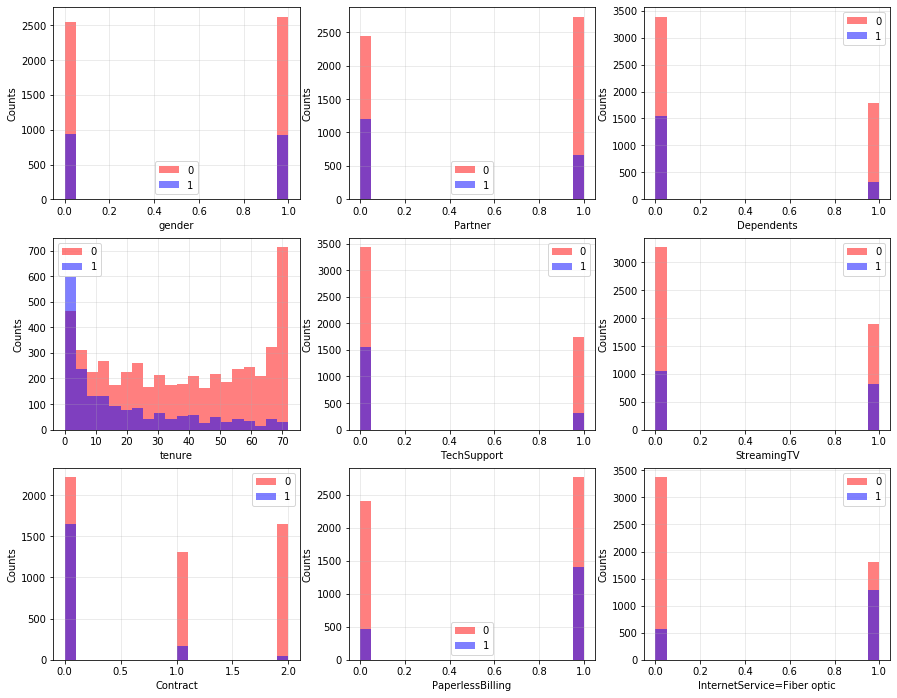

In [14]:
# Define size of the figure
plt.figure(figsize=(15, 12))

# For each column ...
for i_col in range(len(X_for_plot)):
    
    # Create subplot for each column
    plt.subplot(3, 3, i_col+1)
    
    # Get column and label values
    x_col = data_preproc[X_for_plot[i_col]].values
    y_col = data_preproc[y_column].values
    
    # Plot histograms
    bins = np.linspace(0, x_col.max(), 21)
    plt.grid(alpha = 0.3)
    plt.hist(x_col[y_col == 0], bins=bins, color='r', alpha=0.5, label='0')
    plt.hist(x_col[y_col == 1], bins=bins, color='b', alpha=0.5, label='1')
    
    # Labels and legend
    plt.xlabel(X_for_plot[i_col])
    plt.ylabel('Counts')
    plt.legend(loc='best')
    
plt.show()

Исходя из графиков выше мы видим, что:
- Вероятность продления подписки у обоих полов одинакова. 
- Клиенты, которые состоят в отношениях, более склонны к непродлению подписки. Это объясняется тем, что в семейном бюджете в приоритете могут быть другие приоритеты, нежели подписка на сервисы.
- Клиенты, у которых есть иждивенцы, чаще не продляются. Это также объясняется тем, что приоритет по бюджету отдается иным вещам.
- Клиенты, которые долго сотрудничают с компанием, более склонны к не продлению. Весьма вероятно, что они находят более интересные для себя предложения. 
- Клиенты с такими услугами, как техподдержка (показанные выше) и прочими техническими услугами (онлайн бэкап, защита устройства, онлайн защита), более склонные к непродлению подписки, чем клиенты без этих услуг.
- Клиенты с такими услугами, как наличие ТВ и похожих услуг (киносервис, телефон), в целом одинаково продляются, в сравнении с клиентами без этих услуг.
- Клиенты, которые имеют месячную подписку, чаще продляют подписку, чем клиенты, которые покупают подписку на 1 год или более.
- Клиенты, у которых интернет-провайдер Fiber optic, чаще продляются, чем клиенты с другим провайдером и без наличия интернета.

# Построение модели градиетного бустинга

Для начала разделим наши исходные данные на обучающую (80%) и тестовую (20%) выборки. 

In [15]:
X = data_preproc[X_columns].values
y = data_preproc[y_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=123)

Запишем функцию для сбора основных метрик оценки модели

In [16]:
def quality_report(prediction, prediction_prob, actual, model):
    quality_data = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'f1_score', 'ROC-AUC', 'Gini'], index=[model])
    
    quality_data['Accuracy'] = round(accuracy_score(prediction, actual), 3)
    quality_data['Precision'] = round(precision_score(prediction, actual), 3)
    quality_data['Recall'] = round(recall_score(prediction, actual), 3)
    quality_data['f1_score'] = round(f1_score(prediction, actual), 3)
    quality_data['ROC-AUC'] = round(roc_auc_score(actual, prediction_prob), 3)
    quality_data['Gini'] = round(2 * roc_auc_score(actual, prediction_prob) - 1, 3)
    
    return quality_data

Построим градиетный бустинг на базовых параметрах, используя пакет Sklearn.

In [17]:
skgbm = GradientBoostingClassifier()
skgbm.fit(X_train, y_train)
skgbm_pred = skgbm.predict(X_test)
skgbm_pred_prob = skgbm.predict_proba(X_test)[:, 1]

skgbm_report = quality_report(skgbm_pred, skgbm_pred_prob, y_test, 'Sklearn')
skgbm_report

Accuracy  Precision  Recall  f1_score  ROC-AUC   Gini
Sklearn     0.802       0.52   0.695     0.595    0.851  0.701

Построим градиетный бустинг на базовых параметрах, используя пакет XGBoost.

In [18]:
xgbm = XGBClassifier()
xgbm.fit(X_train, y_train)
xgbm_pred = xgbm.predict(X_test)
xgbm_pred_prob = xgbm.predict_proba(X_test)[:, 1]

xgbm_report = quality_report(xgbm_pred, xgbm_pred_prob, y_test, 'XGBoost')
xgbm_report

[15:10:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Accuracy  Precision  Recall  f1_score  ROC-AUC   Gini
XGBoost     0.796      0.538   0.667     0.596    0.837  0.675

Построим градиетный бустинг на базовых параметрах, используя пакет LightGBM.

In [19]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
lgbm_pred_prob = lgbm.predict_proba(X_test)[:, 1]

lgbm_report = quality_report(lgbm_pred, lgbm_pred_prob, y_test, 'LightGBM')
lgbm_report

Accuracy  Precision  Recall  f1_score  ROC-AUC   Gini
LightGBM     0.799      0.546   0.674     0.603    0.844  0.689

Построим градиетный бустинг на базовых параметрах, используя пакет CatBoost

In [20]:
catgbm = CatBoostClassifier()
catgbm.fit(X_train, y_train)
catgbm_pred = catgbm.predict(X_test)
catgbm_pred_prob = catgbm.predict_proba(X_test)[:, 1]

catgbm_report = quality_report(catgbm_pred, catgbm_pred_prob, y_test, 'CatBoost')
catgbm_report

Learning rate set to 0.021554
0:	learn: 0.6777016	total: 168ms	remaining: 2m 47s
1:	learn: 0.6671399	total: 176ms	remaining: 1m 27s
2:	learn: 0.6540314	total: 192ms	remaining: 1m 3s
3:	learn: 0.6410779	total: 199ms	remaining: 49.6s
4:	learn: 0.6279103	total: 206ms	remaining: 41s
5:	learn: 0.6180365	total: 211ms	remaining: 34.9s
6:	learn: 0.6069280	total: 217ms	remaining: 30.8s
7:	learn: 0.5970411	total: 223ms	remaining: 27.6s
8:	learn: 0.5871181	total: 228ms	remaining: 25.2s
9:	learn: 0.5787533	total: 234ms	remaining: 23.2s
10:	learn: 0.5701259	total: 239ms	remaining: 21.5s
11:	learn: 0.5627295	total: 243ms	remaining: 20s
12:	learn: 0.5551258	total: 249ms	remaining: 18.9s
13:	learn: 0.5477131	total: 254ms	remaining: 17.9s
14:	learn: 0.5415725	total: 260ms	remaining: 17s
15:	learn: 0.5347406	total: 265ms	remaining: 16.3s
16:	learn: 0.5286953	total: 270ms	remaining: 15.6s
17:	learn: 0.5239671	total: 275ms	remaining: 15s
18:	learn: 0.5191882	total: 281ms	remaining: 14.5s
19:	learn: 0.5139

165:	learn: 0.3888102	total: 1.12s	remaining: 5.61s
166:	learn: 0.3886953	total: 1.12s	remaining: 5.6s
167:	learn: 0.3885282	total: 1.13s	remaining: 5.59s
168:	learn: 0.3883724	total: 1.13s	remaining: 5.58s
169:	learn: 0.3881368	total: 1.14s	remaining: 5.57s
170:	learn: 0.3880183	total: 1.15s	remaining: 5.56s
171:	learn: 0.3878341	total: 1.15s	remaining: 5.55s
172:	learn: 0.3876493	total: 1.16s	remaining: 5.54s
173:	learn: 0.3874863	total: 1.16s	remaining: 5.52s
174:	learn: 0.3873478	total: 1.17s	remaining: 5.51s
175:	learn: 0.3871257	total: 1.17s	remaining: 5.5s
176:	learn: 0.3869006	total: 1.18s	remaining: 5.48s
177:	learn: 0.3866755	total: 1.19s	remaining: 5.47s
178:	learn: 0.3864511	total: 1.19s	remaining: 5.46s
179:	learn: 0.3862399	total: 1.2s	remaining: 5.45s
180:	learn: 0.3860806	total: 1.2s	remaining: 5.44s
181:	learn: 0.3858259	total: 1.21s	remaining: 5.43s
182:	learn: 0.3856826	total: 1.21s	remaining: 5.42s
183:	learn: 0.3855405	total: 1.22s	remaining: 5.4s
184:	learn: 0.385

327:	learn: 0.3650267	total: 2.01s	remaining: 4.12s
328:	learn: 0.3648377	total: 2.02s	remaining: 4.12s
329:	learn: 0.3646411	total: 2.02s	remaining: 4.11s
330:	learn: 0.3645433	total: 2.03s	remaining: 4.1s
331:	learn: 0.3644283	total: 2.04s	remaining: 4.09s
332:	learn: 0.3644188	total: 2.04s	remaining: 4.08s
333:	learn: 0.3642338	total: 2.04s	remaining: 4.08s
334:	learn: 0.3640717	total: 2.05s	remaining: 4.07s
335:	learn: 0.3639782	total: 2.06s	remaining: 4.06s
336:	learn: 0.3638918	total: 2.06s	remaining: 4.06s
337:	learn: 0.3637698	total: 2.07s	remaining: 4.05s
338:	learn: 0.3635884	total: 2.07s	remaining: 4.04s
339:	learn: 0.3635082	total: 2.08s	remaining: 4.03s
340:	learn: 0.3633621	total: 2.08s	remaining: 4.03s
341:	learn: 0.3632261	total: 2.09s	remaining: 4.02s
342:	learn: 0.3631498	total: 2.09s	remaining: 4.01s
343:	learn: 0.3630132	total: 2.1s	remaining: 4s
344:	learn: 0.3629228	total: 2.1s	remaining: 4s
345:	learn: 0.3627840	total: 2.11s	remaining: 3.99s
346:	learn: 0.3626811

490:	learn: 0.3451046	total: 2.9s	remaining: 3.01s
491:	learn: 0.3449873	total: 2.91s	remaining: 3s
492:	learn: 0.3448502	total: 2.91s	remaining: 2.99s
493:	learn: 0.3447499	total: 2.92s	remaining: 2.99s
494:	learn: 0.3446313	total: 2.92s	remaining: 2.98s
495:	learn: 0.3445078	total: 2.93s	remaining: 2.98s
496:	learn: 0.3444089	total: 2.93s	remaining: 2.97s
497:	learn: 0.3442764	total: 2.94s	remaining: 2.96s
498:	learn: 0.3441171	total: 2.95s	remaining: 2.96s
499:	learn: 0.3440054	total: 2.95s	remaining: 2.95s
500:	learn: 0.3438679	total: 2.96s	remaining: 2.95s
501:	learn: 0.3437641	total: 2.96s	remaining: 2.94s
502:	learn: 0.3436638	total: 2.97s	remaining: 2.94s
503:	learn: 0.3435068	total: 2.98s	remaining: 2.93s
504:	learn: 0.3434454	total: 2.98s	remaining: 2.93s
505:	learn: 0.3432393	total: 2.99s	remaining: 2.92s
506:	learn: 0.3431266	total: 3s	remaining: 2.92s
507:	learn: 0.3429910	total: 3.01s	remaining: 2.91s
508:	learn: 0.3428790	total: 3.01s	remaining: 2.91s
509:	learn: 0.34277

666:	learn: 0.3258442	total: 3.95s	remaining: 1.97s
667:	learn: 0.3257864	total: 3.95s	remaining: 1.97s
668:	learn: 0.3256176	total: 3.96s	remaining: 1.96s
669:	learn: 0.3254853	total: 3.97s	remaining: 1.95s
670:	learn: 0.3254331	total: 3.97s	remaining: 1.95s
671:	learn: 0.3252961	total: 3.98s	remaining: 1.94s
672:	learn: 0.3252411	total: 3.98s	remaining: 1.94s
673:	learn: 0.3250859	total: 3.99s	remaining: 1.93s
674:	learn: 0.3249672	total: 3.99s	remaining: 1.92s
675:	learn: 0.3248832	total: 4s	remaining: 1.92s
676:	learn: 0.3248021	total: 4s	remaining: 1.91s
677:	learn: 0.3247722	total: 4.01s	remaining: 1.91s
678:	learn: 0.3246709	total: 4.03s	remaining: 1.91s
679:	learn: 0.3245742	total: 4.04s	remaining: 1.9s
680:	learn: 0.3245102	total: 4.05s	remaining: 1.9s
681:	learn: 0.3243516	total: 4.09s	remaining: 1.91s
682:	learn: 0.3243111	total: 4.1s	remaining: 1.9s
683:	learn: 0.3242293	total: 4.11s	remaining: 1.9s
684:	learn: 0.3241251	total: 4.12s	remaining: 1.89s
685:	learn: 0.3239917	t

826:	learn: 0.3106006	total: 5s	remaining: 1.05s
827:	learn: 0.3105489	total: 5.01s	remaining: 1.04s
828:	learn: 0.3104784	total: 5.01s	remaining: 1.03s
829:	learn: 0.3104102	total: 5.02s	remaining: 1.03s
830:	learn: 0.3103582	total: 5.02s	remaining: 1.02s
831:	learn: 0.3102078	total: 5.03s	remaining: 1.01s
832:	learn: 0.3101290	total: 5.03s	remaining: 1.01s
833:	learn: 0.3100598	total: 5.04s	remaining: 1s
834:	learn: 0.3099793	total: 5.04s	remaining: 997ms
835:	learn: 0.3098818	total: 5.05s	remaining: 991ms
836:	learn: 0.3098245	total: 5.05s	remaining: 984ms
837:	learn: 0.3097211	total: 5.06s	remaining: 978ms
838:	learn: 0.3096350	total: 5.07s	remaining: 972ms
839:	learn: 0.3096035	total: 5.07s	remaining: 966ms
840:	learn: 0.3095245	total: 5.08s	remaining: 960ms
841:	learn: 0.3094820	total: 5.08s	remaining: 954ms
842:	learn: 0.3094163	total: 5.09s	remaining: 947ms
843:	learn: 0.3093590	total: 5.09s	remaining: 941ms
844:	learn: 0.3092458	total: 5.1s	remaining: 935ms
845:	learn: 0.30919

985:	learn: 0.2969786	total: 5.88s	remaining: 83.5ms
986:	learn: 0.2969311	total: 5.88s	remaining: 77.5ms
987:	learn: 0.2968289	total: 5.89s	remaining: 71.5ms
988:	learn: 0.2967521	total: 5.89s	remaining: 65.6ms
989:	learn: 0.2966365	total: 5.9s	remaining: 59.6ms
990:	learn: 0.2965356	total: 5.91s	remaining: 53.6ms
991:	learn: 0.2964444	total: 5.91s	remaining: 47.7ms
992:	learn: 0.2963666	total: 5.92s	remaining: 41.7ms
993:	learn: 0.2962698	total: 5.92s	remaining: 35.7ms
994:	learn: 0.2962068	total: 5.93s	remaining: 29.8ms
995:	learn: 0.2961236	total: 5.93s	remaining: 23.8ms
996:	learn: 0.2960487	total: 5.94s	remaining: 17.9ms
997:	learn: 0.2959414	total: 5.94s	remaining: 11.9ms
998:	learn: 0.2958973	total: 5.95s	remaining: 5.95ms
999:	learn: 0.2957992	total: 5.95s	remaining: 0us


Accuracy  Precision  Recall  f1_score  ROC-AUC   Gini
CatBoost     0.806      0.536   0.699     0.606    0.849  0.698

Сравним результаты по всем моделям:

In [21]:
models_report = pd.concat([skgbm_report, xgbm_report, lgbm_report, catgbm_report])
models_report

Accuracy  Precision  Recall  f1_score  ROC-AUC   Gini
Sklearn      0.802      0.520   0.695     0.595    0.851  0.701
XGBoost      0.796      0.538   0.667     0.596    0.837  0.675
LightGBM     0.799      0.546   0.674     0.603    0.844  0.689
CatBoost     0.806      0.536   0.699     0.606    0.849  0.698

Как мы видим из таблицы выше, все модели в целом показывают схожий результат, так как метрики существенно не отличаются. Разница между худшей и лучшей моделью по AUC составляет всего 1-2%. Однако мы можем наблюдать, что по Gini разница ощутима (составляет порядка 5%). Лучший результат показывают модели, построенные с использованием пакетов Sklearn и CatBoost. Худший - с использованием пакета XGBoost.


## Изменение гиперпараметров модели градиентного бустинга
Проведем настройку гиперпараметров моделей с помощью кросс-валидации. В качестве метрики, которую мы будем максимизировать, возьмем Recall. Так как нам важно понимать, что наша модель при предсказании находит как можно больше клиентов, которые продлят подписку.

Зададим гиперпараметры, которые мы будем изменять.

In [22]:
parameters = {'max_depth' : np.array(range(3, 10)),
             'learning_rate' : [0.001, 0.01, 0.02, 0.03, 0.04, 0.1, 0.2, 0.3],
             'n_estimators' : np.array(range(20, 120, 20))}

Настройка параметров градиентного бустинга из пакета Sklearn

In [23]:
%%time
skgbm_gs = GridSearchCV(skgbm,  
                  parameters,
                  scoring='recall',
                  cv=5) 

skgbm_gs.fit(X_train, y_train)
skgbm_gs.best_params_

Wall time: 27min 34s


{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 40}

In [24]:
skgbm_gs_pred = skgbm_gs.predict(X_test)
skgbm_gs_pred_prob = skgbm_gs.predict_proba(X_test)[:, 1]

skgbm_gs_report = quality_report(skgbm_gs_pred, skgbm_gs_pred_prob, y_test, 'Sklearn - GridSearch')
skgbm_gs_report

Accuracy  Precision  Recall  f1_score  ROC-AUC   Gini
Sklearn - GridSearch     0.798       0.53   0.676     0.595    0.843  0.686

Настройка параметров градиентного бустинга из пакета XGBoost

In [25]:
%%time
xgbm_gs = GridSearchCV(xgbm,  
                  parameters,
                  scoring='recall',
                  cv=5) 

xgbm_gs.fit(X_train, y_train)
xgbm_gs.best_params_

[15:37:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:38:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:38:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:38:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:38:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:38:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:39:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:39:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:39:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:39:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:39:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:39:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:41:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:41:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:41:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:41:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:41:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:42:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:42:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:42:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:42:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:42:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:42:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:43:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:43:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:43:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:43:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:43:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:43:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:44:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:44:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:44:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:44:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:45:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:45:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:45:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:45:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:45:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:45:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:45:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

{'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 60}

In [26]:
xgbm_gs_pred = xgbm_gs.predict(X_test)
xgbm_gs_pred_prob = xgbm_gs.predict_proba(X_test)[:, 1]

xgbm_gs_report = quality_report(xgbm_gs_pred, xgbm_gs_pred_prob, y_test, 'XGBoost - GridSearch')
xgbm_gs_report

Accuracy  Precision  Recall  f1_score  ROC-AUC  Gini
XGBoost - GridSearch     0.791      0.609    0.63     0.619     0.84  0.68

Настройка параметров градиентного бустинга из пакета LightGBM

In [27]:
%%time
lgbm_gs = GridSearchCV(lgbm,  
                  parameters,
                  scoring='recall',
                  cv=5) 

lgbm_gs.fit(X_train, y_train)
lgbm_gs.best_params_

Wall time: 1min 36s


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 80}

In [28]:
lgbm_gs_pred = lgbm_gs.predict(X_test)
lgbm_gs_pred_prob = lgbm_gs.predict_proba(X_test)[:, 1]

lgbm_gs_report = quality_report(lgbm_gs_pred, lgbm_gs_pred_prob, y_test, 'LightGBM - GridSearch')
lgbm_gs_report

Accuracy  Precision  Recall  f1_score  ROC-AUC  Gini
LightGBM - GridSearch     0.799      0.528   0.682     0.595     0.85   0.7

Настройка параметров градиентного бустинга из пакета CatBoost

In [29]:
%%time
catgbm_gs = GridSearchCV(catgbm,  
                  parameters,
                  scoring='recall',
                  cv=5) 

catgbm_gs.fit(X_train, y_train)
catgbm_gs.best_params_

0:	learn: 0.6924990	total: 3.85ms	remaining: 73.1ms
1:	learn: 0.6918333	total: 7.67ms	remaining: 69ms
2:	learn: 0.6911741	total: 11.9ms	remaining: 67.7ms
3:	learn: 0.6905552	total: 15.8ms	remaining: 63ms
4:	learn: 0.6898917	total: 21.1ms	remaining: 63.3ms
5:	learn: 0.6892517	total: 25.1ms	remaining: 58.5ms
6:	learn: 0.6885949	total: 28.8ms	remaining: 53.5ms
7:	learn: 0.6879359	total: 32.4ms	remaining: 48.6ms
8:	learn: 0.6872807	total: 36.3ms	remaining: 44.3ms
9:	learn: 0.6866248	total: 40.4ms	remaining: 40.4ms
10:	learn: 0.6860376	total: 44.2ms	remaining: 36.2ms
11:	learn: 0.6854345	total: 48.2ms	remaining: 32.1ms
12:	learn: 0.6847753	total: 52.1ms	remaining: 28ms
13:	learn: 0.6841543	total: 55.9ms	remaining: 24ms
14:	learn: 0.6835541	total: 59.4ms	remaining: 19.8ms
15:	learn: 0.6829649	total: 62.9ms	remaining: 15.7ms
16:	learn: 0.6823484	total: 66.2ms	remaining: 11.7ms
17:	learn: 0.6817236	total: 69.8ms	remaining: 7.76ms
18:	learn: 0.6811496	total: 73.6ms	remaining: 3.87ms
19:	learn: 

31:	learn: 0.6739034	total: 184ms	remaining: 45.9ms
32:	learn: 0.6733674	total: 188ms	remaining: 39.9ms
33:	learn: 0.6727637	total: 196ms	remaining: 34.5ms
34:	learn: 0.6722051	total: 200ms	remaining: 28.5ms
35:	learn: 0.6716827	total: 206ms	remaining: 22.8ms
36:	learn: 0.6710954	total: 211ms	remaining: 17.1ms
37:	learn: 0.6705575	total: 215ms	remaining: 11.3ms
38:	learn: 0.6700218	total: 221ms	remaining: 5.67ms
39:	learn: 0.6694669	total: 226ms	remaining: 0us
0:	learn: 0.6924988	total: 3.89ms	remaining: 152ms
1:	learn: 0.6918184	total: 8.5ms	remaining: 162ms
2:	learn: 0.6912442	total: 13.1ms	remaining: 162ms
3:	learn: 0.6906648	total: 16.8ms	remaining: 152ms
4:	learn: 0.6900712	total: 20.6ms	remaining: 144ms
5:	learn: 0.6894388	total: 24.6ms	remaining: 139ms
6:	learn: 0.6887705	total: 28.6ms	remaining: 135ms
7:	learn: 0.6881078	total: 32.5ms	remaining: 130ms
8:	learn: 0.6875043	total: 38.5ms	remaining: 132ms
9:	learn: 0.6868429	total: 42.4ms	remaining: 127ms
10:	learn: 0.6862374	total

43:	learn: 0.6660109	total: 174ms	remaining: 63.1ms
44:	learn: 0.6654212	total: 177ms	remaining: 59ms
45:	learn: 0.6648119	total: 181ms	remaining: 55ms
46:	learn: 0.6642883	total: 185ms	remaining: 51ms
47:	learn: 0.6637226	total: 188ms	remaining: 47.1ms
48:	learn: 0.6631393	total: 192ms	remaining: 43.1ms
49:	learn: 0.6625378	total: 196ms	remaining: 39.2ms
50:	learn: 0.6619699	total: 200ms	remaining: 35.3ms
51:	learn: 0.6614460	total: 204ms	remaining: 31.4ms
52:	learn: 0.6608887	total: 208ms	remaining: 27.5ms
53:	learn: 0.6603734	total: 211ms	remaining: 23.5ms
54:	learn: 0.6598469	total: 216ms	remaining: 19.6ms
55:	learn: 0.6592886	total: 220ms	remaining: 15.7ms
56:	learn: 0.6586953	total: 224ms	remaining: 11.8ms
57:	learn: 0.6581373	total: 228ms	remaining: 7.87ms
58:	learn: 0.6576286	total: 232ms	remaining: 3.93ms
59:	learn: 0.6570277	total: 236ms	remaining: 0us
0:	learn: 0.6925381	total: 3.98ms	remaining: 235ms
1:	learn: 0.6918941	total: 8.4ms	remaining: 244ms
2:	learn: 0.6912423	tota

49:	learn: 0.6638981	total: 187ms	remaining: 37.4ms
50:	learn: 0.6633213	total: 191ms	remaining: 33.7ms
51:	learn: 0.6627293	total: 194ms	remaining: 29.9ms
52:	learn: 0.6621843	total: 198ms	remaining: 26.2ms
53:	learn: 0.6616187	total: 202ms	remaining: 22.4ms
54:	learn: 0.6610815	total: 206ms	remaining: 18.7ms
55:	learn: 0.6605644	total: 209ms	remaining: 15ms
56:	learn: 0.6599941	total: 213ms	remaining: 11.2ms
57:	learn: 0.6595056	total: 217ms	remaining: 7.47ms
58:	learn: 0.6590057	total: 220ms	remaining: 3.73ms
59:	learn: 0.6584977	total: 224ms	remaining: 0us
0:	learn: 0.6924853	total: 3.68ms	remaining: 217ms
1:	learn: 0.6918080	total: 7.3ms	remaining: 212ms
2:	learn: 0.6911667	total: 10.7ms	remaining: 204ms
3:	learn: 0.6905202	total: 14ms	remaining: 196ms
4:	learn: 0.6898446	total: 17.4ms	remaining: 191ms
5:	learn: 0.6892082	total: 21.3ms	remaining: 191ms
6:	learn: 0.6885479	total: 24.9ms	remaining: 188ms
7:	learn: 0.6878903	total: 28.4ms	remaining: 185ms
8:	learn: 0.6873267	total: 3

47:	learn: 0.6649966	total: 179ms	remaining: 119ms
48:	learn: 0.6645097	total: 184ms	remaining: 116ms
49:	learn: 0.6639273	total: 188ms	remaining: 113ms
50:	learn: 0.6633884	total: 191ms	remaining: 109ms
51:	learn: 0.6628223	total: 195ms	remaining: 105ms
52:	learn: 0.6623124	total: 199ms	remaining: 101ms
53:	learn: 0.6617374	total: 203ms	remaining: 97.7ms
54:	learn: 0.6611492	total: 207ms	remaining: 94ms
55:	learn: 0.6605773	total: 211ms	remaining: 90.3ms
56:	learn: 0.6600194	total: 214ms	remaining: 86.5ms
57:	learn: 0.6594508	total: 218ms	remaining: 82.8ms
58:	learn: 0.6589473	total: 222ms	remaining: 79.1ms
59:	learn: 0.6584819	total: 226ms	remaining: 75.2ms
60:	learn: 0.6579168	total: 229ms	remaining: 71.4ms
61:	learn: 0.6573902	total: 233ms	remaining: 67.6ms
62:	learn: 0.6568775	total: 236ms	remaining: 63.8ms
63:	learn: 0.6563426	total: 240ms	remaining: 60.1ms
64:	learn: 0.6558127	total: 244ms	remaining: 56.3ms
65:	learn: 0.6552772	total: 248ms	remaining: 52.5ms
66:	learn: 0.6547331

47:	learn: 0.6650039	total: 183ms	remaining: 122ms
48:	learn: 0.6644072	total: 186ms	remaining: 118ms
49:	learn: 0.6638981	total: 190ms	remaining: 114ms
50:	learn: 0.6633213	total: 194ms	remaining: 110ms
51:	learn: 0.6627293	total: 198ms	remaining: 106ms
52:	learn: 0.6621843	total: 201ms	remaining: 103ms
53:	learn: 0.6616187	total: 205ms	remaining: 98.7ms
54:	learn: 0.6610815	total: 209ms	remaining: 94.9ms
55:	learn: 0.6605644	total: 213ms	remaining: 91.1ms
56:	learn: 0.6599941	total: 216ms	remaining: 87.3ms
57:	learn: 0.6595056	total: 220ms	remaining: 83.5ms
58:	learn: 0.6590057	total: 224ms	remaining: 79.7ms
59:	learn: 0.6584977	total: 228ms	remaining: 75.9ms
60:	learn: 0.6579457	total: 232ms	remaining: 72.2ms
61:	learn: 0.6573903	total: 236ms	remaining: 68.4ms
62:	learn: 0.6568709	total: 240ms	remaining: 64.6ms
63:	learn: 0.6563205	total: 243ms	remaining: 60.8ms
64:	learn: 0.6558220	total: 247ms	remaining: 56.9ms
65:	learn: 0.6552501	total: 251ms	remaining: 53.1ms
66:	learn: 0.65478

47:	learn: 0.6637226	total: 181ms	remaining: 196ms
48:	learn: 0.6631393	total: 185ms	remaining: 193ms
49:	learn: 0.6625378	total: 189ms	remaining: 189ms
50:	learn: 0.6619699	total: 193ms	remaining: 185ms
51:	learn: 0.6614460	total: 197ms	remaining: 182ms
52:	learn: 0.6608887	total: 201ms	remaining: 178ms
53:	learn: 0.6603734	total: 204ms	remaining: 174ms
54:	learn: 0.6598469	total: 208ms	remaining: 170ms
55:	learn: 0.6592886	total: 212ms	remaining: 167ms
56:	learn: 0.6586953	total: 216ms	remaining: 163ms
57:	learn: 0.6581373	total: 219ms	remaining: 159ms
58:	learn: 0.6576286	total: 223ms	remaining: 155ms
59:	learn: 0.6570277	total: 227ms	remaining: 151ms
60:	learn: 0.6564802	total: 231ms	remaining: 148ms
61:	learn: 0.6558959	total: 235ms	remaining: 144ms
62:	learn: 0.6553520	total: 238ms	remaining: 140ms
63:	learn: 0.6548150	total: 242ms	remaining: 136ms
64:	learn: 0.6542494	total: 246ms	remaining: 132ms
65:	learn: 0.6536696	total: 249ms	remaining: 128ms
66:	learn: 0.6531517	total: 253

36:	learn: 0.6702013	total: 180ms	remaining: 307ms
37:	learn: 0.6696225	total: 185ms	remaining: 301ms
38:	learn: 0.6690396	total: 189ms	remaining: 296ms
39:	learn: 0.6684387	total: 194ms	remaining: 291ms
40:	learn: 0.6678683	total: 198ms	remaining: 285ms
41:	learn: 0.6672543	total: 203ms	remaining: 280ms
42:	learn: 0.6666485	total: 207ms	remaining: 275ms
43:	learn: 0.6661376	total: 212ms	remaining: 270ms
44:	learn: 0.6655232	total: 216ms	remaining: 264ms
45:	learn: 0.6649085	total: 220ms	remaining: 259ms
46:	learn: 0.6643681	total: 224ms	remaining: 253ms
47:	learn: 0.6637955	total: 228ms	remaining: 247ms
48:	learn: 0.6632757	total: 233ms	remaining: 242ms
49:	learn: 0.6626682	total: 237ms	remaining: 237ms
50:	learn: 0.6620829	total: 241ms	remaining: 232ms
51:	learn: 0.6614869	total: 246ms	remaining: 227ms
52:	learn: 0.6609236	total: 250ms	remaining: 222ms
53:	learn: 0.6603217	total: 255ms	remaining: 218ms
54:	learn: 0.6597505	total: 261ms	remaining: 213ms
55:	learn: 0.6591910	total: 265

96:	learn: 0.6398565	total: 357ms	remaining: 11ms
97:	learn: 0.6393487	total: 360ms	remaining: 7.35ms
98:	learn: 0.6388578	total: 364ms	remaining: 3.67ms
99:	learn: 0.6383532	total: 367ms	remaining: 0us
0:	learn: 0.6924853	total: 4.03ms	remaining: 399ms
1:	learn: 0.6918080	total: 7.61ms	remaining: 373ms
2:	learn: 0.6911667	total: 11ms	remaining: 355ms
3:	learn: 0.6905202	total: 14.2ms	remaining: 341ms
4:	learn: 0.6898446	total: 17.8ms	remaining: 337ms
5:	learn: 0.6892082	total: 22ms	remaining: 345ms
6:	learn: 0.6885479	total: 25.4ms	remaining: 338ms
7:	learn: 0.6878903	total: 29.1ms	remaining: 335ms
8:	learn: 0.6873267	total: 33ms	remaining: 334ms
9:	learn: 0.6867153	total: 37.4ms	remaining: 337ms
10:	learn: 0.6861748	total: 41ms	remaining: 332ms
11:	learn: 0.6854885	total: 44.8ms	remaining: 329ms
12:	learn: 0.6848526	total: 48.4ms	remaining: 324ms
13:	learn: 0.6842314	total: 51.8ms	remaining: 318ms
14:	learn: 0.6835736	total: 55.3ms	remaining: 314ms
15:	learn: 0.6829558	total: 59.1ms	

1:	learn: 0.6918509	total: 8.67ms	remaining: 78ms
2:	learn: 0.6912204	total: 12.3ms	remaining: 70ms
3:	learn: 0.6906032	total: 16.2ms	remaining: 64.8ms
4:	learn: 0.6899550	total: 20.2ms	remaining: 60.7ms
5:	learn: 0.6893735	total: 23.8ms	remaining: 55.4ms
6:	learn: 0.6887073	total: 28ms	remaining: 52ms
7:	learn: 0.6880623	total: 31.8ms	remaining: 47.8ms
8:	learn: 0.6873823	total: 35.9ms	remaining: 43.9ms
9:	learn: 0.6867180	total: 40.3ms	remaining: 40.3ms
10:	learn: 0.6860936	total: 44.3ms	remaining: 36.2ms
11:	learn: 0.6854479	total: 48.1ms	remaining: 32.1ms
12:	learn: 0.6848232	total: 52.1ms	remaining: 28.1ms
13:	learn: 0.6841924	total: 56ms	remaining: 24ms
14:	learn: 0.6835571	total: 59.9ms	remaining: 20ms
15:	learn: 0.6829261	total: 63.8ms	remaining: 15.9ms
16:	learn: 0.6823231	total: 68ms	remaining: 12ms
17:	learn: 0.6817598	total: 71.7ms	remaining: 7.97ms
18:	learn: 0.6811350	total: 75.7ms	remaining: 3.98ms
19:	learn: 0.6805457	total: 79.7ms	remaining: 0us
0:	learn: 0.6924110	tot

0:	learn: 0.6924564	total: 3.77ms	remaining: 147ms
1:	learn: 0.6918509	total: 7.78ms	remaining: 148ms
2:	learn: 0.6912204	total: 11.8ms	remaining: 145ms
3:	learn: 0.6906032	total: 16.2ms	remaining: 146ms
4:	learn: 0.6899550	total: 20.3ms	remaining: 142ms
5:	learn: 0.6893735	total: 24.1ms	remaining: 137ms
6:	learn: 0.6887073	total: 30ms	remaining: 141ms
7:	learn: 0.6880623	total: 33.9ms	remaining: 135ms
8:	learn: 0.6873823	total: 37.7ms	remaining: 130ms
9:	learn: 0.6867180	total: 41.6ms	remaining: 125ms
10:	learn: 0.6860936	total: 45.7ms	remaining: 121ms
11:	learn: 0.6854479	total: 49.9ms	remaining: 116ms
12:	learn: 0.6848232	total: 54ms	remaining: 112ms
13:	learn: 0.6841924	total: 58.2ms	remaining: 108ms
14:	learn: 0.6835571	total: 62.6ms	remaining: 104ms
15:	learn: 0.6829261	total: 66.6ms	remaining: 99.9ms
16:	learn: 0.6823231	total: 70.5ms	remaining: 95.4ms
17:	learn: 0.6817598	total: 74.3ms	remaining: 90.9ms
18:	learn: 0.6811350	total: 78.6ms	remaining: 86.9ms
19:	learn: 0.6805457	t

49:	learn: 0.6624967	total: 217ms	remaining: 43.4ms
50:	learn: 0.6619146	total: 221ms	remaining: 39ms
51:	learn: 0.6613334	total: 225ms	remaining: 34.6ms
52:	learn: 0.6607486	total: 229ms	remaining: 30.3ms
53:	learn: 0.6601699	total: 234ms	remaining: 26ms
54:	learn: 0.6596092	total: 238ms	remaining: 21.6ms
55:	learn: 0.6590693	total: 242ms	remaining: 17.3ms
56:	learn: 0.6585420	total: 246ms	remaining: 13ms
57:	learn: 0.6579647	total: 250ms	remaining: 8.63ms
58:	learn: 0.6573626	total: 254ms	remaining: 4.31ms
59:	learn: 0.6568247	total: 258ms	remaining: 0us
0:	learn: 0.6924097	total: 4.09ms	remaining: 241ms
1:	learn: 0.6917212	total: 8.4ms	remaining: 244ms
2:	learn: 0.6911267	total: 12.2ms	remaining: 231ms
3:	learn: 0.6904374	total: 16.3ms	remaining: 228ms
4:	learn: 0.6897865	total: 20.4ms	remaining: 224ms
5:	learn: 0.6890986	total: 24.8ms	remaining: 223ms
6:	learn: 0.6884397	total: 28.8ms	remaining: 218ms
7:	learn: 0.6877217	total: 32.9ms	remaining: 214ms
8:	learn: 0.6870574	total: 37.

52:	learn: 0.6595817	total: 219ms	remaining: 28.9ms
53:	learn: 0.6590109	total: 223ms	remaining: 24.8ms
54:	learn: 0.6584098	total: 227ms	remaining: 20.7ms
55:	learn: 0.6578512	total: 231ms	remaining: 16.5ms
56:	learn: 0.6572733	total: 235ms	remaining: 12.4ms
57:	learn: 0.6566374	total: 240ms	remaining: 8.26ms
58:	learn: 0.6560023	total: 244ms	remaining: 4.13ms
59:	learn: 0.6554312	total: 247ms	remaining: 0us
0:	learn: 0.6924190	total: 4.07ms	remaining: 322ms
1:	learn: 0.6917394	total: 8.1ms	remaining: 316ms
2:	learn: 0.6911641	total: 11.3ms	remaining: 291ms
3:	learn: 0.6905003	total: 15.3ms	remaining: 290ms
4:	learn: 0.6898738	total: 19.3ms	remaining: 290ms
5:	learn: 0.6891895	total: 23.4ms	remaining: 288ms
6:	learn: 0.6885279	total: 27.6ms	remaining: 287ms
7:	learn: 0.6878516	total: 31.9ms	remaining: 287ms
8:	learn: 0.6872022	total: 36.1ms	remaining: 285ms
9:	learn: 0.6865307	total: 40.9ms	remaining: 286ms
10:	learn: 0.6858931	total: 45.2ms	remaining: 284ms
11:	learn: 0.6852195	total

0:	learn: 0.6924097	total: 3.92ms	remaining: 309ms
1:	learn: 0.6917212	total: 8.17ms	remaining: 319ms
2:	learn: 0.6911267	total: 11.6ms	remaining: 298ms
3:	learn: 0.6904374	total: 15.8ms	remaining: 300ms
4:	learn: 0.6897865	total: 20.1ms	remaining: 301ms
5:	learn: 0.6890986	total: 24.3ms	remaining: 299ms
6:	learn: 0.6884397	total: 28.4ms	remaining: 296ms
7:	learn: 0.6877217	total: 32.4ms	remaining: 292ms
8:	learn: 0.6870574	total: 36.5ms	remaining: 288ms
9:	learn: 0.6863758	total: 40.8ms	remaining: 286ms
10:	learn: 0.6857371	total: 45.2ms	remaining: 283ms
11:	learn: 0.6850620	total: 49.2ms	remaining: 279ms
12:	learn: 0.6843968	total: 53.4ms	remaining: 275ms
13:	learn: 0.6837211	total: 57.3ms	remaining: 270ms
14:	learn: 0.6830666	total: 61.2ms	remaining: 265ms
15:	learn: 0.6824298	total: 65.1ms	remaining: 261ms
16:	learn: 0.6817610	total: 69.6ms	remaining: 258ms
17:	learn: 0.6810961	total: 73.7ms	remaining: 254ms
18:	learn: 0.6804289	total: 77.6ms	remaining: 249ms
19:	learn: 0.6797272	t

1:	learn: 0.6917306	total: 10.3ms	remaining: 402ms
2:	learn: 0.6911478	total: 15.2ms	remaining: 391ms
3:	learn: 0.6905451	total: 20.8ms	remaining: 395ms
4:	learn: 0.6898697	total: 25.7ms	remaining: 386ms
5:	learn: 0.6892280	total: 31.3ms	remaining: 386ms
6:	learn: 0.6885372	total: 36.6ms	remaining: 382ms
7:	learn: 0.6878373	total: 41.9ms	remaining: 377ms
8:	learn: 0.6871178	total: 46.1ms	remaining: 363ms
9:	learn: 0.6864604	total: 50.1ms	remaining: 350ms
10:	learn: 0.6857883	total: 54.4ms	remaining: 341ms
11:	learn: 0.6851222	total: 59.9ms	remaining: 340ms
12:	learn: 0.6844700	total: 65.5ms	remaining: 337ms
13:	learn: 0.6838345	total: 70.9ms	remaining: 334ms
14:	learn: 0.6831538	total: 76.7ms	remaining: 332ms
15:	learn: 0.6824842	total: 82.5ms	remaining: 330ms
16:	learn: 0.6818101	total: 87.9ms	remaining: 326ms
17:	learn: 0.6811962	total: 92.3ms	remaining: 318ms
18:	learn: 0.6805234	total: 96.6ms	remaining: 310ms
19:	learn: 0.6798530	total: 101ms	remaining: 302ms
20:	learn: 0.6791917	t

0:	learn: 0.6924524	total: 4.15ms	remaining: 411ms
1:	learn: 0.6917940	total: 8.43ms	remaining: 413ms
2:	learn: 0.6912253	total: 12ms	remaining: 387ms
3:	learn: 0.6905717	total: 16.5ms	remaining: 397ms
4:	learn: 0.6899458	total: 20.8ms	remaining: 395ms
5:	learn: 0.6892891	total: 25ms	remaining: 391ms
6:	learn: 0.6886458	total: 29.2ms	remaining: 388ms
7:	learn: 0.6879988	total: 33.5ms	remaining: 385ms
8:	learn: 0.6873635	total: 37.6ms	remaining: 380ms
9:	learn: 0.6867149	total: 41.4ms	remaining: 373ms
10:	learn: 0.6861163	total: 46ms	remaining: 373ms
11:	learn: 0.6854849	total: 50.3ms	remaining: 369ms
12:	learn: 0.6848492	total: 54.6ms	remaining: 365ms
13:	learn: 0.6842004	total: 58.7ms	remaining: 361ms
14:	learn: 0.6835629	total: 63.1ms	remaining: 357ms
15:	learn: 0.6829320	total: 67.2ms	remaining: 353ms
16:	learn: 0.6823356	total: 71.2ms	remaining: 348ms
17:	learn: 0.6817610	total: 75.3ms	remaining: 343ms
18:	learn: 0.6811633	total: 80.2ms	remaining: 342ms
19:	learn: 0.6805359	total: 

84:	learn: 0.6414130	total: 354ms	remaining: 62.4ms
85:	learn: 0.6408440	total: 358ms	remaining: 58.3ms
86:	learn: 0.6403328	total: 362ms	remaining: 54.1ms
87:	learn: 0.6397765	total: 366ms	remaining: 49.9ms
88:	learn: 0.6393035	total: 370ms	remaining: 45.7ms
89:	learn: 0.6388341	total: 374ms	remaining: 41.6ms
90:	learn: 0.6383159	total: 378ms	remaining: 37.4ms
91:	learn: 0.6377577	total: 382ms	remaining: 33.2ms
92:	learn: 0.6372061	total: 386ms	remaining: 29ms
93:	learn: 0.6367119	total: 390ms	remaining: 24.9ms
94:	learn: 0.6361842	total: 394ms	remaining: 20.8ms
95:	learn: 0.6356142	total: 398ms	remaining: 16.6ms
96:	learn: 0.6350491	total: 402ms	remaining: 12.4ms
97:	learn: 0.6345551	total: 406ms	remaining: 8.29ms
98:	learn: 0.6340248	total: 410ms	remaining: 4.14ms
99:	learn: 0.6334961	total: 414ms	remaining: 0us
0:	learn: 0.6924564	total: 3.97ms	remaining: 393ms
1:	learn: 0.6918509	total: 8.08ms	remaining: 396ms
2:	learn: 0.6912204	total: 11.7ms	remaining: 377ms
3:	learn: 0.6906032	

49:	learn: 0.6613842	total: 202ms	remaining: 202ms
50:	learn: 0.6607823	total: 206ms	remaining: 198ms
51:	learn: 0.6601778	total: 211ms	remaining: 194ms
52:	learn: 0.6595817	total: 215ms	remaining: 191ms
53:	learn: 0.6590109	total: 219ms	remaining: 187ms
54:	learn: 0.6584098	total: 224ms	remaining: 183ms
55:	learn: 0.6578512	total: 228ms	remaining: 179ms
56:	learn: 0.6572733	total: 232ms	remaining: 175ms
57:	learn: 0.6566374	total: 237ms	remaining: 171ms
58:	learn: 0.6560023	total: 241ms	remaining: 167ms
59:	learn: 0.6554312	total: 245ms	remaining: 163ms
60:	learn: 0.6548363	total: 249ms	remaining: 159ms
61:	learn: 0.6542418	total: 253ms	remaining: 155ms
62:	learn: 0.6536997	total: 257ms	remaining: 151ms
63:	learn: 0.6531943	total: 261ms	remaining: 147ms
64:	learn: 0.6526543	total: 265ms	remaining: 143ms
65:	learn: 0.6520883	total: 269ms	remaining: 139ms
66:	learn: 0.6515078	total: 274ms	remaining: 135ms
67:	learn: 0.6509252	total: 278ms	remaining: 131ms
68:	learn: 0.6503443	total: 282

0:	learn: 0.6924521	total: 20.4ms	remaining: 794ms
1:	learn: 0.6917673	total: 25.3ms	remaining: 481ms
2:	learn: 0.6910837	total: 29.6ms	remaining: 365ms
3:	learn: 0.6904362	total: 33.8ms	remaining: 304ms
4:	learn: 0.6897604	total: 38.1ms	remaining: 267ms
5:	learn: 0.6890861	total: 42.4ms	remaining: 240ms
6:	learn: 0.6883910	total: 46.8ms	remaining: 221ms
7:	learn: 0.6877125	total: 51.2ms	remaining: 205ms
8:	learn: 0.6869897	total: 55.7ms	remaining: 192ms
9:	learn: 0.6863554	total: 60.1ms	remaining: 180ms
10:	learn: 0.6856833	total: 64.7ms	remaining: 171ms
11:	learn: 0.6850261	total: 69.5ms	remaining: 162ms
12:	learn: 0.6843738	total: 74ms	remaining: 154ms
13:	learn: 0.6837473	total: 78.5ms	remaining: 146ms
14:	learn: 0.6831038	total: 83ms	remaining: 138ms
15:	learn: 0.6824380	total: 87.8ms	remaining: 132ms
16:	learn: 0.6818096	total: 92.1ms	remaining: 125ms
17:	learn: 0.6811519	total: 96.8ms	remaining: 118ms
18:	learn: 0.6805275	total: 101ms	remaining: 112ms
19:	learn: 0.6798733	total:

0:	learn: 0.6923960	total: 4.41ms	remaining: 260ms
1:	learn: 0.6916868	total: 8.98ms	remaining: 260ms
2:	learn: 0.6909765	total: 13.4ms	remaining: 254ms
3:	learn: 0.6903183	total: 17.7ms	remaining: 248ms
4:	learn: 0.6896017	total: 22ms	remaining: 242ms
5:	learn: 0.6889079	total: 26.5ms	remaining: 239ms
6:	learn: 0.6881828	total: 30.9ms	remaining: 234ms
7:	learn: 0.6875252	total: 35.5ms	remaining: 231ms
8:	learn: 0.6867783	total: 40ms	remaining: 227ms
9:	learn: 0.6861375	total: 44.9ms	remaining: 225ms
10:	learn: 0.6854442	total: 49.3ms	remaining: 220ms
11:	learn: 0.6847590	total: 53.8ms	remaining: 215ms
12:	learn: 0.6840694	total: 58.1ms	remaining: 210ms
13:	learn: 0.6833898	total: 62.5ms	remaining: 205ms
14:	learn: 0.6827073	total: 66.7ms	remaining: 200ms
15:	learn: 0.6820147	total: 71.1ms	remaining: 195ms
16:	learn: 0.6813604	total: 75.5ms	remaining: 191ms
17:	learn: 0.6806840	total: 79.9ms	remaining: 187ms
18:	learn: 0.6800316	total: 84.5ms	remaining: 182ms
19:	learn: 0.6793525	total

55:	learn: 0.6565772	total: 365ms	remaining: 26.1ms
56:	learn: 0.6559530	total: 370ms	remaining: 19.5ms
57:	learn: 0.6553535	total: 375ms	remaining: 12.9ms
58:	learn: 0.6547454	total: 379ms	remaining: 6.43ms
59:	learn: 0.6541431	total: 386ms	remaining: 0us
0:	learn: 0.6924532	total: 4.74ms	remaining: 280ms
1:	learn: 0.6917663	total: 9.44ms	remaining: 274ms
2:	learn: 0.6910800	total: 14.3ms	remaining: 272ms
3:	learn: 0.6904421	total: 19.2ms	remaining: 268ms
4:	learn: 0.6897563	total: 23.6ms	remaining: 259ms
5:	learn: 0.6890841	total: 28.2ms	remaining: 254ms
6:	learn: 0.6883866	total: 32.6ms	remaining: 247ms
7:	learn: 0.6877190	total: 36.9ms	remaining: 240ms
8:	learn: 0.6870181	total: 41.7ms	remaining: 236ms
9:	learn: 0.6864053	total: 46.2ms	remaining: 231ms
10:	learn: 0.6857359	total: 50.6ms	remaining: 225ms
11:	learn: 0.6850908	total: 55ms	remaining: 220ms
12:	learn: 0.6844254	total: 59.4ms	remaining: 215ms
13:	learn: 0.6838200	total: 63.8ms	remaining: 210ms
14:	learn: 0.6831617	total:

40:	learn: 0.6658264	total: 199ms	remaining: 190ms
41:	learn: 0.6651794	total: 204ms	remaining: 185ms
42:	learn: 0.6645068	total: 209ms	remaining: 180ms
43:	learn: 0.6639139	total: 213ms	remaining: 174ms
44:	learn: 0.6632958	total: 217ms	remaining: 169ms
45:	learn: 0.6626673	total: 222ms	remaining: 164ms
46:	learn: 0.6620287	total: 226ms	remaining: 159ms
47:	learn: 0.6614016	total: 231ms	remaining: 154ms
48:	learn: 0.6607873	total: 235ms	remaining: 149ms
49:	learn: 0.6602238	total: 240ms	remaining: 144ms
50:	learn: 0.6596088	total: 244ms	remaining: 139ms
51:	learn: 0.6590156	total: 248ms	remaining: 134ms
52:	learn: 0.6583628	total: 253ms	remaining: 129ms
53:	learn: 0.6577327	total: 257ms	remaining: 124ms
54:	learn: 0.6571168	total: 262ms	remaining: 119ms
55:	learn: 0.6565102	total: 266ms	remaining: 114ms
56:	learn: 0.6559044	total: 271ms	remaining: 109ms
57:	learn: 0.6552949	total: 275ms	remaining: 104ms
58:	learn: 0.6546886	total: 280ms	remaining: 99.5ms
59:	learn: 0.6540882	total: 28

76:	learn: 0.6442105	total: 348ms	remaining: 13.6ms
77:	learn: 0.6436749	total: 353ms	remaining: 9.04ms
78:	learn: 0.6431369	total: 357ms	remaining: 4.52ms
79:	learn: 0.6425728	total: 362ms	remaining: 0us
0:	learn: 0.6924532	total: 4.33ms	remaining: 342ms
1:	learn: 0.6917663	total: 8.71ms	remaining: 340ms
2:	learn: 0.6910800	total: 13.4ms	remaining: 345ms
3:	learn: 0.6904421	total: 17.7ms	remaining: 336ms
4:	learn: 0.6897563	total: 22.2ms	remaining: 332ms
5:	learn: 0.6890841	total: 26.6ms	remaining: 328ms
6:	learn: 0.6883866	total: 31.4ms	remaining: 327ms
7:	learn: 0.6877190	total: 35.9ms	remaining: 323ms
8:	learn: 0.6870181	total: 40.3ms	remaining: 318ms
9:	learn: 0.6864053	total: 46ms	remaining: 322ms
10:	learn: 0.6857359	total: 51.1ms	remaining: 320ms
11:	learn: 0.6850908	total: 55.6ms	remaining: 315ms
12:	learn: 0.6844254	total: 61.2ms	remaining: 315ms
13:	learn: 0.6838200	total: 65.9ms	remaining: 311ms
14:	learn: 0.6831617	total: 70.7ms	remaining: 306ms
15:	learn: 0.6824852	total:

0:	learn: 0.6923960	total: 4.79ms	remaining: 474ms
1:	learn: 0.6916868	total: 10.7ms	remaining: 524ms
2:	learn: 0.6909765	total: 18.1ms	remaining: 585ms
3:	learn: 0.6903183	total: 24.5ms	remaining: 589ms
4:	learn: 0.6896017	total: 30.2ms	remaining: 575ms
5:	learn: 0.6889079	total: 34.9ms	remaining: 546ms
6:	learn: 0.6881828	total: 39.9ms	remaining: 530ms
7:	learn: 0.6875252	total: 45.8ms	remaining: 526ms
8:	learn: 0.6867783	total: 50.4ms	remaining: 509ms
9:	learn: 0.6861375	total: 55ms	remaining: 495ms
10:	learn: 0.6854442	total: 60.2ms	remaining: 487ms
11:	learn: 0.6847590	total: 64.8ms	remaining: 475ms
12:	learn: 0.6840694	total: 69.4ms	remaining: 464ms
13:	learn: 0.6833898	total: 74.1ms	remaining: 455ms
14:	learn: 0.6827073	total: 78.7ms	remaining: 446ms
15:	learn: 0.6820147	total: 83.7ms	remaining: 440ms
16:	learn: 0.6813604	total: 88.2ms	remaining: 431ms
17:	learn: 0.6806840	total: 92.9ms	remaining: 423ms
18:	learn: 0.6800316	total: 97.2ms	remaining: 414ms
19:	learn: 0.6793525	tot

77:	learn: 0.6454174	total: 350ms	remaining: 98.8ms
78:	learn: 0.6448677	total: 355ms	remaining: 94.3ms
79:	learn: 0.6443097	total: 359ms	remaining: 89.8ms
80:	learn: 0.6437917	total: 363ms	remaining: 85.2ms
81:	learn: 0.6432366	total: 368ms	remaining: 80.7ms
82:	learn: 0.6426684	total: 372ms	remaining: 76.2ms
83:	learn: 0.6421095	total: 377ms	remaining: 71.7ms
84:	learn: 0.6415791	total: 381ms	remaining: 67.2ms
85:	learn: 0.6410593	total: 386ms	remaining: 62.8ms
86:	learn: 0.6405351	total: 391ms	remaining: 58.4ms
87:	learn: 0.6400028	total: 395ms	remaining: 53.9ms
88:	learn: 0.6394752	total: 399ms	remaining: 49.4ms
89:	learn: 0.6389249	total: 404ms	remaining: 44.9ms
90:	learn: 0.6384269	total: 408ms	remaining: 40.3ms
91:	learn: 0.6379376	total: 412ms	remaining: 35.8ms
92:	learn: 0.6373779	total: 417ms	remaining: 31.4ms
93:	learn: 0.6368511	total: 422ms	remaining: 26.9ms
94:	learn: 0.6363221	total: 426ms	remaining: 22.4ms
95:	learn: 0.6358434	total: 431ms	remaining: 17.9ms
96:	learn: 0

40:	learn: 0.6668887	total: 187ms	remaining: 269ms
41:	learn: 0.6662749	total: 192ms	remaining: 265ms
42:	learn: 0.6656290	total: 196ms	remaining: 260ms
43:	learn: 0.6650737	total: 201ms	remaining: 255ms
44:	learn: 0.6645308	total: 205ms	remaining: 251ms
45:	learn: 0.6639641	total: 210ms	remaining: 247ms
46:	learn: 0.6633588	total: 215ms	remaining: 242ms
47:	learn: 0.6627448	total: 220ms	remaining: 238ms
48:	learn: 0.6621419	total: 224ms	remaining: 233ms
49:	learn: 0.6615533	total: 228ms	remaining: 228ms
50:	learn: 0.6609554	total: 232ms	remaining: 223ms
51:	learn: 0.6603495	total: 237ms	remaining: 219ms
52:	learn: 0.6597085	total: 242ms	remaining: 214ms
53:	learn: 0.6591271	total: 246ms	remaining: 209ms
54:	learn: 0.6585530	total: 251ms	remaining: 206ms
55:	learn: 0.6579887	total: 256ms	remaining: 201ms
56:	learn: 0.6573941	total: 261ms	remaining: 197ms
57:	learn: 0.6568481	total: 265ms	remaining: 192ms
58:	learn: 0.6562625	total: 270ms	remaining: 187ms
59:	learn: 0.6556414	total: 275

0:	learn: 0.6923896	total: 5.43ms	remaining: 103ms
1:	learn: 0.6918606	total: 8.52ms	remaining: 76.7ms
2:	learn: 0.6911773	total: 14.1ms	remaining: 79.7ms
3:	learn: 0.6904570	total: 18.8ms	remaining: 75.1ms
4:	learn: 0.6897235	total: 24.2ms	remaining: 72.6ms
5:	learn: 0.6890204	total: 32ms	remaining: 74.7ms
6:	learn: 0.6883110	total: 37ms	remaining: 68.6ms
7:	learn: 0.6876144	total: 41.9ms	remaining: 62.8ms
8:	learn: 0.6869167	total: 54.8ms	remaining: 67ms
9:	learn: 0.6862428	total: 60.6ms	remaining: 60.6ms
10:	learn: 0.6855476	total: 67.6ms	remaining: 55.3ms
11:	learn: 0.6848406	total: 74.4ms	remaining: 49.6ms
12:	learn: 0.6841224	total: 80.5ms	remaining: 43.3ms
13:	learn: 0.6834435	total: 86.4ms	remaining: 37ms
14:	learn: 0.6827189	total: 91.8ms	remaining: 30.6ms
15:	learn: 0.6820062	total: 115ms	remaining: 28.7ms
16:	learn: 0.6813208	total: 138ms	remaining: 24.4ms
17:	learn: 0.6806834	total: 143ms	remaining: 15.9ms
18:	learn: 0.6799820	total: 153ms	remaining: 8.03ms
19:	learn: 0.679

0:	learn: 0.6923920	total: 6.02ms	remaining: 235ms
1:	learn: 0.6918479	total: 9.37ms	remaining: 178ms
2:	learn: 0.6911214	total: 14.4ms	remaining: 177ms
3:	learn: 0.6903905	total: 19.5ms	remaining: 175ms
4:	learn: 0.6896746	total: 24.4ms	remaining: 171ms
5:	learn: 0.6889523	total: 29.4ms	remaining: 167ms
6:	learn: 0.6882318	total: 34.9ms	remaining: 165ms
7:	learn: 0.6875303	total: 40.3ms	remaining: 161ms
8:	learn: 0.6868241	total: 45.3ms	remaining: 156ms
9:	learn: 0.6861437	total: 50.3ms	remaining: 151ms
10:	learn: 0.6854426	total: 55.2ms	remaining: 146ms
11:	learn: 0.6847388	total: 60.2ms	remaining: 140ms
12:	learn: 0.6840290	total: 70.3ms	remaining: 146ms
13:	learn: 0.6833497	total: 75.5ms	remaining: 140ms
14:	learn: 0.6826259	total: 81.8ms	remaining: 136ms
15:	learn: 0.6819414	total: 87.6ms	remaining: 131ms
16:	learn: 0.6812349	total: 92.9ms	remaining: 126ms
17:	learn: 0.6805916	total: 97.2ms	remaining: 119ms
18:	learn: 0.6798811	total: 103ms	remaining: 113ms
19:	learn: 0.6792307	to

45:	learn: 0.6619203	total: 235ms	remaining: 71.4ms
46:	learn: 0.6613006	total: 240ms	remaining: 66.3ms
47:	learn: 0.6606516	total: 245ms	remaining: 61.1ms
48:	learn: 0.6600185	total: 250ms	remaining: 56ms
49:	learn: 0.6593952	total: 255ms	remaining: 50.9ms
50:	learn: 0.6588020	total: 259ms	remaining: 45.8ms
51:	learn: 0.6581802	total: 264ms	remaining: 40.7ms
52:	learn: 0.6575508	total: 269ms	remaining: 35.6ms
53:	learn: 0.6569398	total: 274ms	remaining: 30.5ms
54:	learn: 0.6563067	total: 280ms	remaining: 25.4ms
55:	learn: 0.6556496	total: 285ms	remaining: 20.4ms
56:	learn: 0.6550646	total: 290ms	remaining: 15.3ms
57:	learn: 0.6544972	total: 295ms	remaining: 10.2ms
58:	learn: 0.6538808	total: 300ms	remaining: 5.08ms
59:	learn: 0.6532758	total: 305ms	remaining: 0us
0:	learn: 0.6924432	total: 5.37ms	remaining: 317ms
1:	learn: 0.6919246	total: 8.89ms	remaining: 258ms
2:	learn: 0.6912031	total: 13.6ms	remaining: 259ms
3:	learn: 0.6905201	total: 18.7ms	remaining: 262ms
4:	learn: 0.6898375	t

35:	learn: 0.6695448	total: 177ms	remaining: 118ms
36:	learn: 0.6689086	total: 182ms	remaining: 113ms
37:	learn: 0.6682921	total: 187ms	remaining: 108ms
38:	learn: 0.6676591	total: 193ms	remaining: 104ms
39:	learn: 0.6670479	total: 198ms	remaining: 98.8ms
40:	learn: 0.6664092	total: 202ms	remaining: 93.6ms
41:	learn: 0.6657871	total: 207ms	remaining: 88.9ms
42:	learn: 0.6651504	total: 212ms	remaining: 83.9ms
43:	learn: 0.6645386	total: 218ms	remaining: 79.1ms
44:	learn: 0.6639239	total: 223ms	remaining: 74.4ms
45:	learn: 0.6632894	total: 228ms	remaining: 69.4ms
46:	learn: 0.6627041	total: 233ms	remaining: 64.4ms
47:	learn: 0.6621134	total: 238ms	remaining: 59.5ms
48:	learn: 0.6614581	total: 243ms	remaining: 54.5ms
49:	learn: 0.6608657	total: 248ms	remaining: 49.6ms
50:	learn: 0.6602682	total: 253ms	remaining: 44.6ms
51:	learn: 0.6596874	total: 258ms	remaining: 39.6ms
52:	learn: 0.6590889	total: 263ms	remaining: 34.7ms
53:	learn: 0.6584758	total: 269ms	remaining: 29.9ms
54:	learn: 0.657

6:	learn: 0.6885610	total: 32.8ms	remaining: 342ms
7:	learn: 0.6878938	total: 37.8ms	remaining: 340ms
8:	learn: 0.6871730	total: 56ms	remaining: 442ms
9:	learn: 0.6865239	total: 60.9ms	remaining: 426ms
10:	learn: 0.6858343	total: 65.3ms	remaining: 410ms
11:	learn: 0.6852290	total: 69.5ms	remaining: 394ms
12:	learn: 0.6845942	total: 73.5ms	remaining: 379ms
13:	learn: 0.6838813	total: 78.8ms	remaining: 371ms
14:	learn: 0.6832102	total: 83.7ms	remaining: 363ms
15:	learn: 0.6825686	total: 88.8ms	remaining: 355ms
16:	learn: 0.6819241	total: 93.9ms	remaining: 348ms
17:	learn: 0.6812572	total: 98.8ms	remaining: 340ms
18:	learn: 0.6806505	total: 104ms	remaining: 333ms
19:	learn: 0.6800051	total: 109ms	remaining: 328ms
20:	learn: 0.6793662	total: 114ms	remaining: 321ms
21:	learn: 0.6787643	total: 120ms	remaining: 315ms
22:	learn: 0.6781252	total: 125ms	remaining: 309ms
23:	learn: 0.6774619	total: 129ms	remaining: 302ms
24:	learn: 0.6767805	total: 134ms	remaining: 295ms
25:	learn: 0.6761559	tota

10:	learn: 0.6858298	total: 68.5ms	remaining: 430ms
11:	learn: 0.6852326	total: 72.6ms	remaining: 411ms
12:	learn: 0.6845777	total: 77.7ms	remaining: 400ms
13:	learn: 0.6838815	total: 82.8ms	remaining: 390ms
14:	learn: 0.6831937	total: 87.7ms	remaining: 380ms
15:	learn: 0.6824808	total: 92.6ms	remaining: 371ms
16:	learn: 0.6818127	total: 97.8ms	remaining: 362ms
17:	learn: 0.6812510	total: 102ms	remaining: 351ms
18:	learn: 0.6806199	total: 107ms	remaining: 343ms
19:	learn: 0.6799157	total: 112ms	remaining: 335ms
20:	learn: 0.6792970	total: 116ms	remaining: 325ms
21:	learn: 0.6786097	total: 120ms	remaining: 318ms
22:	learn: 0.6779265	total: 125ms	remaining: 310ms
23:	learn: 0.6772861	total: 130ms	remaining: 303ms
24:	learn: 0.6766311	total: 135ms	remaining: 297ms
25:	learn: 0.6759798	total: 140ms	remaining: 291ms
26:	learn: 0.6753858	total: 145ms	remaining: 285ms
27:	learn: 0.6747793	total: 151ms	remaining: 280ms
28:	learn: 0.6741135	total: 156ms	remaining: 273ms
29:	learn: 0.6734407	tot

34:	learn: 0.6690760	total: 176ms	remaining: 326ms
35:	learn: 0.6683977	total: 181ms	remaining: 321ms
36:	learn: 0.6677582	total: 186ms	remaining: 316ms
37:	learn: 0.6671132	total: 191ms	remaining: 311ms
38:	learn: 0.6664613	total: 196ms	remaining: 306ms
39:	learn: 0.6657973	total: 200ms	remaining: 301ms
40:	learn: 0.6651298	total: 206ms	remaining: 296ms
41:	learn: 0.6644772	total: 211ms	remaining: 292ms
42:	learn: 0.6638345	total: 217ms	remaining: 288ms
43:	learn: 0.6631678	total: 222ms	remaining: 282ms
44:	learn: 0.6625289	total: 227ms	remaining: 277ms
45:	learn: 0.6619203	total: 231ms	remaining: 271ms
46:	learn: 0.6613006	total: 236ms	remaining: 266ms
47:	learn: 0.6606516	total: 241ms	remaining: 261ms
48:	learn: 0.6600185	total: 246ms	remaining: 256ms
49:	learn: 0.6593952	total: 251ms	remaining: 251ms
50:	learn: 0.6588020	total: 255ms	remaining: 245ms
51:	learn: 0.6581802	total: 261ms	remaining: 241ms
52:	learn: 0.6575508	total: 266ms	remaining: 236ms
53:	learn: 0.6569398	total: 271

0:	learn: 0.6923920	total: 4.93ms	remaining: 488ms
1:	learn: 0.6918479	total: 8.24ms	remaining: 404ms
2:	learn: 0.6911214	total: 14ms	remaining: 453ms
3:	learn: 0.6903905	total: 19ms	remaining: 457ms
4:	learn: 0.6896746	total: 24.2ms	remaining: 459ms
5:	learn: 0.6889523	total: 29.2ms	remaining: 457ms
6:	learn: 0.6882318	total: 34.2ms	remaining: 455ms
7:	learn: 0.6875303	total: 39.1ms	remaining: 450ms
8:	learn: 0.6868241	total: 44.8ms	remaining: 453ms
9:	learn: 0.6861437	total: 49.7ms	remaining: 447ms
10:	learn: 0.6854426	total: 54.5ms	remaining: 441ms
11:	learn: 0.6847388	total: 59.7ms	remaining: 438ms
12:	learn: 0.6840290	total: 64.4ms	remaining: 431ms
13:	learn: 0.6833497	total: 69.3ms	remaining: 425ms
14:	learn: 0.6826259	total: 74.3ms	remaining: 421ms
15:	learn: 0.6819414	total: 79.7ms	remaining: 418ms
16:	learn: 0.6812349	total: 84.4ms	remaining: 412ms
17:	learn: 0.6805916	total: 88.4ms	remaining: 403ms
18:	learn: 0.6798811	total: 93.7ms	remaining: 399ms
19:	learn: 0.6792307	total

68:	learn: 0.6497811	total: 352ms	remaining: 158ms
69:	learn: 0.6491775	total: 358ms	remaining: 153ms
70:	learn: 0.6485984	total: 363ms	remaining: 148ms
71:	learn: 0.6480222	total: 368ms	remaining: 143ms
72:	learn: 0.6475976	total: 371ms	remaining: 137ms
73:	learn: 0.6470287	total: 376ms	remaining: 132ms
74:	learn: 0.6464628	total: 381ms	remaining: 127ms
75:	learn: 0.6460416	total: 384ms	remaining: 121ms
76:	learn: 0.6455031	total: 389ms	remaining: 116ms
77:	learn: 0.6450015	total: 394ms	remaining: 111ms
78:	learn: 0.6444774	total: 399ms	remaining: 106ms
79:	learn: 0.6439376	total: 403ms	remaining: 101ms
80:	learn: 0.6434086	total: 408ms	remaining: 95.6ms
81:	learn: 0.6428396	total: 413ms	remaining: 90.6ms
82:	learn: 0.6422697	total: 418ms	remaining: 85.6ms
83:	learn: 0.6417080	total: 423ms	remaining: 80.5ms
84:	learn: 0.6411525	total: 428ms	remaining: 75.4ms
85:	learn: 0.6406095	total: 432ms	remaining: 70.4ms
86:	learn: 0.6400205	total: 438ms	remaining: 65.4ms
87:	learn: 0.6396132	tot

0:	learn: 0.6923952	total: 5.84ms	remaining: 111ms
1:	learn: 0.6916374	total: 11.6ms	remaining: 105ms
2:	learn: 0.6909094	total: 17.4ms	remaining: 98.9ms
3:	learn: 0.6901754	total: 23.6ms	remaining: 94.5ms
4:	learn: 0.6894812	total: 29.5ms	remaining: 88.5ms
5:	learn: 0.6887578	total: 35.3ms	remaining: 82.3ms
6:	learn: 0.6880160	total: 40.9ms	remaining: 76ms
7:	learn: 0.6872858	total: 46.9ms	remaining: 70.3ms
8:	learn: 0.6866212	total: 52.3ms	remaining: 63.9ms
9:	learn: 0.6859237	total: 57.8ms	remaining: 57.8ms
10:	learn: 0.6851969	total: 63.9ms	remaining: 52.3ms
11:	learn: 0.6844716	total: 70ms	remaining: 46.6ms
12:	learn: 0.6837657	total: 75.9ms	remaining: 40.9ms
13:	learn: 0.6830715	total: 81.8ms	remaining: 35.1ms
14:	learn: 0.6823678	total: 87.7ms	remaining: 29.2ms
15:	learn: 0.6816726	total: 93.7ms	remaining: 23.4ms
16:	learn: 0.6809918	total: 99.4ms	remaining: 17.5ms
17:	learn: 0.6803357	total: 104ms	remaining: 11.5ms
18:	learn: 0.6796565	total: 110ms	remaining: 5.79ms
19:	learn: 

32:	learn: 0.6703731	total: 195ms	remaining: 41.3ms
33:	learn: 0.6697089	total: 202ms	remaining: 35.6ms
34:	learn: 0.6690245	total: 207ms	remaining: 29.6ms
35:	learn: 0.6683510	total: 214ms	remaining: 23.7ms
36:	learn: 0.6676561	total: 219ms	remaining: 17.8ms
37:	learn: 0.6669470	total: 225ms	remaining: 11.8ms
38:	learn: 0.6662872	total: 231ms	remaining: 5.92ms
39:	learn: 0.6656065	total: 237ms	remaining: 0us
0:	learn: 0.6924481	total: 10.2ms	remaining: 399ms
1:	learn: 0.6917268	total: 17.4ms	remaining: 331ms
2:	learn: 0.6910375	total: 23.6ms	remaining: 291ms
3:	learn: 0.6903185	total: 29.7ms	remaining: 267ms
4:	learn: 0.6895554	total: 36.4ms	remaining: 255ms
5:	learn: 0.6888438	total: 42.3ms	remaining: 239ms
6:	learn: 0.6881561	total: 48.3ms	remaining: 228ms
7:	learn: 0.6874712	total: 55ms	remaining: 220ms
8:	learn: 0.6868256	total: 60.9ms	remaining: 210ms
9:	learn: 0.6861349	total: 66.6ms	remaining: 200ms
10:	learn: 0.6854542	total: 72.3ms	remaining: 191ms
11:	learn: 0.6847627	total:

29:	learn: 0.6728667	total: 189ms	remaining: 189ms
30:	learn: 0.6722635	total: 193ms	remaining: 180ms
31:	learn: 0.6716038	total: 199ms	remaining: 174ms
32:	learn: 0.6710205	total: 204ms	remaining: 167ms
33:	learn: 0.6703676	total: 211ms	remaining: 161ms
34:	learn: 0.6697175	total: 216ms	remaining: 154ms
35:	learn: 0.6690472	total: 222ms	remaining: 148ms
36:	learn: 0.6683703	total: 228ms	remaining: 142ms
37:	learn: 0.6677244	total: 234ms	remaining: 135ms
38:	learn: 0.6670588	total: 240ms	remaining: 129ms
39:	learn: 0.6663888	total: 246ms	remaining: 123ms
40:	learn: 0.6657851	total: 250ms	remaining: 116ms
41:	learn: 0.6651517	total: 257ms	remaining: 110ms
42:	learn: 0.6645023	total: 263ms	remaining: 104ms
43:	learn: 0.6638465	total: 269ms	remaining: 97.8ms
44:	learn: 0.6632492	total: 275ms	remaining: 91.5ms
45:	learn: 0.6626045	total: 280ms	remaining: 85.3ms
46:	learn: 0.6619691	total: 287ms	remaining: 79.5ms
47:	learn: 0.6613221	total: 293ms	remaining: 73.3ms
48:	learn: 0.6606922	total

12:	learn: 0.6835326	total: 77.7ms	remaining: 281ms
13:	learn: 0.6828358	total: 83.6ms	remaining: 275ms
14:	learn: 0.6820938	total: 89.7ms	remaining: 269ms
15:	learn: 0.6814020	total: 95.4ms	remaining: 262ms
16:	learn: 0.6807196	total: 101ms	remaining: 256ms
17:	learn: 0.6800454	total: 106ms	remaining: 248ms
18:	learn: 0.6793854	total: 113ms	remaining: 244ms
19:	learn: 0.6786469	total: 120ms	remaining: 240ms
20:	learn: 0.6779157	total: 127ms	remaining: 236ms
21:	learn: 0.6772302	total: 134ms	remaining: 231ms
22:	learn: 0.6765324	total: 140ms	remaining: 225ms
23:	learn: 0.6758527	total: 145ms	remaining: 218ms
24:	learn: 0.6751267	total: 151ms	remaining: 211ms
25:	learn: 0.6744306	total: 157ms	remaining: 205ms
26:	learn: 0.6737076	total: 162ms	remaining: 198ms
27:	learn: 0.6729995	total: 168ms	remaining: 192ms
28:	learn: 0.6723001	total: 173ms	remaining: 185ms
29:	learn: 0.6715718	total: 179ms	remaining: 179ms
30:	learn: 0.6708278	total: 185ms	remaining: 173ms
31:	learn: 0.6701271	total:

47:	learn: 0.6613221	total: 375ms	remaining: 250ms
48:	learn: 0.6606922	total: 382ms	remaining: 241ms
49:	learn: 0.6600487	total: 388ms	remaining: 233ms
50:	learn: 0.6594770	total: 392ms	remaining: 223ms
51:	learn: 0.6588267	total: 398ms	remaining: 214ms
52:	learn: 0.6582285	total: 403ms	remaining: 205ms
53:	learn: 0.6576307	total: 409ms	remaining: 197ms
54:	learn: 0.6570054	total: 415ms	remaining: 189ms
55:	learn: 0.6563706	total: 421ms	remaining: 180ms
56:	learn: 0.6557566	total: 426ms	remaining: 172ms
57:	learn: 0.6551322	total: 432ms	remaining: 164ms
58:	learn: 0.6545719	total: 436ms	remaining: 155ms
59:	learn: 0.6539886	total: 442ms	remaining: 147ms
60:	learn: 0.6533706	total: 447ms	remaining: 139ms
61:	learn: 0.6528095	total: 453ms	remaining: 132ms
62:	learn: 0.6521904	total: 459ms	remaining: 124ms
63:	learn: 0.6515708	total: 465ms	remaining: 116ms
64:	learn: 0.6510310	total: 468ms	remaining: 108ms
65:	learn: 0.6504693	total: 474ms	remaining: 101ms
66:	learn: 0.6498594	total: 480

49:	learn: 0.6600486	total: 355ms	remaining: 213ms
50:	learn: 0.6594388	total: 361ms	remaining: 205ms
51:	learn: 0.6588246	total: 368ms	remaining: 198ms
52:	learn: 0.6582086	total: 375ms	remaining: 191ms
53:	learn: 0.6576079	total: 381ms	remaining: 183ms
54:	learn: 0.6570000	total: 387ms	remaining: 176ms
55:	learn: 0.6563888	total: 391ms	remaining: 168ms
56:	learn: 0.6557471	total: 397ms	remaining: 160ms
57:	learn: 0.6551731	total: 402ms	remaining: 153ms
58:	learn: 0.6546433	total: 406ms	remaining: 145ms
59:	learn: 0.6540582	total: 413ms	remaining: 138ms
60:	learn: 0.6534472	total: 420ms	remaining: 131ms
61:	learn: 0.6528503	total: 426ms	remaining: 124ms
62:	learn: 0.6522472	total: 432ms	remaining: 116ms
63:	learn: 0.6516518	total: 437ms	remaining: 109ms
64:	learn: 0.6510521	total: 443ms	remaining: 102ms
65:	learn: 0.6504511	total: 449ms	remaining: 95.2ms
66:	learn: 0.6498260	total: 454ms	remaining: 88.2ms
67:	learn: 0.6492080	total: 460ms	remaining: 81.2ms
68:	learn: 0.6486672	total: 

59:	learn: 0.6527601	total: 359ms	remaining: 240ms
60:	learn: 0.6520976	total: 366ms	remaining: 234ms
61:	learn: 0.6514756	total: 373ms	remaining: 228ms
62:	learn: 0.6508858	total: 379ms	remaining: 223ms
63:	learn: 0.6503011	total: 385ms	remaining: 216ms
64:	learn: 0.6496785	total: 391ms	remaining: 210ms
65:	learn: 0.6490880	total: 396ms	remaining: 204ms
66:	learn: 0.6484901	total: 402ms	remaining: 198ms
67:	learn: 0.6478818	total: 408ms	remaining: 192ms
68:	learn: 0.6472677	total: 414ms	remaining: 186ms
69:	learn: 0.6466407	total: 419ms	remaining: 180ms
70:	learn: 0.6460434	total: 425ms	remaining: 174ms
71:	learn: 0.6453966	total: 431ms	remaining: 168ms
72:	learn: 0.6448014	total: 437ms	remaining: 162ms
73:	learn: 0.6441654	total: 442ms	remaining: 155ms
74:	learn: 0.6435969	total: 447ms	remaining: 149ms
75:	learn: 0.6430196	total: 453ms	remaining: 143ms
76:	learn: 0.6424480	total: 459ms	remaining: 137ms
77:	learn: 0.6418212	total: 465ms	remaining: 131ms
78:	learn: 0.6412461	total: 471

22:	learn: 0.6768732	total: 204ms	remaining: 682ms
23:	learn: 0.6762033	total: 211ms	remaining: 669ms
24:	learn: 0.6755997	total: 216ms	remaining: 647ms
25:	learn: 0.6749083	total: 222ms	remaining: 632ms
26:	learn: 0.6742525	total: 228ms	remaining: 617ms
27:	learn: 0.6735598	total: 235ms	remaining: 605ms
28:	learn: 0.6729035	total: 240ms	remaining: 589ms
29:	learn: 0.6721964	total: 247ms	remaining: 576ms
30:	learn: 0.6716569	total: 250ms	remaining: 557ms
31:	learn: 0.6710107	total: 256ms	remaining: 544ms
32:	learn: 0.6703731	total: 260ms	remaining: 528ms
33:	learn: 0.6697089	total: 266ms	remaining: 516ms
34:	learn: 0.6690245	total: 272ms	remaining: 505ms
35:	learn: 0.6683510	total: 278ms	remaining: 493ms
36:	learn: 0.6676561	total: 283ms	remaining: 482ms
37:	learn: 0.6669470	total: 289ms	remaining: 471ms
38:	learn: 0.6662872	total: 295ms	remaining: 461ms
39:	learn: 0.6656065	total: 301ms	remaining: 452ms
40:	learn: 0.6649062	total: 307ms	remaining: 442ms
41:	learn: 0.6642741	total: 312

95:	learn: 0.6333757	total: 548ms	remaining: 22.8ms
96:	learn: 0.6327910	total: 554ms	remaining: 17.1ms
97:	learn: 0.6322584	total: 561ms	remaining: 11.5ms
98:	learn: 0.6317238	total: 567ms	remaining: 5.73ms
99:	learn: 0.6311456	total: 573ms	remaining: 0us
0:	learn: 0.6923896	total: 14.5ms	remaining: 1.44s
1:	learn: 0.6916139	total: 20.4ms	remaining: 1s
2:	learn: 0.6908688	total: 26.4ms	remaining: 854ms
3:	learn: 0.6900846	total: 32.4ms	remaining: 777ms
4:	learn: 0.6893684	total: 38.3ms	remaining: 727ms
5:	learn: 0.6886109	total: 43.9ms	remaining: 688ms
6:	learn: 0.6878821	total: 51ms	remaining: 677ms
7:	learn: 0.6871290	total: 57.6ms	remaining: 663ms
8:	learn: 0.6864494	total: 63.4ms	remaining: 641ms
9:	learn: 0.6857277	total: 68.9ms	remaining: 620ms
10:	learn: 0.6850038	total: 75.3ms	remaining: 609ms
11:	learn: 0.6842728	total: 81.6ms	remaining: 599ms
12:	learn: 0.6835326	total: 87.1ms	remaining: 583ms
13:	learn: 0.6828358	total: 92.7ms	remaining: 569ms
14:	learn: 0.6820938	total: 98

0:	learn: 0.6924473	total: 8.93ms	remaining: 170ms
1:	learn: 0.6917172	total: 19ms	remaining: 171ms
2:	learn: 0.6910329	total: 29.8ms	remaining: 169ms
3:	learn: 0.6903141	total: 43ms	remaining: 172ms
4:	learn: 0.6896016	total: 54.7ms	remaining: 164ms
5:	learn: 0.6889279	total: 62.2ms	remaining: 145ms
6:	learn: 0.6882100	total: 73.2ms	remaining: 136ms
7:	learn: 0.6875403	total: 82ms	remaining: 123ms
8:	learn: 0.6869844	total: 86.4ms	remaining: 106ms
9:	learn: 0.6862676	total: 106ms	remaining: 106ms
10:	learn: 0.6855552	total: 122ms	remaining: 99.5ms
11:	learn: 0.6848670	total: 130ms	remaining: 86.4ms
12:	learn: 0.6841496	total: 137ms	remaining: 73.7ms
13:	learn: 0.6834018	total: 145ms	remaining: 62.1ms
14:	learn: 0.6827049	total: 152ms	remaining: 50.7ms
15:	learn: 0.6820519	total: 157ms	remaining: 39.2ms
16:	learn: 0.6813518	total: 164ms	remaining: 29ms
17:	learn: 0.6806196	total: 171ms	remaining: 19ms
18:	learn: 0.6799529	total: 179ms	remaining: 9.4ms
19:	learn: 0.6793258	total: 183ms	

27:	learn: 0.6738004	total: 202ms	remaining: 86.6ms
28:	learn: 0.6731218	total: 212ms	remaining: 80.5ms
29:	learn: 0.6724534	total: 221ms	remaining: 73.6ms
30:	learn: 0.6717367	total: 229ms	remaining: 66.6ms
31:	learn: 0.6711011	total: 236ms	remaining: 59ms
32:	learn: 0.6704500	total: 244ms	remaining: 51.7ms
33:	learn: 0.6697531	total: 251ms	remaining: 44.3ms
34:	learn: 0.6690512	total: 258ms	remaining: 36.9ms
35:	learn: 0.6683882	total: 265ms	remaining: 29.5ms
36:	learn: 0.6677031	total: 272ms	remaining: 22.1ms
37:	learn: 0.6670503	total: 280ms	remaining: 14.7ms
38:	learn: 0.6663824	total: 287ms	remaining: 7.36ms
39:	learn: 0.6657835	total: 291ms	remaining: 0us
0:	learn: 0.6923886	total: 7.7ms	remaining: 300ms
1:	learn: 0.6916041	total: 15.2ms	remaining: 290ms
2:	learn: 0.6909153	total: 22.6ms	remaining: 278ms
3:	learn: 0.6901505	total: 30.2ms	remaining: 272ms
4:	learn: 0.6893983	total: 37.7ms	remaining: 264ms
5:	learn: 0.6886853	total: 45.3ms	remaining: 257ms
6:	learn: 0.6879779	tota

57:	learn: 0.6548611	total: 455ms	remaining: 15.7ms
58:	learn: 0.6543454	total: 464ms	remaining: 7.87ms
59:	learn: 0.6537017	total: 483ms	remaining: 0us
0:	learn: 0.6923942	total: 12.2ms	remaining: 718ms
1:	learn: 0.6916214	total: 28.8ms	remaining: 834ms
2:	learn: 0.6909412	total: 39.1ms	remaining: 743ms
3:	learn: 0.6902078	total: 55ms	remaining: 770ms
4:	learn: 0.6894462	total: 65.7ms	remaining: 722ms
5:	learn: 0.6887385	total: 80.2ms	remaining: 722ms
6:	learn: 0.6880078	total: 96.4ms	remaining: 730ms
7:	learn: 0.6873183	total: 116ms	remaining: 751ms
8:	learn: 0.6867338	total: 121ms	remaining: 684ms
9:	learn: 0.6859764	total: 139ms	remaining: 696ms
10:	learn: 0.6852337	total: 148ms	remaining: 660ms
11:	learn: 0.6845141	total: 166ms	remaining: 664ms
12:	learn: 0.6837707	total: 187ms	remaining: 677ms
13:	learn: 0.6830236	total: 211ms	remaining: 695ms
14:	learn: 0.6823043	total: 228ms	remaining: 684ms
15:	learn: 0.6816422	total: 241ms	remaining: 662ms
16:	learn: 0.6809367	total: 263ms	re

50:	learn: 0.6575220	total: 358ms	remaining: 63.2ms
51:	learn: 0.6568904	total: 364ms	remaining: 55.9ms
52:	learn: 0.6561814	total: 373ms	remaining: 49.3ms
53:	learn: 0.6555264	total: 380ms	remaining: 42.2ms
54:	learn: 0.6548568	total: 388ms	remaining: 35.3ms
55:	learn: 0.6542229	total: 397ms	remaining: 28.3ms
56:	learn: 0.6535641	total: 405ms	remaining: 21.3ms
57:	learn: 0.6529400	total: 414ms	remaining: 14.3ms
58:	learn: 0.6522831	total: 422ms	remaining: 7.15ms
59:	learn: 0.6516153	total: 430ms	remaining: 0us
0:	learn: 0.6923918	total: 7.56ms	remaining: 597ms
1:	learn: 0.6916408	total: 14.9ms	remaining: 582ms
2:	learn: 0.6909351	total: 23.1ms	remaining: 592ms
3:	learn: 0.6902117	total: 30.4ms	remaining: 577ms
4:	learn: 0.6894969	total: 36.2ms	remaining: 542ms
5:	learn: 0.6888318	total: 40.8ms	remaining: 503ms
6:	learn: 0.6880930	total: 48.4ms	remaining: 505ms
7:	learn: 0.6873858	total: 53.4ms	remaining: 480ms
8:	learn: 0.6866761	total: 60.7ms	remaining: 479ms
9:	learn: 0.6859119	tota

0:	learn: 0.6923942	total: 9.33ms	remaining: 737ms
1:	learn: 0.6916214	total: 18.2ms	remaining: 709ms
2:	learn: 0.6909412	total: 66.6ms	remaining: 1.71s
3:	learn: 0.6902078	total: 81.2ms	remaining: 1.54s
4:	learn: 0.6894462	total: 97.9ms	remaining: 1.47s
5:	learn: 0.6887385	total: 114ms	remaining: 1.41s
6:	learn: 0.6880078	total: 128ms	remaining: 1.33s
7:	learn: 0.6873183	total: 144ms	remaining: 1.29s
8:	learn: 0.6867338	total: 148ms	remaining: 1.16s
9:	learn: 0.6859764	total: 157ms	remaining: 1.1s
10:	learn: 0.6852337	total: 171ms	remaining: 1.07s
11:	learn: 0.6845141	total: 186ms	remaining: 1.05s
12:	learn: 0.6837707	total: 199ms	remaining: 1.03s
13:	learn: 0.6830236	total: 216ms	remaining: 1.02s
14:	learn: 0.6823043	total: 227ms	remaining: 985ms
15:	learn: 0.6816422	total: 236ms	remaining: 943ms
16:	learn: 0.6809367	total: 246ms	remaining: 913ms
17:	learn: 0.6801642	total: 255ms	remaining: 878ms
18:	learn: 0.6794699	total: 264ms	remaining: 849ms
19:	learn: 0.6788084	total: 270ms	rem

28:	learn: 0.6725332	total: 204ms	remaining: 358ms
29:	learn: 0.6718389	total: 212ms	remaining: 354ms
30:	learn: 0.6711189	total: 220ms	remaining: 348ms
31:	learn: 0.6704035	total: 228ms	remaining: 341ms
32:	learn: 0.6696994	total: 233ms	remaining: 331ms
33:	learn: 0.6689764	total: 240ms	remaining: 325ms
34:	learn: 0.6683560	total: 244ms	remaining: 314ms
35:	learn: 0.6676127	total: 252ms	remaining: 308ms
36:	learn: 0.6669109	total: 259ms	remaining: 301ms
37:	learn: 0.6661751	total: 266ms	remaining: 294ms
38:	learn: 0.6654872	total: 274ms	remaining: 288ms
39:	learn: 0.6647897	total: 281ms	remaining: 281ms
40:	learn: 0.6641516	total: 287ms	remaining: 273ms
41:	learn: 0.6634565	total: 294ms	remaining: 266ms
42:	learn: 0.6627729	total: 302ms	remaining: 260ms
43:	learn: 0.6620788	total: 309ms	remaining: 253ms
44:	learn: 0.6614244	total: 314ms	remaining: 244ms
45:	learn: 0.6607641	total: 321ms	remaining: 238ms
46:	learn: 0.6601688	total: 325ms	remaining: 228ms
47:	learn: 0.6595052	total: 333

26:	learn: 0.6748171	total: 198ms	remaining: 535ms
27:	learn: 0.6741064	total: 207ms	remaining: 531ms
28:	learn: 0.6734124	total: 214ms	remaining: 524ms
29:	learn: 0.6727228	total: 222ms	remaining: 517ms
30:	learn: 0.6720425	total: 229ms	remaining: 510ms
31:	learn: 0.6713528	total: 236ms	remaining: 502ms
32:	learn: 0.6706849	total: 244ms	remaining: 495ms
33:	learn: 0.6699757	total: 251ms	remaining: 488ms
34:	learn: 0.6692743	total: 258ms	remaining: 480ms
35:	learn: 0.6686720	total: 263ms	remaining: 467ms
36:	learn: 0.6680196	total: 270ms	remaining: 460ms
37:	learn: 0.6673681	total: 277ms	remaining: 453ms
38:	learn: 0.6667260	total: 285ms	remaining: 445ms
39:	learn: 0.6660606	total: 294ms	remaining: 440ms
40:	learn: 0.6655017	total: 298ms	remaining: 429ms
41:	learn: 0.6648735	total: 304ms	remaining: 420ms
42:	learn: 0.6642332	total: 311ms	remaining: 413ms
43:	learn: 0.6635997	total: 319ms	remaining: 406ms
44:	learn: 0.6629618	total: 326ms	remaining: 399ms
45:	learn: 0.6623283	total: 334

0:	learn: 0.6924473	total: 8.36ms	remaining: 828ms
1:	learn: 0.6917172	total: 16.1ms	remaining: 787ms
2:	learn: 0.6910329	total: 23.8ms	remaining: 769ms
3:	learn: 0.6903141	total: 31.8ms	remaining: 763ms
4:	learn: 0.6896016	total: 38.9ms	remaining: 739ms
5:	learn: 0.6889279	total: 45.9ms	remaining: 719ms
6:	learn: 0.6882100	total: 52.9ms	remaining: 702ms
7:	learn: 0.6875403	total: 60.1ms	remaining: 691ms
8:	learn: 0.6869844	total: 63.4ms	remaining: 641ms
9:	learn: 0.6862676	total: 70.7ms	remaining: 637ms
10:	learn: 0.6855552	total: 78ms	remaining: 631ms
11:	learn: 0.6848670	total: 85ms	remaining: 624ms
12:	learn: 0.6841496	total: 92.3ms	remaining: 617ms
13:	learn: 0.6834018	total: 99.4ms	remaining: 611ms
14:	learn: 0.6827049	total: 107ms	remaining: 606ms
15:	learn: 0.6820519	total: 111ms	remaining: 585ms
16:	learn: 0.6813518	total: 119ms	remaining: 580ms
17:	learn: 0.6806196	total: 126ms	remaining: 573ms
18:	learn: 0.6799529	total: 133ms	remaining: 566ms
19:	learn: 0.6793258	total: 137

78:	learn: 0.6396593	total: 545ms	remaining: 145ms
79:	learn: 0.6390741	total: 550ms	remaining: 137ms
80:	learn: 0.6384161	total: 558ms	remaining: 131ms
81:	learn: 0.6377696	total: 566ms	remaining: 124ms
82:	learn: 0.6371474	total: 573ms	remaining: 117ms
83:	learn: 0.6365424	total: 582ms	remaining: 111ms
84:	learn: 0.6359458	total: 589ms	remaining: 104ms
85:	learn: 0.6354013	total: 593ms	remaining: 96.6ms
86:	learn: 0.6348295	total: 601ms	remaining: 89.8ms
87:	learn: 0.6342537	total: 608ms	remaining: 82.9ms
88:	learn: 0.6337083	total: 613ms	remaining: 75.8ms
89:	learn: 0.6331837	total: 617ms	remaining: 68.6ms
90:	learn: 0.6326335	total: 622ms	remaining: 61.5ms
91:	learn: 0.6321425	total: 626ms	remaining: 54.4ms
92:	learn: 0.6315201	total: 633ms	remaining: 47.6ms
93:	learn: 0.6308626	total: 641ms	remaining: 40.9ms
94:	learn: 0.6304166	total: 644ms	remaining: 33.9ms
95:	learn: 0.6298099	total: 651ms	remaining: 27.1ms
96:	learn: 0.6292191	total: 659ms	remaining: 20.4ms
97:	learn: 0.628647

0:	learn: 0.6924229	total: 22.6ms	remaining: 882ms
1:	learn: 0.6916919	total: 33.5ms	remaining: 636ms
2:	learn: 0.6909535	total: 44.3ms	remaining: 547ms
3:	learn: 0.6902600	total: 50.2ms	remaining: 452ms
4:	learn: 0.6897298	total: 54.3ms	remaining: 380ms
5:	learn: 0.6890848	total: 58.5ms	remaining: 331ms
6:	learn: 0.6883551	total: 69.2ms	remaining: 326ms
7:	learn: 0.6876117	total: 79.7ms	remaining: 319ms
8:	learn: 0.6868862	total: 90.3ms	remaining: 311ms
9:	learn: 0.6861781	total: 102ms	remaining: 305ms
10:	learn: 0.6854925	total: 109ms	remaining: 288ms
11:	learn: 0.6847940	total: 119ms	remaining: 279ms
12:	learn: 0.6841276	total: 125ms	remaining: 260ms
13:	learn: 0.6833955	total: 136ms	remaining: 252ms
14:	learn: 0.6826707	total: 147ms	remaining: 244ms
15:	learn: 0.6819763	total: 158ms	remaining: 237ms
16:	learn: 0.6812674	total: 169ms	remaining: 228ms
17:	learn: 0.6805706	total: 179ms	remaining: 219ms
18:	learn: 0.6799740	total: 184ms	remaining: 203ms
19:	learn: 0.6792532	total: 194m

21:	learn: 0.6773081	total: 196ms	remaining: 338ms
22:	learn: 0.6766063	total: 201ms	remaining: 324ms
23:	learn: 0.6758949	total: 208ms	remaining: 312ms
24:	learn: 0.6752481	total: 222ms	remaining: 310ms
25:	learn: 0.6744803	total: 238ms	remaining: 311ms
26:	learn: 0.6737997	total: 245ms	remaining: 299ms
27:	learn: 0.6730782	total: 258ms	remaining: 295ms
28:	learn: 0.6723632	total: 307ms	remaining: 328ms
29:	learn: 0.6716399	total: 329ms	remaining: 329ms
30:	learn: 0.6709306	total: 357ms	remaining: 334ms
31:	learn: 0.6701948	total: 381ms	remaining: 333ms
32:	learn: 0.6694801	total: 402ms	remaining: 329ms
33:	learn: 0.6688474	total: 408ms	remaining: 312ms
34:	learn: 0.6681268	total: 425ms	remaining: 304ms
35:	learn: 0.6674239	total: 445ms	remaining: 297ms
36:	learn: 0.6667283	total: 465ms	remaining: 289ms
37:	learn: 0.6660242	total: 483ms	remaining: 280ms
38:	learn: 0.6653551	total: 495ms	remaining: 267ms
39:	learn: 0.6647799	total: 501ms	remaining: 250ms
40:	learn: 0.6640978	total: 509

3:	learn: 0.6902429	total: 47.1ms	remaining: 659ms
4:	learn: 0.6895210	total: 60.1ms	remaining: 661ms
5:	learn: 0.6888200	total: 71.4ms	remaining: 643ms
6:	learn: 0.6881464	total: 76.5ms	remaining: 580ms
7:	learn: 0.6874595	total: 88ms	remaining: 572ms
8:	learn: 0.6867521	total: 94.7ms	remaining: 537ms
9:	learn: 0.6861980	total: 98.4ms	remaining: 492ms
10:	learn: 0.6855068	total: 105ms	remaining: 467ms
11:	learn: 0.6847671	total: 117ms	remaining: 467ms
12:	learn: 0.6840415	total: 128ms	remaining: 464ms
13:	learn: 0.6833085	total: 140ms	remaining: 462ms
14:	learn: 0.6826177	total: 148ms	remaining: 444ms
15:	learn: 0.6819611	total: 153ms	remaining: 420ms
16:	learn: 0.6812694	total: 164ms	remaining: 414ms
17:	learn: 0.6805995	total: 170ms	remaining: 396ms
18:	learn: 0.6799213	total: 177ms	remaining: 382ms
19:	learn: 0.6792017	total: 187ms	remaining: 375ms
20:	learn: 0.6785241	total: 198ms	remaining: 367ms
21:	learn: 0.6778345	total: 208ms	remaining: 359ms
22:	learn: 0.6771592	total: 213ms

63:	learn: 0.6491280	total: 573ms	remaining: 143ms
64:	learn: 0.6484994	total: 579ms	remaining: 134ms
65:	learn: 0.6479042	total: 584ms	remaining: 124ms
66:	learn: 0.6472557	total: 595ms	remaining: 115ms
67:	learn: 0.6466136	total: 605ms	remaining: 107ms
68:	learn: 0.6459452	total: 618ms	remaining: 98.5ms
69:	learn: 0.6452907	total: 630ms	remaining: 90ms
70:	learn: 0.6446524	total: 641ms	remaining: 81.3ms
71:	learn: 0.6440381	total: 652ms	remaining: 72.5ms
72:	learn: 0.6433699	total: 663ms	remaining: 63.5ms
73:	learn: 0.6427657	total: 673ms	remaining: 54.6ms
74:	learn: 0.6421564	total: 683ms	remaining: 45.6ms
75:	learn: 0.6415297	total: 698ms	remaining: 36.7ms
76:	learn: 0.6408984	total: 708ms	remaining: 27.6ms
77:	learn: 0.6402558	total: 719ms	remaining: 18.4ms
78:	learn: 0.6396272	total: 730ms	remaining: 9.23ms
79:	learn: 0.6390171	total: 740ms	remaining: 0us
0:	learn: 0.6924229	total: 14.7ms	remaining: 1.16s
1:	learn: 0.6916919	total: 28.5ms	remaining: 1.11s
2:	learn: 0.6909535	tota

79:	learn: 0.6390862	total: 743ms	remaining: 0us
0:	learn: 0.6924321	total: 20.9ms	remaining: 1.65s
1:	learn: 0.6916786	total: 31.8ms	remaining: 1.24s
2:	learn: 0.6909456	total: 42.4ms	remaining: 1.09s
3:	learn: 0.6902429	total: 48.1ms	remaining: 914ms
4:	learn: 0.6895210	total: 58.6ms	remaining: 879ms
5:	learn: 0.6888200	total: 72.5ms	remaining: 895ms
6:	learn: 0.6881464	total: 77.4ms	remaining: 808ms
7:	learn: 0.6874595	total: 88.4ms	remaining: 796ms
8:	learn: 0.6867521	total: 94.1ms	remaining: 742ms
9:	learn: 0.6861980	total: 97.6ms	remaining: 684ms
10:	learn: 0.6855068	total: 103ms	remaining: 648ms
11:	learn: 0.6847671	total: 114ms	remaining: 646ms
12:	learn: 0.6840415	total: 125ms	remaining: 643ms
13:	learn: 0.6833085	total: 135ms	remaining: 638ms
14:	learn: 0.6826177	total: 143ms	remaining: 618ms
15:	learn: 0.6819611	total: 147ms	remaining: 590ms
16:	learn: 0.6812694	total: 159ms	remaining: 588ms
17:	learn: 0.6805995	total: 164ms	remaining: 566ms
18:	learn: 0.6799213	total: 172ms

0:	learn: 0.6923745	total: 22.2ms	remaining: 2.19s
1:	learn: 0.6916560	total: 34.8ms	remaining: 1.71s
2:	learn: 0.6908981	total: 47.9ms	remaining: 1.55s
3:	learn: 0.6901806	total: 56.4ms	remaining: 1.35s
4:	learn: 0.6894318	total: 67.2ms	remaining: 1.28s
5:	learn: 0.6886898	total: 78.8ms	remaining: 1.24s
6:	learn: 0.6879895	total: 84.4ms	remaining: 1.12s
7:	learn: 0.6873006	total: 95.1ms	remaining: 1.09s
8:	learn: 0.6865862	total: 101ms	remaining: 1.02s
9:	learn: 0.6860220	total: 104ms	remaining: 938ms
10:	learn: 0.6852824	total: 110ms	remaining: 889ms
11:	learn: 0.6845338	total: 121ms	remaining: 889ms
12:	learn: 0.6837785	total: 132ms	remaining: 882ms
13:	learn: 0.6830034	total: 142ms	remaining: 874ms
14:	learn: 0.6822783	total: 151ms	remaining: 855ms
15:	learn: 0.6816732	total: 155ms	remaining: 812ms
16:	learn: 0.6809172	total: 167ms	remaining: 816ms
17:	learn: 0.6801744	total: 179ms	remaining: 814ms
18:	learn: 0.6794740	total: 186ms	remaining: 793ms
19:	learn: 0.6787370	total: 197ms

77:	learn: 0.6424445	total: 722ms	remaining: 204ms
78:	learn: 0.6418312	total: 734ms	remaining: 195ms
79:	learn: 0.6412352	total: 744ms	remaining: 186ms
80:	learn: 0.6406422	total: 755ms	remaining: 177ms
81:	learn: 0.6400441	total: 766ms	remaining: 168ms
82:	learn: 0.6394495	total: 776ms	remaining: 159ms
83:	learn: 0.6389141	total: 781ms	remaining: 149ms
84:	learn: 0.6383545	total: 792ms	remaining: 140ms
85:	learn: 0.6377298	total: 802ms	remaining: 131ms
86:	learn: 0.6372449	total: 805ms	remaining: 120ms
87:	learn: 0.6366972	total: 816ms	remaining: 111ms
88:	learn: 0.6360480	total: 827ms	remaining: 102ms
89:	learn: 0.6354200	total: 837ms	remaining: 93ms
90:	learn: 0.6348279	total: 848ms	remaining: 83.8ms
91:	learn: 0.6342523	total: 858ms	remaining: 74.6ms
92:	learn: 0.6336437	total: 869ms	remaining: 65.4ms
93:	learn: 0.6330859	total: 875ms	remaining: 55.8ms
94:	learn: 0.6325018	total: 882ms	remaining: 46.4ms
95:	learn: 0.6320140	total: 886ms	remaining: 36.9ms
96:	learn: 0.6314950	total

49:	learn: 0.6595743	total: 449ms	remaining: 449ms
50:	learn: 0.6589768	total: 456ms	remaining: 438ms
51:	learn: 0.6583316	total: 468ms	remaining: 432ms
52:	learn: 0.6577013	total: 479ms	remaining: 425ms
53:	learn: 0.6570791	total: 486ms	remaining: 414ms
54:	learn: 0.6564249	total: 497ms	remaining: 407ms
55:	learn: 0.6558747	total: 501ms	remaining: 394ms
56:	learn: 0.6552213	total: 512ms	remaining: 386ms
57:	learn: 0.6546382	total: 517ms	remaining: 374ms
58:	learn: 0.6540735	total: 521ms	remaining: 362ms
59:	learn: 0.6534536	total: 531ms	remaining: 354ms
60:	learn: 0.6528183	total: 542ms	remaining: 347ms
61:	learn: 0.6521669	total: 554ms	remaining: 339ms
62:	learn: 0.6515357	total: 565ms	remaining: 332ms
63:	learn: 0.6509581	total: 572ms	remaining: 322ms
64:	learn: 0.6503391	total: 583ms	remaining: 314ms
65:	learn: 0.6497755	total: 587ms	remaining: 302ms
66:	learn: 0.6491722	total: 597ms	remaining: 294ms
67:	learn: 0.6486515	total: 601ms	remaining: 283ms
68:	learn: 0.6481171	total: 605

3:	learn: 0.6698100	total: 15ms	remaining: 60ms
4:	learn: 0.6637636	total: 18.8ms	remaining: 56.4ms
5:	learn: 0.6584078	total: 22.6ms	remaining: 52.8ms
6:	learn: 0.6529252	total: 26.5ms	remaining: 49.2ms
7:	learn: 0.6475912	total: 30.2ms	remaining: 45.2ms
8:	learn: 0.6425169	total: 34.1ms	remaining: 41.6ms
9:	learn: 0.6376900	total: 38.2ms	remaining: 38.2ms
10:	learn: 0.6331355	total: 42.3ms	remaining: 34.6ms
11:	learn: 0.6286490	total: 46.3ms	remaining: 30.8ms
12:	learn: 0.6244450	total: 49.7ms	remaining: 26.8ms
13:	learn: 0.6197858	total: 53.5ms	remaining: 22.9ms
14:	learn: 0.6155277	total: 57.1ms	remaining: 19ms
15:	learn: 0.6116736	total: 60.7ms	remaining: 15.2ms
16:	learn: 0.6076109	total: 64.2ms	remaining: 11.3ms
17:	learn: 0.6034663	total: 67.9ms	remaining: 7.54ms
18:	learn: 0.5991249	total: 71.8ms	remaining: 3.78ms
19:	learn: 0.5952016	total: 75.4ms	remaining: 0us
0:	learn: 0.6867106	total: 3.69ms	remaining: 70.2ms
1:	learn: 0.6801053	total: 7.2ms	remaining: 64.8ms
2:	learn: 0.

0:	learn: 0.6870792	total: 3.52ms	remaining: 137ms
1:	learn: 0.6807373	total: 7.28ms	remaining: 138ms
2:	learn: 0.6746011	total: 11ms	remaining: 136ms
3:	learn: 0.6689365	total: 14.8ms	remaining: 133ms
4:	learn: 0.6631873	total: 18.7ms	remaining: 131ms
5:	learn: 0.6578027	total: 22.2ms	remaining: 126ms
6:	learn: 0.6522990	total: 25.8ms	remaining: 121ms
7:	learn: 0.6469953	total: 29.1ms	remaining: 116ms
8:	learn: 0.6420110	total: 32.7ms	remaining: 113ms
9:	learn: 0.6372073	total: 36.7ms	remaining: 110ms
10:	learn: 0.6324618	total: 40.6ms	remaining: 107ms
11:	learn: 0.6279648	total: 44.5ms	remaining: 104ms
12:	learn: 0.6237706	total: 48.3ms	remaining: 100ms
13:	learn: 0.6191058	total: 52.2ms	remaining: 96.9ms
14:	learn: 0.6148332	total: 55.9ms	remaining: 93.2ms
15:	learn: 0.6108440	total: 59.1ms	remaining: 88.7ms
16:	learn: 0.6067259	total: 62.6ms	remaining: 84.7ms
17:	learn: 0.6030243	total: 66.3ms	remaining: 81ms
18:	learn: 0.5986403	total: 69.9ms	remaining: 77.2ms
19:	learn: 0.5947374

59:	learn: 0.5015841	total: 217ms	remaining: 0us
0:	learn: 0.6867106	total: 3.7ms	remaining: 218ms
1:	learn: 0.6801053	total: 7.14ms	remaining: 207ms
2:	learn: 0.6739508	total: 10.7ms	remaining: 204ms
3:	learn: 0.6683650	total: 14.2ms	remaining: 199ms
4:	learn: 0.6629014	total: 18.2ms	remaining: 200ms
5:	learn: 0.6573121	total: 22ms	remaining: 198ms
6:	learn: 0.6515225	total: 25.6ms	remaining: 194ms
7:	learn: 0.6459345	total: 29.2ms	remaining: 190ms
8:	learn: 0.6407498	total: 33.1ms	remaining: 188ms
9:	learn: 0.6357113	total: 37ms	remaining: 185ms
10:	learn: 0.6309631	total: 40.9ms	remaining: 182ms
11:	learn: 0.6261233	total: 44.8ms	remaining: 179ms
12:	learn: 0.6217342	total: 48.6ms	remaining: 176ms
13:	learn: 0.6169034	total: 52.3ms	remaining: 172ms
14:	learn: 0.6124907	total: 56ms	remaining: 168ms
15:	learn: 0.6086696	total: 59.8ms	remaining: 164ms
16:	learn: 0.6041878	total: 63.5ms	remaining: 161ms
17:	learn: 0.5999955	total: 66.9ms	remaining: 156ms
18:	learn: 0.5956303	total: 70.7

0:	learn: 0.6867117	total: 4.12ms	remaining: 326ms
1:	learn: 0.6802493	total: 8.12ms	remaining: 317ms
2:	learn: 0.6740010	total: 12.3ms	remaining: 315ms
3:	learn: 0.6682015	total: 16.1ms	remaining: 305ms
4:	learn: 0.6620958	total: 20ms	remaining: 300ms
5:	learn: 0.6565762	total: 24.2ms	remaining: 298ms
6:	learn: 0.6509030	total: 28.1ms	remaining: 293ms
7:	learn: 0.6454361	total: 31.6ms	remaining: 284ms
8:	learn: 0.6404553	total: 35.2ms	remaining: 278ms
9:	learn: 0.6351102	total: 38.9ms	remaining: 272ms
10:	learn: 0.6303689	total: 42.4ms	remaining: 266ms
11:	learn: 0.6257266	total: 46.1ms	remaining: 261ms
12:	learn: 0.6207456	total: 49.8ms	remaining: 257ms
13:	learn: 0.6159820	total: 53.2ms	remaining: 251ms
14:	learn: 0.6112685	total: 56.9ms	remaining: 247ms
15:	learn: 0.6067542	total: 60.6ms	remaining: 243ms
16:	learn: 0.6027950	total: 64.4ms	remaining: 239ms
17:	learn: 0.5984506	total: 68.1ms	remaining: 235ms
18:	learn: 0.5947895	total: 71.5ms	remaining: 230ms
19:	learn: 0.5907576	tot

0:	learn: 0.6867106	total: 3.83ms	remaining: 303ms
1:	learn: 0.6801053	total: 7.52ms	remaining: 293ms
2:	learn: 0.6739508	total: 11.4ms	remaining: 292ms
3:	learn: 0.6683650	total: 15.1ms	remaining: 287ms
4:	learn: 0.6629014	total: 19ms	remaining: 285ms
5:	learn: 0.6573121	total: 23ms	remaining: 283ms
6:	learn: 0.6515225	total: 26.8ms	remaining: 279ms
7:	learn: 0.6459345	total: 30.3ms	remaining: 273ms
8:	learn: 0.6407498	total: 34.2ms	remaining: 270ms
9:	learn: 0.6357113	total: 38ms	remaining: 266ms
10:	learn: 0.6309631	total: 41.8ms	remaining: 263ms
11:	learn: 0.6261233	total: 45.6ms	remaining: 259ms
12:	learn: 0.6217342	total: 49.3ms	remaining: 254ms
13:	learn: 0.6169034	total: 53ms	remaining: 250ms
14:	learn: 0.6124907	total: 56.7ms	remaining: 246ms
15:	learn: 0.6086696	total: 60.4ms	remaining: 241ms
16:	learn: 0.6041878	total: 64.1ms	remaining: 238ms
17:	learn: 0.5999955	total: 67.6ms	remaining: 233ms
18:	learn: 0.5956303	total: 71.5ms	remaining: 229ms
19:	learn: 0.5915461	total: 75

0:	learn: 0.6865771	total: 4.23ms	remaining: 334ms
1:	learn: 0.6800059	total: 8.41ms	remaining: 328ms
2:	learn: 0.6737096	total: 13.2ms	remaining: 339ms
3:	learn: 0.6678645	total: 17.7ms	remaining: 336ms
4:	learn: 0.6619097	total: 22.4ms	remaining: 336ms
5:	learn: 0.6563013	total: 26.5ms	remaining: 327ms
6:	learn: 0.6506131	total: 31.1ms	remaining: 325ms
7:	learn: 0.6450758	total: 34.9ms	remaining: 314ms
8:	learn: 0.6396551	total: 38.4ms	remaining: 303ms
9:	learn: 0.6346898	total: 42.2ms	remaining: 296ms
10:	learn: 0.6300239	total: 46.2ms	remaining: 290ms
11:	learn: 0.6253242	total: 50.3ms	remaining: 285ms
12:	learn: 0.6210325	total: 54.6ms	remaining: 281ms
13:	learn: 0.6161921	total: 58.2ms	remaining: 275ms
14:	learn: 0.6116174	total: 62.6ms	remaining: 271ms
15:	learn: 0.6076995	total: 66.5ms	remaining: 266ms
16:	learn: 0.6033913	total: 70.4ms	remaining: 261ms
17:	learn: 0.5993502	total: 75.9ms	remaining: 262ms
18:	learn: 0.5952329	total: 80.5ms	remaining: 258ms
19:	learn: 0.5911848	t

97:	learn: 0.4566235	total: 359ms	remaining: 7.32ms
98:	learn: 0.4559388	total: 362ms	remaining: 3.66ms
99:	learn: 0.4552043	total: 366ms	remaining: 0us
0:	learn: 0.6871002	total: 3.55ms	remaining: 351ms
1:	learn: 0.6808566	total: 7.03ms	remaining: 345ms
2:	learn: 0.6756664	total: 10.9ms	remaining: 352ms
3:	learn: 0.6698100	total: 14.5ms	remaining: 347ms
4:	learn: 0.6637636	total: 18.2ms	remaining: 345ms
5:	learn: 0.6584078	total: 22ms	remaining: 345ms
6:	learn: 0.6529252	total: 25.8ms	remaining: 343ms
7:	learn: 0.6475912	total: 29.3ms	remaining: 336ms
8:	learn: 0.6425169	total: 33ms	remaining: 334ms
9:	learn: 0.6376900	total: 37ms	remaining: 333ms
10:	learn: 0.6331355	total: 40.9ms	remaining: 331ms
11:	learn: 0.6286490	total: 44.6ms	remaining: 327ms
12:	learn: 0.6244450	total: 48.2ms	remaining: 323ms
13:	learn: 0.6197858	total: 51.9ms	remaining: 319ms
14:	learn: 0.6155277	total: 55.6ms	remaining: 315ms
15:	learn: 0.6116736	total: 59.2ms	remaining: 311ms
16:	learn: 0.6076109	total: 62.

99:	learn: 0.4573109	total: 367ms	remaining: 0us
0:	learn: 0.6870792	total: 3.57ms	remaining: 354ms
1:	learn: 0.6807373	total: 7.23ms	remaining: 354ms
2:	learn: 0.6746011	total: 10.9ms	remaining: 353ms
3:	learn: 0.6689365	total: 14.6ms	remaining: 350ms
4:	learn: 0.6631873	total: 18.4ms	remaining: 350ms
5:	learn: 0.6578027	total: 22.1ms	remaining: 346ms
6:	learn: 0.6522990	total: 26ms	remaining: 345ms
7:	learn: 0.6469953	total: 29.5ms	remaining: 340ms
8:	learn: 0.6420110	total: 33.4ms	remaining: 338ms
9:	learn: 0.6372073	total: 37.2ms	remaining: 334ms
10:	learn: 0.6324618	total: 40.9ms	remaining: 331ms
11:	learn: 0.6279648	total: 44.6ms	remaining: 327ms
12:	learn: 0.6237706	total: 48.3ms	remaining: 323ms
13:	learn: 0.6191058	total: 52.1ms	remaining: 320ms
14:	learn: 0.6148332	total: 55.8ms	remaining: 316ms
15:	learn: 0.6108440	total: 59.2ms	remaining: 311ms
16:	learn: 0.6067259	total: 62.8ms	remaining: 306ms
17:	learn: 0.6030243	total: 66.4ms	remaining: 302ms
18:	learn: 0.5986403	total:

98:	learn: 0.4570794	total: 351ms	remaining: 3.55ms
99:	learn: 0.4563321	total: 355ms	remaining: 0us
0:	learn: 0.6859224	total: 3.97ms	remaining: 75.5ms
1:	learn: 0.6792865	total: 8.28ms	remaining: 74.5ms
2:	learn: 0.6738458	total: 11.6ms	remaining: 65.8ms
3:	learn: 0.6675529	total: 15.6ms	remaining: 62.4ms
4:	learn: 0.6618952	total: 19.6ms	remaining: 58.8ms
5:	learn: 0.6558326	total: 23.7ms	remaining: 55.2ms
6:	learn: 0.6501237	total: 27.7ms	remaining: 51.4ms
7:	learn: 0.6444218	total: 31.6ms	remaining: 47.5ms
8:	learn: 0.6390922	total: 35.6ms	remaining: 43.6ms
9:	learn: 0.6342810	total: 39.3ms	remaining: 39.3ms
10:	learn: 0.6290095	total: 43.3ms	remaining: 35.4ms
11:	learn: 0.6238543	total: 47.4ms	remaining: 31.6ms
12:	learn: 0.6185663	total: 51.4ms	remaining: 27.7ms
13:	learn: 0.6136226	total: 55.4ms	remaining: 23.7ms
14:	learn: 0.6089888	total: 59.4ms	remaining: 19.8ms
15:	learn: 0.6045122	total: 63.4ms	remaining: 15.8ms
16:	learn: 0.5998850	total: 67.5ms	remaining: 11.9ms
17:	lear

0:	learn: 0.6858316	total: 4.17ms	remaining: 163ms
1:	learn: 0.6791674	total: 8.64ms	remaining: 164ms
2:	learn: 0.6735522	total: 12.1ms	remaining: 149ms
3:	learn: 0.6674080	total: 16.2ms	remaining: 146ms
4:	learn: 0.6612443	total: 20.3ms	remaining: 142ms
5:	learn: 0.6555086	total: 24.4ms	remaining: 138ms
6:	learn: 0.6494763	total: 28.4ms	remaining: 134ms
7:	learn: 0.6433735	total: 32.5ms	remaining: 130ms
8:	learn: 0.6378881	total: 36.5ms	remaining: 126ms
9:	learn: 0.6326122	total: 40.5ms	remaining: 121ms
10:	learn: 0.6273244	total: 44.4ms	remaining: 117ms
11:	learn: 0.6222121	total: 48.5ms	remaining: 113ms
12:	learn: 0.6171911	total: 52.3ms	remaining: 109ms
13:	learn: 0.6123520	total: 56.2ms	remaining: 104ms
14:	learn: 0.6078150	total: 60.1ms	remaining: 100ms
15:	learn: 0.6031838	total: 64.1ms	remaining: 96.2ms
16:	learn: 0.5989980	total: 68.2ms	remaining: 92.3ms
17:	learn: 0.5945746	total: 72.2ms	remaining: 88.2ms
18:	learn: 0.5904230	total: 76.1ms	remaining: 84.1ms
19:	learn: 0.58649

49:	learn: 0.5041381	total: 196ms	remaining: 39.2ms
50:	learn: 0.5022890	total: 200ms	remaining: 35.2ms
51:	learn: 0.5002670	total: 204ms	remaining: 31.4ms
52:	learn: 0.4981535	total: 208ms	remaining: 27.5ms
53:	learn: 0.4964114	total: 213ms	remaining: 23.6ms
54:	learn: 0.4948723	total: 217ms	remaining: 19.7ms
55:	learn: 0.4936582	total: 221ms	remaining: 15.8ms
56:	learn: 0.4920080	total: 225ms	remaining: 11.8ms
57:	learn: 0.4904292	total: 229ms	remaining: 7.88ms
58:	learn: 0.4889144	total: 233ms	remaining: 3.94ms
59:	learn: 0.4872612	total: 237ms	remaining: 0us
0:	learn: 0.6862534	total: 4.19ms	remaining: 247ms
1:	learn: 0.6798726	total: 8.01ms	remaining: 232ms
2:	learn: 0.6744924	total: 11.4ms	remaining: 217ms
3:	learn: 0.6690923	total: 15.2ms	remaining: 213ms
4:	learn: 0.6634314	total: 19.1ms	remaining: 211ms
5:	learn: 0.6575945	total: 23ms	remaining: 207ms
6:	learn: 0.6520211	total: 26.9ms	remaining: 203ms
7:	learn: 0.6465450	total: 30.6ms	remaining: 199ms
8:	learn: 0.6413104	total

45:	learn: 0.5186529	total: 185ms	remaining: 56.4ms
46:	learn: 0.5164961	total: 189ms	remaining: 52.4ms
47:	learn: 0.5145563	total: 194ms	remaining: 48.4ms
48:	learn: 0.5127764	total: 198ms	remaining: 44.4ms
49:	learn: 0.5109340	total: 202ms	remaining: 40.5ms
50:	learn: 0.5089443	total: 207ms	remaining: 36.4ms
51:	learn: 0.5068846	total: 211ms	remaining: 32.4ms
52:	learn: 0.5052159	total: 215ms	remaining: 28.3ms
53:	learn: 0.5034272	total: 219ms	remaining: 24.3ms
54:	learn: 0.5018750	total: 222ms	remaining: 20.2ms
55:	learn: 0.5003190	total: 227ms	remaining: 16.2ms
56:	learn: 0.4987872	total: 231ms	remaining: 12.1ms
57:	learn: 0.4972950	total: 235ms	remaining: 8.09ms
58:	learn: 0.4956711	total: 239ms	remaining: 4.05ms
59:	learn: 0.4943692	total: 242ms	remaining: 0us
0:	learn: 0.6858454	total: 5.31ms	remaining: 313ms
1:	learn: 0.6792601	total: 41.2ms	remaining: 1.19s
2:	learn: 0.6737527	total: 45.5ms	remaining: 864ms
3:	learn: 0.6681818	total: 50.8ms	remaining: 711ms
4:	learn: 0.6620529

45:	learn: 0.5178241	total: 180ms	remaining: 133ms
46:	learn: 0.5155266	total: 185ms	remaining: 130ms
47:	learn: 0.5136195	total: 189ms	remaining: 126ms
48:	learn: 0.5118469	total: 193ms	remaining: 122ms
49:	learn: 0.5101539	total: 197ms	remaining: 118ms
50:	learn: 0.5082888	total: 202ms	remaining: 115ms
51:	learn: 0.5064306	total: 205ms	remaining: 111ms
52:	learn: 0.5046156	total: 209ms	remaining: 107ms
53:	learn: 0.5027788	total: 213ms	remaining: 103ms
54:	learn: 0.5012032	total: 217ms	remaining: 98.8ms
55:	learn: 0.4996158	total: 221ms	remaining: 94.7ms
56:	learn: 0.4983100	total: 224ms	remaining: 90.5ms
57:	learn: 0.4970035	total: 228ms	remaining: 86.5ms
58:	learn: 0.4956254	total: 232ms	remaining: 82.6ms
59:	learn: 0.4942650	total: 236ms	remaining: 78.5ms
60:	learn: 0.4927633	total: 239ms	remaining: 74.6ms
61:	learn: 0.4914767	total: 243ms	remaining: 70.6ms
62:	learn: 0.4900885	total: 247ms	remaining: 66.7ms
63:	learn: 0.4887177	total: 251ms	remaining: 62.8ms
64:	learn: 0.4876873	

46:	learn: 0.5164961	total: 185ms	remaining: 130ms
47:	learn: 0.5145563	total: 190ms	remaining: 126ms
48:	learn: 0.5127764	total: 194ms	remaining: 123ms
49:	learn: 0.5109340	total: 199ms	remaining: 120ms
50:	learn: 0.5089443	total: 204ms	remaining: 116ms
51:	learn: 0.5068846	total: 208ms	remaining: 112ms
52:	learn: 0.5052159	total: 212ms	remaining: 108ms
53:	learn: 0.5034272	total: 216ms	remaining: 104ms
54:	learn: 0.5018750	total: 220ms	remaining: 99.9ms
55:	learn: 0.5003190	total: 224ms	remaining: 95.9ms
56:	learn: 0.4987872	total: 228ms	remaining: 91.9ms
57:	learn: 0.4972950	total: 232ms	remaining: 87.9ms
58:	learn: 0.4956711	total: 236ms	remaining: 84ms
59:	learn: 0.4943692	total: 239ms	remaining: 79.8ms
60:	learn: 0.4930238	total: 243ms	remaining: 75.8ms
61:	learn: 0.4917770	total: 247ms	remaining: 71.7ms
62:	learn: 0.4904083	total: 251ms	remaining: 67.8ms
63:	learn: 0.4889426	total: 255ms	remaining: 63.8ms
64:	learn: 0.4874101	total: 259ms	remaining: 59.8ms
65:	learn: 0.4860940	t

89:	learn: 0.4544823	total: 353ms	remaining: 39.2ms
90:	learn: 0.4535563	total: 357ms	remaining: 35.3ms
91:	learn: 0.4528232	total: 361ms	remaining: 31.4ms
92:	learn: 0.4523266	total: 364ms	remaining: 27.4ms
93:	learn: 0.4516820	total: 369ms	remaining: 23.5ms
94:	learn: 0.4511079	total: 373ms	remaining: 19.6ms
95:	learn: 0.4504752	total: 377ms	remaining: 15.7ms
96:	learn: 0.4498787	total: 381ms	remaining: 11.8ms
97:	learn: 0.4492804	total: 385ms	remaining: 7.86ms
98:	learn: 0.4485575	total: 389ms	remaining: 3.93ms
99:	learn: 0.4479777	total: 393ms	remaining: 0us
0:	learn: 0.6862534	total: 3.91ms	remaining: 387ms
1:	learn: 0.6798726	total: 7.99ms	remaining: 392ms
2:	learn: 0.6744924	total: 11.6ms	remaining: 376ms
3:	learn: 0.6690923	total: 15.6ms	remaining: 374ms
4:	learn: 0.6634314	total: 19.7ms	remaining: 374ms
5:	learn: 0.6575945	total: 23.7ms	remaining: 372ms
6:	learn: 0.6520211	total: 27.8ms	remaining: 370ms
7:	learn: 0.6465450	total: 31.9ms	remaining: 366ms
8:	learn: 0.6413104	tot

81:	learn: 0.4631078	total: 363ms	remaining: 79.7ms
82:	learn: 0.4621824	total: 367ms	remaining: 75.2ms
83:	learn: 0.4614869	total: 372ms	remaining: 70.8ms
84:	learn: 0.4605652	total: 376ms	remaining: 66.3ms
85:	learn: 0.4599071	total: 380ms	remaining: 61.9ms
86:	learn: 0.4590888	total: 384ms	remaining: 57.4ms
87:	learn: 0.4583019	total: 388ms	remaining: 52.9ms
88:	learn: 0.4574705	total: 392ms	remaining: 48.4ms
89:	learn: 0.4566484	total: 396ms	remaining: 44ms
90:	learn: 0.4558882	total: 400ms	remaining: 39.5ms
91:	learn: 0.4550976	total: 403ms	remaining: 35.1ms
92:	learn: 0.4544029	total: 407ms	remaining: 30.6ms
93:	learn: 0.4536433	total: 410ms	remaining: 26.2ms
94:	learn: 0.4528860	total: 414ms	remaining: 21.8ms
95:	learn: 0.4521156	total: 418ms	remaining: 17.4ms
96:	learn: 0.4513982	total: 422ms	remaining: 13.1ms
97:	learn: 0.4507294	total: 426ms	remaining: 8.69ms
98:	learn: 0.4501398	total: 429ms	remaining: 4.33ms
99:	learn: 0.4494934	total: 433ms	remaining: 0us
0:	learn: 0.68629

62:	learn: 0.4831219	total: 249ms	remaining: 146ms
63:	learn: 0.4818617	total: 253ms	remaining: 142ms
64:	learn: 0.4805582	total: 257ms	remaining: 138ms
65:	learn: 0.4796314	total: 261ms	remaining: 134ms
66:	learn: 0.4783716	total: 265ms	remaining: 131ms
67:	learn: 0.4772540	total: 269ms	remaining: 127ms
68:	learn: 0.4759647	total: 274ms	remaining: 123ms
69:	learn: 0.4747491	total: 278ms	remaining: 119ms
70:	learn: 0.4735317	total: 282ms	remaining: 115ms
71:	learn: 0.4723725	total: 286ms	remaining: 111ms
72:	learn: 0.4712639	total: 290ms	remaining: 107ms
73:	learn: 0.4701057	total: 294ms	remaining: 103ms
74:	learn: 0.4690768	total: 297ms	remaining: 99.2ms
75:	learn: 0.4678012	total: 302ms	remaining: 95.2ms
76:	learn: 0.4667433	total: 306ms	remaining: 91.3ms
77:	learn: 0.4656099	total: 310ms	remaining: 87.4ms
78:	learn: 0.4648526	total: 314ms	remaining: 83.4ms
79:	learn: 0.4642269	total: 318ms	remaining: 79.5ms
80:	learn: 0.4632319	total: 322ms	remaining: 75.5ms
81:	learn: 0.4622088	tot

0:	learn: 0.6862497	total: 12.8ms	remaining: 501ms
1:	learn: 0.6796115	total: 17.2ms	remaining: 327ms
2:	learn: 0.6731355	total: 21.8ms	remaining: 269ms
3:	learn: 0.6671522	total: 26.3ms	remaining: 237ms
4:	learn: 0.6610449	total: 30.8ms	remaining: 216ms
5:	learn: 0.6550953	total: 35.3ms	remaining: 200ms
6:	learn: 0.6491043	total: 39.8ms	remaining: 188ms
7:	learn: 0.6434019	total: 44.2ms	remaining: 177ms
8:	learn: 0.6374509	total: 48.9ms	remaining: 168ms
9:	learn: 0.6323897	total: 53.4ms	remaining: 160ms
10:	learn: 0.6271741	total: 57.9ms	remaining: 153ms
11:	learn: 0.6221628	total: 62.3ms	remaining: 145ms
12:	learn: 0.6175094	total: 66.7ms	remaining: 138ms
13:	learn: 0.6131440	total: 71ms	remaining: 132ms
14:	learn: 0.6085751	total: 75.5ms	remaining: 126ms
15:	learn: 0.6037728	total: 79.9ms	remaining: 120ms
16:	learn: 0.5995337	total: 84.3ms	remaining: 114ms
17:	learn: 0.5951767	total: 88.7ms	remaining: 108ms
18:	learn: 0.5911745	total: 93.1ms	remaining: 103ms
19:	learn: 0.5871028	tot

0:	learn: 0.6856961	total: 4.84ms	remaining: 286ms
1:	learn: 0.6788291	total: 9.24ms	remaining: 268ms
2:	learn: 0.6721129	total: 13.6ms	remaining: 258ms
3:	learn: 0.6660383	total: 17.8ms	remaining: 250ms
4:	learn: 0.6595648	total: 22.3ms	remaining: 245ms
5:	learn: 0.6534572	total: 26.7ms	remaining: 240ms
6:	learn: 0.6472186	total: 31ms	remaining: 235ms
7:	learn: 0.6417168	total: 35.4ms	remaining: 230ms
8:	learn: 0.6355778	total: 39.7ms	remaining: 225ms
9:	learn: 0.6304840	total: 44ms	remaining: 220ms
10:	learn: 0.6250626	total: 48.3ms	remaining: 215ms
11:	learn: 0.6198359	total: 52.8ms	remaining: 211ms
12:	learn: 0.6150272	total: 57.1ms	remaining: 206ms
13:	learn: 0.6104263	total: 61.4ms	remaining: 202ms
14:	learn: 0.6055703	total: 65.7ms	remaining: 197ms
15:	learn: 0.6005949	total: 70ms	remaining: 192ms
16:	learn: 0.5961831	total: 75ms	remaining: 190ms
17:	learn: 0.5917125	total: 79.4ms	remaining: 185ms
18:	learn: 0.5875305	total: 83.8ms	remaining: 181ms
19:	learn: 0.5832971	total: 88

42:	learn: 0.5136960	total: 195ms	remaining: 76.9ms
43:	learn: 0.5114933	total: 200ms	remaining: 72.6ms
44:	learn: 0.5097556	total: 205ms	remaining: 68.3ms
45:	learn: 0.5074899	total: 210ms	remaining: 63.9ms
46:	learn: 0.5054102	total: 215ms	remaining: 59.4ms
47:	learn: 0.5033005	total: 220ms	remaining: 54.9ms
48:	learn: 0.5015786	total: 224ms	remaining: 50.2ms
49:	learn: 0.4995295	total: 228ms	remaining: 45.7ms
50:	learn: 0.4975172	total: 233ms	remaining: 41.1ms
51:	learn: 0.4957992	total: 238ms	remaining: 36.5ms
52:	learn: 0.4938585	total: 242ms	remaining: 32ms
53:	learn: 0.4924592	total: 247ms	remaining: 27.4ms
54:	learn: 0.4906777	total: 251ms	remaining: 22.9ms
55:	learn: 0.4891456	total: 256ms	remaining: 18.3ms
56:	learn: 0.4874074	total: 260ms	remaining: 13.7ms
57:	learn: 0.4860961	total: 265ms	remaining: 9.12ms
58:	learn: 0.4845611	total: 269ms	remaining: 4.56ms
59:	learn: 0.4831650	total: 273ms	remaining: 0us
0:	learn: 0.6862603	total: 4.51ms	remaining: 266ms
1:	learn: 0.679600

44:	learn: 0.5088674	total: 210ms	remaining: 163ms
45:	learn: 0.5065371	total: 215ms	remaining: 159ms
46:	learn: 0.5044548	total: 219ms	remaining: 154ms
47:	learn: 0.5023138	total: 224ms	remaining: 149ms
48:	learn: 0.5002406	total: 229ms	remaining: 145ms
49:	learn: 0.4980518	total: 233ms	remaining: 140ms
50:	learn: 0.4960284	total: 237ms	remaining: 135ms
51:	learn: 0.4943418	total: 242ms	remaining: 130ms
52:	learn: 0.4924165	total: 246ms	remaining: 125ms
53:	learn: 0.4912560	total: 251ms	remaining: 121ms
54:	learn: 0.4894721	total: 255ms	remaining: 116ms
55:	learn: 0.4877966	total: 260ms	remaining: 111ms
56:	learn: 0.4862396	total: 264ms	remaining: 107ms
57:	learn: 0.4846128	total: 268ms	remaining: 102ms
58:	learn: 0.4829023	total: 272ms	remaining: 97ms
59:	learn: 0.4811262	total: 277ms	remaining: 92.2ms
60:	learn: 0.4794371	total: 281ms	remaining: 87.5ms
61:	learn: 0.4780429	total: 285ms	remaining: 82.7ms
62:	learn: 0.4765929	total: 289ms	remaining: 78.1ms
63:	learn: 0.4752634	total: 

0:	learn: 0.6862603	total: 4.76ms	remaining: 376ms
1:	learn: 0.6796005	total: 9.47ms	remaining: 369ms
2:	learn: 0.6730974	total: 14.1ms	remaining: 362ms
3:	learn: 0.6672045	total: 18.7ms	remaining: 356ms
4:	learn: 0.6609976	total: 23.7ms	remaining: 356ms
5:	learn: 0.6550660	total: 28.5ms	remaining: 351ms
6:	learn: 0.6490485	total: 32.9ms	remaining: 343ms
7:	learn: 0.6435864	total: 37ms	remaining: 333ms
8:	learn: 0.6381976	total: 41.3ms	remaining: 326ms
9:	learn: 0.6330900	total: 45.6ms	remaining: 319ms
10:	learn: 0.6277706	total: 50ms	remaining: 314ms
11:	learn: 0.6227976	total: 54.5ms	remaining: 309ms
12:	learn: 0.6180168	total: 58.9ms	remaining: 303ms
13:	learn: 0.6134668	total: 63.2ms	remaining: 298ms
14:	learn: 0.6084823	total: 67.6ms	remaining: 293ms
15:	learn: 0.6037921	total: 72.1ms	remaining: 288ms
16:	learn: 0.5991878	total: 76.5ms	remaining: 283ms
17:	learn: 0.5948744	total: 80.8ms	remaining: 278ms
18:	learn: 0.5905318	total: 85.3ms	remaining: 274ms
19:	learn: 0.5869244	total

0:	learn: 0.6856961	total: 4.55ms	remaining: 451ms
1:	learn: 0.6788291	total: 9.21ms	remaining: 452ms
2:	learn: 0.6721129	total: 13.8ms	remaining: 446ms
3:	learn: 0.6660383	total: 18.2ms	remaining: 436ms
4:	learn: 0.6595648	total: 22.4ms	remaining: 426ms
5:	learn: 0.6534572	total: 26.6ms	remaining: 417ms
6:	learn: 0.6472186	total: 30.9ms	remaining: 411ms
7:	learn: 0.6417168	total: 35.1ms	remaining: 404ms
8:	learn: 0.6355778	total: 39.4ms	remaining: 399ms
9:	learn: 0.6304840	total: 44ms	remaining: 396ms
10:	learn: 0.6250626	total: 48.4ms	remaining: 391ms
11:	learn: 0.6198359	total: 52.6ms	remaining: 385ms
12:	learn: 0.6150272	total: 56.8ms	remaining: 380ms
13:	learn: 0.6104263	total: 61.1ms	remaining: 375ms
14:	learn: 0.6055703	total: 65.3ms	remaining: 370ms
15:	learn: 0.6005949	total: 69.7ms	remaining: 366ms
16:	learn: 0.5961831	total: 74.5ms	remaining: 364ms
17:	learn: 0.5917125	total: 79ms	remaining: 360ms
18:	learn: 0.5875305	total: 83.3ms	remaining: 355ms
19:	learn: 0.5832971	total

81:	learn: 0.4626398	total: 365ms	remaining: 80ms
82:	learn: 0.4619151	total: 369ms	remaining: 75.6ms
83:	learn: 0.4610459	total: 373ms	remaining: 71.1ms
84:	learn: 0.4600765	total: 378ms	remaining: 66.7ms
85:	learn: 0.4592371	total: 383ms	remaining: 62.4ms
86:	learn: 0.4584102	total: 388ms	remaining: 57.9ms
87:	learn: 0.4576118	total: 392ms	remaining: 53.5ms
88:	learn: 0.4568539	total: 397ms	remaining: 49ms
89:	learn: 0.4560477	total: 401ms	remaining: 44.5ms
90:	learn: 0.4552881	total: 405ms	remaining: 40.1ms
91:	learn: 0.4546188	total: 410ms	remaining: 35.6ms
92:	learn: 0.4538898	total: 414ms	remaining: 31.2ms
93:	learn: 0.4532266	total: 419ms	remaining: 26.7ms
94:	learn: 0.4524278	total: 423ms	remaining: 22.3ms
95:	learn: 0.4517175	total: 427ms	remaining: 17.8ms
96:	learn: 0.4510021	total: 432ms	remaining: 13.4ms
97:	learn: 0.4502201	total: 436ms	remaining: 8.9ms
98:	learn: 0.4495886	total: 441ms	remaining: 4.45ms
99:	learn: 0.4490089	total: 445ms	remaining: 0us
0:	learn: 0.6857048	

43:	learn: 0.5156392	total: 195ms	remaining: 248ms
44:	learn: 0.5135530	total: 200ms	remaining: 245ms
45:	learn: 0.5116353	total: 205ms	remaining: 241ms
46:	learn: 0.5095950	total: 210ms	remaining: 237ms
47:	learn: 0.5075959	total: 214ms	remaining: 232ms
48:	learn: 0.5058227	total: 219ms	remaining: 228ms
49:	learn: 0.5040214	total: 223ms	remaining: 223ms
50:	learn: 0.5022329	total: 227ms	remaining: 218ms
51:	learn: 0.5003223	total: 232ms	remaining: 214ms
52:	learn: 0.4982785	total: 236ms	remaining: 210ms
53:	learn: 0.4965328	total: 241ms	remaining: 205ms
54:	learn: 0.4948629	total: 245ms	remaining: 200ms
55:	learn: 0.4932316	total: 249ms	remaining: 196ms
56:	learn: 0.4918649	total: 254ms	remaining: 191ms
57:	learn: 0.4904885	total: 258ms	remaining: 187ms
58:	learn: 0.4888755	total: 263ms	remaining: 182ms
59:	learn: 0.4871143	total: 267ms	remaining: 178ms
60:	learn: 0.4855322	total: 272ms	remaining: 174ms
61:	learn: 0.4842853	total: 280ms	remaining: 171ms
62:	learn: 0.4828428	total: 284

1:	learn: 0.6811421	total: 8.56ms	remaining: 77ms
2:	learn: 0.6745149	total: 14.1ms	remaining: 80.1ms
3:	learn: 0.6679986	total: 19.5ms	remaining: 77.9ms
4:	learn: 0.6616695	total: 24.9ms	remaining: 74.7ms
5:	learn: 0.6556493	total: 29.9ms	remaining: 69.7ms
6:	learn: 0.6496836	total: 34.9ms	remaining: 64.7ms
7:	learn: 0.6440458	total: 39.8ms	remaining: 59.7ms
8:	learn: 0.6384600	total: 44.7ms	remaining: 54.7ms
9:	learn: 0.6332557	total: 49.6ms	remaining: 49.6ms
10:	learn: 0.6277654	total: 54.7ms	remaining: 44.8ms
11:	learn: 0.6232473	total: 58.4ms	remaining: 38.9ms
12:	learn: 0.6179624	total: 63.3ms	remaining: 34.1ms
13:	learn: 0.6127405	total: 68.2ms	remaining: 29.2ms
14:	learn: 0.6079501	total: 72.8ms	remaining: 24.3ms
15:	learn: 0.6033178	total: 77.7ms	remaining: 19.4ms
16:	learn: 0.5986407	total: 82.6ms	remaining: 14.6ms
17:	learn: 0.5942186	total: 87.5ms	remaining: 9.72ms
18:	learn: 0.5899037	total: 92.3ms	remaining: 4.86ms
19:	learn: 0.5859144	total: 97.3ms	remaining: 0us
0:	lear

0:	learn: 0.6856572	total: 5.43ms	remaining: 212ms
1:	learn: 0.6803965	total: 8.48ms	remaining: 161ms
2:	learn: 0.6735013	total: 13.5ms	remaining: 167ms
3:	learn: 0.6668464	total: 18.8ms	remaining: 169ms
4:	learn: 0.6603701	total: 23.8ms	remaining: 166ms
5:	learn: 0.6539893	total: 28.4ms	remaining: 161ms
6:	learn: 0.6477749	total: 33.1ms	remaining: 156ms
7:	learn: 0.6418880	total: 37.9ms	remaining: 151ms
8:	learn: 0.6360886	total: 42.5ms	remaining: 146ms
9:	learn: 0.6306486	total: 47.3ms	remaining: 142ms
10:	learn: 0.6251648	total: 51.9ms	remaining: 137ms
11:	learn: 0.6197993	total: 56.5ms	remaining: 132ms
12:	learn: 0.6144981	total: 61.2ms	remaining: 127ms
13:	learn: 0.6095762	total: 65.8ms	remaining: 122ms
14:	learn: 0.6044461	total: 70.7ms	remaining: 118ms
15:	learn: 0.5997075	total: 75.3ms	remaining: 113ms
16:	learn: 0.5949786	total: 80.1ms	remaining: 108ms
17:	learn: 0.5908314	total: 84ms	remaining: 103ms
18:	learn: 0.5862448	total: 88.6ms	remaining: 97.9ms
19:	learn: 0.5820945	to

54:	learn: 0.4849661	total: 385ms	remaining: 35ms
55:	learn: 0.4831472	total: 393ms	remaining: 28.1ms
56:	learn: 0.4814948	total: 399ms	remaining: 21ms
57:	learn: 0.4799982	total: 405ms	remaining: 14ms
58:	learn: 0.4784055	total: 411ms	remaining: 6.97ms
59:	learn: 0.4767282	total: 417ms	remaining: 0us
0:	learn: 0.6861619	total: 9.93ms	remaining: 586ms
1:	learn: 0.6811421	total: 13ms	remaining: 376ms
2:	learn: 0.6745149	total: 17.9ms	remaining: 340ms
3:	learn: 0.6679986	total: 22.8ms	remaining: 319ms
4:	learn: 0.6616695	total: 27.8ms	remaining: 306ms
5:	learn: 0.6556493	total: 32.4ms	remaining: 292ms
6:	learn: 0.6496836	total: 37.1ms	remaining: 281ms
7:	learn: 0.6440458	total: 42.9ms	remaining: 279ms
8:	learn: 0.6384600	total: 48.2ms	remaining: 273ms
9:	learn: 0.6332557	total: 53ms	remaining: 265ms
10:	learn: 0.6277654	total: 58ms	remaining: 258ms
11:	learn: 0.6232473	total: 61.6ms	remaining: 247ms
12:	learn: 0.6179624	total: 66.7ms	remaining: 241ms
13:	learn: 0.6127405	total: 71.5ms	re

39:	learn: 0.5235806	total: 186ms	remaining: 93.2ms
40:	learn: 0.5212776	total: 191ms	remaining: 88.6ms
41:	learn: 0.5189057	total: 197ms	remaining: 84.2ms
42:	learn: 0.5165932	total: 202ms	remaining: 79.9ms
43:	learn: 0.5144474	total: 207ms	remaining: 75.3ms
44:	learn: 0.5122253	total: 212ms	remaining: 70.5ms
45:	learn: 0.5100408	total: 216ms	remaining: 65.9ms
46:	learn: 0.5079603	total: 222ms	remaining: 61.3ms
47:	learn: 0.5059068	total: 226ms	remaining: 56.6ms
48:	learn: 0.5038063	total: 231ms	remaining: 51.9ms
49:	learn: 0.5019308	total: 236ms	remaining: 47.3ms
50:	learn: 0.5001099	total: 241ms	remaining: 42.6ms
51:	learn: 0.4982269	total: 246ms	remaining: 37.9ms
52:	learn: 0.4962656	total: 251ms	remaining: 33.2ms
53:	learn: 0.4946027	total: 256ms	remaining: 28.5ms
54:	learn: 0.4927653	total: 261ms	remaining: 23.7ms
55:	learn: 0.4910604	total: 266ms	remaining: 19ms
56:	learn: 0.4895358	total: 270ms	remaining: 14.2ms
57:	learn: 0.4878948	total: 275ms	remaining: 9.5ms
58:	learn: 0.48

7:	learn: 0.6440458	total: 55.1ms	remaining: 496ms
8:	learn: 0.6384600	total: 60.5ms	remaining: 477ms
9:	learn: 0.6332557	total: 66ms	remaining: 462ms
10:	learn: 0.6277654	total: 71.4ms	remaining: 448ms
11:	learn: 0.6232473	total: 74.8ms	remaining: 424ms
12:	learn: 0.6179624	total: 79.9ms	remaining: 412ms
13:	learn: 0.6127405	total: 84.9ms	remaining: 400ms
14:	learn: 0.6079501	total: 89.3ms	remaining: 387ms
15:	learn: 0.6033178	total: 94.2ms	remaining: 377ms
16:	learn: 0.5986407	total: 99.1ms	remaining: 367ms
17:	learn: 0.5942186	total: 104ms	remaining: 358ms
18:	learn: 0.5899037	total: 109ms	remaining: 350ms
19:	learn: 0.5859144	total: 114ms	remaining: 341ms
20:	learn: 0.5826551	total: 117ms	remaining: 329ms
21:	learn: 0.5784422	total: 122ms	remaining: 322ms
22:	learn: 0.5749862	total: 127ms	remaining: 315ms
23:	learn: 0.5710814	total: 132ms	remaining: 308ms
24:	learn: 0.5674897	total: 137ms	remaining: 300ms
25:	learn: 0.5638604	total: 141ms	remaining: 294ms
26:	learn: 0.5606127	total

37:	learn: 0.5285415	total: 182ms	remaining: 202ms
38:	learn: 0.5260241	total: 188ms	remaining: 197ms
39:	learn: 0.5235806	total: 193ms	remaining: 193ms
40:	learn: 0.5212776	total: 198ms	remaining: 188ms
41:	learn: 0.5189057	total: 203ms	remaining: 184ms
42:	learn: 0.5165932	total: 208ms	remaining: 179ms
43:	learn: 0.5144474	total: 213ms	remaining: 174ms
44:	learn: 0.5122253	total: 218ms	remaining: 170ms
45:	learn: 0.5100408	total: 223ms	remaining: 165ms
46:	learn: 0.5079603	total: 228ms	remaining: 160ms
47:	learn: 0.5059068	total: 233ms	remaining: 155ms
48:	learn: 0.5038063	total: 238ms	remaining: 150ms
49:	learn: 0.5019308	total: 243ms	remaining: 146ms
50:	learn: 0.5001099	total: 247ms	remaining: 141ms
51:	learn: 0.4982269	total: 252ms	remaining: 136ms
52:	learn: 0.4962656	total: 257ms	remaining: 131ms
53:	learn: 0.4946027	total: 262ms	remaining: 126ms
54:	learn: 0.4927653	total: 267ms	remaining: 121ms
55:	learn: 0.4910604	total: 272ms	remaining: 116ms
56:	learn: 0.4895358	total: 276

37:	learn: 0.5210925	total: 179ms	remaining: 293ms
38:	learn: 0.5184775	total: 185ms	remaining: 289ms
39:	learn: 0.5160703	total: 191ms	remaining: 286ms
40:	learn: 0.5135192	total: 196ms	remaining: 282ms
41:	learn: 0.5109146	total: 201ms	remaining: 277ms
42:	learn: 0.5088472	total: 206ms	remaining: 273ms
43:	learn: 0.5064371	total: 211ms	remaining: 268ms
44:	learn: 0.5042698	total: 216ms	remaining: 263ms
45:	learn: 0.5020507	total: 221ms	remaining: 259ms
46:	learn: 0.5000912	total: 226ms	remaining: 255ms
47:	learn: 0.4980499	total: 232ms	remaining: 251ms
48:	learn: 0.4959304	total: 237ms	remaining: 247ms
49:	learn: 0.4940548	total: 242ms	remaining: 242ms
50:	learn: 0.4921894	total: 247ms	remaining: 237ms
51:	learn: 0.4902893	total: 252ms	remaining: 232ms
52:	learn: 0.4884659	total: 257ms	remaining: 228ms
53:	learn: 0.4867763	total: 262ms	remaining: 223ms
54:	learn: 0.4849661	total: 267ms	remaining: 218ms
55:	learn: 0.4831472	total: 272ms	remaining: 213ms
56:	learn: 0.4814948	total: 277

0:	learn: 0.6856572	total: 5.56ms	remaining: 550ms
1:	learn: 0.6803965	total: 8.7ms	remaining: 426ms
2:	learn: 0.6735013	total: 13.7ms	remaining: 443ms
3:	learn: 0.6668464	total: 18.7ms	remaining: 450ms
4:	learn: 0.6603701	total: 24ms	remaining: 456ms
5:	learn: 0.6539893	total: 29ms	remaining: 454ms
6:	learn: 0.6477749	total: 34.1ms	remaining: 453ms
7:	learn: 0.6418880	total: 39ms	remaining: 449ms
8:	learn: 0.6360886	total: 43.8ms	remaining: 443ms
9:	learn: 0.6306486	total: 48.7ms	remaining: 438ms
10:	learn: 0.6251648	total: 53.6ms	remaining: 434ms
11:	learn: 0.6197993	total: 58.5ms	remaining: 429ms
12:	learn: 0.6144981	total: 63.5ms	remaining: 425ms
13:	learn: 0.6095762	total: 68.5ms	remaining: 421ms
14:	learn: 0.6044461	total: 73.4ms	remaining: 416ms
15:	learn: 0.5997075	total: 78.5ms	remaining: 412ms
16:	learn: 0.5949786	total: 83.5ms	remaining: 408ms
17:	learn: 0.5908314	total: 87.5ms	remaining: 398ms
18:	learn: 0.5862448	total: 92.4ms	remaining: 394ms
19:	learn: 0.5820945	total: 9

80:	learn: 0.4582617	total: 544ms	remaining: 128ms
81:	learn: 0.4573999	total: 550ms	remaining: 121ms
82:	learn: 0.4564770	total: 555ms	remaining: 114ms
83:	learn: 0.4555340	total: 561ms	remaining: 107ms
84:	learn: 0.4547011	total: 566ms	remaining: 99.8ms
85:	learn: 0.4536859	total: 571ms	remaining: 92.9ms
86:	learn: 0.4527064	total: 575ms	remaining: 86ms
87:	learn: 0.4518947	total: 580ms	remaining: 79.2ms
88:	learn: 0.4511896	total: 585ms	remaining: 72.3ms
89:	learn: 0.4503335	total: 590ms	remaining: 65.5ms
90:	learn: 0.4494603	total: 595ms	remaining: 58.8ms
91:	learn: 0.4486749	total: 599ms	remaining: 52.1ms
92:	learn: 0.4479016	total: 604ms	remaining: 45.5ms
93:	learn: 0.4470542	total: 609ms	remaining: 38.9ms
94:	learn: 0.4462361	total: 614ms	remaining: 32.3ms
95:	learn: 0.4455485	total: 619ms	remaining: 25.8ms
96:	learn: 0.4448269	total: 624ms	remaining: 19.3ms
97:	learn: 0.4442152	total: 629ms	remaining: 12.8ms
98:	learn: 0.4435550	total: 634ms	remaining: 6.4ms
99:	learn: 0.442957

0:	learn: 0.6856887	total: 6.77ms	remaining: 129ms
1:	learn: 0.6783544	total: 13ms	remaining: 117ms
2:	learn: 0.6714739	total: 18.6ms	remaining: 106ms
3:	learn: 0.6647045	total: 24.4ms	remaining: 97.5ms
4:	learn: 0.6584679	total: 30.3ms	remaining: 91ms
5:	learn: 0.6521100	total: 35.9ms	remaining: 83.7ms
6:	learn: 0.6457420	total: 41.6ms	remaining: 77.3ms
7:	learn: 0.6396304	total: 47.7ms	remaining: 71.5ms
8:	learn: 0.6342275	total: 53.2ms	remaining: 65ms
9:	learn: 0.6285701	total: 59.1ms	remaining: 59.1ms
10:	learn: 0.6229147	total: 65.1ms	remaining: 53.2ms
11:	learn: 0.6174364	total: 70.9ms	remaining: 47.3ms
12:	learn: 0.6119389	total: 76.5ms	remaining: 41.2ms
13:	learn: 0.6069125	total: 82.2ms	remaining: 35.2ms
14:	learn: 0.6019553	total: 87.9ms	remaining: 29.3ms
15:	learn: 0.5971787	total: 93.7ms	remaining: 23.4ms
16:	learn: 0.5926519	total: 99.6ms	remaining: 17.6ms
17:	learn: 0.5881823	total: 105ms	remaining: 11.6ms
18:	learn: 0.5832781	total: 110ms	remaining: 5.8ms
19:	learn: 0.57

39:	learn: 0.5121336	total: 248ms	remaining: 0us
0:	learn: 0.6862090	total: 10.7ms	remaining: 416ms
1:	learn: 0.6792177	total: 16.3ms	remaining: 310ms
2:	learn: 0.6727496	total: 21.9ms	remaining: 270ms
3:	learn: 0.6660995	total: 27.5ms	remaining: 248ms
4:	learn: 0.6592025	total: 33ms	remaining: 231ms
5:	learn: 0.6529492	total: 39.5ms	remaining: 224ms
6:	learn: 0.6470451	total: 45.8ms	remaining: 216ms
7:	learn: 0.6413414	total: 52.4ms	remaining: 209ms
8:	learn: 0.6360704	total: 58.3ms	remaining: 201ms
9:	learn: 0.6305427	total: 64ms	remaining: 192ms
10:	learn: 0.6252364	total: 69.6ms	remaining: 184ms
11:	learn: 0.6199609	total: 77.2ms	remaining: 180ms
12:	learn: 0.6143548	total: 83.7ms	remaining: 174ms
13:	learn: 0.6094755	total: 89.7ms	remaining: 167ms
14:	learn: 0.6046341	total: 95.4ms	remaining: 159ms
15:	learn: 0.6001081	total: 101ms	remaining: 152ms
16:	learn: 0.5957024	total: 107ms	remaining: 145ms
17:	learn: 0.5913866	total: 112ms	remaining: 137ms
18:	learn: 0.5868227	total: 118m

33:	learn: 0.5332800	total: 197ms	remaining: 151ms
34:	learn: 0.5305801	total: 204ms	remaining: 145ms
35:	learn: 0.5276791	total: 210ms	remaining: 140ms
36:	learn: 0.5251411	total: 216ms	remaining: 134ms
37:	learn: 0.5224105	total: 222ms	remaining: 129ms
38:	learn: 0.5195887	total: 228ms	remaining: 123ms
39:	learn: 0.5170217	total: 234ms	remaining: 117ms
40:	learn: 0.5143931	total: 240ms	remaining: 111ms
41:	learn: 0.5119877	total: 245ms	remaining: 105ms
42:	learn: 0.5094808	total: 251ms	remaining: 99.1ms
43:	learn: 0.5073074	total: 256ms	remaining: 93.3ms
44:	learn: 0.5051971	total: 262ms	remaining: 87.4ms
45:	learn: 0.5030965	total: 267ms	remaining: 81.3ms
46:	learn: 0.5009304	total: 273ms	remaining: 75.5ms
47:	learn: 0.4991696	total: 278ms	remaining: 69.5ms
48:	learn: 0.4970870	total: 284ms	remaining: 63.7ms
49:	learn: 0.4950613	total: 289ms	remaining: 57.9ms
50:	learn: 0.4930838	total: 295ms	remaining: 52.1ms
51:	learn: 0.4914632	total: 300ms	remaining: 46.1ms
52:	learn: 0.4897064	

31:	learn: 0.5322891	total: 186ms	remaining: 163ms
32:	learn: 0.5296683	total: 191ms	remaining: 156ms
33:	learn: 0.5266230	total: 197ms	remaining: 151ms
34:	learn: 0.5238309	total: 204ms	remaining: 146ms
35:	learn: 0.5208598	total: 210ms	remaining: 140ms
36:	learn: 0.5181070	total: 215ms	remaining: 134ms
37:	learn: 0.5154632	total: 221ms	remaining: 128ms
38:	learn: 0.5127573	total: 227ms	remaining: 122ms
39:	learn: 0.5102650	total: 233ms	remaining: 116ms
40:	learn: 0.5077301	total: 239ms	remaining: 111ms
41:	learn: 0.5053291	total: 244ms	remaining: 105ms
42:	learn: 0.5030192	total: 250ms	remaining: 98.9ms
43:	learn: 0.5014427	total: 254ms	remaining: 92.4ms
44:	learn: 0.4992680	total: 260ms	remaining: 86.6ms
45:	learn: 0.4970741	total: 265ms	remaining: 80.8ms
46:	learn: 0.4952874	total: 269ms	remaining: 74.5ms
47:	learn: 0.4933192	total: 275ms	remaining: 68.8ms
48:	learn: 0.4913564	total: 281ms	remaining: 63.1ms
49:	learn: 0.4893365	total: 287ms	remaining: 57.4ms
50:	learn: 0.4874640	to

69:	learn: 0.4652524	total: 683ms	remaining: 97.5ms
70:	learn: 0.4640431	total: 690ms	remaining: 87.5ms
71:	learn: 0.4630532	total: 695ms	remaining: 77.2ms
72:	learn: 0.4621258	total: 701ms	remaining: 67.3ms
73:	learn: 0.4608391	total: 707ms	remaining: 57.4ms
74:	learn: 0.4596602	total: 713ms	remaining: 47.5ms
75:	learn: 0.4585148	total: 719ms	remaining: 37.9ms
76:	learn: 0.4576072	total: 725ms	remaining: 28.2ms
77:	learn: 0.4565203	total: 731ms	remaining: 18.7ms
78:	learn: 0.4555454	total: 737ms	remaining: 9.32ms
79:	learn: 0.4544624	total: 742ms	remaining: 0us
0:	learn: 0.6856887	total: 7.42ms	remaining: 586ms
1:	learn: 0.6783544	total: 15.5ms	remaining: 606ms
2:	learn: 0.6714739	total: 24.3ms	remaining: 623ms
3:	learn: 0.6647045	total: 30.4ms	remaining: 578ms
4:	learn: 0.6584679	total: 37.8ms	remaining: 567ms
5:	learn: 0.6521100	total: 44.1ms	remaining: 544ms
6:	learn: 0.6457420	total: 51.3ms	remaining: 535ms
7:	learn: 0.6396304	total: 57.1ms	remaining: 514ms
8:	learn: 0.6342275	tot

0:	learn: 0.6856336	total: 6.42ms	remaining: 507ms
1:	learn: 0.6781317	total: 12.3ms	remaining: 479ms
2:	learn: 0.6713487	total: 18.8ms	remaining: 483ms
3:	learn: 0.6644977	total: 24.7ms	remaining: 469ms
4:	learn: 0.6580814	total: 30.1ms	remaining: 452ms
5:	learn: 0.6514366	total: 36.1ms	remaining: 445ms
6:	learn: 0.6452018	total: 41.7ms	remaining: 435ms
7:	learn: 0.6388999	total: 48.6ms	remaining: 438ms
8:	learn: 0.6333905	total: 54.6ms	remaining: 431ms
9:	learn: 0.6276619	total: 60.4ms	remaining: 423ms
10:	learn: 0.6218585	total: 66.6ms	remaining: 418ms
11:	learn: 0.6163351	total: 72.4ms	remaining: 410ms
12:	learn: 0.6107458	total: 78.1ms	remaining: 402ms
13:	learn: 0.6057264	total: 84ms	remaining: 396ms
14:	learn: 0.6005224	total: 89.8ms	remaining: 389ms
15:	learn: 0.5957930	total: 95.6ms	remaining: 383ms
16:	learn: 0.5912908	total: 102ms	remaining: 376ms
17:	learn: 0.5869351	total: 107ms	remaining: 368ms
18:	learn: 0.5824693	total: 113ms	remaining: 362ms
19:	learn: 0.5776803	total:

87:	learn: 0.4389629	total: 537ms	remaining: 73.2ms
88:	learn: 0.4380894	total: 543ms	remaining: 67.1ms
89:	learn: 0.4371134	total: 549ms	remaining: 61ms
90:	learn: 0.4362985	total: 555ms	remaining: 54.9ms
91:	learn: 0.4354761	total: 561ms	remaining: 48.8ms
92:	learn: 0.4346185	total: 567ms	remaining: 42.7ms
93:	learn: 0.4338668	total: 573ms	remaining: 36.6ms
94:	learn: 0.4329572	total: 579ms	remaining: 30.4ms
95:	learn: 0.4321932	total: 584ms	remaining: 24.3ms
96:	learn: 0.4315014	total: 590ms	remaining: 18.3ms
97:	learn: 0.4306355	total: 597ms	remaining: 12.2ms
98:	learn: 0.4298664	total: 603ms	remaining: 6.09ms
99:	learn: 0.4290269	total: 608ms	remaining: 0us
0:	learn: 0.6861982	total: 5.72ms	remaining: 567ms
1:	learn: 0.6792787	total: 12.5ms	remaining: 612ms
2:	learn: 0.6727291	total: 18.8ms	remaining: 607ms
3:	learn: 0.6661581	total: 25ms	remaining: 599ms
4:	learn: 0.6600200	total: 30.6ms	remaining: 582ms
5:	learn: 0.6536001	total: 36.4ms	remaining: 570ms
6:	learn: 0.6475640	total

56:	learn: 0.4777291	total: 361ms	remaining: 273ms
57:	learn: 0.4760409	total: 367ms	remaining: 266ms
58:	learn: 0.4744707	total: 376ms	remaining: 261ms
59:	learn: 0.4727719	total: 381ms	remaining: 254ms
60:	learn: 0.4713155	total: 387ms	remaining: 247ms
61:	learn: 0.4698880	total: 393ms	remaining: 241ms
62:	learn: 0.4684582	total: 399ms	remaining: 234ms
63:	learn: 0.4672038	total: 404ms	remaining: 227ms
64:	learn: 0.4658239	total: 410ms	remaining: 221ms
65:	learn: 0.4646681	total: 416ms	remaining: 214ms
66:	learn: 0.4632088	total: 422ms	remaining: 208ms
67:	learn: 0.4618737	total: 427ms	remaining: 201ms
68:	learn: 0.4605245	total: 433ms	remaining: 195ms
69:	learn: 0.4592848	total: 439ms	remaining: 188ms
70:	learn: 0.4580098	total: 445ms	remaining: 182ms
71:	learn: 0.4566745	total: 451ms	remaining: 175ms
72:	learn: 0.4553318	total: 456ms	remaining: 169ms
73:	learn: 0.4540909	total: 463ms	remaining: 163ms
74:	learn: 0.4530660	total: 469ms	remaining: 156ms
75:	learn: 0.4519256	total: 474

30:	learn: 0.5355045	total: 197ms	remaining: 439ms
31:	learn: 0.5322891	total: 203ms	remaining: 432ms
32:	learn: 0.5296683	total: 208ms	remaining: 422ms
33:	learn: 0.5266230	total: 213ms	remaining: 414ms
34:	learn: 0.5238309	total: 220ms	remaining: 408ms
35:	learn: 0.5208598	total: 226ms	remaining: 401ms
36:	learn: 0.5181070	total: 231ms	remaining: 394ms
37:	learn: 0.5154632	total: 238ms	remaining: 388ms
38:	learn: 0.5127573	total: 244ms	remaining: 381ms
39:	learn: 0.5102650	total: 250ms	remaining: 374ms
40:	learn: 0.5077301	total: 255ms	remaining: 368ms
41:	learn: 0.5053291	total: 261ms	remaining: 361ms
42:	learn: 0.5030192	total: 268ms	remaining: 355ms
43:	learn: 0.5014427	total: 272ms	remaining: 346ms
44:	learn: 0.4992680	total: 278ms	remaining: 339ms
45:	learn: 0.4970741	total: 284ms	remaining: 333ms
46:	learn: 0.4952874	total: 288ms	remaining: 325ms
47:	learn: 0.4933192	total: 294ms	remaining: 318ms
48:	learn: 0.4913564	total: 300ms	remaining: 312ms
49:	learn: 0.4893365	total: 305

0:	learn: 0.6856540	total: 34.2ms	remaining: 1.33s
1:	learn: 0.6783835	total: 45.4ms	remaining: 862ms
2:	learn: 0.6716980	total: 66.4ms	remaining: 819ms
3:	learn: 0.6650209	total: 137ms	remaining: 1.23s
4:	learn: 0.6585752	total: 151ms	remaining: 1.06s
5:	learn: 0.6527434	total: 160ms	remaining: 909ms
6:	learn: 0.6461924	total: 201ms	remaining: 948ms
7:	learn: 0.6402656	total: 211ms	remaining: 843ms
8:	learn: 0.6344764	total: 256ms	remaining: 882ms
9:	learn: 0.6283715	total: 276ms	remaining: 828ms
10:	learn: 0.6226512	total: 302ms	remaining: 797ms
11:	learn: 0.6185462	total: 306ms	remaining: 715ms
12:	learn: 0.6129730	total: 370ms	remaining: 769ms
13:	learn: 0.6082056	total: 377ms	remaining: 699ms
14:	learn: 0.6031327	total: 401ms	remaining: 668ms
15:	learn: 0.5980819	total: 418ms	remaining: 626ms
16:	learn: 0.5937591	total: 428ms	remaining: 579ms
17:	learn: 0.5897926	total: 439ms	remaining: 537ms
18:	learn: 0.5851371	total: 457ms	remaining: 505ms
19:	learn: 0.5803849	total: 472ms	rema

1:	learn: 0.6780319	total: 37.1ms	remaining: 704ms
2:	learn: 0.6715351	total: 56.2ms	remaining: 694ms
3:	learn: 0.6647166	total: 70.1ms	remaining: 631ms
4:	learn: 0.6579249	total: 81.4ms	remaining: 570ms
5:	learn: 0.6516695	total: 92.3ms	remaining: 523ms
6:	learn: 0.6455008	total: 103ms	remaining: 484ms
7:	learn: 0.6397361	total: 119ms	remaining: 478ms
8:	learn: 0.6351087	total: 123ms	remaining: 425ms
9:	learn: 0.6298536	total: 130ms	remaining: 390ms
10:	learn: 0.6241326	total: 151ms	remaining: 398ms
11:	learn: 0.6178779	total: 171ms	remaining: 398ms
12:	learn: 0.6120606	total: 181ms	remaining: 375ms
13:	learn: 0.6069822	total: 189ms	remaining: 352ms
14:	learn: 0.6019125	total: 202ms	remaining: 336ms
15:	learn: 0.5972483	total: 208ms	remaining: 312ms
16:	learn: 0.5927199	total: 214ms	remaining: 290ms
17:	learn: 0.5878741	total: 223ms	remaining: 273ms
18:	learn: 0.5830996	total: 232ms	remaining: 256ms
19:	learn: 0.5784945	total: 241ms	remaining: 241ms
20:	learn: 0.5740238	total: 250ms	r

12:	learn: 0.6121734	total: 217ms	remaining: 784ms
13:	learn: 0.6083747	total: 221ms	remaining: 728ms
14:	learn: 0.6030752	total: 237ms	remaining: 710ms
15:	learn: 0.5980875	total: 253ms	remaining: 696ms
16:	learn: 0.5934813	total: 264ms	remaining: 668ms
17:	learn: 0.5887028	total: 282ms	remaining: 658ms
18:	learn: 0.5839074	total: 297ms	remaining: 641ms
19:	learn: 0.5793585	total: 323ms	remaining: 647ms
20:	learn: 0.5748819	total: 338ms	remaining: 628ms
21:	learn: 0.5705042	total: 347ms	remaining: 600ms
22:	learn: 0.5672977	total: 352ms	remaining: 567ms
23:	learn: 0.5632369	total: 363ms	remaining: 545ms
24:	learn: 0.5592237	total: 373ms	remaining: 522ms
25:	learn: 0.5555376	total: 400ms	remaining: 522ms
26:	learn: 0.5520035	total: 408ms	remaining: 499ms
27:	learn: 0.5481872	total: 425ms	remaining: 485ms
28:	learn: 0.5445459	total: 435ms	remaining: 465ms
29:	learn: 0.5409400	total: 444ms	remaining: 444ms
30:	learn: 0.5378320	total: 449ms	remaining: 420ms
31:	learn: 0.5345244	total: 458

0:	learn: 0.6856540	total: 10.7ms	remaining: 849ms
1:	learn: 0.6783835	total: 18.4ms	remaining: 719ms
2:	learn: 0.6716980	total: 28.7ms	remaining: 737ms
3:	learn: 0.6650209	total: 39ms	remaining: 740ms
4:	learn: 0.6585752	total: 46.3ms	remaining: 695ms
5:	learn: 0.6527434	total: 51.4ms	remaining: 634ms
6:	learn: 0.6461924	total: 68.8ms	remaining: 717ms
7:	learn: 0.6402656	total: 81.1ms	remaining: 730ms
8:	learn: 0.6344764	total: 109ms	remaining: 863ms
9:	learn: 0.6283715	total: 126ms	remaining: 883ms
10:	learn: 0.6226512	total: 144ms	remaining: 901ms
11:	learn: 0.6185462	total: 148ms	remaining: 841ms
12:	learn: 0.6129730	total: 158ms	remaining: 816ms
13:	learn: 0.6082056	total: 165ms	remaining: 778ms
14:	learn: 0.6031327	total: 176ms	remaining: 761ms
15:	learn: 0.5980819	total: 185ms	remaining: 740ms
16:	learn: 0.5937591	total: 193ms	remaining: 716ms
17:	learn: 0.5897926	total: 198ms	remaining: 681ms
18:	learn: 0.5851371	total: 207ms	remaining: 663ms
19:	learn: 0.5803849	total: 215ms	r

1:	learn: 0.6781972	total: 15.6ms	remaining: 610ms
2:	learn: 0.6717777	total: 22.8ms	remaining: 585ms
3:	learn: 0.6650028	total: 30.4ms	remaining: 577ms
4:	learn: 0.6581374	total: 37.9ms	remaining: 568ms
5:	learn: 0.6519303	total: 45.3ms	remaining: 558ms
6:	learn: 0.6456882	total: 52.7ms	remaining: 550ms
7:	learn: 0.6398999	total: 60.3ms	remaining: 543ms
8:	learn: 0.6351681	total: 63.7ms	remaining: 502ms
9:	learn: 0.6294317	total: 71.1ms	remaining: 497ms
10:	learn: 0.6234478	total: 78.7ms	remaining: 494ms
11:	learn: 0.6175736	total: 86ms	remaining: 488ms
12:	learn: 0.6121734	total: 93.2ms	remaining: 480ms
13:	learn: 0.6083747	total: 96.5ms	remaining: 455ms
14:	learn: 0.6030752	total: 104ms	remaining: 449ms
15:	learn: 0.5980875	total: 111ms	remaining: 443ms
16:	learn: 0.5934813	total: 116ms	remaining: 432ms
17:	learn: 0.5887028	total: 124ms	remaining: 426ms
18:	learn: 0.5839074	total: 131ms	remaining: 420ms
19:	learn: 0.5793585	total: 138ms	remaining: 414ms
20:	learn: 0.5748819	total: 1

13:	learn: 0.6069822	total: 201ms	remaining: 948ms
14:	learn: 0.6019125	total: 217ms	remaining: 941ms
15:	learn: 0.5972483	total: 226ms	remaining: 904ms
16:	learn: 0.5927199	total: 234ms	remaining: 867ms
17:	learn: 0.5878741	total: 249ms	remaining: 857ms
18:	learn: 0.5830996	total: 258ms	remaining: 829ms
19:	learn: 0.5784945	total: 270ms	remaining: 811ms
20:	learn: 0.5740238	total: 284ms	remaining: 799ms
21:	learn: 0.5699412	total: 306ms	remaining: 807ms
22:	learn: 0.5665610	total: 310ms	remaining: 769ms
23:	learn: 0.5624328	total: 328ms	remaining: 766ms
24:	learn: 0.5585711	total: 338ms	remaining: 744ms
25:	learn: 0.5546140	total: 347ms	remaining: 720ms
26:	learn: 0.5507777	total: 356ms	remaining: 698ms
27:	learn: 0.5471392	total: 364ms	remaining: 677ms
28:	learn: 0.5433216	total: 373ms	remaining: 656ms
29:	learn: 0.5398410	total: 381ms	remaining: 634ms
30:	learn: 0.5363723	total: 388ms	remaining: 614ms
31:	learn: 0.5331007	total: 396ms	remaining: 594ms
32:	learn: 0.5299130	total: 401

0:	learn: 0.6861835	total: 8.96ms	remaining: 887ms
1:	learn: 0.6789777	total: 17.2ms	remaining: 844ms
2:	learn: 0.6726896	total: 26.1ms	remaining: 843ms
3:	learn: 0.6662449	total: 34.5ms	remaining: 828ms
4:	learn: 0.6597287	total: 42.1ms	remaining: 800ms
5:	learn: 0.6537422	total: 50.1ms	remaining: 785ms
6:	learn: 0.6477442	total: 57.4ms	remaining: 763ms
7:	learn: 0.6419239	total: 64.9ms	remaining: 746ms
8:	learn: 0.6373742	total: 68.9ms	remaining: 697ms
9:	learn: 0.6315527	total: 76.8ms	remaining: 692ms
10:	learn: 0.6259071	total: 84.1ms	remaining: 680ms
11:	learn: 0.6203875	total: 92.2ms	remaining: 676ms
12:	learn: 0.6150726	total: 99.7ms	remaining: 667ms
13:	learn: 0.6114369	total: 103ms	remaining: 633ms
14:	learn: 0.6066634	total: 108ms	remaining: 611ms
15:	learn: 0.6018332	total: 116ms	remaining: 611ms
16:	learn: 0.5974267	total: 122ms	remaining: 597ms
17:	learn: 0.5925609	total: 131ms	remaining: 595ms
18:	learn: 0.5879866	total: 139ms	remaining: 592ms
19:	learn: 0.5836858	total: 

72:	learn: 0.4510545	total: 601ms	remaining: 222ms
73:	learn: 0.4497235	total: 628ms	remaining: 221ms
74:	learn: 0.4484536	total: 676ms	remaining: 225ms
75:	learn: 0.4473466	total: 717ms	remaining: 226ms
76:	learn: 0.4461149	total: 754ms	remaining: 225ms
77:	learn: 0.4449814	total: 781ms	remaining: 220ms
78:	learn: 0.4438807	total: 808ms	remaining: 215ms
79:	learn: 0.4427807	total: 827ms	remaining: 207ms
80:	learn: 0.4416086	total: 842ms	remaining: 198ms
81:	learn: 0.4404174	total: 857ms	remaining: 188ms
82:	learn: 0.4396588	total: 864ms	remaining: 177ms
83:	learn: 0.4385495	total: 876ms	remaining: 167ms
84:	learn: 0.4378596	total: 881ms	remaining: 155ms
85:	learn: 0.4368780	total: 894ms	remaining: 146ms
86:	learn: 0.4360370	total: 908ms	remaining: 136ms
87:	learn: 0.4351520	total: 923ms	remaining: 126ms
88:	learn: 0.4341465	total: 939ms	remaining: 116ms
89:	learn: 0.4332644	total: 952ms	remaining: 106ms
90:	learn: 0.4323182	total: 966ms	remaining: 95.5ms
91:	learn: 0.4315634	total: 97

52:	learn: 0.4794637	total: 399ms	remaining: 354ms
53:	learn: 0.4774733	total: 408ms	remaining: 347ms
54:	learn: 0.4755612	total: 417ms	remaining: 341ms
55:	learn: 0.4738768	total: 426ms	remaining: 335ms
56:	learn: 0.4720531	total: 435ms	remaining: 328ms
57:	learn: 0.4700557	total: 446ms	remaining: 323ms
58:	learn: 0.4683067	total: 455ms	remaining: 316ms
59:	learn: 0.4667892	total: 461ms	remaining: 307ms
60:	learn: 0.4659052	total: 464ms	remaining: 297ms
61:	learn: 0.4640689	total: 473ms	remaining: 290ms
62:	learn: 0.4626198	total: 482ms	remaining: 283ms
63:	learn: 0.4611973	total: 492ms	remaining: 277ms
64:	learn: 0.4597385	total: 502ms	remaining: 270ms
65:	learn: 0.4583470	total: 513ms	remaining: 264ms
66:	learn: 0.4568518	total: 523ms	remaining: 258ms
67:	learn: 0.4554381	total: 533ms	remaining: 251ms
68:	learn: 0.4542644	total: 543ms	remaining: 244ms
69:	learn: 0.4529991	total: 552ms	remaining: 236ms
70:	learn: 0.4515141	total: 563ms	remaining: 230ms
71:	learn: 0.4502145	total: 573

15:	learn: 0.5947002	total: 430ms	remaining: 645ms
16:	learn: 0.5900043	total: 455ms	remaining: 616ms
17:	learn: 0.5853861	total: 495ms	remaining: 605ms
18:	learn: 0.5805263	total: 521ms	remaining: 576ms
19:	learn: 0.5758700	total: 538ms	remaining: 538ms
20:	learn: 0.5715330	total: 555ms	remaining: 502ms
21:	learn: 0.5669294	total: 570ms	remaining: 467ms
22:	learn: 0.5626673	total: 592ms	remaining: 438ms
23:	learn: 0.5586100	total: 615ms	remaining: 410ms
24:	learn: 0.5550258	total: 622ms	remaining: 373ms
25:	learn: 0.5507523	total: 640ms	remaining: 345ms
26:	learn: 0.5468322	total: 657ms	remaining: 316ms
27:	learn: 0.5429832	total: 680ms	remaining: 292ms
28:	learn: 0.5396074	total: 689ms	remaining: 261ms
29:	learn: 0.5367008	total: 694ms	remaining: 231ms
30:	learn: 0.5332098	total: 709ms	remaining: 206ms
31:	learn: 0.5297786	total: 721ms	remaining: 180ms
32:	learn: 0.5266549	total: 731ms	remaining: 155ms
33:	learn: 0.5234447	total: 742ms	remaining: 131ms
34:	learn: 0.5202920	total: 752

21:	learn: 0.5669669	total: 224ms	remaining: 183ms
22:	learn: 0.5627518	total: 237ms	remaining: 175ms
23:	learn: 0.5585933	total: 250ms	remaining: 167ms
24:	learn: 0.5547726	total: 264ms	remaining: 159ms
25:	learn: 0.5507416	total: 277ms	remaining: 149ms
26:	learn: 0.5464503	total: 289ms	remaining: 139ms
27:	learn: 0.5427453	total: 306ms	remaining: 131ms
28:	learn: 0.5389739	total: 317ms	remaining: 120ms
29:	learn: 0.5352840	total: 330ms	remaining: 110ms
30:	learn: 0.5317751	total: 341ms	remaining: 99ms
31:	learn: 0.5282188	total: 352ms	remaining: 88ms
32:	learn: 0.5252392	total: 359ms	remaining: 76.1ms
33:	learn: 0.5228758	total: 363ms	remaining: 64.1ms
34:	learn: 0.5199054	total: 375ms	remaining: 53.5ms
35:	learn: 0.5170159	total: 386ms	remaining: 42.9ms
36:	learn: 0.5151187	total: 390ms	remaining: 31.6ms
37:	learn: 0.5122675	total: 402ms	remaining: 21.2ms
38:	learn: 0.5091840	total: 413ms	remaining: 10.6ms
39:	learn: 0.5064799	total: 434ms	remaining: 0us
0:	learn: 0.6854831	total: 2

36:	learn: 0.5126674	total: 385ms	remaining: 239ms
37:	learn: 0.5100167	total: 395ms	remaining: 229ms
38:	learn: 0.5072496	total: 407ms	remaining: 219ms
39:	learn: 0.5041732	total: 419ms	remaining: 210ms
40:	learn: 0.5016518	total: 431ms	remaining: 200ms
41:	learn: 0.4989802	total: 442ms	remaining: 189ms
42:	learn: 0.4965017	total: 455ms	remaining: 180ms
43:	learn: 0.4943632	total: 461ms	remaining: 167ms
44:	learn: 0.4919873	total: 472ms	remaining: 157ms
45:	learn: 0.4906057	total: 475ms	remaining: 145ms
46:	learn: 0.4884890	total: 482ms	remaining: 133ms
47:	learn: 0.4861031	total: 495ms	remaining: 124ms
48:	learn: 0.4841381	total: 503ms	remaining: 113ms
49:	learn: 0.4822265	total: 515ms	remaining: 103ms
50:	learn: 0.4801471	total: 528ms	remaining: 93.2ms
51:	learn: 0.4780694	total: 541ms	remaining: 83.2ms
52:	learn: 0.4760310	total: 553ms	remaining: 73.1ms
53:	learn: 0.4741111	total: 567ms	remaining: 63ms
54:	learn: 0.4721796	total: 579ms	remaining: 52.7ms
55:	learn: 0.4704438	total: 

21:	learn: 0.5669294	total: 244ms	remaining: 644ms
22:	learn: 0.5626673	total: 259ms	remaining: 642ms
23:	learn: 0.5586100	total: 273ms	remaining: 637ms
24:	learn: 0.5550258	total: 283ms	remaining: 623ms
25:	learn: 0.5507523	total: 301ms	remaining: 626ms
26:	learn: 0.5468322	total: 315ms	remaining: 618ms
27:	learn: 0.5429832	total: 328ms	remaining: 610ms
28:	learn: 0.5396074	total: 338ms	remaining: 595ms
29:	learn: 0.5367008	total: 342ms	remaining: 571ms
30:	learn: 0.5332098	total: 355ms	remaining: 562ms
31:	learn: 0.5297786	total: 369ms	remaining: 553ms
32:	learn: 0.5266549	total: 393ms	remaining: 560ms
33:	learn: 0.5234447	total: 411ms	remaining: 556ms
34:	learn: 0.5202920	total: 427ms	remaining: 549ms
35:	learn: 0.5171003	total: 442ms	remaining: 540ms
36:	learn: 0.5140653	total: 460ms	remaining: 535ms
37:	learn: 0.5111215	total: 479ms	remaining: 529ms
38:	learn: 0.5083870	total: 490ms	remaining: 515ms
39:	learn: 0.5056340	total: 500ms	remaining: 500ms
40:	learn: 0.5035159	total: 504

29:	learn: 0.5353191	total: 490ms	remaining: 817ms
30:	learn: 0.5317063	total: 512ms	remaining: 809ms
31:	learn: 0.5282468	total: 531ms	remaining: 796ms
32:	learn: 0.5250407	total: 543ms	remaining: 774ms
33:	learn: 0.5218643	total: 558ms	remaining: 754ms
34:	learn: 0.5185806	total: 577ms	remaining: 742ms
35:	learn: 0.5155464	total: 597ms	remaining: 729ms
36:	learn: 0.5126674	total: 605ms	remaining: 703ms
37:	learn: 0.5100167	total: 625ms	remaining: 690ms
38:	learn: 0.5072496	total: 645ms	remaining: 678ms
39:	learn: 0.5041732	total: 664ms	remaining: 664ms
40:	learn: 0.5016518	total: 682ms	remaining: 648ms
41:	learn: 0.4989802	total: 702ms	remaining: 635ms
42:	learn: 0.4965017	total: 719ms	remaining: 618ms
43:	learn: 0.4943632	total: 725ms	remaining: 593ms
44:	learn: 0.4919873	total: 743ms	remaining: 578ms
45:	learn: 0.4906057	total: 746ms	remaining: 551ms
46:	learn: 0.4884890	total: 752ms	remaining: 528ms
47:	learn: 0.4861031	total: 767ms	remaining: 512ms
48:	learn: 0.4841381	total: 779

38:	learn: 0.5091840	total: 867ms	remaining: 912ms
39:	learn: 0.5064799	total: 884ms	remaining: 884ms
40:	learn: 0.5038494	total: 897ms	remaining: 853ms
41:	learn: 0.5011915	total: 912ms	remaining: 825ms
42:	learn: 0.4987857	total: 922ms	remaining: 793ms
43:	learn: 0.4962782	total: 939ms	remaining: 768ms
44:	learn: 0.4937699	total: 959ms	remaining: 746ms
45:	learn: 0.4915716	total: 968ms	remaining: 715ms
46:	learn: 0.4890473	total: 983ms	remaining: 690ms
47:	learn: 0.4866185	total: 996ms	remaining: 664ms
48:	learn: 0.4843157	total: 1.01s	remaining: 638ms
49:	learn: 0.4822198	total: 1.02s	remaining: 615ms
50:	learn: 0.4799330	total: 1.04s	remaining: 591ms
51:	learn: 0.4779356	total: 1.05s	remaining: 567ms
52:	learn: 0.4765505	total: 1.06s	remaining: 539ms
53:	learn: 0.4748671	total: 1.07s	remaining: 516ms
54:	learn: 0.4728387	total: 1.08s	remaining: 493ms
55:	learn: 0.4710156	total: 1.1s	remaining: 471ms
56:	learn: 0.4692382	total: 1.11s	remaining: 449ms
57:	learn: 0.4674925	total: 1.13

26:	learn: 0.5524608	total: 623ms	remaining: 1.68s
27:	learn: 0.5486979	total: 636ms	remaining: 1.63s
28:	learn: 0.5449134	total: 649ms	remaining: 1.59s
29:	learn: 0.5414600	total: 664ms	remaining: 1.55s
30:	learn: 0.5379388	total: 681ms	remaining: 1.51s
31:	learn: 0.5348932	total: 688ms	remaining: 1.46s
32:	learn: 0.5316869	total: 701ms	remaining: 1.42s
33:	learn: 0.5285282	total: 714ms	remaining: 1.39s
34:	learn: 0.5253421	total: 728ms	remaining: 1.35s
35:	learn: 0.5221855	total: 742ms	remaining: 1.32s
36:	learn: 0.5193226	total: 755ms	remaining: 1.29s
37:	learn: 0.5170402	total: 759ms	remaining: 1.24s
38:	learn: 0.5152652	total: 764ms	remaining: 1.2s
39:	learn: 0.5136305	total: 768ms	remaining: 1.15s
40:	learn: 0.5110042	total: 781ms	remaining: 1.12s
41:	learn: 0.5084201	total: 795ms	remaining: 1.1s
42:	learn: 0.5056326	total: 809ms	remaining: 1.07s
43:	learn: 0.5030421	total: 833ms	remaining: 1.06s
44:	learn: 0.5013098	total: 836ms	remaining: 1.02s
45:	learn: 0.4988892	total: 872ms

87:	learn: 0.4264316	total: 926ms	remaining: 126ms
88:	learn: 0.4254560	total: 937ms	remaining: 116ms
89:	learn: 0.4244827	total: 948ms	remaining: 105ms
90:	learn: 0.4233847	total: 959ms	remaining: 94.9ms
91:	learn: 0.4222335	total: 970ms	remaining: 84.3ms
92:	learn: 0.4213266	total: 981ms	remaining: 73.8ms
93:	learn: 0.4205771	total: 992ms	remaining: 63.3ms
94:	learn: 0.4197324	total: 1s	remaining: 52.8ms
95:	learn: 0.4189396	total: 1.01s	remaining: 42.2ms
96:	learn: 0.4179617	total: 1.02s	remaining: 31.7ms
97:	learn: 0.4171708	total: 1.03s	remaining: 21.1ms
98:	learn: 0.4162975	total: 1.04s	remaining: 10.6ms
99:	learn: 0.4155231	total: 1.06s	remaining: 0us
0:	learn: 0.6860520	total: 15.5ms	remaining: 1.53s
1:	learn: 0.6787511	total: 26.2ms	remaining: 1.28s
2:	learn: 0.6717785	total: 37.1ms	remaining: 1.2s
3:	learn: 0.6652908	total: 43ms	remaining: 1.03s
4:	learn: 0.6587610	total: 53.3ms	remaining: 1.01s
5:	learn: 0.6525912	total: 64.5ms	remaining: 1.01s
6:	learn: 0.6468124	total: 70.

57:	learn: 0.4674925	total: 563ms	remaining: 408ms
58:	learn: 0.4656168	total: 574ms	remaining: 399ms
59:	learn: 0.4637225	total: 585ms	remaining: 390ms
60:	learn: 0.4620644	total: 595ms	remaining: 380ms
61:	learn: 0.4603432	total: 605ms	remaining: 371ms
62:	learn: 0.4586599	total: 616ms	remaining: 362ms
63:	learn: 0.4569316	total: 627ms	remaining: 352ms
64:	learn: 0.4554554	total: 637ms	remaining: 343ms
65:	learn: 0.4537681	total: 648ms	remaining: 334ms
66:	learn: 0.4529797	total: 651ms	remaining: 321ms
67:	learn: 0.4512522	total: 662ms	remaining: 311ms
68:	learn: 0.4499214	total: 672ms	remaining: 302ms
69:	learn: 0.4483970	total: 683ms	remaining: 293ms
70:	learn: 0.4469845	total: 693ms	remaining: 283ms
71:	learn: 0.4454693	total: 704ms	remaining: 274ms
72:	learn: 0.4443928	total: 709ms	remaining: 262ms
73:	learn: 0.4439867	total: 712ms	remaining: 250ms
74:	learn: 0.4425012	total: 723ms	remaining: 241ms
75:	learn: 0.4413281	total: 733ms	remaining: 232ms
76:	learn: 0.4400297	total: 746

36:	learn: 0.4767370	total: 172ms	remaining: 13.9ms
37:	learn: 0.4747577	total: 175ms	remaining: 9.22ms
38:	learn: 0.4731752	total: 179ms	remaining: 4.59ms
39:	learn: 0.4708190	total: 183ms	remaining: 0us
0:	learn: 0.6811507	total: 3.83ms	remaining: 149ms
1:	learn: 0.6690706	total: 7.78ms	remaining: 148ms
2:	learn: 0.6574282	total: 11.7ms	remaining: 145ms
3:	learn: 0.6469903	total: 15.4ms	remaining: 139ms
4:	learn: 0.6370631	total: 19.2ms	remaining: 134ms
5:	learn: 0.6276640	total: 22.8ms	remaining: 129ms
6:	learn: 0.6192325	total: 26.7ms	remaining: 126ms
7:	learn: 0.6122960	total: 30.4ms	remaining: 122ms
8:	learn: 0.6038119	total: 34.4ms	remaining: 118ms
9:	learn: 0.5975914	total: 37.7ms	remaining: 113ms
10:	learn: 0.5904652	total: 42.4ms	remaining: 112ms
11:	learn: 0.5836268	total: 46.3ms	remaining: 108ms
12:	learn: 0.5774442	total: 49.9ms	remaining: 104ms
13:	learn: 0.5705649	total: 53.6ms	remaining: 99.6ms
14:	learn: 0.5645570	total: 58.1ms	remaining: 96.8ms
15:	learn: 0.5591483	to

35:	learn: 0.4788476	total: 186ms	remaining: 20.6ms
36:	learn: 0.4767865	total: 190ms	remaining: 15.4ms
37:	learn: 0.4747958	total: 194ms	remaining: 10.2ms
38:	learn: 0.4729294	total: 198ms	remaining: 5.06ms
39:	learn: 0.4711082	total: 203ms	remaining: 0us
0:	learn: 0.6803787	total: 4.18ms	remaining: 247ms
1:	learn: 0.6678795	total: 20ms	remaining: 579ms
2:	learn: 0.6561157	total: 38.6ms	remaining: 734ms
3:	learn: 0.6455962	total: 42.5ms	remaining: 596ms
4:	learn: 0.6348465	total: 46.9ms	remaining: 516ms
5:	learn: 0.6249997	total: 52.8ms	remaining: 476ms
6:	learn: 0.6153853	total: 67.4ms	remaining: 510ms
7:	learn: 0.6063514	total: 74.4ms	remaining: 484ms
8:	learn: 0.5983496	total: 81.7ms	remaining: 463ms
9:	learn: 0.5898913	total: 87.2ms	remaining: 436ms
10:	learn: 0.5828900	total: 93.4ms	remaining: 416ms
11:	learn: 0.5762900	total: 98.4ms	remaining: 393ms
12:	learn: 0.5691977	total: 108ms	remaining: 389ms
13:	learn: 0.5626059	total: 112ms	remaining: 370ms
14:	learn: 0.5577970	total: 1

53:	learn: 0.4516788	total: 333ms	remaining: 37ms
54:	learn: 0.4504858	total: 340ms	remaining: 30.9ms
55:	learn: 0.4494367	total: 344ms	remaining: 24.6ms
56:	learn: 0.4482584	total: 349ms	remaining: 18.4ms
57:	learn: 0.4469748	total: 354ms	remaining: 12.2ms
58:	learn: 0.4459600	total: 358ms	remaining: 6.08ms
59:	learn: 0.4451913	total: 363ms	remaining: 0us
0:	learn: 0.6811100	total: 5.13ms	remaining: 302ms
1:	learn: 0.6688375	total: 10.2ms	remaining: 295ms
2:	learn: 0.6577647	total: 14.7ms	remaining: 280ms
3:	learn: 0.6473242	total: 20.1ms	remaining: 282ms
4:	learn: 0.6369867	total: 24.8ms	remaining: 273ms
5:	learn: 0.6275474	total: 32.8ms	remaining: 296ms
6:	learn: 0.6182044	total: 38.8ms	remaining: 294ms
7:	learn: 0.6094621	total: 43.1ms	remaining: 280ms
8:	learn: 0.6015062	total: 47.6ms	remaining: 270ms
9:	learn: 0.5935055	total: 52.8ms	remaining: 264ms
10:	learn: 0.5865781	total: 57.2ms	remaining: 255ms
11:	learn: 0.5819337	total: 61.3ms	remaining: 245ms
12:	learn: 0.5747803	total:

48:	learn: 0.4570918	total: 180ms	remaining: 114ms
49:	learn: 0.4562089	total: 183ms	remaining: 110ms
50:	learn: 0.4550327	total: 186ms	remaining: 106ms
51:	learn: 0.4539691	total: 190ms	remaining: 102ms
52:	learn: 0.4526856	total: 194ms	remaining: 98.6ms
53:	learn: 0.4517005	total: 197ms	remaining: 94.8ms
54:	learn: 0.4507529	total: 201ms	remaining: 91.3ms
55:	learn: 0.4496865	total: 205ms	remaining: 87.7ms
56:	learn: 0.4484843	total: 208ms	remaining: 84ms
57:	learn: 0.4472737	total: 212ms	remaining: 80.3ms
58:	learn: 0.4463628	total: 216ms	remaining: 77ms
59:	learn: 0.4452511	total: 220ms	remaining: 73.5ms
60:	learn: 0.4443350	total: 224ms	remaining: 69.7ms
61:	learn: 0.4434498	total: 227ms	remaining: 66ms
62:	learn: 0.4424814	total: 231ms	remaining: 62.3ms
63:	learn: 0.4414402	total: 235ms	remaining: 58.7ms
64:	learn: 0.4405542	total: 238ms	remaining: 55ms
65:	learn: 0.4396904	total: 242ms	remaining: 51.3ms
66:	learn: 0.4388718	total: 245ms	remaining: 47.6ms
67:	learn: 0.4381131	tot

0:	learn: 0.6811100	total: 4.02ms	remaining: 317ms
1:	learn: 0.6688375	total: 9.35ms	remaining: 364ms
2:	learn: 0.6577647	total: 18.2ms	remaining: 466ms
3:	learn: 0.6473242	total: 31.1ms	remaining: 592ms
4:	learn: 0.6369867	total: 42.1ms	remaining: 631ms
5:	learn: 0.6275474	total: 46ms	remaining: 567ms
6:	learn: 0.6182044	total: 49.8ms	remaining: 519ms
7:	learn: 0.6094621	total: 55.1ms	remaining: 496ms
8:	learn: 0.6015062	total: 59.2ms	remaining: 467ms
9:	learn: 0.5935055	total: 63ms	remaining: 441ms
10:	learn: 0.5865781	total: 66.5ms	remaining: 417ms
11:	learn: 0.5819337	total: 69.7ms	remaining: 395ms
12:	learn: 0.5747803	total: 73.5ms	remaining: 379ms
13:	learn: 0.5683860	total: 77.1ms	remaining: 363ms
14:	learn: 0.5629613	total: 80.3ms	remaining: 348ms
15:	learn: 0.5569107	total: 84.2ms	remaining: 337ms
16:	learn: 0.5525861	total: 87.8ms	remaining: 325ms
17:	learn: 0.5469045	total: 91.6ms	remaining: 316ms
18:	learn: 0.5416761	total: 95.6ms	remaining: 307ms
19:	learn: 0.5367698	total

0:	learn: 0.6803787	total: 4.8ms	remaining: 475ms
1:	learn: 0.6678795	total: 9.87ms	remaining: 483ms
2:	learn: 0.6561157	total: 15.3ms	remaining: 493ms
3:	learn: 0.6455962	total: 20ms	remaining: 481ms
4:	learn: 0.6348465	total: 25.3ms	remaining: 481ms
5:	learn: 0.6249997	total: 30.1ms	remaining: 472ms
6:	learn: 0.6153853	total: 34.3ms	remaining: 456ms
7:	learn: 0.6063514	total: 40.1ms	remaining: 462ms
8:	learn: 0.5983496	total: 44.9ms	remaining: 454ms
9:	learn: 0.5898913	total: 49.4ms	remaining: 445ms
10:	learn: 0.5828900	total: 54.4ms	remaining: 440ms
11:	learn: 0.5762900	total: 58.2ms	remaining: 427ms
12:	learn: 0.5691977	total: 63.4ms	remaining: 424ms
13:	learn: 0.5626059	total: 71.7ms	remaining: 441ms
14:	learn: 0.5577970	total: 76.4ms	remaining: 433ms
15:	learn: 0.5522628	total: 84.7ms	remaining: 444ms
16:	learn: 0.5461521	total: 89ms	remaining: 435ms
17:	learn: 0.5403799	total: 93.7ms	remaining: 427ms
18:	learn: 0.5353320	total: 98.6ms	remaining: 420ms
19:	learn: 0.5303486	total:

74:	learn: 0.4415437	total: 345ms	remaining: 115ms
75:	learn: 0.4410980	total: 350ms	remaining: 111ms
76:	learn: 0.4405732	total: 356ms	remaining: 106ms
77:	learn: 0.4400940	total: 360ms	remaining: 101ms
78:	learn: 0.4395855	total: 364ms	remaining: 96.7ms
79:	learn: 0.4391250	total: 368ms	remaining: 92.1ms
80:	learn: 0.4384825	total: 372ms	remaining: 87.3ms
81:	learn: 0.4379735	total: 376ms	remaining: 82.6ms
82:	learn: 0.4375588	total: 383ms	remaining: 78.3ms
83:	learn: 0.4371018	total: 386ms	remaining: 73.6ms
84:	learn: 0.4365597	total: 390ms	remaining: 68.9ms
85:	learn: 0.4359933	total: 394ms	remaining: 64.2ms
86:	learn: 0.4353893	total: 398ms	remaining: 59.5ms
87:	learn: 0.4349858	total: 402ms	remaining: 54.8ms
88:	learn: 0.4345729	total: 405ms	remaining: 50.1ms
89:	learn: 0.4342293	total: 410ms	remaining: 45.5ms
90:	learn: 0.4338052	total: 414ms	remaining: 40.9ms
91:	learn: 0.4334036	total: 417ms	remaining: 36.3ms
92:	learn: 0.4329864	total: 421ms	remaining: 31.7ms
93:	learn: 0.432

41:	learn: 0.4727403	total: 171ms	remaining: 236ms
42:	learn: 0.4710189	total: 175ms	remaining: 231ms
43:	learn: 0.4697680	total: 178ms	remaining: 227ms
44:	learn: 0.4683300	total: 182ms	remaining: 222ms
45:	learn: 0.4666617	total: 186ms	remaining: 218ms
46:	learn: 0.4650030	total: 190ms	remaining: 215ms
47:	learn: 0.4635741	total: 194ms	remaining: 210ms
48:	learn: 0.4622386	total: 197ms	remaining: 205ms
49:	learn: 0.4610785	total: 201ms	remaining: 201ms
50:	learn: 0.4600264	total: 204ms	remaining: 196ms
51:	learn: 0.4586083	total: 208ms	remaining: 192ms
52:	learn: 0.4573776	total: 213ms	remaining: 188ms
53:	learn: 0.4563984	total: 216ms	remaining: 184ms
54:	learn: 0.4554858	total: 220ms	remaining: 180ms
55:	learn: 0.4542998	total: 224ms	remaining: 176ms
56:	learn: 0.4534515	total: 228ms	remaining: 172ms
57:	learn: 0.4523394	total: 231ms	remaining: 168ms
58:	learn: 0.4516291	total: 236ms	remaining: 164ms
59:	learn: 0.4506144	total: 241ms	remaining: 160ms
60:	learn: 0.4498285	total: 244

0:	learn: 0.6794787	total: 7.54ms	remaining: 143ms
1:	learn: 0.6671607	total: 18.3ms	remaining: 165ms
2:	learn: 0.6570606	total: 22.8ms	remaining: 129ms
3:	learn: 0.6458420	total: 28.5ms	remaining: 114ms
4:	learn: 0.6357215	total: 33.7ms	remaining: 101ms
5:	learn: 0.6261905	total: 40.3ms	remaining: 94ms
6:	learn: 0.6160522	total: 46ms	remaining: 85.5ms
7:	learn: 0.6070625	total: 57.2ms	remaining: 85.8ms
8:	learn: 0.5982124	total: 64.9ms	remaining: 79.4ms
9:	learn: 0.5907607	total: 75.5ms	remaining: 75.5ms
10:	learn: 0.5832479	total: 82.5ms	remaining: 67.5ms
11:	learn: 0.5758115	total: 90ms	remaining: 60ms
12:	learn: 0.5690994	total: 96ms	remaining: 51.7ms
13:	learn: 0.5630363	total: 102ms	remaining: 43.8ms
14:	learn: 0.5571434	total: 110ms	remaining: 36.6ms
15:	learn: 0.5513415	total: 116ms	remaining: 28.9ms
16:	learn: 0.5453520	total: 121ms	remaining: 21.4ms
17:	learn: 0.5398454	total: 134ms	remaining: 14.9ms
18:	learn: 0.5354493	total: 139ms	remaining: 7.33ms
19:	learn: 0.5306327	tot

0:	learn: 0.6786478	total: 4.63ms	remaining: 181ms
1:	learn: 0.6658010	total: 12.5ms	remaining: 237ms
2:	learn: 0.6552692	total: 18.9ms	remaining: 233ms
3:	learn: 0.6435991	total: 25.1ms	remaining: 226ms
4:	learn: 0.6331543	total: 30.6ms	remaining: 214ms
5:	learn: 0.6225871	total: 37.5ms	remaining: 212ms
6:	learn: 0.6125849	total: 47.1ms	remaining: 222ms
7:	learn: 0.6025991	total: 84.5ms	remaining: 338ms
8:	learn: 0.5937321	total: 96.4ms	remaining: 332ms
9:	learn: 0.5853831	total: 119ms	remaining: 358ms
10:	learn: 0.5786915	total: 152ms	remaining: 402ms
11:	learn: 0.5709808	total: 165ms	remaining: 385ms
12:	learn: 0.5634066	total: 178ms	remaining: 370ms
13:	learn: 0.5564858	total: 185ms	remaining: 343ms
14:	learn: 0.5501855	total: 202ms	remaining: 337ms
15:	learn: 0.5443891	total: 214ms	remaining: 321ms
16:	learn: 0.5383117	total: 225ms	remaining: 304ms
17:	learn: 0.5327696	total: 238ms	remaining: 291ms
18:	learn: 0.5275522	total: 248ms	remaining: 274ms
19:	learn: 0.5231102	total: 257m

0:	learn: 0.6794787	total: 4.44ms	remaining: 262ms
1:	learn: 0.6671607	total: 12.9ms	remaining: 375ms
2:	learn: 0.6570606	total: 17.2ms	remaining: 327ms
3:	learn: 0.6458420	total: 24ms	remaining: 337ms
4:	learn: 0.6357215	total: 30.3ms	remaining: 333ms
5:	learn: 0.6261905	total: 35ms	remaining: 315ms
6:	learn: 0.6160522	total: 41.9ms	remaining: 317ms
7:	learn: 0.6070625	total: 47.5ms	remaining: 309ms
8:	learn: 0.5982124	total: 54.8ms	remaining: 310ms
9:	learn: 0.5907607	total: 60.4ms	remaining: 302ms
10:	learn: 0.5832479	total: 64.8ms	remaining: 289ms
11:	learn: 0.5758115	total: 71.4ms	remaining: 286ms
12:	learn: 0.5690994	total: 76.7ms	remaining: 277ms
13:	learn: 0.5630363	total: 81.2ms	remaining: 267ms
14:	learn: 0.5571434	total: 85.9ms	remaining: 258ms
15:	learn: 0.5513415	total: 90.4ms	remaining: 248ms
16:	learn: 0.5453520	total: 94.5ms	remaining: 239ms
17:	learn: 0.5398454	total: 102ms	remaining: 238ms
18:	learn: 0.5354493	total: 106ms	remaining: 229ms
19:	learn: 0.5306327	total: 

41:	learn: 0.4665921	total: 180ms	remaining: 77.2ms
42:	learn: 0.4648367	total: 185ms	remaining: 73ms
43:	learn: 0.4632939	total: 189ms	remaining: 68.6ms
44:	learn: 0.4619397	total: 193ms	remaining: 64.2ms
45:	learn: 0.4601735	total: 197ms	remaining: 59.9ms
46:	learn: 0.4587524	total: 201ms	remaining: 55.7ms
47:	learn: 0.4575899	total: 205ms	remaining: 51.3ms
48:	learn: 0.4560416	total: 209ms	remaining: 47ms
49:	learn: 0.4547301	total: 214ms	remaining: 42.9ms
50:	learn: 0.4537432	total: 218ms	remaining: 38.4ms
51:	learn: 0.4524591	total: 222ms	remaining: 34.2ms
52:	learn: 0.4511795	total: 226ms	remaining: 29.9ms
53:	learn: 0.4498544	total: 231ms	remaining: 25.7ms
54:	learn: 0.4488059	total: 236ms	remaining: 21.4ms
55:	learn: 0.4477429	total: 240ms	remaining: 17.1ms
56:	learn: 0.4468102	total: 244ms	remaining: 12.9ms
57:	learn: 0.4457596	total: 249ms	remaining: 8.57ms
58:	learn: 0.4450210	total: 252ms	remaining: 4.28ms
59:	learn: 0.4443404	total: 257ms	remaining: 0us
0:	learn: 0.6786762

40:	learn: 0.4697325	total: 178ms	remaining: 169ms
41:	learn: 0.4678795	total: 182ms	remaining: 164ms
42:	learn: 0.4667347	total: 186ms	remaining: 160ms
43:	learn: 0.4650725	total: 190ms	remaining: 155ms
44:	learn: 0.4632228	total: 194ms	remaining: 151ms
45:	learn: 0.4616723	total: 198ms	remaining: 147ms
46:	learn: 0.4601133	total: 203ms	remaining: 142ms
47:	learn: 0.4586053	total: 208ms	remaining: 139ms
48:	learn: 0.4571615	total: 212ms	remaining: 134ms
49:	learn: 0.4557022	total: 216ms	remaining: 130ms
50:	learn: 0.4542229	total: 221ms	remaining: 126ms
51:	learn: 0.4528559	total: 225ms	remaining: 121ms
52:	learn: 0.4515697	total: 230ms	remaining: 117ms
53:	learn: 0.4503086	total: 235ms	remaining: 113ms
54:	learn: 0.4495243	total: 239ms	remaining: 109ms
55:	learn: 0.4484655	total: 243ms	remaining: 104ms
56:	learn: 0.4473776	total: 247ms	remaining: 99.5ms
57:	learn: 0.4464771	total: 251ms	remaining: 95.2ms
58:	learn: 0.4455770	total: 255ms	remaining: 90.9ms
59:	learn: 0.4447965	total: 

40:	learn: 0.4682302	total: 171ms	remaining: 162ms
41:	learn: 0.4665921	total: 175ms	remaining: 158ms
42:	learn: 0.4648367	total: 179ms	remaining: 154ms
43:	learn: 0.4632939	total: 183ms	remaining: 150ms
44:	learn: 0.4619397	total: 187ms	remaining: 146ms
45:	learn: 0.4601735	total: 191ms	remaining: 142ms
46:	learn: 0.4587524	total: 196ms	remaining: 137ms
47:	learn: 0.4575899	total: 200ms	remaining: 133ms
48:	learn: 0.4560416	total: 204ms	remaining: 129ms
49:	learn: 0.4547301	total: 208ms	remaining: 125ms
50:	learn: 0.4537432	total: 211ms	remaining: 120ms
51:	learn: 0.4524591	total: 216ms	remaining: 116ms
52:	learn: 0.4511795	total: 220ms	remaining: 112ms
53:	learn: 0.4498544	total: 224ms	remaining: 108ms
54:	learn: 0.4488059	total: 228ms	remaining: 104ms
55:	learn: 0.4477429	total: 232ms	remaining: 99.3ms
56:	learn: 0.4468102	total: 236ms	remaining: 95.2ms
57:	learn: 0.4457596	total: 240ms	remaining: 91.1ms
58:	learn: 0.4450210	total: 245ms	remaining: 87.3ms
59:	learn: 0.4443404	total:

78:	learn: 0.4223577	total: 341ms	remaining: 90.7ms
79:	learn: 0.4217325	total: 347ms	remaining: 86.7ms
80:	learn: 0.4211038	total: 351ms	remaining: 82.3ms
81:	learn: 0.4207609	total: 354ms	remaining: 77.8ms
82:	learn: 0.4201010	total: 358ms	remaining: 73.4ms
83:	learn: 0.4195107	total: 363ms	remaining: 69.2ms
84:	learn: 0.4189899	total: 367ms	remaining: 64.8ms
85:	learn: 0.4185395	total: 371ms	remaining: 60.4ms
86:	learn: 0.4180455	total: 375ms	remaining: 56.1ms
87:	learn: 0.4175072	total: 379ms	remaining: 51.7ms
88:	learn: 0.4172116	total: 383ms	remaining: 47.4ms
89:	learn: 0.4168348	total: 387ms	remaining: 43ms
90:	learn: 0.4164890	total: 391ms	remaining: 38.7ms
91:	learn: 0.4160598	total: 396ms	remaining: 34.4ms
92:	learn: 0.4157231	total: 400ms	remaining: 30.1ms
93:	learn: 0.4154961	total: 404ms	remaining: 25.8ms
94:	learn: 0.4151007	total: 408ms	remaining: 21.5ms
95:	learn: 0.4147692	total: 412ms	remaining: 17.2ms
96:	learn: 0.4144496	total: 416ms	remaining: 12.9ms
97:	learn: 0.4

77:	learn: 0.4257568	total: 370ms	remaining: 104ms
78:	learn: 0.4253248	total: 374ms	remaining: 99.3ms
79:	learn: 0.4249697	total: 378ms	remaining: 94.4ms
80:	learn: 0.4244787	total: 383ms	remaining: 89.7ms
81:	learn: 0.4240102	total: 387ms	remaining: 84.9ms
82:	learn: 0.4235358	total: 390ms	remaining: 80ms
83:	learn: 0.4231029	total: 395ms	remaining: 75.1ms
84:	learn: 0.4226076	total: 399ms	remaining: 70.4ms
85:	learn: 0.4222314	total: 403ms	remaining: 65.6ms
86:	learn: 0.4217730	total: 407ms	remaining: 60.8ms
87:	learn: 0.4214294	total: 413ms	remaining: 56.3ms
88:	learn: 0.4209417	total: 417ms	remaining: 51.5ms
89:	learn: 0.4204501	total: 421ms	remaining: 46.8ms
90:	learn: 0.4200145	total: 425ms	remaining: 42ms
91:	learn: 0.4196002	total: 429ms	remaining: 37.3ms
92:	learn: 0.4192713	total: 434ms	remaining: 32.6ms
93:	learn: 0.4189052	total: 438ms	remaining: 27.9ms
94:	learn: 0.4186644	total: 443ms	remaining: 23.3ms
95:	learn: 0.4182987	total: 447ms	remaining: 18.6ms
96:	learn: 0.4180

39:	learn: 0.4651581	total: 176ms	remaining: 264ms
40:	learn: 0.4633479	total: 180ms	remaining: 259ms
41:	learn: 0.4620038	total: 186ms	remaining: 257ms
42:	learn: 0.4601169	total: 191ms	remaining: 253ms
43:	learn: 0.4584548	total: 195ms	remaining: 248ms
44:	learn: 0.4567839	total: 201ms	remaining: 245ms
45:	learn: 0.4551635	total: 205ms	remaining: 240ms
46:	learn: 0.4537069	total: 209ms	remaining: 235ms
47:	learn: 0.4522642	total: 213ms	remaining: 230ms
48:	learn: 0.4513157	total: 217ms	remaining: 226ms
49:	learn: 0.4497032	total: 221ms	remaining: 221ms
50:	learn: 0.4484167	total: 225ms	remaining: 216ms
51:	learn: 0.4470135	total: 229ms	remaining: 212ms
52:	learn: 0.4457701	total: 234ms	remaining: 207ms
53:	learn: 0.4448416	total: 238ms	remaining: 203ms
54:	learn: 0.4436181	total: 242ms	remaining: 198ms
55:	learn: 0.4424976	total: 247ms	remaining: 194ms
56:	learn: 0.4413872	total: 251ms	remaining: 190ms
57:	learn: 0.4403495	total: 256ms	remaining: 185ms
58:	learn: 0.4392956	total: 265

1:	learn: 0.6651365	total: 9.64ms	remaining: 183ms
2:	learn: 0.6525265	total: 14.2ms	remaining: 175ms
3:	learn: 0.6414329	total: 20.2ms	remaining: 182ms
4:	learn: 0.6298969	total: 24.6ms	remaining: 172ms
5:	learn: 0.6191234	total: 30.6ms	remaining: 174ms
6:	learn: 0.6095073	total: 35ms	remaining: 165ms
7:	learn: 0.6002123	total: 39.4ms	remaining: 158ms
8:	learn: 0.5903483	total: 43.9ms	remaining: 151ms
9:	learn: 0.5824467	total: 49.9ms	remaining: 150ms
10:	learn: 0.5742157	total: 54.9ms	remaining: 145ms
11:	learn: 0.5664871	total: 60.9ms	remaining: 142ms
12:	learn: 0.5594743	total: 66.1ms	remaining: 137ms
13:	learn: 0.5531244	total: 70.9ms	remaining: 132ms
14:	learn: 0.5464726	total: 75.8ms	remaining: 126ms
15:	learn: 0.5398189	total: 81.5ms	remaining: 122ms
16:	learn: 0.5341750	total: 86.1ms	remaining: 116ms
17:	learn: 0.5285052	total: 96.3ms	remaining: 118ms
18:	learn: 0.5232023	total: 101ms	remaining: 112ms
19:	learn: 0.5180564	total: 108ms	remaining: 108ms
20:	learn: 0.5134344	tota

36:	learn: 0.4641674	total: 189ms	remaining: 15.3ms
37:	learn: 0.4624024	total: 194ms	remaining: 10.2ms
38:	learn: 0.4607245	total: 199ms	remaining: 5.1ms
39:	learn: 0.4589330	total: 203ms	remaining: 0us
0:	learn: 0.6783796	total: 6.11ms	remaining: 360ms
1:	learn: 0.6651365	total: 10.5ms	remaining: 303ms
2:	learn: 0.6525265	total: 14.7ms	remaining: 279ms
3:	learn: 0.6414329	total: 19.7ms	remaining: 276ms
4:	learn: 0.6298969	total: 24.6ms	remaining: 271ms
5:	learn: 0.6191234	total: 28.8ms	remaining: 260ms
6:	learn: 0.6095073	total: 33.6ms	remaining: 254ms
7:	learn: 0.6002123	total: 38ms	remaining: 247ms
8:	learn: 0.5903483	total: 42.4ms	remaining: 240ms
9:	learn: 0.5824467	total: 46.7ms	remaining: 234ms
10:	learn: 0.5742157	total: 51.9ms	remaining: 231ms
11:	learn: 0.5664871	total: 56.2ms	remaining: 225ms
12:	learn: 0.5594743	total: 61ms	remaining: 221ms
13:	learn: 0.5531244	total: 67.7ms	remaining: 222ms
14:	learn: 0.5464726	total: 71.9ms	remaining: 216ms
15:	learn: 0.5398189	total: 76

0:	learn: 0.6794906	total: 9.29ms	remaining: 548ms
1:	learn: 0.6666270	total: 13.8ms	remaining: 402ms
2:	learn: 0.6543892	total: 18.1ms	remaining: 344ms
3:	learn: 0.6436150	total: 23ms	remaining: 321ms
4:	learn: 0.6325282	total: 28.2ms	remaining: 310ms
5:	learn: 0.6220995	total: 32.6ms	remaining: 294ms
6:	learn: 0.6119298	total: 37.1ms	remaining: 281ms
7:	learn: 0.6029061	total: 41.8ms	remaining: 272ms
8:	learn: 0.5942240	total: 46.4ms	remaining: 263ms
9:	learn: 0.5865438	total: 50.6ms	remaining: 253ms
10:	learn: 0.5785096	total: 55.9ms	remaining: 249ms
11:	learn: 0.5710367	total: 60.7ms	remaining: 243ms
12:	learn: 0.5643120	total: 65.3ms	remaining: 236ms
13:	learn: 0.5580914	total: 71.1ms	remaining: 234ms
14:	learn: 0.5516127	total: 75.8ms	remaining: 227ms
15:	learn: 0.5449110	total: 80.2ms	remaining: 221ms
16:	learn: 0.5393230	total: 84.9ms	remaining: 215ms
17:	learn: 0.5336498	total: 89.8ms	remaining: 210ms
18:	learn: 0.5284763	total: 94.4ms	remaining: 204ms
19:	learn: 0.5233296	tot

61:	learn: 0.4290298	total: 368ms	remaining: 107ms
62:	learn: 0.4281744	total: 372ms	remaining: 100ms
63:	learn: 0.4274159	total: 378ms	remaining: 94.4ms
64:	learn: 0.4263433	total: 382ms	remaining: 88.2ms
65:	learn: 0.4255254	total: 387ms	remaining: 82ms
66:	learn: 0.4247597	total: 392ms	remaining: 76ms
67:	learn: 0.4238815	total: 396ms	remaining: 69.9ms
68:	learn: 0.4228302	total: 401ms	remaining: 63.9ms
69:	learn: 0.4220418	total: 407ms	remaining: 58.1ms
70:	learn: 0.4213864	total: 411ms	remaining: 52.1ms
71:	learn: 0.4208202	total: 416ms	remaining: 46.2ms
72:	learn: 0.4201134	total: 420ms	remaining: 40.3ms
73:	learn: 0.4195214	total: 425ms	remaining: 34.5ms
74:	learn: 0.4187417	total: 430ms	remaining: 28.6ms
75:	learn: 0.4181560	total: 434ms	remaining: 22.8ms
76:	learn: 0.4175041	total: 439ms	remaining: 17.1ms
77:	learn: 0.4167979	total: 443ms	remaining: 11.4ms
78:	learn: 0.4161892	total: 448ms	remaining: 5.67ms
79:	learn: 0.4157312	total: 453ms	remaining: 0us
0:	learn: 0.6794713	t

76:	learn: 0.4196974	total: 378ms	remaining: 14.7ms
77:	learn: 0.4192142	total: 383ms	remaining: 9.83ms
78:	learn: 0.4186837	total: 388ms	remaining: 4.91ms
79:	learn: 0.4182658	total: 392ms	remaining: 0us
0:	learn: 0.6794906	total: 5.29ms	remaining: 418ms
1:	learn: 0.6666270	total: 9.86ms	remaining: 384ms
2:	learn: 0.6543892	total: 16.2ms	remaining: 416ms
3:	learn: 0.6436150	total: 20.7ms	remaining: 393ms
4:	learn: 0.6325282	total: 25.1ms	remaining: 376ms
5:	learn: 0.6220995	total: 30.1ms	remaining: 372ms
6:	learn: 0.6119298	total: 34.6ms	remaining: 361ms
7:	learn: 0.6029061	total: 39.1ms	remaining: 352ms
8:	learn: 0.5942240	total: 45.7ms	remaining: 361ms
9:	learn: 0.5865438	total: 50.2ms	remaining: 351ms
10:	learn: 0.5785096	total: 54.6ms	remaining: 343ms
11:	learn: 0.5710367	total: 60.8ms	remaining: 345ms
12:	learn: 0.5643120	total: 65.5ms	remaining: 337ms
13:	learn: 0.5580914	total: 69.9ms	remaining: 330ms
14:	learn: 0.5516127	total: 75.9ms	remaining: 329ms
15:	learn: 0.5449110	tota

6:	learn: 0.6095073	total: 33.2ms	remaining: 441ms
7:	learn: 0.6002123	total: 40ms	remaining: 460ms
8:	learn: 0.5903483	total: 44.3ms	remaining: 448ms
9:	learn: 0.5824467	total: 48.6ms	remaining: 438ms
10:	learn: 0.5742157	total: 53.9ms	remaining: 436ms
11:	learn: 0.5664871	total: 58.6ms	remaining: 430ms
12:	learn: 0.5594743	total: 63.1ms	remaining: 422ms
13:	learn: 0.5531244	total: 69.4ms	remaining: 426ms
14:	learn: 0.5464726	total: 74ms	remaining: 419ms
15:	learn: 0.5398189	total: 78.4ms	remaining: 412ms
16:	learn: 0.5341750	total: 83.4ms	remaining: 407ms
17:	learn: 0.5285052	total: 88.3ms	remaining: 402ms
18:	learn: 0.5232023	total: 92.8ms	remaining: 396ms
19:	learn: 0.5180564	total: 98.6ms	remaining: 395ms
20:	learn: 0.5134344	total: 103ms	remaining: 388ms
21:	learn: 0.5087707	total: 108ms	remaining: 381ms
22:	learn: 0.5047632	total: 112ms	remaining: 376ms
23:	learn: 0.5013254	total: 117ms	remaining: 372ms
24:	learn: 0.4979983	total: 122ms	remaining: 366ms
25:	learn: 0.4945044	tota

95:	learn: 0.4172378	total: 539ms	remaining: 22.4ms
96:	learn: 0.4169180	total: 544ms	remaining: 16.8ms
97:	learn: 0.4165657	total: 549ms	remaining: 11.2ms
98:	learn: 0.4162653	total: 553ms	remaining: 5.59ms
99:	learn: 0.4158715	total: 560ms	remaining: 0us
0:	learn: 0.6783981	total: 4.51ms	remaining: 446ms
1:	learn: 0.6649469	total: 9.63ms	remaining: 472ms
2:	learn: 0.6522654	total: 14.8ms	remaining: 479ms
3:	learn: 0.6410455	total: 19.6ms	remaining: 470ms
4:	learn: 0.6297929	total: 25.6ms	remaining: 486ms
5:	learn: 0.6189302	total: 30.1ms	remaining: 472ms
6:	learn: 0.6086521	total: 34.6ms	remaining: 460ms
7:	learn: 0.5996179	total: 39.6ms	remaining: 455ms
8:	learn: 0.5898585	total: 44.5ms	remaining: 450ms
9:	learn: 0.5815317	total: 48.8ms	remaining: 439ms
10:	learn: 0.5732660	total: 54.9ms	remaining: 444ms
11:	learn: 0.5656299	total: 59.4ms	remaining: 435ms
12:	learn: 0.5582261	total: 64ms	remaining: 428ms
13:	learn: 0.5519815	total: 68.6ms	remaining: 421ms
14:	learn: 0.5455115	total:

70:	learn: 0.4284552	total: 348ms	remaining: 142ms
71:	learn: 0.4277316	total: 353ms	remaining: 137ms
72:	learn: 0.4269709	total: 358ms	remaining: 133ms
73:	learn: 0.4263211	total: 363ms	remaining: 128ms
74:	learn: 0.4255618	total: 367ms	remaining: 122ms
75:	learn: 0.4249770	total: 372ms	remaining: 117ms
76:	learn: 0.4242392	total: 377ms	remaining: 113ms
77:	learn: 0.4235979	total: 381ms	remaining: 108ms
78:	learn: 0.4230184	total: 386ms	remaining: 103ms
79:	learn: 0.4224900	total: 392ms	remaining: 98ms
80:	learn: 0.4219854	total: 396ms	remaining: 93ms
81:	learn: 0.4214842	total: 401ms	remaining: 88.1ms
82:	learn: 0.4210369	total: 407ms	remaining: 83.3ms
83:	learn: 0.4204933	total: 412ms	remaining: 78.4ms
84:	learn: 0.4198923	total: 416ms	remaining: 73.5ms
85:	learn: 0.4195047	total: 423ms	remaining: 68.8ms
86:	learn: 0.4188674	total: 428ms	remaining: 63.9ms
87:	learn: 0.4184324	total: 432ms	remaining: 59ms
88:	learn: 0.4181050	total: 437ms	remaining: 54.1ms
89:	learn: 0.4177154	total:

0:	learn: 0.6783040	total: 6.8ms	remaining: 129ms
1:	learn: 0.6681743	total: 10ms	remaining: 90.2ms
2:	learn: 0.6551747	total: 19.6ms	remaining: 111ms
3:	learn: 0.6429835	total: 65.8ms	remaining: 263ms
4:	learn: 0.6314606	total: 75.5ms	remaining: 227ms
5:	learn: 0.6203767	total: 88ms	remaining: 205ms
6:	learn: 0.6097621	total: 98.6ms	remaining: 183ms
7:	learn: 0.6001158	total: 106ms	remaining: 159ms
8:	learn: 0.5908449	total: 114ms	remaining: 139ms
9:	learn: 0.5820514	total: 122ms	remaining: 122ms
10:	learn: 0.5737653	total: 130ms	remaining: 107ms
11:	learn: 0.5661722	total: 138ms	remaining: 92ms
12:	learn: 0.5585500	total: 149ms	remaining: 80ms
13:	learn: 0.5513887	total: 157ms	remaining: 67.5ms
14:	learn: 0.5446100	total: 164ms	remaining: 54.7ms
15:	learn: 0.5382169	total: 170ms	remaining: 42.4ms
16:	learn: 0.5320554	total: 177ms	remaining: 31.2ms
17:	learn: 0.5269334	total: 181ms	remaining: 20.1ms
18:	learn: 0.5217037	total: 191ms	remaining: 10ms
19:	learn: 0.5166301	total: 199ms	re

0:	learn: 0.6793244	total: 12.8ms	remaining: 501ms
1:	learn: 0.6696312	total: 16.3ms	remaining: 309ms
2:	learn: 0.6565844	total: 21.9ms	remaining: 270ms
3:	learn: 0.6449461	total: 28.2ms	remaining: 254ms
4:	learn: 0.6332484	total: 33.3ms	remaining: 233ms
5:	learn: 0.6240901	total: 36.8ms	remaining: 209ms
6:	learn: 0.6145187	total: 41.8ms	remaining: 197ms
7:	learn: 0.6046237	total: 47.7ms	remaining: 191ms
8:	learn: 0.5954977	total: 52.8ms	remaining: 182ms
9:	learn: 0.5871924	total: 57.8ms	remaining: 173ms
10:	learn: 0.5794655	total: 62.3ms	remaining: 164ms
11:	learn: 0.5716903	total: 67.3ms	remaining: 157ms
12:	learn: 0.5648000	total: 72.5ms	remaining: 151ms
13:	learn: 0.5578738	total: 79.3ms	remaining: 147ms
14:	learn: 0.5519727	total: 84.8ms	remaining: 141ms
15:	learn: 0.5455645	total: 92.8ms	remaining: 139ms
16:	learn: 0.5400945	total: 100ms	remaining: 136ms
17:	learn: 0.5341666	total: 106ms	remaining: 129ms
18:	learn: 0.5293123	total: 112ms	remaining: 124ms
19:	learn: 0.5244405	tota

34:	learn: 0.4699624	total: 190ms	remaining: 136ms
35:	learn: 0.4671138	total: 195ms	remaining: 130ms
36:	learn: 0.4648766	total: 202ms	remaining: 126ms
37:	learn: 0.4625089	total: 207ms	remaining: 120ms
38:	learn: 0.4609253	total: 211ms	remaining: 114ms
39:	learn: 0.4587675	total: 218ms	remaining: 109ms
40:	learn: 0.4569337	total: 223ms	remaining: 103ms
41:	learn: 0.4553182	total: 228ms	remaining: 97.5ms
42:	learn: 0.4536796	total: 234ms	remaining: 92.4ms
43:	learn: 0.4519203	total: 239ms	remaining: 86.9ms
44:	learn: 0.4500361	total: 244ms	remaining: 81.2ms
45:	learn: 0.4483289	total: 251ms	remaining: 76.3ms
46:	learn: 0.4469784	total: 256ms	remaining: 70.8ms
47:	learn: 0.4454323	total: 261ms	remaining: 65.2ms
48:	learn: 0.4440693	total: 267ms	remaining: 59.8ms
49:	learn: 0.4430997	total: 271ms	remaining: 54.1ms
50:	learn: 0.4418045	total: 277ms	remaining: 48.9ms
51:	learn: 0.4406445	total: 282ms	remaining: 43.4ms
52:	learn: 0.4393412	total: 287ms	remaining: 38ms
53:	learn: 0.4379910	

32:	learn: 0.4677141	total: 176ms	remaining: 144ms
33:	learn: 0.4648393	total: 181ms	remaining: 139ms
34:	learn: 0.4623271	total: 186ms	remaining: 133ms
35:	learn: 0.4600807	total: 192ms	remaining: 128ms
36:	learn: 0.4576661	total: 197ms	remaining: 123ms
37:	learn: 0.4555436	total: 202ms	remaining: 117ms
38:	learn: 0.4535556	total: 209ms	remaining: 113ms
39:	learn: 0.4516202	total: 214ms	remaining: 107ms
40:	learn: 0.4497053	total: 219ms	remaining: 101ms
41:	learn: 0.4478902	total: 224ms	remaining: 96.1ms
42:	learn: 0.4460241	total: 230ms	remaining: 90.9ms
43:	learn: 0.4450633	total: 233ms	remaining: 84.8ms
44:	learn: 0.4438941	total: 239ms	remaining: 79.7ms
45:	learn: 0.4423314	total: 244ms	remaining: 74.3ms
46:	learn: 0.4411840	total: 249ms	remaining: 68.9ms
47:	learn: 0.4396423	total: 254ms	remaining: 63.6ms
48:	learn: 0.4384598	total: 260ms	remaining: 58.4ms
49:	learn: 0.4370474	total: 265ms	remaining: 53ms
50:	learn: 0.4355333	total: 272ms	remaining: 48ms
51:	learn: 0.4341773	tota

65:	learn: 0.4259927	total: 357ms	remaining: 75.7ms
66:	learn: 0.4250888	total: 363ms	remaining: 70.4ms
67:	learn: 0.4243660	total: 368ms	remaining: 65ms
68:	learn: 0.4235781	total: 375ms	remaining: 59.8ms
69:	learn: 0.4229900	total: 381ms	remaining: 54.4ms
70:	learn: 0.4220462	total: 386ms	remaining: 48.9ms
71:	learn: 0.4213634	total: 392ms	remaining: 43.6ms
72:	learn: 0.4206126	total: 397ms	remaining: 38.1ms
73:	learn: 0.4202715	total: 401ms	remaining: 32.5ms
74:	learn: 0.4194964	total: 407ms	remaining: 27.1ms
75:	learn: 0.4189439	total: 412ms	remaining: 21.7ms
76:	learn: 0.4182483	total: 417ms	remaining: 16.2ms
77:	learn: 0.4176070	total: 423ms	remaining: 10.8ms
78:	learn: 0.4169377	total: 428ms	remaining: 5.42ms
79:	learn: 0.4163294	total: 434ms	remaining: 0us
0:	learn: 0.6783040	total: 4.86ms	remaining: 384ms
1:	learn: 0.6681743	total: 9.41ms	remaining: 367ms
2:	learn: 0.6551747	total: 14.7ms	remaining: 378ms
3:	learn: 0.6429835	total: 19.5ms	remaining: 371ms
4:	learn: 0.6314606	t

72:	learn: 0.4215998	total: 527ms	remaining: 50.6ms
73:	learn: 0.4207142	total: 536ms	remaining: 43.5ms
74:	learn: 0.4202076	total: 544ms	remaining: 36.3ms
75:	learn: 0.4196118	total: 554ms	remaining: 29.2ms
76:	learn: 0.4190268	total: 562ms	remaining: 21.9ms
77:	learn: 0.4185186	total: 572ms	remaining: 14.7ms
78:	learn: 0.4179425	total: 579ms	remaining: 7.33ms
79:	learn: 0.4173069	total: 584ms	remaining: 0us
0:	learn: 0.6782134	total: 8.34ms	remaining: 659ms
1:	learn: 0.6683094	total: 11.9ms	remaining: 462ms
2:	learn: 0.6555396	total: 21.9ms	remaining: 562ms
3:	learn: 0.6431424	total: 27.3ms	remaining: 518ms
4:	learn: 0.6317601	total: 32.2ms	remaining: 483ms
5:	learn: 0.6199599	total: 38.1ms	remaining: 470ms
6:	learn: 0.6094623	total: 43.1ms	remaining: 449ms
7:	learn: 0.5998107	total: 48.1ms	remaining: 433ms
8:	learn: 0.5906471	total: 54.4ms	remaining: 429ms
9:	learn: 0.5822644	total: 59.4ms	remaining: 416ms
10:	learn: 0.5736618	total: 64.5ms	remaining: 404ms
11:	learn: 0.5659765	tota

91:	learn: 0.4043204	total: 531ms	remaining: 46.2ms
92:	learn: 0.4038589	total: 536ms	remaining: 40.4ms
93:	learn: 0.4033231	total: 542ms	remaining: 34.6ms
94:	learn: 0.4027946	total: 549ms	remaining: 28.9ms
95:	learn: 0.4023110	total: 554ms	remaining: 23.1ms
96:	learn: 0.4019514	total: 560ms	remaining: 17.3ms
97:	learn: 0.4014008	total: 565ms	remaining: 11.5ms
98:	learn: 0.4009539	total: 570ms	remaining: 5.76ms
99:	learn: 0.4005591	total: 577ms	remaining: 0us
0:	learn: 0.6792972	total: 5.55ms	remaining: 550ms
1:	learn: 0.6696209	total: 8.55ms	remaining: 419ms
2:	learn: 0.6570881	total: 13.5ms	remaining: 435ms
3:	learn: 0.6452850	total: 18.3ms	remaining: 439ms
4:	learn: 0.6339360	total: 25.1ms	remaining: 477ms
5:	learn: 0.6234356	total: 29.9ms	remaining: 468ms
6:	learn: 0.6133015	total: 36ms	remaining: 478ms
7:	learn: 0.6040081	total: 41ms	remaining: 471ms
8:	learn: 0.5956481	total: 46ms	remaining: 465ms
9:	learn: 0.5874240	total: 51.2ms	remaining: 461ms
10:	learn: 0.5789649	total: 56.

75:	learn: 0.4131687	total: 424ms	remaining: 134ms
76:	learn: 0.4125955	total: 429ms	remaining: 128ms
77:	learn: 0.4120759	total: 434ms	remaining: 122ms
78:	learn: 0.4114978	total: 440ms	remaining: 117ms
79:	learn: 0.4111156	total: 446ms	remaining: 111ms
80:	learn: 0.4105123	total: 451ms	remaining: 106ms
81:	learn: 0.4100363	total: 455ms	remaining: 100ms
82:	learn: 0.4095806	total: 461ms	remaining: 94.4ms
83:	learn: 0.4091002	total: 466ms	remaining: 88.8ms
84:	learn: 0.4084743	total: 472ms	remaining: 83.3ms
85:	learn: 0.4079209	total: 477ms	remaining: 77.7ms
86:	learn: 0.4072903	total: 482ms	remaining: 72ms
87:	learn: 0.4069041	total: 487ms	remaining: 66.4ms
88:	learn: 0.4064445	total: 493ms	remaining: 61ms
89:	learn: 0.4059649	total: 498ms	remaining: 55.4ms
90:	learn: 0.4053918	total: 505ms	remaining: 49.9ms
91:	learn: 0.4048987	total: 510ms	remaining: 44.3ms
92:	learn: 0.4044595	total: 515ms	remaining: 38.7ms
93:	learn: 0.4040485	total: 521ms	remaining: 33.3ms
94:	learn: 0.4035644	to

37:	learn: 0.4555436	total: 207ms	remaining: 338ms
38:	learn: 0.4535556	total: 213ms	remaining: 333ms
39:	learn: 0.4516202	total: 219ms	remaining: 329ms
40:	learn: 0.4497053	total: 225ms	remaining: 323ms
41:	learn: 0.4478902	total: 230ms	remaining: 318ms
42:	learn: 0.4460241	total: 236ms	remaining: 313ms
43:	learn: 0.4450633	total: 240ms	remaining: 305ms
44:	learn: 0.4438941	total: 245ms	remaining: 299ms
45:	learn: 0.4423314	total: 251ms	remaining: 294ms
46:	learn: 0.4411840	total: 255ms	remaining: 288ms
47:	learn: 0.4396423	total: 261ms	remaining: 282ms
48:	learn: 0.4384598	total: 266ms	remaining: 277ms
49:	learn: 0.4370474	total: 271ms	remaining: 271ms
50:	learn: 0.4355333	total: 278ms	remaining: 267ms
51:	learn: 0.4341773	total: 283ms	remaining: 261ms
52:	learn: 0.4328721	total: 288ms	remaining: 255ms
53:	learn: 0.4316923	total: 294ms	remaining: 250ms
54:	learn: 0.4304249	total: 299ms	remaining: 245ms
55:	learn: 0.4292912	total: 304ms	remaining: 239ms
56:	learn: 0.4282289	total: 311

0:	learn: 0.6783103	total: 13.9ms	remaining: 542ms
1:	learn: 0.6642975	total: 19.8ms	remaining: 376ms
2:	learn: 0.6518480	total: 26.9ms	remaining: 332ms
3:	learn: 0.6389976	total: 32.6ms	remaining: 294ms
4:	learn: 0.6275466	total: 38.5ms	remaining: 269ms
5:	learn: 0.6164086	total: 45.8ms	remaining: 260ms
6:	learn: 0.6062164	total: 51.7ms	remaining: 244ms
7:	learn: 0.5960054	total: 58.9ms	remaining: 236ms
8:	learn: 0.5874902	total: 64.9ms	remaining: 223ms
9:	learn: 0.5786834	total: 70.6ms	remaining: 212ms
10:	learn: 0.5703370	total: 77.9ms	remaining: 205ms
11:	learn: 0.5620475	total: 83.8ms	remaining: 196ms
12:	learn: 0.5543275	total: 90ms	remaining: 187ms
13:	learn: 0.5474488	total: 95.9ms	remaining: 178ms
14:	learn: 0.5412598	total: 102ms	remaining: 169ms
15:	learn: 0.5348854	total: 109ms	remaining: 163ms
16:	learn: 0.5293360	total: 113ms	remaining: 153ms
17:	learn: 0.5233316	total: 121ms	remaining: 148ms
18:	learn: 0.5175508	total: 127ms	remaining: 140ms
19:	learn: 0.5123923	total: 1

1:	learn: 0.6638107	total: 13.3ms	remaining: 252ms
2:	learn: 0.6511191	total: 24.6ms	remaining: 303ms
3:	learn: 0.6379264	total: 30.5ms	remaining: 274ms
4:	learn: 0.6266073	total: 37.5ms	remaining: 263ms
5:	learn: 0.6151981	total: 43.2ms	remaining: 245ms
6:	learn: 0.6048011	total: 51.8ms	remaining: 244ms
7:	learn: 0.5949873	total: 57.7ms	remaining: 231ms
8:	learn: 0.5863250	total: 64.2ms	remaining: 221ms
9:	learn: 0.5775302	total: 70.7ms	remaining: 212ms
10:	learn: 0.5686682	total: 76.5ms	remaining: 202ms
11:	learn: 0.5606224	total: 84.2ms	remaining: 197ms
12:	learn: 0.5525481	total: 90.1ms	remaining: 187ms
13:	learn: 0.5456307	total: 97.3ms	remaining: 181ms
14:	learn: 0.5395583	total: 103ms	remaining: 172ms
15:	learn: 0.5333583	total: 111ms	remaining: 166ms
16:	learn: 0.5273691	total: 117ms	remaining: 158ms
17:	learn: 0.5219365	total: 122ms	remaining: 149ms
18:	learn: 0.5172403	total: 129ms	remaining: 143ms
19:	learn: 0.5113784	total: 135ms	remaining: 135ms
20:	learn: 0.5060689	total:

6:	learn: 0.6069346	total: 53.7ms	remaining: 407ms
7:	learn: 0.5973967	total: 62ms	remaining: 403ms
8:	learn: 0.5888014	total: 67.7ms	remaining: 384ms
9:	learn: 0.5795447	total: 73.6ms	remaining: 368ms
10:	learn: 0.5710947	total: 80.3ms	remaining: 358ms
11:	learn: 0.5630304	total: 86.3ms	remaining: 345ms
12:	learn: 0.5551194	total: 94.1ms	remaining: 340ms
13:	learn: 0.5480965	total: 100ms	remaining: 329ms
14:	learn: 0.5419907	total: 107ms	remaining: 322ms
15:	learn: 0.5356396	total: 113ms	remaining: 312ms
16:	learn: 0.5299858	total: 118ms	remaining: 298ms
17:	learn: 0.5241340	total: 125ms	remaining: 293ms
18:	learn: 0.5187797	total: 131ms	remaining: 283ms
19:	learn: 0.5132090	total: 137ms	remaining: 275ms
20:	learn: 0.5088062	total: 144ms	remaining: 268ms
21:	learn: 0.5039490	total: 151ms	remaining: 261ms
22:	learn: 0.4994449	total: 157ms	remaining: 253ms
23:	learn: 0.4948233	total: 163ms	remaining: 245ms
24:	learn: 0.4908518	total: 170ms	remaining: 238ms
25:	learn: 0.4866135	total: 17

57:	learn: 0.4202290	total: 383ms	remaining: 13.2ms
58:	learn: 0.4192629	total: 389ms	remaining: 6.6ms
59:	learn: 0.4182853	total: 396ms	remaining: 0us
0:	learn: 0.6783103	total: 9.13ms	remaining: 722ms
1:	learn: 0.6642975	total: 15.4ms	remaining: 601ms
2:	learn: 0.6518480	total: 23.4ms	remaining: 600ms
3:	learn: 0.6389976	total: 30.4ms	remaining: 578ms
4:	learn: 0.6275466	total: 36.2ms	remaining: 543ms
5:	learn: 0.6164086	total: 41.6ms	remaining: 513ms
6:	learn: 0.6062164	total: 49.5ms	remaining: 516ms
7:	learn: 0.5960054	total: 55.4ms	remaining: 499ms
8:	learn: 0.5874902	total: 66.6ms	remaining: 525ms
9:	learn: 0.5786834	total: 72.5ms	remaining: 508ms
10:	learn: 0.5703370	total: 78.7ms	remaining: 494ms
11:	learn: 0.5620475	total: 85.4ms	remaining: 484ms
12:	learn: 0.5543275	total: 92.5ms	remaining: 477ms
13:	learn: 0.5474488	total: 98.6ms	remaining: 465ms
14:	learn: 0.5412598	total: 105ms	remaining: 453ms
15:	learn: 0.5348854	total: 112ms	remaining: 448ms
16:	learn: 0.5293360	total: 

3:	learn: 0.6392164	total: 40.9ms	remaining: 778ms
4:	learn: 0.6281664	total: 48.7ms	remaining: 730ms
5:	learn: 0.6171717	total: 54.3ms	remaining: 670ms
6:	learn: 0.6069346	total: 61ms	remaining: 636ms
7:	learn: 0.5973967	total: 66.6ms	remaining: 599ms
8:	learn: 0.5888014	total: 72.1ms	remaining: 569ms
9:	learn: 0.5795447	total: 79.6ms	remaining: 557ms
10:	learn: 0.5710947	total: 85.6ms	remaining: 537ms
11:	learn: 0.5630304	total: 93.7ms	remaining: 531ms
12:	learn: 0.5551194	total: 101ms	remaining: 522ms
13:	learn: 0.5480965	total: 107ms	remaining: 505ms
14:	learn: 0.5419907	total: 114ms	remaining: 494ms
15:	learn: 0.5356396	total: 120ms	remaining: 479ms
16:	learn: 0.5299858	total: 125ms	remaining: 463ms
17:	learn: 0.5241340	total: 131ms	remaining: 451ms
18:	learn: 0.5187797	total: 137ms	remaining: 438ms
19:	learn: 0.5132090	total: 144ms	remaining: 431ms
20:	learn: 0.5088062	total: 150ms	remaining: 420ms
21:	learn: 0.5039490	total: 158ms	remaining: 416ms
22:	learn: 0.4994449	total: 163

11:	learn: 0.5606224	total: 82.5ms	remaining: 468ms
12:	learn: 0.5525481	total: 88.4ms	remaining: 456ms
13:	learn: 0.5456307	total: 96.4ms	remaining: 455ms
14:	learn: 0.5395583	total: 103ms	remaining: 448ms
15:	learn: 0.5333583	total: 111ms	remaining: 443ms
16:	learn: 0.5273691	total: 117ms	remaining: 432ms
17:	learn: 0.5219365	total: 122ms	remaining: 419ms
18:	learn: 0.5172403	total: 129ms	remaining: 414ms
19:	learn: 0.5113784	total: 135ms	remaining: 404ms
20:	learn: 0.5060689	total: 142ms	remaining: 399ms
21:	learn: 0.5020948	total: 148ms	remaining: 390ms
22:	learn: 0.4972150	total: 154ms	remaining: 381ms
23:	learn: 0.4930263	total: 161ms	remaining: 375ms
24:	learn: 0.4887928	total: 167ms	remaining: 366ms
25:	learn: 0.4849301	total: 173ms	remaining: 359ms
26:	learn: 0.4808384	total: 180ms	remaining: 352ms
27:	learn: 0.4771466	total: 186ms	remaining: 345ms
28:	learn: 0.4738926	total: 192ms	remaining: 338ms
29:	learn: 0.4704942	total: 198ms	remaining: 330ms
30:	learn: 0.4673613	total: 

93:	learn: 0.3943739	total: 717ms	remaining: 45.8ms
94:	learn: 0.3938828	total: 728ms	remaining: 38.3ms
95:	learn: 0.3934650	total: 740ms	remaining: 30.8ms
96:	learn: 0.3929809	total: 750ms	remaining: 23.2ms
97:	learn: 0.3926557	total: 761ms	remaining: 15.5ms
98:	learn: 0.3921943	total: 771ms	remaining: 7.78ms
99:	learn: 0.3916249	total: 777ms	remaining: 0us
0:	learn: 0.6793684	total: 9.99ms	remaining: 989ms
1:	learn: 0.6660108	total: 16.5ms	remaining: 807ms
2:	learn: 0.6537017	total: 23.3ms	remaining: 753ms
3:	learn: 0.6416761	total: 31.2ms	remaining: 748ms
4:	learn: 0.6307712	total: 46.5ms	remaining: 883ms
5:	learn: 0.6199268	total: 57.5ms	remaining: 901ms
6:	learn: 0.6097374	total: 65.6ms	remaining: 871ms
7:	learn: 0.6002717	total: 77.5ms	remaining: 891ms
8:	learn: 0.5914890	total: 84.8ms	remaining: 857ms
9:	learn: 0.5829530	total: 91.2ms	remaining: 820ms
10:	learn: 0.5743649	total: 97ms	remaining: 785ms
11:	learn: 0.5665949	total: 103ms	remaining: 758ms
12:	learn: 0.5588117	total: 

56:	learn: 0.4233149	total: 369ms	remaining: 279ms
57:	learn: 0.4219306	total: 377ms	remaining: 273ms
58:	learn: 0.4206176	total: 383ms	remaining: 266ms
59:	learn: 0.4196057	total: 389ms	remaining: 259ms
60:	learn: 0.4184747	total: 396ms	remaining: 253ms
61:	learn: 0.4171794	total: 402ms	remaining: 246ms
62:	learn: 0.4162953	total: 408ms	remaining: 240ms
63:	learn: 0.4153056	total: 414ms	remaining: 233ms
64:	learn: 0.4145075	total: 420ms	remaining: 226ms
65:	learn: 0.4135417	total: 427ms	remaining: 220ms
66:	learn: 0.4128701	total: 432ms	remaining: 213ms
67:	learn: 0.4121085	total: 439ms	remaining: 206ms
68:	learn: 0.4112954	total: 444ms	remaining: 200ms
69:	learn: 0.4105355	total: 452ms	remaining: 194ms
70:	learn: 0.4099784	total: 458ms	remaining: 187ms
71:	learn: 0.4090800	total: 465ms	remaining: 181ms
72:	learn: 0.4082565	total: 471ms	remaining: 174ms
73:	learn: 0.4080457	total: 474ms	remaining: 167ms
74:	learn: 0.4072561	total: 481ms	remaining: 160ms
75:	learn: 0.4064184	total: 489

27:	learn: 0.4771466	total: 188ms	remaining: 484ms
28:	learn: 0.4738926	total: 195ms	remaining: 477ms
29:	learn: 0.4704942	total: 201ms	remaining: 469ms
30:	learn: 0.4673613	total: 209ms	remaining: 465ms
31:	learn: 0.4643082	total: 215ms	remaining: 456ms
32:	learn: 0.4617293	total: 221ms	remaining: 448ms
33:	learn: 0.4587170	total: 227ms	remaining: 442ms
34:	learn: 0.4565128	total: 233ms	remaining: 433ms
35:	learn: 0.4542262	total: 241ms	remaining: 428ms
36:	learn: 0.4520242	total: 247ms	remaining: 420ms
37:	learn: 0.4496116	total: 253ms	remaining: 413ms
38:	learn: 0.4474014	total: 260ms	remaining: 407ms
39:	learn: 0.4453320	total: 267ms	remaining: 401ms
40:	learn: 0.4431431	total: 273ms	remaining: 393ms
41:	learn: 0.4413975	total: 278ms	remaining: 384ms
42:	learn: 0.4396283	total: 285ms	remaining: 377ms
43:	learn: 0.4377384	total: 291ms	remaining: 370ms
44:	learn: 0.4363426	total: 297ms	remaining: 363ms
45:	learn: 0.4348849	total: 303ms	remaining: 356ms
46:	learn: 0.4332114	total: 309

0:	learn: 0.6782954	total: 8.59ms	remaining: 335ms
1:	learn: 0.6642763	total: 14.7ms	remaining: 279ms
2:	learn: 0.6517247	total: 23.2ms	remaining: 286ms
3:	learn: 0.6395282	total: 30.7ms	remaining: 277ms
4:	learn: 0.6280636	total: 36.5ms	remaining: 255ms
5:	learn: 0.6180225	total: 41.5ms	remaining: 235ms
6:	learn: 0.6067841	total: 49ms	remaining: 231ms
7:	learn: 0.5970956	total: 56.7ms	remaining: 227ms
8:	learn: 0.5881601	total: 65.5ms	remaining: 225ms
9:	learn: 0.5786236	total: 76.9ms	remaining: 231ms
10:	learn: 0.5699420	total: 87.3ms	remaining: 230ms
11:	learn: 0.5614467	total: 95.9ms	remaining: 224ms
12:	learn: 0.5534366	total: 107ms	remaining: 223ms
13:	learn: 0.5467555	total: 114ms	remaining: 211ms
14:	learn: 0.5416108	total: 118ms	remaining: 197ms
15:	learn: 0.5344151	total: 126ms	remaining: 188ms
16:	learn: 0.5285345	total: 131ms	remaining: 177ms
17:	learn: 0.5222631	total: 139ms	remaining: 170ms
18:	learn: 0.5162285	total: 147ms	remaining: 163ms
19:	learn: 0.5107450	total: 155

1:	learn: 0.6636063	total: 21.9ms	remaining: 416ms
2:	learn: 0.6514447	total: 32.6ms	remaining: 402ms
3:	learn: 0.6389920	total: 45.7ms	remaining: 411ms
4:	learn: 0.6273264	total: 61.8ms	remaining: 432ms
5:	learn: 0.6165183	total: 74.4ms	remaining: 422ms
6:	learn: 0.6061053	total: 85.8ms	remaining: 405ms
7:	learn: 0.5966577	total: 98.1ms	remaining: 392ms
8:	learn: 0.5893747	total: 102ms	remaining: 351ms
9:	learn: 0.5812453	total: 114ms	remaining: 342ms
10:	learn: 0.5724791	total: 132ms	remaining: 349ms
11:	learn: 0.5631149	total: 147ms	remaining: 343ms
12:	learn: 0.5550235	total: 161ms	remaining: 335ms
13:	learn: 0.5477978	total: 177ms	remaining: 328ms
14:	learn: 0.5408692	total: 192ms	remaining: 321ms
15:	learn: 0.5348052	total: 200ms	remaining: 300ms
16:	learn: 0.5289989	total: 211ms	remaining: 285ms
17:	learn: 0.5231874	total: 226ms	remaining: 276ms
18:	learn: 0.5175103	total: 242ms	remaining: 268ms
19:	learn: 0.5119128	total: 251ms	remaining: 251ms
20:	learn: 0.5066250	total: 260ms

24:	learn: 0.4869739	total: 203ms	remaining: 284ms
25:	learn: 0.4833199	total: 212ms	remaining: 277ms
26:	learn: 0.4796310	total: 220ms	remaining: 269ms
27:	learn: 0.4756613	total: 228ms	remaining: 261ms
28:	learn: 0.4722500	total: 238ms	remaining: 254ms
29:	learn: 0.4686783	total: 245ms	remaining: 245ms
30:	learn: 0.4656117	total: 255ms	remaining: 238ms
31:	learn: 0.4625325	total: 262ms	remaining: 229ms
32:	learn: 0.4596351	total: 271ms	remaining: 222ms
33:	learn: 0.4568074	total: 278ms	remaining: 213ms
34:	learn: 0.4542071	total: 288ms	remaining: 206ms
35:	learn: 0.4519613	total: 295ms	remaining: 197ms
36:	learn: 0.4493998	total: 303ms	remaining: 189ms
37:	learn: 0.4468146	total: 311ms	remaining: 180ms
38:	learn: 0.4445467	total: 320ms	remaining: 172ms
39:	learn: 0.4420896	total: 328ms	remaining: 164ms
40:	learn: 0.4399656	total: 335ms	remaining: 155ms
41:	learn: 0.4378910	total: 344ms	remaining: 147ms
42:	learn: 0.4355895	total: 352ms	remaining: 139ms
43:	learn: 0.4344572	total: 356

11:	learn: 0.5614467	total: 90.9ms	remaining: 515ms
12:	learn: 0.5534366	total: 99.2ms	remaining: 512ms
13:	learn: 0.5467555	total: 105ms	remaining: 495ms
14:	learn: 0.5416108	total: 109ms	remaining: 473ms
15:	learn: 0.5344151	total: 117ms	remaining: 469ms
16:	learn: 0.5285345	total: 123ms	remaining: 458ms
17:	learn: 0.5222631	total: 131ms	remaining: 451ms
18:	learn: 0.5162285	total: 139ms	remaining: 445ms
19:	learn: 0.5107450	total: 147ms	remaining: 442ms
20:	learn: 0.5062184	total: 153ms	remaining: 430ms
21:	learn: 0.5008713	total: 161ms	remaining: 424ms
22:	learn: 0.4961875	total: 168ms	remaining: 417ms
23:	learn: 0.4917996	total: 177ms	remaining: 413ms
24:	learn: 0.4874434	total: 185ms	remaining: 406ms
25:	learn: 0.4829348	total: 192ms	remaining: 400ms
26:	learn: 0.4788190	total: 200ms	remaining: 393ms
27:	learn: 0.4757701	total: 205ms	remaining: 380ms
28:	learn: 0.4721599	total: 212ms	remaining: 373ms
29:	learn: 0.4692118	total: 223ms	remaining: 372ms
30:	learn: 0.4659188	total: 2

23:	learn: 0.4912952	total: 193ms	remaining: 450ms
24:	learn: 0.4869739	total: 203ms	remaining: 446ms
25:	learn: 0.4833199	total: 211ms	remaining: 437ms
26:	learn: 0.4796310	total: 220ms	remaining: 432ms
27:	learn: 0.4756613	total: 228ms	remaining: 423ms
28:	learn: 0.4722500	total: 237ms	remaining: 416ms
29:	learn: 0.4686783	total: 244ms	remaining: 407ms
30:	learn: 0.4656117	total: 252ms	remaining: 398ms
31:	learn: 0.4625325	total: 260ms	remaining: 389ms
32:	learn: 0.4596351	total: 268ms	remaining: 382ms
33:	learn: 0.4568074	total: 277ms	remaining: 375ms
34:	learn: 0.4542071	total: 284ms	remaining: 365ms
35:	learn: 0.4519613	total: 293ms	remaining: 358ms
36:	learn: 0.4493998	total: 301ms	remaining: 349ms
37:	learn: 0.4468146	total: 310ms	remaining: 342ms
38:	learn: 0.4445467	total: 318ms	remaining: 334ms
39:	learn: 0.4420896	total: 328ms	remaining: 328ms
40:	learn: 0.4399656	total: 335ms	remaining: 319ms
41:	learn: 0.4378910	total: 345ms	remaining: 312ms
42:	learn: 0.4355895	total: 352

28:	learn: 0.4737881	total: 414ms	remaining: 728ms
29:	learn: 0.4704364	total: 425ms	remaining: 708ms
30:	learn: 0.4669209	total: 434ms	remaining: 686ms
31:	learn: 0.4641647	total: 447ms	remaining: 670ms
32:	learn: 0.4613249	total: 452ms	remaining: 644ms
33:	learn: 0.4585091	total: 464ms	remaining: 628ms
34:	learn: 0.4564425	total: 470ms	remaining: 604ms
35:	learn: 0.4535357	total: 491ms	remaining: 601ms
36:	learn: 0.4508794	total: 508ms	remaining: 590ms
37:	learn: 0.4492527	total: 513ms	remaining: 567ms
38:	learn: 0.4466631	total: 524ms	remaining: 551ms
39:	learn: 0.4445235	total: 537ms	remaining: 537ms
40:	learn: 0.4418958	total: 549ms	remaining: 523ms
41:	learn: 0.4400718	total: 562ms	remaining: 509ms
42:	learn: 0.4379451	total: 578ms	remaining: 497ms
43:	learn: 0.4360985	total: 597ms	remaining: 489ms
44:	learn: 0.4341125	total: 618ms	remaining: 481ms
45:	learn: 0.4322051	total: 632ms	remaining: 467ms
46:	learn: 0.4305327	total: 641ms	remaining: 450ms
47:	learn: 0.4287238	total: 657

23:	learn: 0.4963523	total: 211ms	remaining: 668ms
24:	learn: 0.4927863	total: 219ms	remaining: 656ms
25:	learn: 0.4890046	total: 228ms	remaining: 650ms
26:	learn: 0.4849751	total: 236ms	remaining: 637ms
27:	learn: 0.4813500	total: 245ms	remaining: 631ms
28:	learn: 0.4776071	total: 255ms	remaining: 624ms
29:	learn: 0.4747087	total: 259ms	remaining: 605ms
30:	learn: 0.4713312	total: 267ms	remaining: 594ms
31:	learn: 0.4680671	total: 276ms	remaining: 587ms
32:	learn: 0.4649548	total: 284ms	remaining: 576ms
33:	learn: 0.4622614	total: 293ms	remaining: 570ms
34:	learn: 0.4600279	total: 301ms	remaining: 559ms
35:	learn: 0.4576041	total: 310ms	remaining: 552ms
36:	learn: 0.4547376	total: 319ms	remaining: 544ms
37:	learn: 0.4536911	total: 323ms	remaining: 527ms
38:	learn: 0.4511516	total: 330ms	remaining: 517ms
39:	learn: 0.4489567	total: 340ms	remaining: 510ms
40:	learn: 0.4465412	total: 348ms	remaining: 500ms
41:	learn: 0.4444755	total: 357ms	remaining: 493ms
42:	learn: 0.4425912	total: 364

86:	learn: 0.3877340	total: 715ms	remaining: 107ms
87:	learn: 0.3869532	total: 725ms	remaining: 98.8ms
88:	learn: 0.3862189	total: 733ms	remaining: 90.5ms
89:	learn: 0.3853784	total: 744ms	remaining: 82.6ms
90:	learn: 0.3847360	total: 752ms	remaining: 74.4ms
91:	learn: 0.3841587	total: 760ms	remaining: 66.1ms
92:	learn: 0.3836438	total: 769ms	remaining: 57.8ms
93:	learn: 0.3830100	total: 776ms	remaining: 49.5ms
94:	learn: 0.3824694	total: 785ms	remaining: 41.3ms
95:	learn: 0.3820491	total: 792ms	remaining: 33ms
96:	learn: 0.3816434	total: 801ms	remaining: 24.8ms
97:	learn: 0.3809746	total: 809ms	remaining: 16.5ms
98:	learn: 0.3802409	total: 818ms	remaining: 8.26ms
99:	learn: 0.3797394	total: 826ms	remaining: 0us
0:	learn: 0.6793724	total: 7.78ms	remaining: 771ms
1:	learn: 0.6657016	total: 18ms	remaining: 881ms
2:	learn: 0.6535397	total: 25.4ms	remaining: 822ms
3:	learn: 0.6413514	total: 33ms	remaining: 791ms
4:	learn: 0.6298952	total: 40.2ms	remaining: 764ms
5:	learn: 0.6196444	total: 

63:	learn: 0.4080855	total: 738ms	remaining: 415ms
64:	learn: 0.4070335	total: 746ms	remaining: 402ms
65:	learn: 0.4063777	total: 754ms	remaining: 388ms
66:	learn: 0.4053443	total: 763ms	remaining: 376ms
67:	learn: 0.4045359	total: 770ms	remaining: 362ms
68:	learn: 0.4036615	total: 779ms	remaining: 350ms
69:	learn: 0.4023932	total: 787ms	remaining: 337ms
70:	learn: 0.4017514	total: 795ms	remaining: 325ms
71:	learn: 0.4008422	total: 803ms	remaining: 312ms
72:	learn: 0.3999372	total: 813ms	remaining: 301ms
73:	learn: 0.3992615	total: 821ms	remaining: 289ms
74:	learn: 0.3983813	total: 829ms	remaining: 276ms
75:	learn: 0.3973933	total: 837ms	remaining: 264ms
76:	learn: 0.3966619	total: 846ms	remaining: 253ms
77:	learn: 0.3958505	total: 854ms	remaining: 241ms
78:	learn: 0.3950265	total: 861ms	remaining: 229ms
79:	learn: 0.3946355	total: 866ms	remaining: 217ms
80:	learn: 0.3938320	total: 875ms	remaining: 205ms
81:	learn: 0.3931381	total: 883ms	remaining: 194ms
82:	learn: 0.3926027	total: 890

35:	learn: 0.4462844	total: 414ms	remaining: 46ms
36:	learn: 0.4432635	total: 426ms	remaining: 34.6ms
37:	learn: 0.4403454	total: 440ms	remaining: 23.1ms
38:	learn: 0.4379932	total: 451ms	remaining: 11.6ms
39:	learn: 0.4355454	total: 462ms	remaining: 0us
0:	learn: 0.6789030	total: 18.2ms	remaining: 711ms
1:	learn: 0.6654805	total: 30.2ms	remaining: 574ms
2:	learn: 0.6521577	total: 45.5ms	remaining: 561ms
3:	learn: 0.6404686	total: 54.8ms	remaining: 493ms
4:	learn: 0.6288022	total: 76.2ms	remaining: 533ms
5:	learn: 0.6179945	total: 91.8ms	remaining: 520ms
6:	learn: 0.6078735	total: 139ms	remaining: 658ms
7:	learn: 0.5975265	total: 158ms	remaining: 633ms
8:	learn: 0.5877999	total: 184ms	remaining: 634ms
9:	learn: 0.5791362	total: 211ms	remaining: 632ms
10:	learn: 0.5710323	total: 239ms	remaining: 630ms
11:	learn: 0.5639809	total: 250ms	remaining: 583ms
12:	learn: 0.5561171	total: 271ms	remaining: 563ms
13:	learn: 0.5493748	total: 298ms	remaining: 554ms
14:	learn: 0.5422704	total: 324ms	r

36:	learn: 0.4408354	total: 568ms	remaining: 46.1ms
37:	learn: 0.4383709	total: 583ms	remaining: 30.7ms
38:	learn: 0.4363116	total: 596ms	remaining: 15.3ms
39:	learn: 0.4338481	total: 607ms	remaining: 0us
0:	learn: 0.6779590	total: 38.5ms	remaining: 2.27s
1:	learn: 0.6645413	total: 52.1ms	remaining: 1.51s
2:	learn: 0.6507864	total: 66.4ms	remaining: 1.26s
3:	learn: 0.6386946	total: 72.3ms	remaining: 1.01s
4:	learn: 0.6270206	total: 85.1ms	remaining: 936ms
5:	learn: 0.6153272	total: 99.4ms	remaining: 894ms
6:	learn: 0.6048434	total: 107ms	remaining: 810ms
7:	learn: 0.5940774	total: 118ms	remaining: 764ms
8:	learn: 0.5839741	total: 132ms	remaining: 746ms
9:	learn: 0.5746050	total: 144ms	remaining: 719ms
10:	learn: 0.5662563	total: 155ms	remaining: 690ms
11:	learn: 0.5590442	total: 161ms	remaining: 646ms
12:	learn: 0.5508646	total: 172ms	remaining: 623ms
13:	learn: 0.5439161	total: 183ms	remaining: 601ms
14:	learn: 0.5364565	total: 197ms	remaining: 590ms
15:	learn: 0.5298225	total: 209ms	

48:	learn: 0.4165287	total: 597ms	remaining: 134ms
49:	learn: 0.4149808	total: 610ms	remaining: 122ms
50:	learn: 0.4134817	total: 622ms	remaining: 110ms
51:	learn: 0.4120043	total: 633ms	remaining: 97.3ms
52:	learn: 0.4102754	total: 645ms	remaining: 85.2ms
53:	learn: 0.4088511	total: 659ms	remaining: 73.2ms
54:	learn: 0.4072727	total: 671ms	remaining: 61ms
55:	learn: 0.4057444	total: 682ms	remaining: 48.7ms
56:	learn: 0.4044697	total: 695ms	remaining: 36.6ms
57:	learn: 0.4029429	total: 708ms	remaining: 24.4ms
58:	learn: 0.4017068	total: 719ms	remaining: 12.2ms
59:	learn: 0.4002476	total: 731ms	remaining: 0us
0:	learn: 0.6790809	total: 17.2ms	remaining: 1.02s
1:	learn: 0.6649883	total: 36.2ms	remaining: 1.05s
2:	learn: 0.6517673	total: 50.8ms	remaining: 966ms
3:	learn: 0.6399215	total: 59.2ms	remaining: 829ms
4:	learn: 0.6282672	total: 73.6ms	remaining: 810ms
5:	learn: 0.6175498	total: 87.9ms	remaining: 791ms
6:	learn: 0.6078558	total: 93.2ms	remaining: 706ms
7:	learn: 0.5982500	total: 

32:	learn: 0.4549200	total: 1.11s	remaining: 1.58s
33:	learn: 0.4519294	total: 1.14s	remaining: 1.54s
34:	learn: 0.4494330	total: 1.18s	remaining: 1.51s
35:	learn: 0.4462844	total: 1.21s	remaining: 1.48s
36:	learn: 0.4432635	total: 1.23s	remaining: 1.42s
37:	learn: 0.4403454	total: 1.24s	remaining: 1.38s
38:	learn: 0.4379932	total: 1.26s	remaining: 1.32s
39:	learn: 0.4355454	total: 1.27s	remaining: 1.27s
40:	learn: 0.4333248	total: 1.29s	remaining: 1.23s
41:	learn: 0.4316516	total: 1.3s	remaining: 1.17s
42:	learn: 0.4298370	total: 1.31s	remaining: 1.13s
43:	learn: 0.4277729	total: 1.32s	remaining: 1.08s
44:	learn: 0.4253069	total: 1.33s	remaining: 1.04s
45:	learn: 0.4231667	total: 1.35s	remaining: 995ms
46:	learn: 0.4211397	total: 1.36s	remaining: 955ms
47:	learn: 0.4192151	total: 1.37s	remaining: 916ms
48:	learn: 0.4174521	total: 1.39s	remaining: 876ms
49:	learn: 0.4159156	total: 1.4s	remaining: 839ms
50:	learn: 0.4140586	total: 1.41s	remaining: 803ms
51:	learn: 0.4126991	total: 1.43s

46:	learn: 0.4200425	total: 573ms	remaining: 403ms
47:	learn: 0.4182203	total: 586ms	remaining: 390ms
48:	learn: 0.4165287	total: 598ms	remaining: 378ms
49:	learn: 0.4149808	total: 609ms	remaining: 365ms
50:	learn: 0.4134817	total: 624ms	remaining: 355ms
51:	learn: 0.4120043	total: 641ms	remaining: 345ms
52:	learn: 0.4102754	total: 655ms	remaining: 334ms
53:	learn: 0.4088511	total: 668ms	remaining: 322ms
54:	learn: 0.4072727	total: 680ms	remaining: 309ms
55:	learn: 0.4057444	total: 691ms	remaining: 296ms
56:	learn: 0.4044697	total: 702ms	remaining: 283ms
57:	learn: 0.4029429	total: 716ms	remaining: 272ms
58:	learn: 0.4017068	total: 728ms	remaining: 259ms
59:	learn: 0.4002476	total: 739ms	remaining: 246ms
60:	learn: 0.3990346	total: 752ms	remaining: 234ms
61:	learn: 0.3980881	total: 765ms	remaining: 222ms
62:	learn: 0.3972270	total: 778ms	remaining: 210ms
63:	learn: 0.3957851	total: 790ms	remaining: 197ms
64:	learn: 0.3947205	total: 801ms	remaining: 185ms
65:	learn: 0.3937816	total: 815

50:	learn: 0.4152575	total: 980ms	remaining: 557ms
51:	learn: 0.4137462	total: 995ms	remaining: 536ms
52:	learn: 0.4125236	total: 1.02s	remaining: 518ms
53:	learn: 0.4109768	total: 1.03s	remaining: 497ms
54:	learn: 0.4095247	total: 1.04s	remaining: 475ms
55:	learn: 0.4081007	total: 1.06s	remaining: 453ms
56:	learn: 0.4068979	total: 1.07s	remaining: 431ms
57:	learn: 0.4055299	total: 1.08s	remaining: 409ms
58:	learn: 0.4038607	total: 1.09s	remaining: 389ms
59:	learn: 0.4027054	total: 1.14s	remaining: 382ms
60:	learn: 0.4019075	total: 1.15s	remaining: 359ms
61:	learn: 0.4003164	total: 1.19s	remaining: 346ms
62:	learn: 0.3990312	total: 1.25s	remaining: 337ms
63:	learn: 0.3976664	total: 1.28s	remaining: 320ms
64:	learn: 0.3963991	total: 1.32s	remaining: 304ms
65:	learn: 0.3952756	total: 1.33s	remaining: 283ms
66:	learn: 0.3941796	total: 1.35s	remaining: 262ms
67:	learn: 0.3930344	total: 1.37s	remaining: 241ms
68:	learn: 0.3917308	total: 1.38s	remaining: 220ms
69:	learn: 0.3908502	total: 1.3

37:	learn: 0.4478196	total: 380ms	remaining: 620ms
38:	learn: 0.4453163	total: 391ms	remaining: 612ms
39:	learn: 0.4427467	total: 404ms	remaining: 606ms
40:	learn: 0.4401075	total: 416ms	remaining: 599ms
41:	learn: 0.4377241	total: 429ms	remaining: 592ms
42:	learn: 0.4353896	total: 440ms	remaining: 583ms
43:	learn: 0.4331730	total: 451ms	remaining: 575ms
44:	learn: 0.4310508	total: 463ms	remaining: 565ms
45:	learn: 0.4289127	total: 473ms	remaining: 556ms
46:	learn: 0.4273198	total: 482ms	remaining: 543ms
47:	learn: 0.4257120	total: 496ms	remaining: 538ms
48:	learn: 0.4235365	total: 508ms	remaining: 529ms
49:	learn: 0.4213721	total: 521ms	remaining: 521ms
50:	learn: 0.4197808	total: 532ms	remaining: 511ms
51:	learn: 0.4183774	total: 544ms	remaining: 502ms
52:	learn: 0.4169122	total: 555ms	remaining: 492ms
53:	learn: 0.4156237	total: 567ms	remaining: 483ms
54:	learn: 0.4143004	total: 578ms	remaining: 473ms
55:	learn: 0.4132586	total: 585ms	remaining: 460ms
56:	learn: 0.4115141	total: 596

0:	learn: 0.6790809	total: 20.7ms	remaining: 2.05s
1:	learn: 0.6649883	total: 31.4ms	remaining: 1.54s
2:	learn: 0.6517673	total: 42ms	remaining: 1.36s
3:	learn: 0.6399215	total: 47.7ms	remaining: 1.15s
4:	learn: 0.6282672	total: 58.4ms	remaining: 1.11s
5:	learn: 0.6175498	total: 69.3ms	remaining: 1.08s
6:	learn: 0.6078558	total: 74.3ms	remaining: 987ms
7:	learn: 0.5982500	total: 85.6ms	remaining: 984ms
8:	learn: 0.5889334	total: 91.4ms	remaining: 925ms
9:	learn: 0.5822418	total: 94.9ms	remaining: 854ms
10:	learn: 0.5737134	total: 101ms	remaining: 814ms
11:	learn: 0.5648086	total: 111ms	remaining: 813ms
12:	learn: 0.5567201	total: 122ms	remaining: 814ms
13:	learn: 0.5492467	total: 132ms	remaining: 813ms
14:	learn: 0.5426674	total: 137ms	remaining: 778ms
15:	learn: 0.5364573	total: 145ms	remaining: 759ms
16:	learn: 0.5303018	total: 155ms	remaining: 757ms
17:	learn: 0.5244998	total: 161ms	remaining: 733ms
18:	learn: 0.5190988	total: 174ms	remaining: 741ms
19:	learn: 0.5133087	total: 191ms

70:	learn: 0.3895433	total: 753ms	remaining: 307ms
71:	learn: 0.3888583	total: 766ms	remaining: 298ms
72:	learn: 0.3880173	total: 779ms	remaining: 288ms
73:	learn: 0.3872943	total: 792ms	remaining: 278ms
74:	learn: 0.3864022	total: 803ms	remaining: 268ms
75:	learn: 0.3856821	total: 813ms	remaining: 257ms
76:	learn: 0.3846883	total: 824ms	remaining: 246ms
77:	learn: 0.3835638	total: 835ms	remaining: 235ms
78:	learn: 0.3823826	total: 846ms	remaining: 225ms
79:	learn: 0.3817451	total: 857ms	remaining: 214ms
80:	learn: 0.3806498	total: 867ms	remaining: 203ms
81:	learn: 0.3794986	total: 878ms	remaining: 193ms
82:	learn: 0.3784508	total: 889ms	remaining: 182ms
83:	learn: 0.3775856	total: 899ms	remaining: 171ms
84:	learn: 0.3764618	total: 910ms	remaining: 161ms
85:	learn: 0.3754983	total: 922ms	remaining: 150ms
86:	learn: 0.3746679	total: 932ms	remaining: 139ms
87:	learn: 0.3740573	total: 943ms	remaining: 129ms
88:	learn: 0.3731967	total: 954ms	remaining: 118ms
89:	learn: 0.3724967	total: 964

6:	learn: 0.5909241	total: 26.6ms	remaining: 125ms
7:	learn: 0.5800005	total: 30.1ms	remaining: 120ms
8:	learn: 0.5706155	total: 33.9ms	remaining: 117ms
9:	learn: 0.5612252	total: 37.5ms	remaining: 113ms
10:	learn: 0.5531888	total: 40.7ms	remaining: 107ms
11:	learn: 0.5454611	total: 44.1ms	remaining: 103ms
12:	learn: 0.5394775	total: 47.7ms	remaining: 99.1ms
13:	learn: 0.5323871	total: 51.7ms	remaining: 95.9ms
14:	learn: 0.5255894	total: 55.2ms	remaining: 92ms
15:	learn: 0.5203128	total: 59.2ms	remaining: 88.8ms
16:	learn: 0.5151069	total: 62.7ms	remaining: 84.8ms
17:	learn: 0.5097380	total: 66.2ms	remaining: 80.9ms
18:	learn: 0.5061299	total: 69.6ms	remaining: 77ms
19:	learn: 0.5014822	total: 73.3ms	remaining: 73.3ms
20:	learn: 0.4970190	total: 77.2ms	remaining: 69.9ms
21:	learn: 0.4930671	total: 80.5ms	remaining: 65.9ms
22:	learn: 0.4893932	total: 84ms	remaining: 62.1ms
23:	learn: 0.4860107	total: 87.8ms	remaining: 58.5ms
24:	learn: 0.4832059	total: 91.3ms	remaining: 54.8ms
25:	learn

47:	learn: 0.4338775	total: 173ms	remaining: 43.3ms
48:	learn: 0.4328849	total: 177ms	remaining: 39.6ms
49:	learn: 0.4321554	total: 180ms	remaining: 36ms
50:	learn: 0.4311985	total: 183ms	remaining: 32.4ms
51:	learn: 0.4304021	total: 187ms	remaining: 28.8ms
52:	learn: 0.4297102	total: 191ms	remaining: 25.2ms
53:	learn: 0.4289216	total: 194ms	remaining: 21.6ms
54:	learn: 0.4281583	total: 197ms	remaining: 17.9ms
55:	learn: 0.4273813	total: 201ms	remaining: 14.4ms
56:	learn: 0.4267842	total: 205ms	remaining: 10.8ms
57:	learn: 0.4260548	total: 208ms	remaining: 7.19ms
58:	learn: 0.4254042	total: 212ms	remaining: 3.6ms
59:	learn: 0.4248447	total: 218ms	remaining: 0us
0:	learn: 0.6752987	total: 4.3ms	remaining: 254ms
1:	learn: 0.6578032	total: 8.92ms	remaining: 259ms
2:	learn: 0.6440670	total: 13.6ms	remaining: 259ms
3:	learn: 0.6292254	total: 17.9ms	remaining: 251ms
4:	learn: 0.6149568	total: 22.2ms	remaining: 244ms
5:	learn: 0.6027841	total: 26.9ms	remaining: 242ms
6:	learn: 0.5909241	total

58:	learn: 0.4333747	total: 212ms	remaining: 3.59ms
59:	learn: 0.4329066	total: 215ms	remaining: 0us
0:	learn: 0.6737642	total: 3.65ms	remaining: 216ms
1:	learn: 0.6553578	total: 7.29ms	remaining: 211ms
2:	learn: 0.6392806	total: 10.9ms	remaining: 207ms
3:	learn: 0.6252584	total: 14.4ms	remaining: 202ms
4:	learn: 0.6106037	total: 18ms	remaining: 198ms
5:	learn: 0.5979705	total: 21.6ms	remaining: 194ms
6:	learn: 0.5848449	total: 25.4ms	remaining: 192ms
7:	learn: 0.5736753	total: 28.8ms	remaining: 187ms
8:	learn: 0.5653103	total: 32.4ms	remaining: 184ms
9:	learn: 0.5570097	total: 35.9ms	remaining: 179ms
10:	learn: 0.5482350	total: 39.7ms	remaining: 177ms
11:	learn: 0.5402317	total: 43.5ms	remaining: 174ms
12:	learn: 0.5322262	total: 47ms	remaining: 170ms
13:	learn: 0.5252974	total: 50.7ms	remaining: 167ms
14:	learn: 0.5198234	total: 54.1ms	remaining: 162ms
15:	learn: 0.5139765	total: 57.9ms	remaining: 159ms
16:	learn: 0.5095009	total: 61.4ms	remaining: 155ms
17:	learn: 0.5039317	total: 6

48:	learn: 0.4421479	total: 175ms	remaining: 111ms
49:	learn: 0.4413795	total: 179ms	remaining: 107ms
50:	learn: 0.4402914	total: 183ms	remaining: 104ms
51:	learn: 0.4396660	total: 186ms	remaining: 100ms
52:	learn: 0.4388221	total: 190ms	remaining: 96.7ms
53:	learn: 0.4380106	total: 193ms	remaining: 93ms
54:	learn: 0.4373042	total: 197ms	remaining: 89.6ms
55:	learn: 0.4364253	total: 201ms	remaining: 86.1ms
56:	learn: 0.4356681	total: 204ms	remaining: 82.3ms
57:	learn: 0.4349161	total: 208ms	remaining: 78.8ms
58:	learn: 0.4343469	total: 211ms	remaining: 75.2ms
59:	learn: 0.4335277	total: 215ms	remaining: 71.6ms
60:	learn: 0.4329814	total: 219ms	remaining: 68.1ms
61:	learn: 0.4324416	total: 223ms	remaining: 64.6ms
62:	learn: 0.4318298	total: 226ms	remaining: 61ms
63:	learn: 0.4312330	total: 230ms	remaining: 57.4ms
64:	learn: 0.4307381	total: 233ms	remaining: 53.9ms
65:	learn: 0.4301858	total: 237ms	remaining: 50.3ms
66:	learn: 0.4295863	total: 241ms	remaining: 46.7ms
67:	learn: 0.4291558

48:	learn: 0.4413117	total: 178ms	remaining: 113ms
49:	learn: 0.4403317	total: 181ms	remaining: 109ms
50:	learn: 0.4391540	total: 185ms	remaining: 105ms
51:	learn: 0.4384011	total: 189ms	remaining: 102ms
52:	learn: 0.4375562	total: 193ms	remaining: 98.1ms
53:	learn: 0.4370298	total: 196ms	remaining: 94.4ms
54:	learn: 0.4362245	total: 200ms	remaining: 90.9ms
55:	learn: 0.4354784	total: 204ms	remaining: 87.3ms
56:	learn: 0.4346687	total: 207ms	remaining: 83.6ms
57:	learn: 0.4339943	total: 211ms	remaining: 79.9ms
58:	learn: 0.4333747	total: 214ms	remaining: 76.2ms
59:	learn: 0.4329066	total: 218ms	remaining: 72.5ms
60:	learn: 0.4323278	total: 221ms	remaining: 68.8ms
61:	learn: 0.4317831	total: 224ms	remaining: 65.1ms
62:	learn: 0.4314872	total: 227ms	remaining: 61.4ms
63:	learn: 0.4309601	total: 231ms	remaining: 57.8ms
64:	learn: 0.4302833	total: 235ms	remaining: 54.2ms
65:	learn: 0.4297509	total: 239ms	remaining: 50.6ms
66:	learn: 0.4291608	total: 242ms	remaining: 47ms
67:	learn: 0.42862

81:	learn: 0.4148570	total: 347ms	remaining: 76.3ms
82:	learn: 0.4145800	total: 352ms	remaining: 72.1ms
83:	learn: 0.4141277	total: 358ms	remaining: 68.2ms
84:	learn: 0.4137848	total: 362ms	remaining: 63.9ms
85:	learn: 0.4134502	total: 367ms	remaining: 59.7ms
86:	learn: 0.4130540	total: 371ms	remaining: 55.5ms
87:	learn: 0.4128530	total: 375ms	remaining: 51.2ms
88:	learn: 0.4124656	total: 379ms	remaining: 46.8ms
89:	learn: 0.4122550	total: 383ms	remaining: 42.6ms
90:	learn: 0.4119870	total: 387ms	remaining: 38.3ms
91:	learn: 0.4117598	total: 391ms	remaining: 34ms
92:	learn: 0.4114929	total: 395ms	remaining: 29.7ms
93:	learn: 0.4110729	total: 399ms	remaining: 25.4ms
94:	learn: 0.4108454	total: 402ms	remaining: 21.2ms
95:	learn: 0.4105766	total: 406ms	remaining: 16.9ms
96:	learn: 0.4103564	total: 410ms	remaining: 12.7ms
97:	learn: 0.4100551	total: 416ms	remaining: 8.48ms
98:	learn: 0.4098497	total: 421ms	remaining: 4.25ms
99:	learn: 0.4096089	total: 425ms	remaining: 0us
0:	learn: 0.67529

75:	learn: 0.4210186	total: 272ms	remaining: 85.9ms
76:	learn: 0.4206213	total: 276ms	remaining: 82.4ms
77:	learn: 0.4202793	total: 279ms	remaining: 78.7ms
78:	learn: 0.4198583	total: 282ms	remaining: 75.1ms
79:	learn: 0.4195768	total: 286ms	remaining: 71.5ms
80:	learn: 0.4192579	total: 289ms	remaining: 67.9ms
81:	learn: 0.4189588	total: 293ms	remaining: 64.2ms
82:	learn: 0.4186279	total: 296ms	remaining: 60.7ms
83:	learn: 0.4181442	total: 300ms	remaining: 57.1ms
84:	learn: 0.4178731	total: 303ms	remaining: 53.5ms
85:	learn: 0.4175147	total: 307ms	remaining: 50ms
86:	learn: 0.4172478	total: 311ms	remaining: 46.4ms
87:	learn: 0.4168752	total: 315ms	remaining: 42.9ms
88:	learn: 0.4166567	total: 318ms	remaining: 39.3ms
89:	learn: 0.4163499	total: 321ms	remaining: 35.7ms
90:	learn: 0.4160600	total: 325ms	remaining: 32.2ms
91:	learn: 0.4158927	total: 329ms	remaining: 28.6ms
92:	learn: 0.4155328	total: 332ms	remaining: 25ms
93:	learn: 0.4151912	total: 336ms	remaining: 21.5ms
94:	learn: 0.414

49:	learn: 0.4340494	total: 183ms	remaining: 183ms
50:	learn: 0.4331794	total: 187ms	remaining: 180ms
51:	learn: 0.4324951	total: 190ms	remaining: 176ms
52:	learn: 0.4320371	total: 194ms	remaining: 172ms
53:	learn: 0.4313298	total: 197ms	remaining: 168ms
54:	learn: 0.4306786	total: 201ms	remaining: 165ms
55:	learn: 0.4299042	total: 204ms	remaining: 161ms
56:	learn: 0.4290281	total: 208ms	remaining: 157ms
57:	learn: 0.4284949	total: 211ms	remaining: 153ms
58:	learn: 0.4279584	total: 214ms	remaining: 149ms
59:	learn: 0.4274488	total: 217ms	remaining: 145ms
60:	learn: 0.4270235	total: 220ms	remaining: 141ms
61:	learn: 0.4263935	total: 224ms	remaining: 137ms
62:	learn: 0.4257742	total: 228ms	remaining: 134ms
63:	learn: 0.4252074	total: 231ms	remaining: 130ms
64:	learn: 0.4247830	total: 234ms	remaining: 126ms
65:	learn: 0.4244712	total: 238ms	remaining: 122ms
66:	learn: 0.4238791	total: 242ms	remaining: 119ms
67:	learn: 0.4232264	total: 245ms	remaining: 115ms
68:	learn: 0.4227963	total: 248

11:	learn: 0.5338810	total: 48.3ms	remaining: 113ms
12:	learn: 0.5262950	total: 52.4ms	remaining: 109ms
13:	learn: 0.5191913	total: 56.6ms	remaining: 105ms
14:	learn: 0.5124985	total: 60.7ms	remaining: 101ms
15:	learn: 0.5055027	total: 64.8ms	remaining: 97.3ms
16:	learn: 0.4998682	total: 69ms	remaining: 93.4ms
17:	learn: 0.4950817	total: 73.3ms	remaining: 89.6ms
18:	learn: 0.4902526	total: 77.4ms	remaining: 85.6ms
19:	learn: 0.4861768	total: 81.6ms	remaining: 81.6ms
20:	learn: 0.4823596	total: 85.4ms	remaining: 77.3ms
21:	learn: 0.4786733	total: 89.2ms	remaining: 73ms
22:	learn: 0.4749799	total: 93.1ms	remaining: 68.8ms
23:	learn: 0.4715894	total: 96.8ms	remaining: 64.5ms
24:	learn: 0.4680283	total: 101ms	remaining: 60.5ms
25:	learn: 0.4650551	total: 105ms	remaining: 56.5ms
26:	learn: 0.4618116	total: 109ms	remaining: 52.5ms
27:	learn: 0.4588538	total: 113ms	remaining: 48.6ms
28:	learn: 0.4565339	total: 117ms	remaining: 44.5ms
29:	learn: 0.4540422	total: 121ms	remaining: 40.5ms
30:	lea

0:	learn: 0.6718520	total: 3.98ms	remaining: 235ms
1:	learn: 0.6533415	total: 7.95ms	remaining: 230ms
2:	learn: 0.6389673	total: 11.5ms	remaining: 218ms
3:	learn: 0.6230143	total: 15.6ms	remaining: 218ms
4:	learn: 0.6081898	total: 19.7ms	remaining: 216ms
5:	learn: 0.5945110	total: 23.6ms	remaining: 212ms
6:	learn: 0.5820022	total: 27.3ms	remaining: 207ms
7:	learn: 0.5694006	total: 31.3ms	remaining: 203ms
8:	learn: 0.5593601	total: 35.1ms	remaining: 199ms
9:	learn: 0.5496915	total: 39.1ms	remaining: 195ms
10:	learn: 0.5414361	total: 42.8ms	remaining: 191ms
11:	learn: 0.5338810	total: 46.8ms	remaining: 187ms
12:	learn: 0.5262950	total: 50.6ms	remaining: 183ms
13:	learn: 0.5191913	total: 54.6ms	remaining: 179ms
14:	learn: 0.5124985	total: 58.5ms	remaining: 176ms
15:	learn: 0.5055027	total: 62.4ms	remaining: 172ms
16:	learn: 0.4998682	total: 66.4ms	remaining: 168ms
17:	learn: 0.4950817	total: 70.4ms	remaining: 164ms
18:	learn: 0.4902526	total: 74.3ms	remaining: 160ms
19:	learn: 0.4861768	t

59:	learn: 0.4196060	total: 239ms	remaining: 0us
0:	learn: 0.6729318	total: 3.8ms	remaining: 224ms
1:	learn: 0.6565950	total: 7.65ms	remaining: 222ms
2:	learn: 0.6407777	total: 11.1ms	remaining: 211ms
3:	learn: 0.6262947	total: 14.7ms	remaining: 205ms
4:	learn: 0.6129427	total: 18.5ms	remaining: 204ms
5:	learn: 0.5994317	total: 22.4ms	remaining: 202ms
6:	learn: 0.5868196	total: 26.3ms	remaining: 199ms
7:	learn: 0.5767755	total: 30.3ms	remaining: 197ms
8:	learn: 0.5673223	total: 34.2ms	remaining: 194ms
9:	learn: 0.5582860	total: 37.9ms	remaining: 190ms
10:	learn: 0.5488693	total: 42.1ms	remaining: 187ms
11:	learn: 0.5402379	total: 46.1ms	remaining: 185ms
12:	learn: 0.5332476	total: 50.3ms	remaining: 182ms
13:	learn: 0.5267774	total: 54.6ms	remaining: 180ms
14:	learn: 0.5205791	total: 58.9ms	remaining: 177ms
15:	learn: 0.5145017	total: 63.1ms	remaining: 174ms
16:	learn: 0.5100384	total: 67.4ms	remaining: 171ms
17:	learn: 0.5036836	total: 71.4ms	remaining: 167ms
18:	learn: 0.4992077	total

49:	learn: 0.4254166	total: 202ms	remaining: 121ms
50:	learn: 0.4245034	total: 206ms	remaining: 117ms
51:	learn: 0.4238107	total: 210ms	remaining: 113ms
52:	learn: 0.4230094	total: 214ms	remaining: 109ms
53:	learn: 0.4224168	total: 218ms	remaining: 105ms
54:	learn: 0.4218297	total: 221ms	remaining: 101ms
55:	learn: 0.4209932	total: 225ms	remaining: 96.6ms
56:	learn: 0.4203099	total: 229ms	remaining: 92.3ms
57:	learn: 0.4197863	total: 233ms	remaining: 88.3ms
58:	learn: 0.4190236	total: 237ms	remaining: 84.2ms
59:	learn: 0.4184756	total: 241ms	remaining: 80.2ms
60:	learn: 0.4179110	total: 245ms	remaining: 76.2ms
61:	learn: 0.4173835	total: 249ms	remaining: 72.3ms
62:	learn: 0.4168079	total: 253ms	remaining: 68.3ms
63:	learn: 0.4162356	total: 257ms	remaining: 64.4ms
64:	learn: 0.4157429	total: 261ms	remaining: 60.3ms
65:	learn: 0.4153945	total: 265ms	remaining: 56.3ms
66:	learn: 0.4149161	total: 269ms	remaining: 52.2ms
67:	learn: 0.4143354	total: 273ms	remaining: 48.2ms
68:	learn: 0.41389

0:	learn: 0.6729318	total: 4.09ms	remaining: 323ms
1:	learn: 0.6565950	total: 8.21ms	remaining: 320ms
2:	learn: 0.6407777	total: 12ms	remaining: 307ms
3:	learn: 0.6262947	total: 15.9ms	remaining: 302ms
4:	learn: 0.6129427	total: 20ms	remaining: 300ms
5:	learn: 0.5994317	total: 24.1ms	remaining: 298ms
6:	learn: 0.5868196	total: 28.3ms	remaining: 295ms
7:	learn: 0.5767755	total: 32.4ms	remaining: 292ms
8:	learn: 0.5673223	total: 36.5ms	remaining: 288ms
9:	learn: 0.5582860	total: 40.2ms	remaining: 281ms
10:	learn: 0.5488693	total: 44.1ms	remaining: 277ms
11:	learn: 0.5402379	total: 47.9ms	remaining: 271ms
12:	learn: 0.5332476	total: 52.1ms	remaining: 268ms
13:	learn: 0.5267774	total: 56.1ms	remaining: 265ms
14:	learn: 0.5205791	total: 60.2ms	remaining: 261ms
15:	learn: 0.5145017	total: 64.3ms	remaining: 257ms
16:	learn: 0.5100384	total: 68.5ms	remaining: 254ms
17:	learn: 0.5036836	total: 72.5ms	remaining: 250ms
18:	learn: 0.4992077	total: 76.6ms	remaining: 246ms
19:	learn: 0.4940796	total

0:	learn: 0.6718520	total: 3.94ms	remaining: 390ms
1:	learn: 0.6533415	total: 8.03ms	remaining: 393ms
2:	learn: 0.6389673	total: 11.5ms	remaining: 372ms
3:	learn: 0.6230143	total: 15.6ms	remaining: 375ms
4:	learn: 0.6081898	total: 19.7ms	remaining: 375ms
5:	learn: 0.5945110	total: 23.8ms	remaining: 374ms
6:	learn: 0.5820022	total: 28ms	remaining: 373ms
7:	learn: 0.5694006	total: 32.2ms	remaining: 370ms
8:	learn: 0.5593601	total: 36.2ms	remaining: 366ms
9:	learn: 0.5496915	total: 40.4ms	remaining: 364ms
10:	learn: 0.5414361	total: 44.4ms	remaining: 359ms
11:	learn: 0.5338810	total: 48.6ms	remaining: 357ms
12:	learn: 0.5262950	total: 52.7ms	remaining: 353ms
13:	learn: 0.5191913	total: 56.9ms	remaining: 350ms
14:	learn: 0.5124985	total: 61.1ms	remaining: 346ms
15:	learn: 0.5055027	total: 65.2ms	remaining: 342ms
16:	learn: 0.4998682	total: 69.4ms	remaining: 339ms
17:	learn: 0.4950817	total: 73.5ms	remaining: 335ms
18:	learn: 0.4902526	total: 77.7ms	remaining: 331ms
19:	learn: 0.4861768	tot

0:	learn: 0.6715956	total: 3.91ms	remaining: 388ms
1:	learn: 0.6530317	total: 7.81ms	remaining: 383ms
2:	learn: 0.6382324	total: 11.1ms	remaining: 358ms
3:	learn: 0.6222179	total: 14.9ms	remaining: 358ms
4:	learn: 0.6083019	total: 18.9ms	remaining: 359ms
5:	learn: 0.5945473	total: 23ms	remaining: 360ms
6:	learn: 0.5838320	total: 27ms	remaining: 358ms
7:	learn: 0.5747221	total: 30.5ms	remaining: 351ms
8:	learn: 0.5643572	total: 34.5ms	remaining: 349ms
9:	learn: 0.5542460	total: 38.7ms	remaining: 348ms
10:	learn: 0.5441461	total: 42.8ms	remaining: 346ms
11:	learn: 0.5364724	total: 46.7ms	remaining: 343ms
12:	learn: 0.5282101	total: 50.7ms	remaining: 339ms
13:	learn: 0.5206538	total: 54.6ms	remaining: 335ms
14:	learn: 0.5137029	total: 58.5ms	remaining: 332ms
15:	learn: 0.5077115	total: 62.4ms	remaining: 328ms
16:	learn: 0.5016772	total: 66.4ms	remaining: 324ms
17:	learn: 0.4962048	total: 70.3ms	remaining: 320ms
18:	learn: 0.4915772	total: 74.1ms	remaining: 316ms
19:	learn: 0.4867628	total

92:	learn: 0.4119065	total: 409ms	remaining: 30.8ms
93:	learn: 0.4116467	total: 415ms	remaining: 26.5ms
94:	learn: 0.4114441	total: 420ms	remaining: 22.1ms
95:	learn: 0.4112618	total: 425ms	remaining: 17.7ms
96:	learn: 0.4109948	total: 430ms	remaining: 13.3ms
97:	learn: 0.4108346	total: 435ms	remaining: 8.88ms
98:	learn: 0.4106470	total: 440ms	remaining: 4.44ms
99:	learn: 0.4104101	total: 445ms	remaining: 0us
0:	learn: 0.6716395	total: 4.6ms	remaining: 455ms
1:	learn: 0.6532984	total: 9.36ms	remaining: 459ms
2:	learn: 0.6387746	total: 13.2ms	remaining: 425ms
3:	learn: 0.6248091	total: 17.2ms	remaining: 414ms
4:	learn: 0.6096777	total: 22.9ms	remaining: 436ms
5:	learn: 0.5958062	total: 27.7ms	remaining: 434ms
6:	learn: 0.5833116	total: 32.3ms	remaining: 429ms
7:	learn: 0.5715736	total: 36.6ms	remaining: 420ms
8:	learn: 0.5610580	total: 40.6ms	remaining: 411ms
9:	learn: 0.5513308	total: 46.2ms	remaining: 416ms
10:	learn: 0.5432370	total: 51.7ms	remaining: 418ms
11:	learn: 0.5359071	total

4:	learn: 0.6073809	total: 23ms	remaining: 68.9ms
5:	learn: 0.5940232	total: 27.4ms	remaining: 64ms
6:	learn: 0.5811584	total: 31.8ms	remaining: 59.1ms
7:	learn: 0.5703828	total: 36.2ms	remaining: 54.3ms
8:	learn: 0.5597330	total: 40.5ms	remaining: 49.5ms
9:	learn: 0.5505294	total: 45ms	remaining: 45ms
10:	learn: 0.5413893	total: 49.4ms	remaining: 40.4ms
11:	learn: 0.5330944	total: 53.8ms	remaining: 35.9ms
12:	learn: 0.5258020	total: 58.3ms	remaining: 31.4ms
13:	learn: 0.5192730	total: 62.8ms	remaining: 26.9ms
14:	learn: 0.5125276	total: 67.4ms	remaining: 22.5ms
15:	learn: 0.5056688	total: 71.8ms	remaining: 18ms
16:	learn: 0.5000766	total: 76.4ms	remaining: 13.5ms
17:	learn: 0.4945498	total: 80.8ms	remaining: 8.98ms
18:	learn: 0.4896652	total: 85.2ms	remaining: 4.48ms
19:	learn: 0.4854826	total: 89.7ms	remaining: 0us
0:	learn: 0.6711684	total: 4.26ms	remaining: 80.9ms
1:	learn: 0.6518890	total: 8.7ms	remaining: 78.3ms
2:	learn: 0.6338623	total: 13.2ms	remaining: 74.9ms
3:	learn: 0.6182

0:	learn: 0.6711684	total: 4.36ms	remaining: 170ms
1:	learn: 0.6518890	total: 8.78ms	remaining: 167ms
2:	learn: 0.6338623	total: 13.2ms	remaining: 163ms
3:	learn: 0.6182718	total: 17.6ms	remaining: 158ms
4:	learn: 0.6027123	total: 22.1ms	remaining: 155ms
5:	learn: 0.5887365	total: 26.6ms	remaining: 151ms
6:	learn: 0.5755887	total: 31ms	remaining: 146ms
7:	learn: 0.5654668	total: 35.3ms	remaining: 141ms
8:	learn: 0.5536132	total: 39.5ms	remaining: 136ms
9:	learn: 0.5439422	total: 43.7ms	remaining: 131ms
10:	learn: 0.5347505	total: 48.1ms	remaining: 127ms
11:	learn: 0.5261477	total: 52.6ms	remaining: 123ms
12:	learn: 0.5186827	total: 56.8ms	remaining: 118ms
13:	learn: 0.5117391	total: 61ms	remaining: 113ms
14:	learn: 0.5051954	total: 65.3ms	remaining: 109ms
15:	learn: 0.4981245	total: 69.5ms	remaining: 104ms
16:	learn: 0.4929257	total: 73.8ms	remaining: 99.9ms
17:	learn: 0.4873912	total: 78.2ms	remaining: 95.6ms
18:	learn: 0.4826179	total: 82.5ms	remaining: 91.2ms
19:	learn: 0.4785075	to

0:	learn: 0.6712271	total: 5.51ms	remaining: 325ms
1:	learn: 0.6517899	total: 10.8ms	remaining: 314ms
2:	learn: 0.6337756	total: 15.7ms	remaining: 299ms
3:	learn: 0.6184694	total: 20.1ms	remaining: 281ms
4:	learn: 0.6035145	total: 24.4ms	remaining: 269ms
5:	learn: 0.5894880	total: 28.8ms	remaining: 259ms
6:	learn: 0.5765946	total: 33.3ms	remaining: 252ms
7:	learn: 0.5662834	total: 38ms	remaining: 247ms
8:	learn: 0.5552089	total: 42.6ms	remaining: 241ms
9:	learn: 0.5469040	total: 47.3ms	remaining: 236ms
10:	learn: 0.5385668	total: 51.9ms	remaining: 231ms
11:	learn: 0.5298547	total: 56.6ms	remaining: 226ms
12:	learn: 0.5220780	total: 61.2ms	remaining: 221ms
13:	learn: 0.5153428	total: 65.7ms	remaining: 216ms
14:	learn: 0.5084599	total: 70.4ms	remaining: 211ms
15:	learn: 0.5015234	total: 75.5ms	remaining: 208ms
16:	learn: 0.4958665	total: 80.2ms	remaining: 203ms
17:	learn: 0.4904202	total: 84.9ms	remaining: 198ms
18:	learn: 0.4854476	total: 89.6ms	remaining: 193ms
19:	learn: 0.4812125	tot

54:	learn: 0.4163287	total: 244ms	remaining: 22.2ms
55:	learn: 0.4154331	total: 248ms	remaining: 17.7ms
56:	learn: 0.4147533	total: 252ms	remaining: 13.3ms
57:	learn: 0.4141052	total: 256ms	remaining: 8.84ms
58:	learn: 0.4134794	total: 261ms	remaining: 4.42ms
59:	learn: 0.4128919	total: 265ms	remaining: 0us
0:	learn: 0.6711976	total: 4.4ms	remaining: 348ms
1:	learn: 0.6520530	total: 8.76ms	remaining: 342ms
2:	learn: 0.6343146	total: 13.2ms	remaining: 338ms
3:	learn: 0.6191439	total: 17.6ms	remaining: 335ms
4:	learn: 0.6037575	total: 22ms	remaining: 330ms
5:	learn: 0.5898048	total: 26.5ms	remaining: 327ms
6:	learn: 0.5777073	total: 30.9ms	remaining: 322ms
7:	learn: 0.5662041	total: 35.1ms	remaining: 316ms
8:	learn: 0.5554978	total: 39.5ms	remaining: 311ms
9:	learn: 0.5447746	total: 44ms	remaining: 308ms
10:	learn: 0.5352247	total: 48.5ms	remaining: 304ms
11:	learn: 0.5267589	total: 52.9ms	remaining: 300ms
12:	learn: 0.5195172	total: 57.3ms	remaining: 295ms
13:	learn: 0.5125701	total: 61

0:	learn: 0.6712271	total: 4.38ms	remaining: 346ms
1:	learn: 0.6517899	total: 8.89ms	remaining: 347ms
2:	learn: 0.6337756	total: 13.4ms	remaining: 343ms
3:	learn: 0.6184694	total: 17.8ms	remaining: 338ms
4:	learn: 0.6035145	total: 22.2ms	remaining: 333ms
5:	learn: 0.5894880	total: 26.6ms	remaining: 328ms
6:	learn: 0.5765946	total: 31ms	remaining: 323ms
7:	learn: 0.5662834	total: 35.4ms	remaining: 319ms
8:	learn: 0.5552089	total: 39.8ms	remaining: 314ms
9:	learn: 0.5469040	total: 44.3ms	remaining: 310ms
10:	learn: 0.5385668	total: 48.7ms	remaining: 306ms
11:	learn: 0.5298547	total: 53.2ms	remaining: 301ms
12:	learn: 0.5220780	total: 57.6ms	remaining: 297ms
13:	learn: 0.5153428	total: 62ms	remaining: 292ms
14:	learn: 0.5084599	total: 66.4ms	remaining: 288ms
15:	learn: 0.5015234	total: 70.9ms	remaining: 283ms
16:	learn: 0.4958665	total: 75.4ms	remaining: 279ms
17:	learn: 0.4904202	total: 79.7ms	remaining: 275ms
18:	learn: 0.4854476	total: 84.2ms	remaining: 270ms
19:	learn: 0.4812125	total

0:	learn: 0.6711684	total: 4.31ms	remaining: 340ms
1:	learn: 0.6518890	total: 8.77ms	remaining: 342ms
2:	learn: 0.6338623	total: 13.3ms	remaining: 342ms
3:	learn: 0.6182718	total: 17.8ms	remaining: 338ms
4:	learn: 0.6027123	total: 22.3ms	remaining: 334ms
5:	learn: 0.5887365	total: 26.8ms	remaining: 330ms
6:	learn: 0.5755887	total: 31.3ms	remaining: 326ms
7:	learn: 0.5654668	total: 35.8ms	remaining: 322ms
8:	learn: 0.5536132	total: 40.2ms	remaining: 317ms
9:	learn: 0.5439422	total: 44.7ms	remaining: 313ms
10:	learn: 0.5347505	total: 49.3ms	remaining: 309ms
11:	learn: 0.5261477	total: 53.6ms	remaining: 304ms
12:	learn: 0.5186827	total: 58.2ms	remaining: 300ms
13:	learn: 0.5117391	total: 62.8ms	remaining: 296ms
14:	learn: 0.5051954	total: 67.1ms	remaining: 291ms
15:	learn: 0.4981245	total: 71.5ms	remaining: 286ms
16:	learn: 0.4929257	total: 75.9ms	remaining: 281ms
17:	learn: 0.4873912	total: 83ms	remaining: 286ms
18:	learn: 0.4826179	total: 88.6ms	remaining: 285ms
19:	learn: 0.4785075	tot

1:	learn: 0.6542553	total: 9.36ms	remaining: 459ms
2:	learn: 0.6370737	total: 13.6ms	remaining: 440ms
3:	learn: 0.6220877	total: 17.8ms	remaining: 427ms
4:	learn: 0.6075544	total: 22ms	remaining: 418ms
5:	learn: 0.5941569	total: 26.4ms	remaining: 413ms
6:	learn: 0.5823770	total: 30.8ms	remaining: 409ms
7:	learn: 0.5719853	total: 35.2ms	remaining: 405ms
8:	learn: 0.5610764	total: 39.6ms	remaining: 401ms
9:	learn: 0.5521146	total: 44.2ms	remaining: 397ms
10:	learn: 0.5428770	total: 48.7ms	remaining: 394ms
11:	learn: 0.5349848	total: 53ms	remaining: 389ms
12:	learn: 0.5274983	total: 57.5ms	remaining: 385ms
13:	learn: 0.5208990	total: 62ms	remaining: 381ms
14:	learn: 0.5142837	total: 66.5ms	remaining: 377ms
15:	learn: 0.5075794	total: 71ms	remaining: 373ms
16:	learn: 0.5020419	total: 75.4ms	remaining: 368ms
17:	learn: 0.4965322	total: 80ms	remaining: 364ms
18:	learn: 0.4916215	total: 84.4ms	remaining: 360ms
19:	learn: 0.4873646	total: 88.9ms	remaining: 356ms
20:	learn: 0.4828851	total: 93.

81:	learn: 0.4025374	total: 360ms	remaining: 79.1ms
82:	learn: 0.4022560	total: 365ms	remaining: 74.8ms
83:	learn: 0.4018056	total: 370ms	remaining: 70.4ms
84:	learn: 0.4015004	total: 374ms	remaining: 66.1ms
85:	learn: 0.4012371	total: 379ms	remaining: 61.7ms
86:	learn: 0.4009176	total: 384ms	remaining: 57.3ms
87:	learn: 0.4006611	total: 388ms	remaining: 52.9ms
88:	learn: 0.4003194	total: 393ms	remaining: 48.5ms
89:	learn: 0.3999840	total: 397ms	remaining: 44.2ms
90:	learn: 0.3997364	total: 402ms	remaining: 39.8ms
91:	learn: 0.3994733	total: 406ms	remaining: 35.3ms
92:	learn: 0.3992185	total: 411ms	remaining: 30.9ms
93:	learn: 0.3990078	total: 415ms	remaining: 26.5ms
94:	learn: 0.3986252	total: 419ms	remaining: 22.1ms
95:	learn: 0.3984453	total: 424ms	remaining: 17.6ms
96:	learn: 0.3982045	total: 428ms	remaining: 13.2ms
97:	learn: 0.3979978	total: 432ms	remaining: 8.82ms
98:	learn: 0.3976630	total: 437ms	remaining: 4.41ms
99:	learn: 0.3973689	total: 441ms	remaining: 0us
0:	learn: 0.672

43:	learn: 0.4265732	total: 198ms	remaining: 251ms
44:	learn: 0.4256872	total: 202ms	remaining: 247ms
45:	learn: 0.4245004	total: 206ms	remaining: 242ms
46:	learn: 0.4235277	total: 211ms	remaining: 238ms
47:	learn: 0.4222953	total: 215ms	remaining: 233ms
48:	learn: 0.4214331	total: 220ms	remaining: 229ms
49:	learn: 0.4202925	total: 224ms	remaining: 224ms
50:	learn: 0.4193464	total: 229ms	remaining: 220ms
51:	learn: 0.4185786	total: 233ms	remaining: 215ms
52:	learn: 0.4177953	total: 237ms	remaining: 211ms
53:	learn: 0.4169707	total: 242ms	remaining: 206ms
54:	learn: 0.4163287	total: 246ms	remaining: 202ms
55:	learn: 0.4154331	total: 251ms	remaining: 197ms
56:	learn: 0.4147533	total: 255ms	remaining: 193ms
57:	learn: 0.4141052	total: 260ms	remaining: 188ms
58:	learn: 0.4134794	total: 264ms	remaining: 183ms
59:	learn: 0.4128919	total: 268ms	remaining: 179ms
60:	learn: 0.4123632	total: 273ms	remaining: 174ms
61:	learn: 0.4121514	total: 276ms	remaining: 169ms
62:	learn: 0.4115616	total: 280

32:	learn: 0.4358740	total: 181ms	remaining: 38.4ms
33:	learn: 0.4340465	total: 186ms	remaining: 32.8ms
34:	learn: 0.4321952	total: 191ms	remaining: 27.3ms
35:	learn: 0.4304830	total: 196ms	remaining: 21.8ms
36:	learn: 0.4285208	total: 202ms	remaining: 16.3ms
37:	learn: 0.4274875	total: 206ms	remaining: 10.8ms
38:	learn: 0.4257274	total: 211ms	remaining: 5.4ms
39:	learn: 0.4241118	total: 216ms	remaining: 0us
0:	learn: 0.6725531	total: 5.13ms	remaining: 200ms
1:	learn: 0.6585707	total: 8.02ms	remaining: 152ms
2:	learn: 0.6401639	total: 12.9ms	remaining: 159ms
3:	learn: 0.6236570	total: 17.9ms	remaining: 161ms
4:	learn: 0.6088995	total: 23.1ms	remaining: 161ms
5:	learn: 0.5970122	total: 26.6ms	remaining: 151ms
6:	learn: 0.5840189	total: 31.5ms	remaining: 148ms
7:	learn: 0.5722432	total: 36.6ms	remaining: 146ms
8:	learn: 0.5631333	total: 41.7ms	remaining: 144ms
9:	learn: 0.5528485	total: 46.7ms	remaining: 140ms
10:	learn: 0.5438015	total: 51.5ms	remaining: 136ms
11:	learn: 0.5351819	total

38:	learn: 0.4283214	total: 187ms	remaining: 4.79ms
39:	learn: 0.4267394	total: 191ms	remaining: 0us
0:	learn: 0.6710097	total: 4.87ms	remaining: 287ms
1:	learn: 0.6567829	total: 7.98ms	remaining: 231ms
2:	learn: 0.6384060	total: 12.8ms	remaining: 244ms
3:	learn: 0.6215133	total: 17.7ms	remaining: 248ms
4:	learn: 0.6061766	total: 22.6ms	remaining: 249ms
5:	learn: 0.5921031	total: 27.7ms	remaining: 249ms
6:	learn: 0.5786801	total: 32.5ms	remaining: 246ms
7:	learn: 0.5668217	total: 37.4ms	remaining: 243ms
8:	learn: 0.5570600	total: 42.4ms	remaining: 240ms
9:	learn: 0.5470558	total: 47.3ms	remaining: 236ms
10:	learn: 0.5373930	total: 52.1ms	remaining: 232ms
11:	learn: 0.5286681	total: 56.8ms	remaining: 227ms
12:	learn: 0.5199333	total: 61.7ms	remaining: 223ms
13:	learn: 0.5121887	total: 66.4ms	remaining: 218ms
14:	learn: 0.5044119	total: 71.1ms	remaining: 213ms
15:	learn: 0.4980441	total: 76.2ms	remaining: 210ms
16:	learn: 0.4911805	total: 80.9ms	remaining: 205ms
17:	learn: 0.4863680	tota

57:	learn: 0.4081914	total: 364ms	remaining: 12.6ms
58:	learn: 0.4074652	total: 370ms	remaining: 6.27ms
59:	learn: 0.4065864	total: 376ms	remaining: 0us
0:	learn: 0.6725911	total: 5.5ms	remaining: 325ms
1:	learn: 0.6585798	total: 8.63ms	remaining: 250ms
2:	learn: 0.6400801	total: 15.9ms	remaining: 302ms
3:	learn: 0.6240530	total: 23.8ms	remaining: 334ms
4:	learn: 0.6083644	total: 30.2ms	remaining: 332ms
5:	learn: 0.5965558	total: 34.3ms	remaining: 309ms
6:	learn: 0.5830933	total: 40.5ms	remaining: 307ms
7:	learn: 0.5711546	total: 47.7ms	remaining: 310ms
8:	learn: 0.5620170	total: 54ms	remaining: 306ms
9:	learn: 0.5518955	total: 59.3ms	remaining: 297ms
10:	learn: 0.5439200	total: 67.2ms	remaining: 300ms
11:	learn: 0.5351536	total: 75.5ms	remaining: 302ms
12:	learn: 0.5269277	total: 84.6ms	remaining: 306ms
13:	learn: 0.5195403	total: 92.2ms	remaining: 303ms
14:	learn: 0.5131026	total: 99.5ms	remaining: 299ms
15:	learn: 0.5065503	total: 106ms	remaining: 290ms
16:	learn: 0.5010484	total: 1

37:	learn: 0.4274875	total: 181ms	remaining: 200ms
38:	learn: 0.4257274	total: 187ms	remaining: 196ms
39:	learn: 0.4241118	total: 192ms	remaining: 192ms
40:	learn: 0.4228163	total: 197ms	remaining: 187ms
41:	learn: 0.4212524	total: 201ms	remaining: 182ms
42:	learn: 0.4199461	total: 206ms	remaining: 178ms
43:	learn: 0.4186902	total: 211ms	remaining: 173ms
44:	learn: 0.4174749	total: 216ms	remaining: 168ms
45:	learn: 0.4162076	total: 222ms	remaining: 164ms
46:	learn: 0.4153525	total: 227ms	remaining: 159ms
47:	learn: 0.4142317	total: 232ms	remaining: 154ms
48:	learn: 0.4132899	total: 237ms	remaining: 150ms
49:	learn: 0.4122672	total: 241ms	remaining: 145ms
50:	learn: 0.4111564	total: 246ms	remaining: 140ms
51:	learn: 0.4102558	total: 251ms	remaining: 135ms
52:	learn: 0.4093314	total: 256ms	remaining: 131ms
53:	learn: 0.4085477	total: 261ms	remaining: 126ms
54:	learn: 0.4076982	total: 266ms	remaining: 121ms
55:	learn: 0.4069350	total: 271ms	remaining: 116ms
56:	learn: 0.4061834	total: 276

38:	learn: 0.4284770	total: 187ms	remaining: 196ms
39:	learn: 0.4267572	total: 192ms	remaining: 192ms
40:	learn: 0.4253895	total: 197ms	remaining: 187ms
41:	learn: 0.4244576	total: 201ms	remaining: 182ms
42:	learn: 0.4233609	total: 206ms	remaining: 177ms
43:	learn: 0.4221158	total: 212ms	remaining: 173ms
44:	learn: 0.4208566	total: 217ms	remaining: 168ms
45:	learn: 0.4199539	total: 221ms	remaining: 164ms
46:	learn: 0.4190572	total: 227ms	remaining: 159ms
47:	learn: 0.4178327	total: 231ms	remaining: 154ms
48:	learn: 0.4166342	total: 236ms	remaining: 150ms
49:	learn: 0.4156716	total: 242ms	remaining: 145ms
50:	learn: 0.4145061	total: 248ms	remaining: 141ms
51:	learn: 0.4136337	total: 253ms	remaining: 136ms
52:	learn: 0.4126388	total: 258ms	remaining: 132ms
53:	learn: 0.4117859	total: 264ms	remaining: 127ms
54:	learn: 0.4106235	total: 269ms	remaining: 122ms
55:	learn: 0.4097287	total: 274ms	remaining: 117ms
56:	learn: 0.4087687	total: 279ms	remaining: 113ms
57:	learn: 0.4081914	total: 284

72:	learn: 0.3990224	total: 356ms	remaining: 34.1ms
73:	learn: 0.3984135	total: 361ms	remaining: 29.3ms
74:	learn: 0.3980346	total: 365ms	remaining: 24.4ms
75:	learn: 0.3975634	total: 370ms	remaining: 19.5ms
76:	learn: 0.3971028	total: 375ms	remaining: 14.6ms
77:	learn: 0.3966968	total: 380ms	remaining: 9.74ms
78:	learn: 0.3963219	total: 385ms	remaining: 4.87ms
79:	learn: 0.3959722	total: 389ms	remaining: 0us
0:	learn: 0.6710097	total: 4.88ms	remaining: 483ms
1:	learn: 0.6567829	total: 7.98ms	remaining: 391ms
2:	learn: 0.6384060	total: 12.8ms	remaining: 415ms
3:	learn: 0.6215133	total: 17.7ms	remaining: 424ms
4:	learn: 0.6061766	total: 22.6ms	remaining: 430ms
5:	learn: 0.5921031	total: 27.6ms	remaining: 432ms
6:	learn: 0.5786801	total: 32.4ms	remaining: 430ms
7:	learn: 0.5668217	total: 37.3ms	remaining: 429ms
8:	learn: 0.5570600	total: 42.5ms	remaining: 429ms
9:	learn: 0.5470558	total: 47.4ms	remaining: 427ms
10:	learn: 0.5373930	total: 53.2ms	remaining: 430ms
11:	learn: 0.5286681	tota

80:	learn: 0.4009295	total: 433ms	remaining: 102ms
81:	learn: 0.4003397	total: 438ms	remaining: 96.1ms
82:	learn: 0.3999607	total: 443ms	remaining: 90.7ms
83:	learn: 0.3995823	total: 448ms	remaining: 85.3ms
84:	learn: 0.3991282	total: 453ms	remaining: 79.9ms
85:	learn: 0.3987616	total: 457ms	remaining: 74.5ms
86:	learn: 0.3983376	total: 462ms	remaining: 69.1ms
87:	learn: 0.3978642	total: 468ms	remaining: 63.8ms
88:	learn: 0.3975903	total: 473ms	remaining: 58.4ms
89:	learn: 0.3972697	total: 477ms	remaining: 53ms
90:	learn: 0.3967933	total: 482ms	remaining: 47.7ms
91:	learn: 0.3963851	total: 487ms	remaining: 42.4ms
92:	learn: 0.3959094	total: 492ms	remaining: 37ms
93:	learn: 0.3955169	total: 497ms	remaining: 31.7ms
94:	learn: 0.3952417	total: 502ms	remaining: 26.4ms
95:	learn: 0.3948454	total: 507ms	remaining: 21.1ms
96:	learn: 0.3945548	total: 512ms	remaining: 15.8ms
97:	learn: 0.3943314	total: 517ms	remaining: 10.5ms
98:	learn: 0.3938707	total: 521ms	remaining: 5.27ms
99:	learn: 0.3935

74:	learn: 0.4027094	total: 368ms	remaining: 123ms
75:	learn: 0.4023672	total: 373ms	remaining: 118ms
76:	learn: 0.4019582	total: 379ms	remaining: 113ms
77:	learn: 0.4014273	total: 384ms	remaining: 108ms
78:	learn: 0.4009356	total: 390ms	remaining: 104ms
79:	learn: 0.4001916	total: 395ms	remaining: 98.7ms
80:	learn: 0.3996406	total: 400ms	remaining: 93.8ms
81:	learn: 0.3992691	total: 405ms	remaining: 88.9ms
82:	learn: 0.3988317	total: 410ms	remaining: 84.1ms
83:	learn: 0.3986425	total: 415ms	remaining: 79ms
84:	learn: 0.3980275	total: 420ms	remaining: 74.1ms
85:	learn: 0.3976815	total: 425ms	remaining: 69.1ms
86:	learn: 0.3975323	total: 430ms	remaining: 64.2ms
87:	learn: 0.3970199	total: 435ms	remaining: 59.3ms
88:	learn: 0.3965378	total: 440ms	remaining: 54.3ms
89:	learn: 0.3962039	total: 444ms	remaining: 49.4ms
90:	learn: 0.3957734	total: 449ms	remaining: 44.4ms
91:	learn: 0.3953855	total: 454ms	remaining: 39.5ms
92:	learn: 0.3950809	total: 459ms	remaining: 34.6ms
93:	learn: 0.394559

0:	learn: 0.6711779	total: 18.2ms	remaining: 346ms
1:	learn: 0.6507500	total: 24.1ms	remaining: 217ms
2:	learn: 0.6329731	total: 29.9ms	remaining: 170ms
3:	learn: 0.6161075	total: 35.9ms	remaining: 144ms
4:	learn: 0.6006762	total: 41.9ms	remaining: 126ms
5:	learn: 0.5865165	total: 47.7ms	remaining: 111ms
6:	learn: 0.5730977	total: 53.4ms	remaining: 99.2ms
7:	learn: 0.5614701	total: 59.1ms	remaining: 88.6ms
8:	learn: 0.5509173	total: 65ms	remaining: 79.4ms
9:	learn: 0.5406712	total: 70.8ms	remaining: 70.8ms
10:	learn: 0.5302479	total: 77.2ms	remaining: 63.1ms
11:	learn: 0.5214445	total: 82.9ms	remaining: 55.3ms
12:	learn: 0.5128661	total: 88.6ms	remaining: 47.7ms
13:	learn: 0.5055678	total: 94.4ms	remaining: 40.5ms
14:	learn: 0.4992821	total: 100ms	remaining: 33.4ms
15:	learn: 0.4930034	total: 106ms	remaining: 26.5ms
16:	learn: 0.4869615	total: 112ms	remaining: 19.7ms
17:	learn: 0.4825918	total: 117ms	remaining: 13ms
18:	learn: 0.4777702	total: 123ms	remaining: 6.46ms
19:	learn: 0.47258

0:	learn: 0.6726851	total: 11.1ms	remaining: 431ms
1:	learn: 0.6531431	total: 16.8ms	remaining: 318ms
2:	learn: 0.6360460	total: 22.2ms	remaining: 274ms
3:	learn: 0.6193580	total: 27.8ms	remaining: 250ms
4:	learn: 0.6029429	total: 33.2ms	remaining: 233ms
5:	learn: 0.5950280	total: 36.7ms	remaining: 208ms
6:	learn: 0.5838484	total: 40.9ms	remaining: 193ms
7:	learn: 0.5714025	total: 46.3ms	remaining: 185ms
8:	learn: 0.5594453	total: 51.8ms	remaining: 179ms
9:	learn: 0.5493487	total: 57.3ms	remaining: 172ms
10:	learn: 0.5402717	total: 62ms	remaining: 164ms
11:	learn: 0.5311787	total: 67.8ms	remaining: 158ms
12:	learn: 0.5230876	total: 74.5ms	remaining: 155ms
13:	learn: 0.5154529	total: 81.1ms	remaining: 151ms
14:	learn: 0.5084003	total: 87.3ms	remaining: 146ms
15:	learn: 0.5025915	total: 93.3ms	remaining: 140ms
16:	learn: 0.4966753	total: 99.2ms	remaining: 134ms
17:	learn: 0.4920132	total: 105ms	remaining: 128ms
18:	learn: 0.4874177	total: 110ms	remaining: 121ms
19:	learn: 0.4829621	total

33:	learn: 0.4390467	total: 192ms	remaining: 147ms
34:	learn: 0.4368566	total: 198ms	remaining: 141ms
35:	learn: 0.4348732	total: 204ms	remaining: 136ms
36:	learn: 0.4329364	total: 210ms	remaining: 131ms
37:	learn: 0.4309085	total: 216ms	remaining: 125ms
38:	learn: 0.4291839	total: 222ms	remaining: 119ms
39:	learn: 0.4271548	total: 227ms	remaining: 114ms
40:	learn: 0.4256667	total: 233ms	remaining: 108ms
41:	learn: 0.4243643	total: 239ms	remaining: 102ms
42:	learn: 0.4233250	total: 244ms	remaining: 96.5ms
43:	learn: 0.4219190	total: 250ms	remaining: 90.9ms
44:	learn: 0.4206265	total: 256ms	remaining: 85.3ms
45:	learn: 0.4193333	total: 262ms	remaining: 79.6ms
46:	learn: 0.4181014	total: 267ms	remaining: 73.9ms
47:	learn: 0.4170558	total: 273ms	remaining: 68.3ms
48:	learn: 0.4156781	total: 279ms	remaining: 62.6ms
49:	learn: 0.4145304	total: 286ms	remaining: 57.1ms
50:	learn: 0.4137170	total: 291ms	remaining: 51.4ms
51:	learn: 0.4124514	total: 297ms	remaining: 45.7ms
52:	learn: 0.4119714	

40:	learn: 0.4152818	total: 233ms	remaining: 108ms
41:	learn: 0.4137068	total: 239ms	remaining: 102ms
42:	learn: 0.4123976	total: 245ms	remaining: 97ms
43:	learn: 0.4109687	total: 251ms	remaining: 91.3ms
44:	learn: 0.4095621	total: 257ms	remaining: 85.6ms
45:	learn: 0.4083088	total: 263ms	remaining: 80.1ms
46:	learn: 0.4072294	total: 269ms	remaining: 74.3ms
47:	learn: 0.4057977	total: 274ms	remaining: 68.6ms
48:	learn: 0.4050009	total: 280ms	remaining: 62.9ms
49:	learn: 0.4038977	total: 286ms	remaining: 57.2ms
50:	learn: 0.4025354	total: 291ms	remaining: 51.4ms
51:	learn: 0.4014870	total: 297ms	remaining: 45.8ms
52:	learn: 0.4004304	total: 303ms	remaining: 40.1ms
53:	learn: 0.3992672	total: 309ms	remaining: 34.4ms
54:	learn: 0.3988046	total: 313ms	remaining: 28.5ms
55:	learn: 0.3982522	total: 319ms	remaining: 22.8ms
56:	learn: 0.3974877	total: 325ms	remaining: 17.1ms
57:	learn: 0.3968516	total: 330ms	remaining: 11.4ms
58:	learn: 0.3960562	total: 336ms	remaining: 5.7ms
59:	learn: 0.3953

62:	learn: 0.4031397	total: 361ms	remaining: 97.4ms
63:	learn: 0.4024255	total: 367ms	remaining: 91.7ms
64:	learn: 0.4015943	total: 373ms	remaining: 86ms
65:	learn: 0.4008479	total: 378ms	remaining: 80.3ms
66:	learn: 0.3999374	total: 384ms	remaining: 74.5ms
67:	learn: 0.3992514	total: 390ms	remaining: 68.8ms
68:	learn: 0.3984822	total: 396ms	remaining: 63.1ms
69:	learn: 0.3978292	total: 401ms	remaining: 57.4ms
70:	learn: 0.3970341	total: 407ms	remaining: 51.6ms
71:	learn: 0.3963702	total: 413ms	remaining: 45.9ms
72:	learn: 0.3954409	total: 419ms	remaining: 40.1ms
73:	learn: 0.3948225	total: 424ms	remaining: 34.4ms
74:	learn: 0.3940508	total: 430ms	remaining: 28.7ms
75:	learn: 0.3936012	total: 436ms	remaining: 22.9ms
76:	learn: 0.3930586	total: 442ms	remaining: 17.2ms
77:	learn: 0.3925327	total: 448ms	remaining: 11.5ms
78:	learn: 0.3918373	total: 455ms	remaining: 5.75ms
79:	learn: 0.3911103	total: 461ms	remaining: 0us
0:	learn: 0.6711779	total: 12.8ms	remaining: 1.01s
1:	learn: 0.650750

64:	learn: 0.3977017	total: 372ms	remaining: 85.9ms
65:	learn: 0.3970726	total: 378ms	remaining: 80.1ms
66:	learn: 0.3961105	total: 384ms	remaining: 74.4ms
67:	learn: 0.3954349	total: 389ms	remaining: 68.7ms
68:	learn: 0.3944926	total: 395ms	remaining: 63ms
69:	learn: 0.3939711	total: 401ms	remaining: 57.3ms
70:	learn: 0.3931659	total: 407ms	remaining: 51.6ms
71:	learn: 0.3925243	total: 413ms	remaining: 45.8ms
72:	learn: 0.3920324	total: 418ms	remaining: 40.1ms
73:	learn: 0.3916898	total: 424ms	remaining: 34.4ms
74:	learn: 0.3908279	total: 430ms	remaining: 28.7ms
75:	learn: 0.3902497	total: 436ms	remaining: 22.9ms
76:	learn: 0.3898398	total: 441ms	remaining: 17.2ms
77:	learn: 0.3892349	total: 447ms	remaining: 11.5ms
78:	learn: 0.3886119	total: 453ms	remaining: 5.73ms
79:	learn: 0.3882166	total: 458ms	remaining: 0us
0:	learn: 0.6710228	total: 40.8ms	remaining: 3.23s
1:	learn: 0.6501656	total: 48.9ms	remaining: 1.91s
2:	learn: 0.6323758	total: 62ms	remaining: 1.59s
3:	learn: 0.6143546	to

92:	learn: 0.3761601	total: 542ms	remaining: 40.8ms
93:	learn: 0.3757702	total: 548ms	remaining: 35ms
94:	learn: 0.3753547	total: 554ms	remaining: 29.1ms
95:	learn: 0.3747550	total: 559ms	remaining: 23.3ms
96:	learn: 0.3743019	total: 565ms	remaining: 17.5ms
97:	learn: 0.3733291	total: 571ms	remaining: 11.7ms
98:	learn: 0.3728095	total: 577ms	remaining: 5.83ms
99:	learn: 0.3723542	total: 583ms	remaining: 0us
0:	learn: 0.6726577	total: 6.22ms	remaining: 616ms
1:	learn: 0.6533281	total: 11.9ms	remaining: 585ms
2:	learn: 0.6362077	total: 17.8ms	remaining: 576ms
3:	learn: 0.6197445	total: 23.9ms	remaining: 573ms
4:	learn: 0.6052381	total: 29.6ms	remaining: 563ms
5:	learn: 0.5950543	total: 33.6ms	remaining: 527ms
6:	learn: 0.5825889	total: 39.4ms	remaining: 523ms
7:	learn: 0.5699088	total: 46.2ms	remaining: 532ms
8:	learn: 0.5604097	total: 52.2ms	remaining: 528ms
9:	learn: 0.5512041	total: 56.4ms	remaining: 507ms
10:	learn: 0.5414736	total: 62.1ms	remaining: 503ms
11:	learn: 0.5326533	total:

74:	learn: 0.3872603	total: 435ms	remaining: 145ms
75:	learn: 0.3869874	total: 440ms	remaining: 139ms
76:	learn: 0.3864216	total: 446ms	remaining: 133ms
77:	learn: 0.3861072	total: 452ms	remaining: 127ms
78:	learn: 0.3856919	total: 458ms	remaining: 122ms
79:	learn: 0.3850680	total: 463ms	remaining: 116ms
80:	learn: 0.3843546	total: 469ms	remaining: 110ms
81:	learn: 0.3836267	total: 475ms	remaining: 104ms
82:	learn: 0.3829759	total: 481ms	remaining: 98.5ms
83:	learn: 0.3824812	total: 487ms	remaining: 92.7ms
84:	learn: 0.3818951	total: 492ms	remaining: 86.9ms
85:	learn: 0.3815047	total: 498ms	remaining: 81.1ms
86:	learn: 0.3809620	total: 504ms	remaining: 75.3ms
87:	learn: 0.3804949	total: 510ms	remaining: 69.5ms
88:	learn: 0.3800228	total: 516ms	remaining: 63.7ms
89:	learn: 0.3795440	total: 521ms	remaining: 57.9ms
90:	learn: 0.3789190	total: 527ms	remaining: 52.2ms
91:	learn: 0.3784893	total: 533ms	remaining: 46.4ms
92:	learn: 0.3781074	total: 539ms	remaining: 40.6ms
93:	learn: 0.3778589

45:	learn: 0.4083088	total: 365ms	remaining: 429ms
46:	learn: 0.4072294	total: 372ms	remaining: 420ms
47:	learn: 0.4057977	total: 379ms	remaining: 410ms
48:	learn: 0.4050009	total: 385ms	remaining: 401ms
49:	learn: 0.4038977	total: 391ms	remaining: 391ms
50:	learn: 0.4025354	total: 397ms	remaining: 381ms
51:	learn: 0.4014870	total: 403ms	remaining: 372ms
52:	learn: 0.4004304	total: 409ms	remaining: 362ms
53:	learn: 0.3992672	total: 414ms	remaining: 353ms
54:	learn: 0.3988046	total: 418ms	remaining: 342ms
55:	learn: 0.3982522	total: 424ms	remaining: 333ms
56:	learn: 0.3974877	total: 430ms	remaining: 324ms
57:	learn: 0.3968516	total: 436ms	remaining: 315ms
58:	learn: 0.3960562	total: 441ms	remaining: 307ms
59:	learn: 0.3953564	total: 447ms	remaining: 298ms
60:	learn: 0.3944523	total: 453ms	remaining: 290ms
61:	learn: 0.3936183	total: 459ms	remaining: 281ms
62:	learn: 0.3930788	total: 464ms	remaining: 273ms
63:	learn: 0.3925368	total: 470ms	remaining: 264ms
64:	learn: 0.3918767	total: 476

27:	learn: 0.4383088	total: 195ms	remaining: 83.4ms
28:	learn: 0.4349279	total: 202ms	remaining: 76.6ms
29:	learn: 0.4318739	total: 209ms	remaining: 69.8ms
30:	learn: 0.4290358	total: 217ms	remaining: 62.9ms
31:	learn: 0.4271668	total: 221ms	remaining: 55.4ms
32:	learn: 0.4242568	total: 229ms	remaining: 48.5ms
33:	learn: 0.4218084	total: 236ms	remaining: 41.6ms
34:	learn: 0.4193969	total: 244ms	remaining: 34.8ms
35:	learn: 0.4175707	total: 251ms	remaining: 27.9ms
36:	learn: 0.4153272	total: 258ms	remaining: 20.9ms
37:	learn: 0.4130487	total: 266ms	remaining: 14ms
38:	learn: 0.4105536	total: 273ms	remaining: 7ms
39:	learn: 0.4085182	total: 280ms	remaining: 0us
0:	learn: 0.6726143	total: 18ms	remaining: 703ms
1:	learn: 0.6541744	total: 23.6ms	remaining: 449ms
2:	learn: 0.6369638	total: 31.6ms	remaining: 389ms
3:	learn: 0.6210461	total: 39.3ms	remaining: 354ms
4:	learn: 0.6059541	total: 45ms	remaining: 315ms
5:	learn: 0.5938278	total: 49.5ms	remaining: 281ms
6:	learn: 0.5804840	total: 57.

0:	learn: 0.6710712	total: 7.94ms	remaining: 469ms
1:	learn: 0.6508085	total: 13.6ms	remaining: 395ms
2:	learn: 0.6331523	total: 20.9ms	remaining: 397ms
3:	learn: 0.6164705	total: 28.3ms	remaining: 397ms
4:	learn: 0.6012078	total: 34.3ms	remaining: 377ms
5:	learn: 0.5882800	total: 38.6ms	remaining: 348ms
6:	learn: 0.5742034	total: 46.1ms	remaining: 349ms
7:	learn: 0.5624039	total: 51.1ms	remaining: 332ms
8:	learn: 0.5513882	total: 58.2ms	remaining: 330ms
9:	learn: 0.5400020	total: 65.9ms	remaining: 329ms
10:	learn: 0.5302241	total: 73.2ms	remaining: 326ms
11:	learn: 0.5206640	total: 80.4ms	remaining: 321ms
12:	learn: 0.5119531	total: 87.5ms	remaining: 316ms
13:	learn: 0.5055371	total: 93.2ms	remaining: 306ms
14:	learn: 0.5004101	total: 97.1ms	remaining: 291ms
15:	learn: 0.4932995	total: 104ms	remaining: 287ms
16:	learn: 0.4875694	total: 109ms	remaining: 276ms
17:	learn: 0.4813478	total: 116ms	remaining: 271ms
18:	learn: 0.4754677	total: 124ms	remaining: 267ms
19:	learn: 0.4699145	total

53:	learn: 0.3895451	total: 408ms	remaining: 45.3ms
54:	learn: 0.3885050	total: 415ms	remaining: 37.7ms
55:	learn: 0.3879089	total: 422ms	remaining: 30.2ms
56:	learn: 0.3870368	total: 430ms	remaining: 22.6ms
57:	learn: 0.3858157	total: 437ms	remaining: 15.1ms
58:	learn: 0.3847722	total: 444ms	remaining: 7.53ms
59:	learn: 0.3835975	total: 452ms	remaining: 0us
0:	learn: 0.6726614	total: 7.91ms	remaining: 467ms
1:	learn: 0.6528677	total: 15.5ms	remaining: 449ms
2:	learn: 0.6357508	total: 23.4ms	remaining: 444ms
3:	learn: 0.6190258	total: 31.3ms	remaining: 439ms
4:	learn: 0.6037535	total: 38.5ms	remaining: 424ms
5:	learn: 0.5903298	total: 45.7ms	remaining: 411ms
6:	learn: 0.5773186	total: 53ms	remaining: 401ms
7:	learn: 0.5658329	total: 60.6ms	remaining: 394ms
8:	learn: 0.5553870	total: 65.6ms	remaining: 372ms
9:	learn: 0.5447345	total: 73.1ms	remaining: 366ms
10:	learn: 0.5344031	total: 80.7ms	remaining: 359ms
11:	learn: 0.5258238	total: 88.3ms	remaining: 353ms
12:	learn: 0.5179347	total:

40:	learn: 0.4074990	total: 372ms	remaining: 354ms
41:	learn: 0.4058873	total: 380ms	remaining: 344ms
42:	learn: 0.4045258	total: 387ms	remaining: 333ms
43:	learn: 0.4029569	total: 395ms	remaining: 323ms
44:	learn: 0.4012194	total: 402ms	remaining: 313ms
45:	learn: 0.3998160	total: 410ms	remaining: 303ms
46:	learn: 0.3985286	total: 417ms	remaining: 293ms
47:	learn: 0.3975265	total: 424ms	remaining: 283ms
48:	learn: 0.3963340	total: 432ms	remaining: 273ms
49:	learn: 0.3952266	total: 439ms	remaining: 263ms
50:	learn: 0.3939213	total: 446ms	remaining: 254ms
51:	learn: 0.3929511	total: 453ms	remaining: 244ms
52:	learn: 0.3921099	total: 461ms	remaining: 235ms
53:	learn: 0.3911700	total: 468ms	remaining: 225ms
54:	learn: 0.3896649	total: 476ms	remaining: 216ms
55:	learn: 0.3885174	total: 483ms	remaining: 207ms
56:	learn: 0.3871389	total: 491ms	remaining: 198ms
57:	learn: 0.3861952	total: 498ms	remaining: 189ms
58:	learn: 0.3853521	total: 505ms	remaining: 180ms
59:	learn: 0.3845525	total: 514

53:	learn: 0.3895451	total: 407ms	remaining: 196ms
54:	learn: 0.3885050	total: 414ms	remaining: 188ms
55:	learn: 0.3879089	total: 421ms	remaining: 181ms
56:	learn: 0.3870368	total: 429ms	remaining: 173ms
57:	learn: 0.3858157	total: 437ms	remaining: 166ms
58:	learn: 0.3847722	total: 446ms	remaining: 159ms
59:	learn: 0.3835975	total: 453ms	remaining: 151ms
60:	learn: 0.3827853	total: 460ms	remaining: 143ms
61:	learn: 0.3815314	total: 467ms	remaining: 136ms
62:	learn: 0.3802815	total: 475ms	remaining: 128ms
63:	learn: 0.3794635	total: 482ms	remaining: 121ms
64:	learn: 0.3785596	total: 489ms	remaining: 113ms
65:	learn: 0.3778310	total: 497ms	remaining: 105ms
66:	learn: 0.3768945	total: 504ms	remaining: 97.8ms
67:	learn: 0.3761870	total: 511ms	remaining: 90.3ms
68:	learn: 0.3755075	total: 519ms	remaining: 82.7ms
69:	learn: 0.3745272	total: 526ms	remaining: 75.2ms
70:	learn: 0.3737489	total: 533ms	remaining: 67.6ms
71:	learn: 0.3726597	total: 541ms	remaining: 60.1ms
72:	learn: 0.3719132	tota

59:	learn: 0.3850173	total: 560ms	remaining: 187ms
60:	learn: 0.3837849	total: 574ms	remaining: 179ms
61:	learn: 0.3826941	total: 584ms	remaining: 170ms
62:	learn: 0.3816662	total: 595ms	remaining: 161ms
63:	learn: 0.3807666	total: 604ms	remaining: 151ms
64:	learn: 0.3799255	total: 613ms	remaining: 141ms
65:	learn: 0.3793755	total: 626ms	remaining: 133ms
66:	learn: 0.3786367	total: 640ms	remaining: 124ms
67:	learn: 0.3778669	total: 650ms	remaining: 115ms
68:	learn: 0.3771210	total: 660ms	remaining: 105ms
69:	learn: 0.3763004	total: 668ms	remaining: 95.5ms
70:	learn: 0.3755915	total: 680ms	remaining: 86.2ms
71:	learn: 0.3747308	total: 692ms	remaining: 76.9ms
72:	learn: 0.3739529	total: 705ms	remaining: 67.6ms
73:	learn: 0.3730083	total: 719ms	remaining: 58.3ms
74:	learn: 0.3720716	total: 728ms	remaining: 48.5ms
75:	learn: 0.3710869	total: 740ms	remaining: 38.9ms
76:	learn: 0.3705017	total: 755ms	remaining: 29.4ms
77:	learn: 0.3695966	total: 768ms	remaining: 19.7ms
78:	learn: 0.3691780	t

59:	learn: 0.3909285	total: 436ms	remaining: 291ms
60:	learn: 0.3900670	total: 444ms	remaining: 284ms
61:	learn: 0.3892548	total: 453ms	remaining: 278ms
62:	learn: 0.3878722	total: 461ms	remaining: 270ms
63:	learn: 0.3871122	total: 468ms	remaining: 263ms
64:	learn: 0.3862243	total: 476ms	remaining: 256ms
65:	learn: 0.3853679	total: 483ms	remaining: 249ms
66:	learn: 0.3847171	total: 491ms	remaining: 242ms
67:	learn: 0.3836982	total: 500ms	remaining: 235ms
68:	learn: 0.3829611	total: 508ms	remaining: 228ms
69:	learn: 0.3818815	total: 516ms	remaining: 221ms
70:	learn: 0.3813144	total: 525ms	remaining: 214ms
71:	learn: 0.3806261	total: 534ms	remaining: 208ms
72:	learn: 0.3798098	total: 542ms	remaining: 200ms
73:	learn: 0.3791255	total: 551ms	remaining: 193ms
74:	learn: 0.3779855	total: 558ms	remaining: 186ms
75:	learn: 0.3773887	total: 565ms	remaining: 179ms
76:	learn: 0.3765806	total: 573ms	remaining: 171ms
77:	learn: 0.3761063	total: 580ms	remaining: 164ms
78:	learn: 0.3756144	total: 587

33:	learn: 0.4280358	total: 250ms	remaining: 486ms
34:	learn: 0.4257596	total: 258ms	remaining: 478ms
35:	learn: 0.4237673	total: 266ms	remaining: 473ms
36:	learn: 0.4219467	total: 273ms	remaining: 465ms
37:	learn: 0.4199218	total: 281ms	remaining: 458ms
38:	learn: 0.4180648	total: 288ms	remaining: 451ms
39:	learn: 0.4160424	total: 295ms	remaining: 443ms
40:	learn: 0.4145243	total: 303ms	remaining: 435ms
41:	learn: 0.4127332	total: 310ms	remaining: 428ms
42:	learn: 0.4109219	total: 317ms	remaining: 420ms
43:	learn: 0.4095759	total: 324ms	remaining: 413ms
44:	learn: 0.4080446	total: 332ms	remaining: 405ms
45:	learn: 0.4067171	total: 339ms	remaining: 398ms
46:	learn: 0.4054743	total: 347ms	remaining: 391ms
47:	learn: 0.4039496	total: 354ms	remaining: 383ms
48:	learn: 0.4029468	total: 361ms	remaining: 376ms
49:	learn: 0.4018340	total: 368ms	remaining: 368ms
50:	learn: 0.4011734	total: 373ms	remaining: 359ms
51:	learn: 0.3999532	total: 381ms	remaining: 351ms
52:	learn: 0.3986753	total: 388

0:	learn: 0.6705746	total: 26.3ms	remaining: 499ms
1:	learn: 0.6511761	total: 36.9ms	remaining: 332ms
2:	learn: 0.6317745	total: 47.3ms	remaining: 268ms
3:	learn: 0.6152402	total: 52.9ms	remaining: 212ms
4:	learn: 0.5994213	total: 63.8ms	remaining: 191ms
5:	learn: 0.5841758	total: 74.4ms	remaining: 174ms
6:	learn: 0.5705413	total: 81.6ms	remaining: 151ms
7:	learn: 0.5575117	total: 91.9ms	remaining: 138ms
8:	learn: 0.5465752	total: 96ms	remaining: 117ms
9:	learn: 0.5347692	total: 107ms	remaining: 107ms
10:	learn: 0.5254338	total: 117ms	remaining: 96.1ms
11:	learn: 0.5163061	total: 128ms	remaining: 85.3ms
12:	learn: 0.5068584	total: 138ms	remaining: 74.6ms
13:	learn: 0.4991734	total: 149ms	remaining: 63.9ms
14:	learn: 0.4918228	total: 160ms	remaining: 53.3ms
15:	learn: 0.4848901	total: 170ms	remaining: 42.5ms
16:	learn: 0.4781954	total: 181ms	remaining: 31.9ms
17:	learn: 0.4734150	total: 187ms	remaining: 20.7ms
18:	learn: 0.4679392	total: 197ms	remaining: 10.4ms
19:	learn: 0.4624920	tota

21:	learn: 0.4604277	total: 201ms	remaining: 164ms
22:	learn: 0.4564055	total: 212ms	remaining: 156ms
23:	learn: 0.4529252	total: 219ms	remaining: 146ms
24:	learn: 0.4490489	total: 230ms	remaining: 138ms
25:	learn: 0.4450217	total: 240ms	remaining: 129ms
26:	learn: 0.4412466	total: 260ms	remaining: 125ms
27:	learn: 0.4377729	total: 278ms	remaining: 119ms
28:	learn: 0.4345568	total: 290ms	remaining: 110ms
29:	learn: 0.4310222	total: 332ms	remaining: 111ms
30:	learn: 0.4280753	total: 355ms	remaining: 103ms
31:	learn: 0.4251049	total: 380ms	remaining: 95ms
32:	learn: 0.4230548	total: 402ms	remaining: 85.2ms
33:	learn: 0.4204163	total: 424ms	remaining: 74.8ms
34:	learn: 0.4180674	total: 444ms	remaining: 63.4ms
35:	learn: 0.4159880	total: 461ms	remaining: 51.3ms
36:	learn: 0.4138792	total: 481ms	remaining: 39ms
37:	learn: 0.4109479	total: 503ms	remaining: 26.5ms
38:	learn: 0.4088135	total: 522ms	remaining: 13.4ms
39:	learn: 0.4077600	total: 528ms	remaining: 0us
0:	learn: 0.6706199	total: 22

26:	learn: 0.4317535	total: 277ms	remaining: 339ms
27:	learn: 0.4281110	total: 289ms	remaining: 330ms
28:	learn: 0.4256090	total: 297ms	remaining: 318ms
29:	learn: 0.4221823	total: 310ms	remaining: 310ms
30:	learn: 0.4194562	total: 321ms	remaining: 300ms
31:	learn: 0.4168489	total: 332ms	remaining: 290ms
32:	learn: 0.4142706	total: 343ms	remaining: 281ms
33:	learn: 0.4125165	total: 348ms	remaining: 266ms
34:	learn: 0.4096752	total: 358ms	remaining: 256ms
35:	learn: 0.4079413	total: 366ms	remaining: 244ms
36:	learn: 0.4053294	total: 376ms	remaining: 234ms
37:	learn: 0.4033462	total: 387ms	remaining: 224ms
38:	learn: 0.4009332	total: 398ms	remaining: 214ms
39:	learn: 0.4000997	total: 401ms	remaining: 201ms
40:	learn: 0.3981036	total: 412ms	remaining: 191ms
41:	learn: 0.3963931	total: 422ms	remaining: 181ms
42:	learn: 0.3945631	total: 433ms	remaining: 171ms
43:	learn: 0.3924086	total: 443ms	remaining: 161ms
44:	learn: 0.3903349	total: 456ms	remaining: 152ms
45:	learn: 0.3893449	total: 461

20:	learn: 0.4640731	total: 212ms	remaining: 394ms
21:	learn: 0.4588699	total: 223ms	remaining: 385ms
22:	learn: 0.4552484	total: 230ms	remaining: 370ms
23:	learn: 0.4509841	total: 241ms	remaining: 361ms
24:	learn: 0.4471391	total: 251ms	remaining: 352ms
25:	learn: 0.4430102	total: 262ms	remaining: 343ms
26:	learn: 0.4397722	total: 272ms	remaining: 333ms
27:	learn: 0.4362946	total: 283ms	remaining: 323ms
28:	learn: 0.4333696	total: 294ms	remaining: 314ms
29:	learn: 0.4305347	total: 305ms	remaining: 305ms
30:	learn: 0.4279728	total: 315ms	remaining: 295ms
31:	learn: 0.4255250	total: 326ms	remaining: 285ms
32:	learn: 0.4228163	total: 336ms	remaining: 275ms
33:	learn: 0.4209706	total: 342ms	remaining: 262ms
34:	learn: 0.4180127	total: 353ms	remaining: 252ms
35:	learn: 0.4152659	total: 363ms	remaining: 242ms
36:	learn: 0.4133655	total: 374ms	remaining: 232ms
37:	learn: 0.4115810	total: 385ms	remaining: 223ms
38:	learn: 0.4105413	total: 390ms	remaining: 210ms
39:	learn: 0.4082526	total: 401

77:	learn: 0.3562374	total: 778ms	remaining: 19.9ms
78:	learn: 0.3549212	total: 789ms	remaining: 9.98ms
79:	learn: 0.3537763	total: 800ms	remaining: 0us
0:	learn: 0.6719707	total: 22.8ms	remaining: 1.8s
1:	learn: 0.6521192	total: 33.4ms	remaining: 1.3s
2:	learn: 0.6333145	total: 44ms	remaining: 1.13s
3:	learn: 0.6173278	total: 50.7ms	remaining: 963ms
4:	learn: 0.6017328	total: 61.6ms	remaining: 924ms
5:	learn: 0.5873142	total: 72.3ms	remaining: 892ms
6:	learn: 0.5742398	total: 79.7ms	remaining: 832ms
7:	learn: 0.5608338	total: 90.6ms	remaining: 816ms
8:	learn: 0.5503551	total: 95.1ms	remaining: 750ms
9:	learn: 0.5417068	total: 98.9ms	remaining: 692ms
10:	learn: 0.5321795	total: 104ms	remaining: 651ms
11:	learn: 0.5257065	total: 108ms	remaining: 609ms
12:	learn: 0.5166665	total: 118ms	remaining: 608ms
13:	learn: 0.5097329	total: 129ms	remaining: 606ms
14:	learn: 0.5016390	total: 139ms	remaining: 603ms
15:	learn: 0.4944307	total: 150ms	remaining: 598ms
16:	learn: 0.4874415	total: 160ms	r

0:	learn: 0.6722338	total: 27.3ms	remaining: 2.15s
1:	learn: 0.6518424	total: 38.9ms	remaining: 1.52s
2:	learn: 0.6339651	total: 49.8ms	remaining: 1.28s
3:	learn: 0.6177184	total: 55.5ms	remaining: 1.05s
4:	learn: 0.6020988	total: 66.2ms	remaining: 993ms
5:	learn: 0.5881206	total: 77ms	remaining: 949ms
6:	learn: 0.5757053	total: 82.1ms	remaining: 856ms
7:	learn: 0.5637448	total: 92.6ms	remaining: 833ms
8:	learn: 0.5525566	total: 98.6ms	remaining: 778ms
9:	learn: 0.5417296	total: 109ms	remaining: 763ms
10:	learn: 0.5308921	total: 120ms	remaining: 753ms
11:	learn: 0.5217973	total: 131ms	remaining: 740ms
12:	learn: 0.5125998	total: 141ms	remaining: 728ms
13:	learn: 0.5051729	total: 152ms	remaining: 715ms
14:	learn: 0.4990006	total: 157ms	remaining: 678ms
15:	learn: 0.4924491	total: 167ms	remaining: 668ms
16:	learn: 0.4859123	total: 178ms	remaining: 658ms
17:	learn: 0.4802484	total: 188ms	remaining: 647ms
18:	learn: 0.4742884	total: 199ms	remaining: 638ms
19:	learn: 0.4692432	total: 210ms	

19:	learn: 0.4624920	total: 197ms	remaining: 790ms
20:	learn: 0.4576486	total: 208ms	remaining: 783ms
21:	learn: 0.4530942	total: 219ms	remaining: 775ms
22:	learn: 0.4482546	total: 229ms	remaining: 767ms
23:	learn: 0.4433288	total: 240ms	remaining: 759ms
24:	learn: 0.4390614	total: 250ms	remaining: 751ms
25:	learn: 0.4353660	total: 261ms	remaining: 742ms
26:	learn: 0.4317535	total: 271ms	remaining: 733ms
27:	learn: 0.4281110	total: 282ms	remaining: 724ms
28:	learn: 0.4256090	total: 289ms	remaining: 708ms
29:	learn: 0.4221823	total: 300ms	remaining: 699ms
30:	learn: 0.4194562	total: 310ms	remaining: 691ms
31:	learn: 0.4168489	total: 321ms	remaining: 683ms
32:	learn: 0.4142706	total: 332ms	remaining: 673ms
33:	learn: 0.4125165	total: 337ms	remaining: 654ms
34:	learn: 0.4096752	total: 347ms	remaining: 645ms
35:	learn: 0.4079413	total: 354ms	remaining: 630ms
36:	learn: 0.4053294	total: 365ms	remaining: 622ms
37:	learn: 0.4033462	total: 378ms	remaining: 617ms
38:	learn: 0.4009332	total: 391

88:	learn: 0.3526208	total: 1.13s	remaining: 140ms
89:	learn: 0.3519697	total: 1.15s	remaining: 127ms
90:	learn: 0.3514968	total: 1.16s	remaining: 114ms
91:	learn: 0.3505759	total: 1.17s	remaining: 101ms
92:	learn: 0.3500188	total: 1.18s	remaining: 88.6ms
93:	learn: 0.3488245	total: 1.19s	remaining: 75.9ms
94:	learn: 0.3478816	total: 1.2s	remaining: 63.2ms
95:	learn: 0.3472203	total: 1.21s	remaining: 50.4ms
96:	learn: 0.3463438	total: 1.22s	remaining: 37.8ms
97:	learn: 0.3457696	total: 1.23s	remaining: 25.1ms
98:	learn: 0.3441753	total: 1.24s	remaining: 12.5ms
99:	learn: 0.3434601	total: 1.25s	remaining: 0us
0:	learn: 0.6706199	total: 12.2ms	remaining: 1.21s
1:	learn: 0.6507120	total: 22.9ms	remaining: 1.12s
2:	learn: 0.6309559	total: 33.6ms	remaining: 1.09s
3:	learn: 0.6142406	total: 39.4ms	remaining: 945ms
4:	learn: 0.5982766	total: 50.1ms	remaining: 951ms
5:	learn: 0.5833926	total: 61.6ms	remaining: 965ms
6:	learn: 0.5695824	total: 69.6ms	remaining: 924ms
7:	learn: 0.5572816	total: 

54:	learn: 0.3877334	total: 564ms	remaining: 461ms
55:	learn: 0.3869228	total: 574ms	remaining: 451ms
56:	learn: 0.3856821	total: 585ms	remaining: 441ms
57:	learn: 0.3844947	total: 595ms	remaining: 431ms
58:	learn: 0.3835591	total: 606ms	remaining: 421ms
59:	learn: 0.3815882	total: 616ms	remaining: 411ms
60:	learn: 0.3807723	total: 627ms	remaining: 401ms
61:	learn: 0.3795276	total: 637ms	remaining: 391ms
62:	learn: 0.3784467	total: 648ms	remaining: 381ms
63:	learn: 0.3773404	total: 659ms	remaining: 371ms
64:	learn: 0.3761791	total: 669ms	remaining: 360ms
65:	learn: 0.3750451	total: 680ms	remaining: 350ms
66:	learn: 0.3738947	total: 692ms	remaining: 341ms
67:	learn: 0.3727333	total: 702ms	remaining: 330ms
68:	learn: 0.3716529	total: 713ms	remaining: 320ms
69:	learn: 0.3697269	total: 724ms	remaining: 310ms
70:	learn: 0.3689912	total: 735ms	remaining: 300ms
71:	learn: 0.3681796	total: 746ms	remaining: 290ms
72:	learn: 0.3669286	total: 757ms	remaining: 280ms
73:	learn: 0.3654081	total: 768

3:	learn: 0.6088393	total: 14.6ms	remaining: 58.5ms
4:	learn: 0.5921317	total: 18.3ms	remaining: 54.9ms
5:	learn: 0.5782854	total: 22.2ms	remaining: 51.7ms
6:	learn: 0.5639559	total: 26.1ms	remaining: 48.4ms
7:	learn: 0.5531711	total: 29.6ms	remaining: 44.4ms
8:	learn: 0.5424089	total: 33.3ms	remaining: 40.8ms
9:	learn: 0.5340219	total: 36.8ms	remaining: 36.8ms
10:	learn: 0.5257926	total: 40.3ms	remaining: 33ms
11:	learn: 0.5186062	total: 43.9ms	remaining: 29.3ms
12:	learn: 0.5123266	total: 47.3ms	remaining: 25.5ms
13:	learn: 0.5059600	total: 50.8ms	remaining: 21.8ms
14:	learn: 0.4995523	total: 54.4ms	remaining: 18.1ms
15:	learn: 0.4941745	total: 57.8ms	remaining: 14.5ms
16:	learn: 0.4903113	total: 61.2ms	remaining: 10.8ms
17:	learn: 0.4850809	total: 64.9ms	remaining: 7.21ms
18:	learn: 0.4804168	total: 68.2ms	remaining: 3.59ms
19:	learn: 0.4763674	total: 71.8ms	remaining: 0us
0:	learn: 0.6680246	total: 3.62ms	remaining: 68.7ms
1:	learn: 0.6441864	total: 7.03ms	remaining: 63.3ms
2:	lear

0:	learn: 0.6694679	total: 3.27ms	remaining: 127ms
1:	learn: 0.6465188	total: 6.72ms	remaining: 128ms
2:	learn: 0.6260961	total: 9.89ms	remaining: 122ms
3:	learn: 0.6086787	total: 13.2ms	remaining: 119ms
4:	learn: 0.5929708	total: 16.8ms	remaining: 118ms
5:	learn: 0.5790078	total: 20.5ms	remaining: 116ms
6:	learn: 0.5654952	total: 24.4ms	remaining: 115ms
7:	learn: 0.5531820	total: 28.2ms	remaining: 113ms
8:	learn: 0.5431552	total: 32ms	remaining: 110ms
9:	learn: 0.5347076	total: 35.4ms	remaining: 106ms
10:	learn: 0.5267862	total: 38.9ms	remaining: 103ms
11:	learn: 0.5192319	total: 42.7ms	remaining: 99.6ms
12:	learn: 0.5135963	total: 46.3ms	remaining: 96.2ms
13:	learn: 0.5067223	total: 49.9ms	remaining: 92.6ms
14:	learn: 0.5008326	total: 53.3ms	remaining: 88.9ms
15:	learn: 0.4952069	total: 56.7ms	remaining: 85.1ms
16:	learn: 0.4903662	total: 60.6ms	remaining: 82ms
17:	learn: 0.4844251	total: 64.4ms	remaining: 78.7ms
18:	learn: 0.4800214	total: 68.3ms	remaining: 75.5ms
19:	learn: 0.47641

0:	learn: 0.6680246	total: 3.8ms	remaining: 224ms
1:	learn: 0.6441864	total: 7.26ms	remaining: 210ms
2:	learn: 0.6229249	total: 10.9ms	remaining: 206ms
3:	learn: 0.6071782	total: 14.5ms	remaining: 203ms
4:	learn: 0.5916344	total: 18.7ms	remaining: 205ms
5:	learn: 0.5769585	total: 22.4ms	remaining: 201ms
6:	learn: 0.5622287	total: 25.9ms	remaining: 196ms
7:	learn: 0.5496914	total: 29.3ms	remaining: 190ms
8:	learn: 0.5393426	total: 32.9ms	remaining: 187ms
9:	learn: 0.5300785	total: 36.2ms	remaining: 181ms
10:	learn: 0.5229415	total: 39.6ms	remaining: 177ms
11:	learn: 0.5149317	total: 42.9ms	remaining: 171ms
12:	learn: 0.5089385	total: 46.2ms	remaining: 167ms
13:	learn: 0.5025459	total: 49.7ms	remaining: 163ms
14:	learn: 0.4962590	total: 53.3ms	remaining: 160ms
15:	learn: 0.4896385	total: 57.3ms	remaining: 158ms
16:	learn: 0.4838735	total: 60.6ms	remaining: 153ms
17:	learn: 0.4791108	total: 64.3ms	remaining: 150ms
18:	learn: 0.4751458	total: 67.5ms	remaining: 146ms
19:	learn: 0.4702995	to

48:	learn: 0.4250039	total: 174ms	remaining: 39ms
49:	learn: 0.4240690	total: 177ms	remaining: 35.5ms
50:	learn: 0.4235402	total: 181ms	remaining: 31.9ms
51:	learn: 0.4228799	total: 184ms	remaining: 28.4ms
52:	learn: 0.4222461	total: 188ms	remaining: 24.8ms
53:	learn: 0.4217208	total: 192ms	remaining: 21.3ms
54:	learn: 0.4212780	total: 195ms	remaining: 17.7ms
55:	learn: 0.4206110	total: 198ms	remaining: 14.2ms
56:	learn: 0.4200314	total: 202ms	remaining: 10.6ms
57:	learn: 0.4194916	total: 205ms	remaining: 7.06ms
58:	learn: 0.4190391	total: 208ms	remaining: 3.53ms
59:	learn: 0.4185905	total: 212ms	remaining: 0us
0:	learn: 0.6680199	total: 4.16ms	remaining: 329ms
1:	learn: 0.6446724	total: 8.55ms	remaining: 334ms
2:	learn: 0.6238836	total: 12.6ms	remaining: 323ms
3:	learn: 0.6060909	total: 17.5ms	remaining: 332ms
4:	learn: 0.5877006	total: 21.3ms	remaining: 320ms
5:	learn: 0.5735307	total: 25.2ms	remaining: 311ms
6:	learn: 0.5606731	total: 28.8ms	remaining: 301ms
7:	learn: 0.5477965	tota

1:	learn: 0.6441864	total: 7.2ms	remaining: 281ms
2:	learn: 0.6229249	total: 10.8ms	remaining: 278ms
3:	learn: 0.6071782	total: 14.2ms	remaining: 270ms
4:	learn: 0.5916344	total: 18ms	remaining: 269ms
5:	learn: 0.5769585	total: 21.7ms	remaining: 267ms
6:	learn: 0.5622287	total: 25.4ms	remaining: 265ms
7:	learn: 0.5496914	total: 28.9ms	remaining: 260ms
8:	learn: 0.5393426	total: 32.8ms	remaining: 259ms
9:	learn: 0.5300785	total: 36.1ms	remaining: 253ms
10:	learn: 0.5229415	total: 39.8ms	remaining: 250ms
11:	learn: 0.5149317	total: 43.2ms	remaining: 245ms
12:	learn: 0.5089385	total: 46.5ms	remaining: 240ms
13:	learn: 0.5025459	total: 50.3ms	remaining: 237ms
14:	learn: 0.4962590	total: 54.1ms	remaining: 235ms
15:	learn: 0.4896385	total: 57.9ms	remaining: 231ms
16:	learn: 0.4838735	total: 61.3ms	remaining: 227ms
17:	learn: 0.4791108	total: 65.2ms	remaining: 225ms
18:	learn: 0.4751458	total: 68.7ms	remaining: 220ms
19:	learn: 0.4702995	total: 72.5ms	remaining: 217ms
20:	learn: 0.4660355	tot

50:	learn: 0.4235402	total: 184ms	remaining: 105ms
51:	learn: 0.4228799	total: 188ms	remaining: 101ms
52:	learn: 0.4222461	total: 192ms	remaining: 97.7ms
53:	learn: 0.4217208	total: 196ms	remaining: 94.2ms
54:	learn: 0.4212780	total: 199ms	remaining: 90.5ms
55:	learn: 0.4206110	total: 203ms	remaining: 86.8ms
56:	learn: 0.4200314	total: 206ms	remaining: 83.2ms
57:	learn: 0.4194916	total: 210ms	remaining: 79.5ms
58:	learn: 0.4190391	total: 213ms	remaining: 75.9ms
59:	learn: 0.4185905	total: 217ms	remaining: 72.3ms
60:	learn: 0.4180114	total: 221ms	remaining: 68.7ms
61:	learn: 0.4175025	total: 224ms	remaining: 65ms
62:	learn: 0.4170174	total: 227ms	remaining: 61.4ms
63:	learn: 0.4166427	total: 231ms	remaining: 57.8ms
64:	learn: 0.4163848	total: 234ms	remaining: 54.1ms
65:	learn: 0.4158165	total: 238ms	remaining: 50.5ms
66:	learn: 0.4155191	total: 242ms	remaining: 46.9ms
67:	learn: 0.4151595	total: 245ms	remaining: 43.2ms
68:	learn: 0.4146088	total: 248ms	remaining: 39.6ms
69:	learn: 0.414

50:	learn: 0.4294950	total: 181ms	remaining: 174ms
51:	learn: 0.4287536	total: 185ms	remaining: 170ms
52:	learn: 0.4282644	total: 188ms	remaining: 167ms
53:	learn: 0.4273520	total: 192ms	remaining: 164ms
54:	learn: 0.4267860	total: 196ms	remaining: 160ms
55:	learn: 0.4261990	total: 200ms	remaining: 157ms
56:	learn: 0.4255996	total: 203ms	remaining: 153ms
57:	learn: 0.4250901	total: 206ms	remaining: 150ms
58:	learn: 0.4245929	total: 210ms	remaining: 146ms
59:	learn: 0.4242288	total: 213ms	remaining: 142ms
60:	learn: 0.4237063	total: 217ms	remaining: 139ms
61:	learn: 0.4233006	total: 221ms	remaining: 135ms
62:	learn: 0.4229049	total: 224ms	remaining: 132ms
63:	learn: 0.4225047	total: 227ms	remaining: 128ms
64:	learn: 0.4220242	total: 231ms	remaining: 125ms
65:	learn: 0.4216658	total: 235ms	remaining: 121ms
66:	learn: 0.4212654	total: 238ms	remaining: 117ms
67:	learn: 0.4209064	total: 241ms	remaining: 114ms
68:	learn: 0.4204319	total: 245ms	remaining: 110ms
69:	learn: 0.4200641	total: 248

38:	learn: 0.4368057	total: 176ms	remaining: 276ms
39:	learn: 0.4358544	total: 181ms	remaining: 271ms
40:	learn: 0.4348749	total: 185ms	remaining: 266ms
41:	learn: 0.4339240	total: 189ms	remaining: 260ms
42:	learn: 0.4331050	total: 192ms	remaining: 255ms
43:	learn: 0.4324279	total: 196ms	remaining: 249ms
44:	learn: 0.4311843	total: 200ms	remaining: 245ms
45:	learn: 0.4305138	total: 205ms	remaining: 240ms
46:	learn: 0.4300999	total: 209ms	remaining: 235ms
47:	learn: 0.4292987	total: 213ms	remaining: 231ms
48:	learn: 0.4287159	total: 218ms	remaining: 227ms
49:	learn: 0.4279322	total: 222ms	remaining: 222ms
50:	learn: 0.4273375	total: 227ms	remaining: 218ms
51:	learn: 0.4268148	total: 231ms	remaining: 213ms
52:	learn: 0.4262545	total: 236ms	remaining: 209ms
53:	learn: 0.4254919	total: 240ms	remaining: 205ms
54:	learn: 0.4251009	total: 244ms	remaining: 200ms
55:	learn: 0.4246466	total: 249ms	remaining: 195ms
56:	learn: 0.4240997	total: 252ms	remaining: 190ms
57:	learn: 0.4236551	total: 258

0:	learn: 0.6650060	total: 3.93ms	remaining: 74.7ms
1:	learn: 0.6412255	total: 7.96ms	remaining: 71.6ms
2:	learn: 0.6232659	total: 11.4ms	remaining: 64.8ms
3:	learn: 0.6039076	total: 15.4ms	remaining: 61.5ms
4:	learn: 0.5877414	total: 19.8ms	remaining: 59.5ms
5:	learn: 0.5730637	total: 23.7ms	remaining: 55.2ms
6:	learn: 0.5586582	total: 27.6ms	remaining: 51.3ms
7:	learn: 0.5448089	total: 31.6ms	remaining: 47.4ms
8:	learn: 0.5332142	total: 35.7ms	remaining: 43.7ms
9:	learn: 0.5236329	total: 39.8ms	remaining: 39.8ms
10:	learn: 0.5161392	total: 43.8ms	remaining: 35.8ms
11:	learn: 0.5075112	total: 47.6ms	remaining: 31.7ms
12:	learn: 0.4996683	total: 51.8ms	remaining: 27.9ms
13:	learn: 0.4920312	total: 55.9ms	remaining: 23.9ms
14:	learn: 0.4854399	total: 59.9ms	remaining: 20ms
15:	learn: 0.4803111	total: 63.9ms	remaining: 16ms
16:	learn: 0.4749570	total: 68ms	remaining: 12ms
17:	learn: 0.4717713	total: 72.1ms	remaining: 8.01ms
18:	learn: 0.4673882	total: 76.3ms	remaining: 4.01ms
19:	learn: 

0:	learn: 0.6646747	total: 3.92ms	remaining: 153ms
1:	learn: 0.6408428	total: 7.87ms	remaining: 150ms
2:	learn: 0.6223761	total: 11.3ms	remaining: 139ms
3:	learn: 0.6050134	total: 15ms	remaining: 135ms
4:	learn: 0.5872506	total: 18.9ms	remaining: 132ms
5:	learn: 0.5712430	total: 22.7ms	remaining: 128ms
6:	learn: 0.5569359	total: 26.5ms	remaining: 125ms
7:	learn: 0.5433517	total: 30.3ms	remaining: 121ms
8:	learn: 0.5321088	total: 34ms	remaining: 117ms
9:	learn: 0.5220843	total: 37.8ms	remaining: 113ms
10:	learn: 0.5129979	total: 41.7ms	remaining: 110ms
11:	learn: 0.5053804	total: 45.3ms	remaining: 106ms
12:	learn: 0.4981576	total: 49.2ms	remaining: 102ms
13:	learn: 0.4912374	total: 53.1ms	remaining: 98.6ms
14:	learn: 0.4853626	total: 56.7ms	remaining: 94.6ms
15:	learn: 0.4796313	total: 60.7ms	remaining: 91.1ms
16:	learn: 0.4746161	total: 64.7ms	remaining: 87.5ms
17:	learn: 0.4705662	total: 68.6ms	remaining: 83.9ms
18:	learn: 0.4664298	total: 72.5ms	remaining: 80.1ms
19:	learn: 0.4621198

44:	learn: 0.4179949	total: 183ms	remaining: 61.1ms
45:	learn: 0.4172797	total: 187ms	remaining: 57.1ms
46:	learn: 0.4166828	total: 191ms	remaining: 52.9ms
47:	learn: 0.4158800	total: 195ms	remaining: 48.9ms
48:	learn: 0.4152131	total: 199ms	remaining: 44.7ms
49:	learn: 0.4144399	total: 203ms	remaining: 40.7ms
50:	learn: 0.4136947	total: 208ms	remaining: 36.6ms
51:	learn: 0.4129401	total: 212ms	remaining: 32.5ms
52:	learn: 0.4122831	total: 216ms	remaining: 28.5ms
53:	learn: 0.4116483	total: 220ms	remaining: 24.4ms
54:	learn: 0.4109659	total: 224ms	remaining: 20.4ms
55:	learn: 0.4104358	total: 228ms	remaining: 16.3ms
56:	learn: 0.4103291	total: 231ms	remaining: 12.2ms
57:	learn: 0.4097085	total: 235ms	remaining: 8.11ms
58:	learn: 0.4093072	total: 239ms	remaining: 4.06ms
59:	learn: 0.4088338	total: 243ms	remaining: 0us
0:	learn: 0.6662860	total: 8.43ms	remaining: 497ms
1:	learn: 0.6433666	total: 13.7ms	remaining: 398ms
2:	learn: 0.6255825	total: 17.8ms	remaining: 339ms
3:	learn: 0.606907

52:	learn: 0.4202523	total: 208ms	remaining: 27.5ms
53:	learn: 0.4197646	total: 213ms	remaining: 23.6ms
54:	learn: 0.4192428	total: 217ms	remaining: 19.7ms
55:	learn: 0.4187308	total: 221ms	remaining: 15.8ms
56:	learn: 0.4180729	total: 225ms	remaining: 11.8ms
57:	learn: 0.4175308	total: 229ms	remaining: 7.9ms
58:	learn: 0.4171221	total: 233ms	remaining: 3.95ms
59:	learn: 0.4167761	total: 237ms	remaining: 0us
0:	learn: 0.6647351	total: 4ms	remaining: 236ms
1:	learn: 0.6411910	total: 8.08ms	remaining: 234ms
2:	learn: 0.6230789	total: 11.4ms	remaining: 216ms
3:	learn: 0.6036474	total: 15.5ms	remaining: 217ms
4:	learn: 0.5863878	total: 19.5ms	remaining: 215ms
5:	learn: 0.5712791	total: 23.6ms	remaining: 212ms
6:	learn: 0.5566069	total: 27.7ms	remaining: 210ms
7:	learn: 0.5438085	total: 31.9ms	remaining: 207ms
8:	learn: 0.5331124	total: 36ms	remaining: 204ms
9:	learn: 0.5235639	total: 39.9ms	remaining: 199ms
10:	learn: 0.5143148	total: 43.9ms	remaining: 196ms
11:	learn: 0.5051396	total: 48m

51:	learn: 0.4209206	total: 210ms	remaining: 113ms
52:	learn: 0.4202686	total: 213ms	remaining: 109ms
53:	learn: 0.4195275	total: 217ms	remaining: 105ms
54:	learn: 0.4189873	total: 221ms	remaining: 100ms
55:	learn: 0.4184997	total: 224ms	remaining: 96.2ms
56:	learn: 0.4181217	total: 228ms	remaining: 92.1ms
57:	learn: 0.4176579	total: 232ms	remaining: 88.1ms
58:	learn: 0.4170838	total: 236ms	remaining: 84ms
59:	learn: 0.4166210	total: 240ms	remaining: 80ms
60:	learn: 0.4161090	total: 244ms	remaining: 75.9ms
61:	learn: 0.4156609	total: 248ms	remaining: 71.9ms
62:	learn: 0.4152717	total: 251ms	remaining: 67.8ms
63:	learn: 0.4148247	total: 255ms	remaining: 63.8ms
64:	learn: 0.4144475	total: 259ms	remaining: 59.8ms
65:	learn: 0.4140448	total: 263ms	remaining: 55.7ms
66:	learn: 0.4136224	total: 267ms	remaining: 51.8ms
67:	learn: 0.4132485	total: 271ms	remaining: 47.8ms
68:	learn: 0.4128631	total: 275ms	remaining: 43.9ms
69:	learn: 0.4126121	total: 279ms	remaining: 39.8ms
70:	learn: 0.4122439

0:	learn: 0.6647351	total: 4.11ms	remaining: 325ms
1:	learn: 0.6411910	total: 8.07ms	remaining: 315ms
2:	learn: 0.6230789	total: 11.2ms	remaining: 289ms
3:	learn: 0.6036474	total: 15.3ms	remaining: 290ms
4:	learn: 0.5863878	total: 19.2ms	remaining: 289ms
5:	learn: 0.5712791	total: 23.2ms	remaining: 286ms
6:	learn: 0.5566069	total: 27.2ms	remaining: 284ms
7:	learn: 0.5438085	total: 31.2ms	remaining: 281ms
8:	learn: 0.5331124	total: 35.2ms	remaining: 278ms
9:	learn: 0.5235639	total: 38.9ms	remaining: 273ms
10:	learn: 0.5143148	total: 43.2ms	remaining: 271ms
11:	learn: 0.5051396	total: 47.2ms	remaining: 268ms
12:	learn: 0.4983519	total: 51.3ms	remaining: 264ms
13:	learn: 0.4920067	total: 55.1ms	remaining: 260ms
14:	learn: 0.4862856	total: 58.8ms	remaining: 255ms
15:	learn: 0.4809083	total: 62.7ms	remaining: 251ms
16:	learn: 0.4749701	total: 66.8ms	remaining: 248ms
17:	learn: 0.4704263	total: 70.6ms	remaining: 243ms
18:	learn: 0.4673234	total: 74.8ms	remaining: 240ms
19:	learn: 0.4640210	t

90:	learn: 0.3986999	total: 404ms	remaining: 39.9ms
91:	learn: 0.3983806	total: 408ms	remaining: 35.5ms
92:	learn: 0.3980747	total: 412ms	remaining: 31ms
93:	learn: 0.3979240	total: 416ms	remaining: 26.5ms
94:	learn: 0.3977140	total: 420ms	remaining: 22.1ms
95:	learn: 0.3975006	total: 423ms	remaining: 17.6ms
96:	learn: 0.3972901	total: 427ms	remaining: 13.2ms
97:	learn: 0.3970710	total: 431ms	remaining: 8.8ms
98:	learn: 0.3968203	total: 435ms	remaining: 4.4ms
99:	learn: 0.3966773	total: 439ms	remaining: 0us
0:	learn: 0.6662860	total: 4.07ms	remaining: 403ms
1:	learn: 0.6433666	total: 8.08ms	remaining: 396ms
2:	learn: 0.6255825	total: 11.5ms	remaining: 371ms
3:	learn: 0.6069071	total: 15.6ms	remaining: 373ms
4:	learn: 0.5899321	total: 19.7ms	remaining: 374ms
5:	learn: 0.5747551	total: 23.8ms	remaining: 373ms
6:	learn: 0.5616385	total: 27.9ms	remaining: 371ms
7:	learn: 0.5507699	total: 32ms	remaining: 368ms
8:	learn: 0.5401087	total: 35.9ms	remaining: 363ms
9:	learn: 0.5299323	total: 40m

88:	learn: 0.4015729	total: 354ms	remaining: 43.8ms
89:	learn: 0.4013638	total: 358ms	remaining: 39.8ms
90:	learn: 0.4011270	total: 362ms	remaining: 35.8ms
91:	learn: 0.4008946	total: 366ms	remaining: 31.8ms
92:	learn: 0.4006575	total: 370ms	remaining: 27.9ms
93:	learn: 0.4004564	total: 374ms	remaining: 23.9ms
94:	learn: 0.4002420	total: 378ms	remaining: 19.9ms
95:	learn: 0.3999060	total: 382ms	remaining: 15.9ms
96:	learn: 0.3996551	total: 387ms	remaining: 12ms
97:	learn: 0.3994306	total: 391ms	remaining: 7.97ms
98:	learn: 0.3991572	total: 395ms	remaining: 3.99ms
99:	learn: 0.3990340	total: 399ms	remaining: 0us
0:	learn: 0.6664260	total: 3.84ms	remaining: 380ms
1:	learn: 0.6454493	total: 7.85ms	remaining: 385ms
2:	learn: 0.6256494	total: 11.7ms	remaining: 378ms
3:	learn: 0.6070020	total: 15.9ms	remaining: 382ms
4:	learn: 0.5903118	total: 20ms	remaining: 380ms
5:	learn: 0.5751758	total: 24.1ms	remaining: 378ms
6:	learn: 0.5627115	total: 28.3ms	remaining: 376ms
7:	learn: 0.5499111	total:

64:	learn: 0.4081617	total: 262ms	remaining: 141ms
65:	learn: 0.4078040	total: 266ms	remaining: 137ms
66:	learn: 0.4074264	total: 270ms	remaining: 133ms
67:	learn: 0.4070975	total: 273ms	remaining: 129ms
68:	learn: 0.4066734	total: 277ms	remaining: 125ms
69:	learn: 0.4065187	total: 281ms	remaining: 120ms
70:	learn: 0.4061469	total: 285ms	remaining: 116ms
71:	learn: 0.4058409	total: 288ms	remaining: 112ms
72:	learn: 0.4056375	total: 292ms	remaining: 108ms
73:	learn: 0.4053774	total: 296ms	remaining: 104ms
74:	learn: 0.4051481	total: 300ms	remaining: 100ms
75:	learn: 0.4048163	total: 304ms	remaining: 95.9ms
76:	learn: 0.4045089	total: 308ms	remaining: 91.9ms
77:	learn: 0.4042246	total: 312ms	remaining: 87.9ms
78:	learn: 0.4039509	total: 315ms	remaining: 83.8ms
79:	learn: 0.4037045	total: 319ms	remaining: 79.8ms
80:	learn: 0.4034453	total: 323ms	remaining: 75.8ms
81:	learn: 0.4032474	total: 327ms	remaining: 71.7ms
82:	learn: 0.4029624	total: 331ms	remaining: 67.7ms
83:	learn: 0.4027787	to

33:	learn: 0.4235969	total: 177ms	remaining: 31.2ms
34:	learn: 0.4223822	total: 181ms	remaining: 25.9ms
35:	learn: 0.4210387	total: 186ms	remaining: 20.6ms
36:	learn: 0.4196516	total: 190ms	remaining: 15.4ms
37:	learn: 0.4186973	total: 196ms	remaining: 10.3ms
38:	learn: 0.4175261	total: 202ms	remaining: 5.18ms
39:	learn: 0.4163735	total: 208ms	remaining: 0us
0:	learn: 0.6662712	total: 6.32ms	remaining: 246ms
1:	learn: 0.6424048	total: 12.9ms	remaining: 245ms
2:	learn: 0.6208893	total: 19ms	remaining: 234ms
3:	learn: 0.6026714	total: 25.6ms	remaining: 231ms
4:	learn: 0.5854583	total: 31.7ms	remaining: 222ms
5:	learn: 0.5700275	total: 37.4ms	remaining: 212ms
6:	learn: 0.5568531	total: 43.9ms	remaining: 207ms
7:	learn: 0.5454092	total: 50.5ms	remaining: 202ms
8:	learn: 0.5337174	total: 57.2ms	remaining: 197ms
9:	learn: 0.5240744	total: 63ms	remaining: 189ms
10:	learn: 0.5156229	total: 68.6ms	remaining: 181ms
11:	learn: 0.5077053	total: 75.2ms	remaining: 175ms
12:	learn: 0.5002655	total: 8

0:	learn: 0.6641498	total: 4.39ms	remaining: 259ms
1:	learn: 0.6395614	total: 8.94ms	remaining: 259ms
2:	learn: 0.6174029	total: 13.7ms	remaining: 260ms
3:	learn: 0.5990610	total: 18.4ms	remaining: 257ms
4:	learn: 0.5808433	total: 23.1ms	remaining: 254ms
5:	learn: 0.5648072	total: 27.7ms	remaining: 249ms
6:	learn: 0.5512909	total: 32.2ms	remaining: 244ms
7:	learn: 0.5397433	total: 36.8ms	remaining: 239ms
8:	learn: 0.5279095	total: 41.3ms	remaining: 234ms
9:	learn: 0.5182936	total: 45.7ms	remaining: 229ms
10:	learn: 0.5093229	total: 50.2ms	remaining: 224ms
11:	learn: 0.5011346	total: 54.7ms	remaining: 219ms
12:	learn: 0.4924584	total: 59.8ms	remaining: 216ms
13:	learn: 0.4857081	total: 64.6ms	remaining: 212ms
14:	learn: 0.4801332	total: 69.3ms	remaining: 208ms
15:	learn: 0.4743233	total: 74.1ms	remaining: 204ms
16:	learn: 0.4696821	total: 79ms	remaining: 200ms
17:	learn: 0.4641639	total: 83.6ms	remaining: 195ms
18:	learn: 0.4600755	total: 88.6ms	remaining: 191ms
19:	learn: 0.4562209	tot

43:	learn: 0.4140730	total: 189ms	remaining: 68.8ms
44:	learn: 0.4135043	total: 194ms	remaining: 64.5ms
45:	learn: 0.4126698	total: 198ms	remaining: 60.2ms
46:	learn: 0.4119753	total: 202ms	remaining: 56ms
47:	learn: 0.4110376	total: 207ms	remaining: 51.7ms
48:	learn: 0.4101986	total: 211ms	remaining: 47.3ms
49:	learn: 0.4095020	total: 215ms	remaining: 43ms
50:	learn: 0.4088951	total: 219ms	remaining: 38.7ms
51:	learn: 0.4081870	total: 224ms	remaining: 34.4ms
52:	learn: 0.4076192	total: 228ms	remaining: 30.1ms
53:	learn: 0.4069423	total: 232ms	remaining: 25.8ms
54:	learn: 0.4063514	total: 236ms	remaining: 21.5ms
55:	learn: 0.4058916	total: 241ms	remaining: 17.2ms
56:	learn: 0.4053015	total: 245ms	remaining: 12.9ms
57:	learn: 0.4047350	total: 249ms	remaining: 8.59ms
58:	learn: 0.4042107	total: 253ms	remaining: 4.29ms
59:	learn: 0.4036590	total: 258ms	remaining: 0us
0:	learn: 0.6663026	total: 4.71ms	remaining: 278ms
1:	learn: 0.6423410	total: 9.05ms	remaining: 262ms
2:	learn: 0.6207309	t

32:	learn: 0.4246793	total: 186ms	remaining: 266ms
33:	learn: 0.4235969	total: 191ms	remaining: 259ms
34:	learn: 0.4223822	total: 196ms	remaining: 252ms
35:	learn: 0.4210387	total: 200ms	remaining: 245ms
36:	learn: 0.4196516	total: 205ms	remaining: 238ms
37:	learn: 0.4186973	total: 210ms	remaining: 232ms
38:	learn: 0.4175261	total: 215ms	remaining: 226ms
39:	learn: 0.4163735	total: 219ms	remaining: 219ms
40:	learn: 0.4152369	total: 224ms	remaining: 213ms
41:	learn: 0.4143962	total: 228ms	remaining: 207ms
42:	learn: 0.4132459	total: 233ms	remaining: 200ms
43:	learn: 0.4122696	total: 238ms	remaining: 194ms
44:	learn: 0.4114751	total: 242ms	remaining: 188ms
45:	learn: 0.4108969	total: 247ms	remaining: 182ms
46:	learn: 0.4099995	total: 252ms	remaining: 177ms
47:	learn: 0.4093289	total: 256ms	remaining: 171ms
48:	learn: 0.4086272	total: 261ms	remaining: 165ms
49:	learn: 0.4080392	total: 265ms	remaining: 159ms
50:	learn: 0.4071795	total: 270ms	remaining: 153ms
51:	learn: 0.4063273	total: 274

41:	learn: 0.4160467	total: 186ms	remaining: 168ms
42:	learn: 0.4149844	total: 191ms	remaining: 164ms
43:	learn: 0.4140730	total: 195ms	remaining: 160ms
44:	learn: 0.4135043	total: 200ms	remaining: 155ms
45:	learn: 0.4126698	total: 204ms	remaining: 151ms
46:	learn: 0.4119753	total: 208ms	remaining: 146ms
47:	learn: 0.4110376	total: 213ms	remaining: 142ms
48:	learn: 0.4101986	total: 218ms	remaining: 138ms
49:	learn: 0.4095020	total: 222ms	remaining: 133ms
50:	learn: 0.4088951	total: 227ms	remaining: 129ms
51:	learn: 0.4081870	total: 231ms	remaining: 124ms
52:	learn: 0.4076192	total: 235ms	remaining: 120ms
53:	learn: 0.4069423	total: 240ms	remaining: 115ms
54:	learn: 0.4063514	total: 244ms	remaining: 111ms
55:	learn: 0.4058916	total: 248ms	remaining: 106ms
56:	learn: 0.4053015	total: 253ms	remaining: 102ms
57:	learn: 0.4047350	total: 257ms	remaining: 97.5ms
58:	learn: 0.4042107	total: 261ms	remaining: 93ms
59:	learn: 0.4036590	total: 266ms	remaining: 88.6ms
60:	learn: 0.4032588	total: 27

59:	learn: 0.4039372	total: 266ms	remaining: 88.8ms
60:	learn: 0.4034747	total: 271ms	remaining: 84.3ms
61:	learn: 0.4029762	total: 275ms	remaining: 79.9ms
62:	learn: 0.4024941	total: 281ms	remaining: 75.7ms
63:	learn: 0.4020208	total: 285ms	remaining: 71.3ms
64:	learn: 0.4017305	total: 289ms	remaining: 66.7ms
65:	learn: 0.4013523	total: 294ms	remaining: 62.3ms
66:	learn: 0.4009911	total: 299ms	remaining: 57.9ms
67:	learn: 0.4004820	total: 303ms	remaining: 53.5ms
68:	learn: 0.4001142	total: 308ms	remaining: 49.1ms
69:	learn: 0.3997838	total: 312ms	remaining: 44.6ms
70:	learn: 0.3993306	total: 317ms	remaining: 40.2ms
71:	learn: 0.3989434	total: 322ms	remaining: 35.7ms
72:	learn: 0.3983890	total: 326ms	remaining: 31.3ms
73:	learn: 0.3980596	total: 330ms	remaining: 26.8ms
74:	learn: 0.3977109	total: 335ms	remaining: 22.3ms
75:	learn: 0.3973731	total: 339ms	remaining: 17.9ms
76:	learn: 0.3970926	total: 344ms	remaining: 13.4ms
77:	learn: 0.3966861	total: 348ms	remaining: 8.92ms
78:	learn: 0

42:	learn: 0.4202665	total: 202ms	remaining: 268ms
43:	learn: 0.4193508	total: 207ms	remaining: 263ms
44:	learn: 0.4183429	total: 211ms	remaining: 258ms
45:	learn: 0.4175290	total: 215ms	remaining: 253ms
46:	learn: 0.4167801	total: 219ms	remaining: 247ms
47:	learn: 0.4158682	total: 224ms	remaining: 242ms
48:	learn: 0.4152293	total: 228ms	remaining: 237ms
49:	learn: 0.4145466	total: 232ms	remaining: 232ms
50:	learn: 0.4139290	total: 236ms	remaining: 227ms
51:	learn: 0.4133075	total: 240ms	remaining: 222ms
52:	learn: 0.4127249	total: 245ms	remaining: 217ms
53:	learn: 0.4121007	total: 249ms	remaining: 212ms
54:	learn: 0.4114317	total: 253ms	remaining: 207ms
55:	learn: 0.4107905	total: 260ms	remaining: 204ms
56:	learn: 0.4102538	total: 266ms	remaining: 200ms
57:	learn: 0.4096436	total: 271ms	remaining: 196ms
58:	learn: 0.4090677	total: 276ms	remaining: 192ms
59:	learn: 0.4083462	total: 281ms	remaining: 187ms
60:	learn: 0.4077865	total: 286ms	remaining: 183ms
61:	learn: 0.4072785	total: 291

42:	learn: 0.4203444	total: 188ms	remaining: 249ms
43:	learn: 0.4196444	total: 192ms	remaining: 245ms
44:	learn: 0.4188678	total: 197ms	remaining: 240ms
45:	learn: 0.4180382	total: 201ms	remaining: 236ms
46:	learn: 0.4172171	total: 205ms	remaining: 231ms
47:	learn: 0.4163709	total: 210ms	remaining: 227ms
48:	learn: 0.4156647	total: 214ms	remaining: 223ms
49:	learn: 0.4148588	total: 218ms	remaining: 218ms
50:	learn: 0.4140388	total: 222ms	remaining: 213ms
51:	learn: 0.4132318	total: 226ms	remaining: 209ms
52:	learn: 0.4125258	total: 231ms	remaining: 205ms
53:	learn: 0.4119556	total: 235ms	remaining: 200ms
54:	learn: 0.4113057	total: 239ms	remaining: 196ms
55:	learn: 0.4109155	total: 244ms	remaining: 191ms
56:	learn: 0.4103262	total: 248ms	remaining: 187ms
57:	learn: 0.4099658	total: 252ms	remaining: 182ms
58:	learn: 0.4093891	total: 256ms	remaining: 178ms
59:	learn: 0.4088482	total: 260ms	remaining: 174ms
60:	learn: 0.4083532	total: 265ms	remaining: 169ms
61:	learn: 0.4078160	total: 269

4:	learn: 0.5836995	total: 22.8ms	remaining: 68.5ms
5:	learn: 0.5674777	total: 27.5ms	remaining: 64.3ms
6:	learn: 0.5523578	total: 32.2ms	remaining: 59.9ms
7:	learn: 0.5393993	total: 36.9ms	remaining: 55.3ms
8:	learn: 0.5282748	total: 41.6ms	remaining: 50.9ms
9:	learn: 0.5179516	total: 46.3ms	remaining: 46.3ms
10:	learn: 0.5082660	total: 51.1ms	remaining: 41.8ms
11:	learn: 0.4997246	total: 55.8ms	remaining: 37.2ms
12:	learn: 0.4918638	total: 60.6ms	remaining: 32.6ms
13:	learn: 0.4843752	total: 65.5ms	remaining: 28.1ms
14:	learn: 0.4768819	total: 70.3ms	remaining: 23.4ms
15:	learn: 0.4709648	total: 75.1ms	remaining: 18.8ms
16:	learn: 0.4646353	total: 80ms	remaining: 14.1ms
17:	learn: 0.4598045	total: 84.9ms	remaining: 9.43ms
18:	learn: 0.4550510	total: 89.5ms	remaining: 4.71ms
19:	learn: 0.4504027	total: 94.3ms	remaining: 0us
0:	learn: 0.6659293	total: 7.86ms	remaining: 149ms
1:	learn: 0.6479713	total: 11ms	remaining: 99.3ms
2:	learn: 0.6299798	total: 14.7ms	remaining: 83.2ms
3:	learn: 

0:	learn: 0.6640069	total: 8.23ms	remaining: 321ms
1:	learn: 0.6452591	total: 11.8ms	remaining: 224ms
2:	learn: 0.6223424	total: 19.6ms	remaining: 242ms
3:	learn: 0.6018853	total: 26.6ms	remaining: 240ms
4:	learn: 0.5835548	total: 32.9ms	remaining: 230ms
5:	learn: 0.5672313	total: 39.3ms	remaining: 223ms
6:	learn: 0.5520409	total: 47ms	remaining: 221ms
7:	learn: 0.5384727	total: 54.7ms	remaining: 219ms
8:	learn: 0.5280873	total: 60.7ms	remaining: 209ms
9:	learn: 0.5177446	total: 66ms	remaining: 198ms
10:	learn: 0.5079769	total: 71.4ms	remaining: 188ms
11:	learn: 0.4995809	total: 78.7ms	remaining: 184ms
12:	learn: 0.4913410	total: 84ms	remaining: 174ms
13:	learn: 0.4839826	total: 89.3ms	remaining: 166ms
14:	learn: 0.4770313	total: 94.8ms	remaining: 158ms
15:	learn: 0.4715165	total: 102ms	remaining: 154ms
16:	learn: 0.4657272	total: 109ms	remaining: 147ms
17:	learn: 0.4609145	total: 116ms	remaining: 142ms
18:	learn: 0.4564864	total: 123ms	remaining: 136ms
19:	learn: 0.4518993	total: 130m

0:	learn: 0.6659293	total: 5.02ms	remaining: 296ms
1:	learn: 0.6479713	total: 8.08ms	remaining: 234ms
2:	learn: 0.6299798	total: 11.6ms	remaining: 220ms
3:	learn: 0.6097961	total: 16.5ms	remaining: 231ms
4:	learn: 0.5919781	total: 21.4ms	remaining: 236ms
5:	learn: 0.5746495	total: 26.3ms	remaining: 236ms
6:	learn: 0.5597757	total: 31ms	remaining: 235ms
7:	learn: 0.5466772	total: 35.9ms	remaining: 233ms
8:	learn: 0.5356186	total: 40.7ms	remaining: 231ms
9:	learn: 0.5247992	total: 45.4ms	remaining: 227ms
10:	learn: 0.5166302	total: 50.2ms	remaining: 223ms
11:	learn: 0.5074430	total: 54.8ms	remaining: 219ms
12:	learn: 0.4989374	total: 59.5ms	remaining: 215ms
13:	learn: 0.4917417	total: 64.2ms	remaining: 211ms
14:	learn: 0.4856231	total: 69ms	remaining: 207ms
15:	learn: 0.4792981	total: 73.7ms	remaining: 203ms
16:	learn: 0.4743986	total: 78.7ms	remaining: 199ms
17:	learn: 0.4700958	total: 83.5ms	remaining: 195ms
18:	learn: 0.4659951	total: 88.4ms	remaining: 191ms
19:	learn: 0.4619137	total

0:	learn: 0.6638381	total: 4.85ms	remaining: 286ms
1:	learn: 0.6455178	total: 8.14ms	remaining: 236ms
2:	learn: 0.6213494	total: 13.1ms	remaining: 249ms
3:	learn: 0.6005128	total: 18.2ms	remaining: 254ms
4:	learn: 0.5817671	total: 23.2ms	remaining: 256ms
5:	learn: 0.5679281	total: 26.7ms	remaining: 240ms
6:	learn: 0.5527964	total: 31.7ms	remaining: 240ms
7:	learn: 0.5393923	total: 36.9ms	remaining: 240ms
8:	learn: 0.5280470	total: 42.2ms	remaining: 239ms
9:	learn: 0.5174610	total: 47.7ms	remaining: 238ms
10:	learn: 0.5095727	total: 53.1ms	remaining: 237ms
11:	learn: 0.5008059	total: 58.3ms	remaining: 233ms
12:	learn: 0.4921094	total: 63.6ms	remaining: 230ms
13:	learn: 0.4850019	total: 68.5ms	remaining: 225ms
14:	learn: 0.4789409	total: 73.5ms	remaining: 220ms
15:	learn: 0.4726375	total: 78.4ms	remaining: 216ms
16:	learn: 0.4678289	total: 83.5ms	remaining: 211ms
17:	learn: 0.4637195	total: 88.4ms	remaining: 206ms
18:	learn: 0.4592668	total: 93.4ms	remaining: 201ms
19:	learn: 0.4553315	t

28:	learn: 0.4345680	total: 191ms	remaining: 336ms
29:	learn: 0.4325359	total: 197ms	remaining: 328ms
30:	learn: 0.4308464	total: 205ms	remaining: 323ms
31:	learn: 0.4290913	total: 210ms	remaining: 315ms
32:	learn: 0.4276210	total: 214ms	remaining: 305ms
33:	learn: 0.4260547	total: 219ms	remaining: 297ms
34:	learn: 0.4243854	total: 225ms	remaining: 289ms
35:	learn: 0.4227240	total: 230ms	remaining: 281ms
36:	learn: 0.4212537	total: 235ms	remaining: 273ms
37:	learn: 0.4198270	total: 241ms	remaining: 266ms
38:	learn: 0.4187686	total: 246ms	remaining: 258ms
39:	learn: 0.4178765	total: 252ms	remaining: 252ms
40:	learn: 0.4168759	total: 257ms	remaining: 244ms
41:	learn: 0.4159796	total: 262ms	remaining: 237ms
42:	learn: 0.4149453	total: 268ms	remaining: 230ms
43:	learn: 0.4135848	total: 273ms	remaining: 223ms
44:	learn: 0.4122526	total: 278ms	remaining: 216ms
45:	learn: 0.4114005	total: 283ms	remaining: 210ms
46:	learn: 0.4104216	total: 289ms	remaining: 203ms
47:	learn: 0.4094506	total: 294

45:	learn: 0.4110509	total: 226ms	remaining: 167ms
46:	learn: 0.4098864	total: 231ms	remaining: 162ms
47:	learn: 0.4090771	total: 236ms	remaining: 157ms
48:	learn: 0.4083714	total: 241ms	remaining: 152ms
49:	learn: 0.4075735	total: 246ms	remaining: 147ms
50:	learn: 0.4071865	total: 249ms	remaining: 142ms
51:	learn: 0.4064409	total: 254ms	remaining: 137ms
52:	learn: 0.4057035	total: 259ms	remaining: 132ms
53:	learn: 0.4045237	total: 264ms	remaining: 127ms
54:	learn: 0.4036440	total: 268ms	remaining: 122ms
55:	learn: 0.4030123	total: 273ms	remaining: 117ms
56:	learn: 0.4024458	total: 278ms	remaining: 112ms
57:	learn: 0.4019032	total: 283ms	remaining: 107ms
58:	learn: 0.4012290	total: 287ms	remaining: 102ms
59:	learn: 0.4006041	total: 292ms	remaining: 97.3ms
60:	learn: 0.4002128	total: 296ms	remaining: 92.2ms
61:	learn: 0.3997163	total: 301ms	remaining: 87.4ms
62:	learn: 0.3992517	total: 306ms	remaining: 82.5ms
63:	learn: 0.3987030	total: 310ms	remaining: 77.6ms
64:	learn: 0.3983080	total

45:	learn: 0.4019190	total: 223ms	remaining: 262ms
46:	learn: 0.4011541	total: 228ms	remaining: 257ms
47:	learn: 0.4001249	total: 232ms	remaining: 252ms
48:	learn: 0.3993417	total: 237ms	remaining: 247ms
49:	learn: 0.3984145	total: 242ms	remaining: 242ms
50:	learn: 0.3975325	total: 247ms	remaining: 237ms
51:	learn: 0.3968953	total: 252ms	remaining: 232ms
52:	learn: 0.3962424	total: 256ms	remaining: 227ms
53:	learn: 0.3954772	total: 261ms	remaining: 222ms
54:	learn: 0.3948789	total: 266ms	remaining: 218ms
55:	learn: 0.3943245	total: 271ms	remaining: 213ms
56:	learn: 0.3934257	total: 275ms	remaining: 208ms
57:	learn: 0.3927793	total: 280ms	remaining: 203ms
58:	learn: 0.3920593	total: 285ms	remaining: 198ms
59:	learn: 0.3915691	total: 290ms	remaining: 193ms
60:	learn: 0.3912268	total: 295ms	remaining: 188ms
61:	learn: 0.3905381	total: 299ms	remaining: 184ms
62:	learn: 0.3898993	total: 304ms	remaining: 179ms
63:	learn: 0.3892532	total: 309ms	remaining: 174ms
64:	learn: 0.3888165	total: 314

24:	learn: 0.4367392	total: 188ms	remaining: 565ms
25:	learn: 0.4340114	total: 195ms	remaining: 555ms
26:	learn: 0.4314915	total: 202ms	remaining: 546ms
27:	learn: 0.4291557	total: 210ms	remaining: 540ms
28:	learn: 0.4266308	total: 216ms	remaining: 528ms
29:	learn: 0.4247835	total: 222ms	remaining: 518ms
30:	learn: 0.4232840	total: 227ms	remaining: 506ms
31:	learn: 0.4216618	total: 233ms	remaining: 495ms
32:	learn: 0.4198462	total: 238ms	remaining: 484ms
33:	learn: 0.4183830	total: 245ms	remaining: 476ms
34:	learn: 0.4168488	total: 250ms	remaining: 465ms
35:	learn: 0.4155737	total: 256ms	remaining: 455ms
36:	learn: 0.4143572	total: 265ms	remaining: 451ms
37:	learn: 0.4128730	total: 273ms	remaining: 446ms
38:	learn: 0.4112681	total: 282ms	remaining: 440ms
39:	learn: 0.4104620	total: 288ms	remaining: 433ms
40:	learn: 0.4096358	total: 298ms	remaining: 428ms
41:	learn: 0.4084254	total: 303ms	remaining: 418ms
42:	learn: 0.4072899	total: 308ms	remaining: 409ms
43:	learn: 0.4064794	total: 313

0:	learn: 0.6638381	total: 5.07ms	remaining: 502ms
1:	learn: 0.6455178	total: 8.16ms	remaining: 400ms
2:	learn: 0.6213494	total: 13.3ms	remaining: 429ms
3:	learn: 0.6005128	total: 18.1ms	remaining: 435ms
4:	learn: 0.5817671	total: 23.2ms	remaining: 440ms
5:	learn: 0.5679281	total: 26.6ms	remaining: 417ms
6:	learn: 0.5527964	total: 31.5ms	remaining: 418ms
7:	learn: 0.5393923	total: 36.4ms	remaining: 419ms
8:	learn: 0.5280470	total: 41.3ms	remaining: 417ms
9:	learn: 0.5174610	total: 46.2ms	remaining: 416ms
10:	learn: 0.5095727	total: 51ms	remaining: 413ms
11:	learn: 0.5008059	total: 55.9ms	remaining: 410ms
12:	learn: 0.4921094	total: 60.7ms	remaining: 406ms
13:	learn: 0.4850019	total: 65.6ms	remaining: 403ms
14:	learn: 0.4789409	total: 70.6ms	remaining: 400ms
15:	learn: 0.4726375	total: 75.5ms	remaining: 397ms
16:	learn: 0.4678289	total: 80.4ms	remaining: 393ms
17:	learn: 0.4637195	total: 85.3ms	remaining: 389ms
18:	learn: 0.4592668	total: 90.2ms	remaining: 384ms
19:	learn: 0.4553315	tot

0:	learn: 0.6660991	total: 15.2ms	remaining: 288ms
1:	learn: 0.6409670	total: 21ms	remaining: 189ms
2:	learn: 0.6196005	total: 26.8ms	remaining: 152ms
3:	learn: 0.5992926	total: 32.7ms	remaining: 131ms
4:	learn: 0.5798474	total: 38.4ms	remaining: 115ms
5:	learn: 0.5707813	total: 42.3ms	remaining: 98.7ms
6:	learn: 0.5561204	total: 47.9ms	remaining: 89ms
7:	learn: 0.5418672	total: 53.7ms	remaining: 80.5ms
8:	learn: 0.5315069	total: 59.6ms	remaining: 72.8ms
9:	learn: 0.5205607	total: 65.2ms	remaining: 65.2ms
10:	learn: 0.5112951	total: 71.1ms	remaining: 58.2ms
11:	learn: 0.5046688	total: 74.7ms	remaining: 49.8ms
12:	learn: 0.4966896	total: 79.6ms	remaining: 42.9ms
13:	learn: 0.4897354	total: 85.4ms	remaining: 36.6ms
14:	learn: 0.4828734	total: 91.2ms	remaining: 30.4ms
15:	learn: 0.4763907	total: 97.1ms	remaining: 24.3ms
16:	learn: 0.4697222	total: 103ms	remaining: 18.2ms
17:	learn: 0.4641344	total: 109ms	remaining: 12.2ms
18:	learn: 0.4591924	total: 116ms	remaining: 6.09ms
19:	learn: 0.45

1:	learn: 0.6409670	total: 25.2ms	remaining: 479ms
2:	learn: 0.6196005	total: 31.1ms	remaining: 383ms
3:	learn: 0.5992926	total: 36.8ms	remaining: 331ms
4:	learn: 0.5798474	total: 42.6ms	remaining: 299ms
5:	learn: 0.5707813	total: 46.9ms	remaining: 266ms
6:	learn: 0.5561204	total: 52.4ms	remaining: 247ms
7:	learn: 0.5418672	total: 58.2ms	remaining: 233ms
8:	learn: 0.5315069	total: 64.2ms	remaining: 221ms
9:	learn: 0.5205607	total: 69.6ms	remaining: 209ms
10:	learn: 0.5112951	total: 75.1ms	remaining: 198ms
11:	learn: 0.5046688	total: 78.5ms	remaining: 183ms
12:	learn: 0.4966896	total: 83.1ms	remaining: 173ms
13:	learn: 0.4897354	total: 88.7ms	remaining: 165ms
14:	learn: 0.4828734	total: 94.2ms	remaining: 157ms
15:	learn: 0.4763907	total: 100ms	remaining: 150ms
16:	learn: 0.4697222	total: 106ms	remaining: 143ms
17:	learn: 0.4641344	total: 111ms	remaining: 136ms
18:	learn: 0.4591924	total: 117ms	remaining: 129ms
19:	learn: 0.4548780	total: 122ms	remaining: 122ms
20:	learn: 0.4506411	total

33:	learn: 0.4190693	total: 195ms	remaining: 149ms
34:	learn: 0.4170807	total: 201ms	remaining: 143ms
35:	learn: 0.4154036	total: 206ms	remaining: 137ms
36:	learn: 0.4140559	total: 212ms	remaining: 132ms
37:	learn: 0.4122510	total: 218ms	remaining: 126ms
38:	learn: 0.4108588	total: 224ms	remaining: 120ms
39:	learn: 0.4092031	total: 229ms	remaining: 115ms
40:	learn: 0.4078638	total: 235ms	remaining: 109ms
41:	learn: 0.4067346	total: 241ms	remaining: 103ms
42:	learn: 0.4053175	total: 247ms	remaining: 97.6ms
43:	learn: 0.4041262	total: 253ms	remaining: 91.9ms
44:	learn: 0.4036600	total: 256ms	remaining: 85.4ms
45:	learn: 0.4025910	total: 262ms	remaining: 79.8ms
46:	learn: 0.4009533	total: 268ms	remaining: 74.2ms
47:	learn: 0.4000073	total: 274ms	remaining: 68.4ms
48:	learn: 0.3989730	total: 280ms	remaining: 62.8ms
49:	learn: 0.3980262	total: 285ms	remaining: 57.1ms
50:	learn: 0.3969675	total: 291ms	remaining: 51.4ms
51:	learn: 0.3961449	total: 297ms	remaining: 45.7ms
52:	learn: 0.3952318	

33:	learn: 0.4134960	total: 199ms	remaining: 152ms
34:	learn: 0.4126809	total: 203ms	remaining: 145ms
35:	learn: 0.4123282	total: 206ms	remaining: 137ms
36:	learn: 0.4106815	total: 212ms	remaining: 132ms
37:	learn: 0.4092465	total: 218ms	remaining: 126ms
38:	learn: 0.4074648	total: 224ms	remaining: 120ms
39:	learn: 0.4061997	total: 229ms	remaining: 115ms
40:	learn: 0.4046768	total: 235ms	remaining: 109ms
41:	learn: 0.4034090	total: 241ms	remaining: 103ms
42:	learn: 0.4020896	total: 247ms	remaining: 97.5ms
43:	learn: 0.4010489	total: 252ms	remaining: 91.8ms
44:	learn: 0.4000909	total: 263ms	remaining: 87.8ms
45:	learn: 0.3996927	total: 267ms	remaining: 81.4ms
46:	learn: 0.3985588	total: 275ms	remaining: 76.2ms
47:	learn: 0.3973916	total: 284ms	remaining: 71ms
48:	learn: 0.3962951	total: 291ms	remaining: 65.3ms
49:	learn: 0.3951783	total: 297ms	remaining: 59.5ms
50:	learn: 0.3942677	total: 308ms	remaining: 54.3ms
51:	learn: 0.3928757	total: 341ms	remaining: 52.4ms
52:	learn: 0.3920971	to

63:	learn: 0.3873518	total: 363ms	remaining: 90.8ms
64:	learn: 0.3868423	total: 369ms	remaining: 85.1ms
65:	learn: 0.3860440	total: 375ms	remaining: 79.5ms
66:	learn: 0.3853666	total: 381ms	remaining: 74ms
67:	learn: 0.3845851	total: 388ms	remaining: 68.4ms
68:	learn: 0.3839500	total: 394ms	remaining: 62.9ms
69:	learn: 0.3832966	total: 401ms	remaining: 57.2ms
70:	learn: 0.3829105	total: 407ms	remaining: 51.5ms
71:	learn: 0.3823269	total: 413ms	remaining: 45.8ms
72:	learn: 0.3817706	total: 419ms	remaining: 40.1ms
73:	learn: 0.3807497	total: 424ms	remaining: 34.4ms
74:	learn: 0.3806318	total: 428ms	remaining: 28.5ms
75:	learn: 0.3800403	total: 433ms	remaining: 22.8ms
76:	learn: 0.3794301	total: 439ms	remaining: 17.1ms
77:	learn: 0.3791067	total: 445ms	remaining: 11.4ms
78:	learn: 0.3785480	total: 451ms	remaining: 5.71ms
79:	learn: 0.3780595	total: 457ms	remaining: 0us
0:	learn: 0.6641250	total: 11.3ms	remaining: 895ms
1:	learn: 0.6379022	total: 17.7ms	remaining: 689ms
2:	learn: 0.6153770

0:	learn: 0.6639252	total: 8.9ms	remaining: 703ms
1:	learn: 0.6371767	total: 14.7ms	remaining: 572ms
2:	learn: 0.6150347	total: 20.4ms	remaining: 523ms
3:	learn: 0.5931810	total: 26.3ms	remaining: 500ms
4:	learn: 0.5756125	total: 32.3ms	remaining: 484ms
5:	learn: 0.5663611	total: 35.9ms	remaining: 443ms
6:	learn: 0.5514546	total: 41.8ms	remaining: 436ms
7:	learn: 0.5370922	total: 47.6ms	remaining: 428ms
8:	learn: 0.5266223	total: 53.4ms	remaining: 421ms
9:	learn: 0.5168165	total: 57.4ms	remaining: 402ms
10:	learn: 0.5067011	total: 63.1ms	remaining: 396ms
11:	learn: 0.4969045	total: 69.2ms	remaining: 392ms
12:	learn: 0.4895191	total: 75ms	remaining: 387ms
13:	learn: 0.4860128	total: 78.4ms	remaining: 369ms
14:	learn: 0.4786376	total: 84.4ms	remaining: 366ms
15:	learn: 0.4714592	total: 90.2ms	remaining: 361ms
16:	learn: 0.4654497	total: 96.1ms	remaining: 356ms
17:	learn: 0.4602249	total: 102ms	remaining: 351ms
18:	learn: 0.4567750	total: 106ms	remaining: 340ms
19:	learn: 0.4521075	total:

94:	learn: 0.3641352	total: 725ms	remaining: 38.2ms
95:	learn: 0.3636945	total: 732ms	remaining: 30.5ms
96:	learn: 0.3630729	total: 740ms	remaining: 22.9ms
97:	learn: 0.3625912	total: 748ms	remaining: 15.3ms
98:	learn: 0.3620076	total: 755ms	remaining: 7.62ms
99:	learn: 0.3616437	total: 761ms	remaining: 0us
0:	learn: 0.6660660	total: 10.9ms	remaining: 1.08s
1:	learn: 0.6412145	total: 16.6ms	remaining: 814ms
2:	learn: 0.6198280	total: 22.6ms	remaining: 731ms
3:	learn: 0.5997662	total: 28.4ms	remaining: 681ms
4:	learn: 0.5817191	total: 34.2ms	remaining: 651ms
5:	learn: 0.5723532	total: 38.1ms	remaining: 596ms
6:	learn: 0.5575841	total: 43.9ms	remaining: 583ms
7:	learn: 0.5434056	total: 50.5ms	remaining: 581ms
8:	learn: 0.5330940	total: 56.5ms	remaining: 571ms
9:	learn: 0.5234399	total: 60.6ms	remaining: 545ms
10:	learn: 0.5126351	total: 66.5ms	remaining: 538ms
11:	learn: 0.5037156	total: 72.1ms	remaining: 529ms
12:	learn: 0.4960692	total: 77.9ms	remaining: 521ms
13:	learn: 0.4923294	tota

78:	learn: 0.3709505	total: 454ms	remaining: 121ms
79:	learn: 0.3704310	total: 460ms	remaining: 115ms
80:	learn: 0.3696645	total: 466ms	remaining: 109ms
81:	learn: 0.3691847	total: 472ms	remaining: 104ms
82:	learn: 0.3688863	total: 478ms	remaining: 97.8ms
83:	learn: 0.3682553	total: 484ms	remaining: 92.1ms
84:	learn: 0.3677616	total: 489ms	remaining: 86.4ms
85:	learn: 0.3673896	total: 495ms	remaining: 80.6ms
86:	learn: 0.3670038	total: 501ms	remaining: 74.8ms
87:	learn: 0.3663973	total: 507ms	remaining: 69.1ms
88:	learn: 0.3659845	total: 512ms	remaining: 63.3ms
89:	learn: 0.3652221	total: 518ms	remaining: 57.6ms
90:	learn: 0.3648166	total: 524ms	remaining: 51.8ms
91:	learn: 0.3645967	total: 530ms	remaining: 46.1ms
92:	learn: 0.3641881	total: 535ms	remaining: 40.3ms
93:	learn: 0.3639328	total: 541ms	remaining: 34.5ms
94:	learn: 0.3632828	total: 547ms	remaining: 28.8ms
95:	learn: 0.3629324	total: 553ms	remaining: 23ms
96:	learn: 0.3624891	total: 558ms	remaining: 17.3ms
97:	learn: 0.36225

39:	learn: 0.4061997	total: 227ms	remaining: 341ms
40:	learn: 0.4046768	total: 233ms	remaining: 336ms
41:	learn: 0.4034090	total: 239ms	remaining: 330ms
42:	learn: 0.4020896	total: 244ms	remaining: 324ms
43:	learn: 0.4010489	total: 250ms	remaining: 318ms
44:	learn: 0.4000909	total: 255ms	remaining: 312ms
45:	learn: 0.3996927	total: 259ms	remaining: 304ms
46:	learn: 0.3985588	total: 265ms	remaining: 298ms
47:	learn: 0.3973916	total: 270ms	remaining: 293ms
48:	learn: 0.3962951	total: 276ms	remaining: 287ms
49:	learn: 0.3951783	total: 282ms	remaining: 282ms
50:	learn: 0.3942677	total: 287ms	remaining: 276ms
51:	learn: 0.3928757	total: 293ms	remaining: 271ms
52:	learn: 0.3920971	total: 299ms	remaining: 265ms
53:	learn: 0.3913585	total: 305ms	remaining: 260ms
54:	learn: 0.3905106	total: 311ms	remaining: 254ms
55:	learn: 0.3898772	total: 316ms	remaining: 249ms
56:	learn: 0.3888386	total: 322ms	remaining: 243ms
57:	learn: 0.3881538	total: 328ms	remaining: 237ms
58:	learn: 0.3875683	total: 333

0:	learn: 0.6639812	total: 7.45ms	remaining: 291ms
1:	learn: 0.6379621	total: 13.2ms	remaining: 250ms
2:	learn: 0.6159439	total: 20.4ms	remaining: 252ms
3:	learn: 0.5956848	total: 27.5ms	remaining: 248ms
4:	learn: 0.5776500	total: 33.2ms	remaining: 233ms
5:	learn: 0.5619638	total: 40.4ms	remaining: 229ms
6:	learn: 0.5485765	total: 44.6ms	remaining: 210ms
7:	learn: 0.5343022	total: 52ms	remaining: 208ms
8:	learn: 0.5215226	total: 59.8ms	remaining: 206ms
9:	learn: 0.5116210	total: 64.2ms	remaining: 193ms
10:	learn: 0.5007105	total: 71.8ms	remaining: 189ms
11:	learn: 0.4912017	total: 77.5ms	remaining: 181ms
12:	learn: 0.4832226	total: 84.6ms	remaining: 176ms
13:	learn: 0.4761398	total: 91.9ms	remaining: 171ms
14:	learn: 0.4689743	total: 99.3ms	remaining: 166ms
15:	learn: 0.4625926	total: 107ms	remaining: 160ms
16:	learn: 0.4569769	total: 114ms	remaining: 155ms
17:	learn: 0.4521025	total: 122ms	remaining: 149ms
18:	learn: 0.4473891	total: 129ms	remaining: 143ms
19:	learn: 0.4427496	total: 

0:	learn: 0.6638871	total: 7.59ms	remaining: 296ms
1:	learn: 0.6367492	total: 15.3ms	remaining: 290ms
2:	learn: 0.6155112	total: 22.6ms	remaining: 278ms
3:	learn: 0.5948318	total: 30ms	remaining: 270ms
4:	learn: 0.5763663	total: 37.3ms	remaining: 261ms
5:	learn: 0.5603934	total: 44.8ms	remaining: 254ms
6:	learn: 0.5457142	total: 52ms	remaining: 245ms
7:	learn: 0.5330961	total: 59.3ms	remaining: 237ms
8:	learn: 0.5217506	total: 64.2ms	remaining: 221ms
9:	learn: 0.5107703	total: 69.2ms	remaining: 208ms
10:	learn: 0.5002057	total: 76.7ms	remaining: 202ms
11:	learn: 0.4903189	total: 84.3ms	remaining: 197ms
12:	learn: 0.4824959	total: 90.7ms	remaining: 188ms
13:	learn: 0.4746419	total: 98.1ms	remaining: 182ms
14:	learn: 0.4680332	total: 106ms	remaining: 177ms
15:	learn: 0.4610915	total: 114ms	remaining: 170ms
16:	learn: 0.4549497	total: 121ms	remaining: 164ms
17:	learn: 0.4489923	total: 128ms	remaining: 157ms
18:	learn: 0.4445302	total: 136ms	remaining: 150ms
19:	learn: 0.4397024	total: 143

6:	learn: 0.5453633	total: 55ms	remaining: 416ms
7:	learn: 0.5323485	total: 62.3ms	remaining: 405ms
8:	learn: 0.5209399	total: 67.2ms	remaining: 381ms
9:	learn: 0.5098200	total: 74.8ms	remaining: 374ms
10:	learn: 0.4996593	total: 82ms	remaining: 365ms
11:	learn: 0.4911643	total: 89.3ms	remaining: 357ms
12:	learn: 0.4840408	total: 96.5ms	remaining: 349ms
13:	learn: 0.4768185	total: 104ms	remaining: 341ms
14:	learn: 0.4697625	total: 111ms	remaining: 333ms
15:	learn: 0.4635114	total: 119ms	remaining: 326ms
16:	learn: 0.4576913	total: 126ms	remaining: 318ms
17:	learn: 0.4522942	total: 133ms	remaining: 311ms
18:	learn: 0.4467323	total: 140ms	remaining: 303ms
19:	learn: 0.4442513	total: 144ms	remaining: 288ms
20:	learn: 0.4395970	total: 151ms	remaining: 281ms
21:	learn: 0.4345701	total: 159ms	remaining: 274ms
22:	learn: 0.4311481	total: 166ms	remaining: 267ms
23:	learn: 0.4279419	total: 173ms	remaining: 260ms
24:	learn: 0.4247420	total: 181ms	remaining: 253ms
25:	learn: 0.4220765	total: 188m

55:	learn: 0.3737558	total: 415ms	remaining: 29.6ms
56:	learn: 0.3728655	total: 422ms	remaining: 22.2ms
57:	learn: 0.3718195	total: 430ms	remaining: 14.8ms
58:	learn: 0.3710373	total: 437ms	remaining: 7.41ms
59:	learn: 0.3702452	total: 444ms	remaining: 0us
0:	learn: 0.6639812	total: 7.77ms	remaining: 614ms
1:	learn: 0.6379621	total: 13.4ms	remaining: 521ms
2:	learn: 0.6159439	total: 21.4ms	remaining: 550ms
3:	learn: 0.5956848	total: 29.7ms	remaining: 565ms
4:	learn: 0.5776500	total: 35.5ms	remaining: 532ms
5:	learn: 0.5619638	total: 43ms	remaining: 531ms
6:	learn: 0.5485765	total: 47.6ms	remaining: 497ms
7:	learn: 0.5343022	total: 55.3ms	remaining: 498ms
8:	learn: 0.5215226	total: 62.5ms	remaining: 493ms
9:	learn: 0.5116210	total: 66.8ms	remaining: 467ms
10:	learn: 0.5007105	total: 74.2ms	remaining: 465ms
11:	learn: 0.4912017	total: 79.9ms	remaining: 453ms
12:	learn: 0.4832226	total: 87.3ms	remaining: 450ms
13:	learn: 0.4761398	total: 94.7ms	remaining: 447ms
14:	learn: 0.4689743	total:

0:	learn: 0.6640866	total: 12.4ms	remaining: 983ms
1:	learn: 0.6373190	total: 26.2ms	remaining: 1.02s
2:	learn: 0.6156599	total: 40.2ms	remaining: 1.03s
3:	learn: 0.5950695	total: 54.4ms	remaining: 1.03s
4:	learn: 0.5759287	total: 66.9ms	remaining: 1s
5:	learn: 0.5601819	total: 79.8ms	remaining: 984ms
6:	learn: 0.5453633	total: 90.6ms	remaining: 945ms
7:	learn: 0.5323485	total: 99.2ms	remaining: 893ms
8:	learn: 0.5209399	total: 107ms	remaining: 846ms
9:	learn: 0.5098200	total: 116ms	remaining: 811ms
10:	learn: 0.4996593	total: 125ms	remaining: 784ms
11:	learn: 0.4911643	total: 139ms	remaining: 787ms
12:	learn: 0.4840408	total: 151ms	remaining: 777ms
13:	learn: 0.4768185	total: 161ms	remaining: 757ms
14:	learn: 0.4697625	total: 171ms	remaining: 742ms
15:	learn: 0.4635114	total: 180ms	remaining: 719ms
16:	learn: 0.4576913	total: 191ms	remaining: 709ms
17:	learn: 0.4522942	total: 202ms	remaining: 697ms
18:	learn: 0.4467323	total: 216ms	remaining: 693ms
19:	learn: 0.4442513	total: 220ms	re

6:	learn: 0.5457142	total: 54.2ms	remaining: 565ms
7:	learn: 0.5330961	total: 61.5ms	remaining: 553ms
8:	learn: 0.5217506	total: 66.5ms	remaining: 525ms
9:	learn: 0.5107703	total: 71.4ms	remaining: 500ms
10:	learn: 0.5002057	total: 79.1ms	remaining: 496ms
11:	learn: 0.4903189	total: 86.5ms	remaining: 490ms
12:	learn: 0.4824959	total: 92.2ms	remaining: 475ms
13:	learn: 0.4746419	total: 99.9ms	remaining: 471ms
14:	learn: 0.4680332	total: 107ms	remaining: 465ms
15:	learn: 0.4610915	total: 115ms	remaining: 459ms
16:	learn: 0.4549497	total: 122ms	remaining: 452ms
17:	learn: 0.4489923	total: 129ms	remaining: 446ms
18:	learn: 0.4445302	total: 137ms	remaining: 439ms
19:	learn: 0.4397024	total: 145ms	remaining: 434ms
20:	learn: 0.4353413	total: 152ms	remaining: 426ms
21:	learn: 0.4317031	total: 159ms	remaining: 420ms
22:	learn: 0.4277775	total: 167ms	remaining: 413ms
23:	learn: 0.4248348	total: 175ms	remaining: 408ms
24:	learn: 0.4216595	total: 182ms	remaining: 401ms
25:	learn: 0.4186280	total:

0:	learn: 0.6660085	total: 7.44ms	remaining: 737ms
1:	learn: 0.6422983	total: 13ms	remaining: 635ms
2:	learn: 0.6207549	total: 20.3ms	remaining: 656ms
3:	learn: 0.6013436	total: 27.7ms	remaining: 665ms
4:	learn: 0.5834529	total: 33.2ms	remaining: 631ms
5:	learn: 0.5695431	total: 37.4ms	remaining: 586ms
6:	learn: 0.5535054	total: 44.5ms	remaining: 591ms
7:	learn: 0.5407527	total: 49.2ms	remaining: 566ms
8:	learn: 0.5285557	total: 56.6ms	remaining: 572ms
9:	learn: 0.5168718	total: 63.6ms	remaining: 573ms
10:	learn: 0.5062809	total: 70.6ms	remaining: 571ms
11:	learn: 0.4968919	total: 78.2ms	remaining: 573ms
12:	learn: 0.4888695	total: 85.3ms	remaining: 571ms
13:	learn: 0.4816681	total: 92.6ms	remaining: 569ms
14:	learn: 0.4745803	total: 99.8ms	remaining: 565ms
15:	learn: 0.4690236	total: 107ms	remaining: 561ms
16:	learn: 0.4656032	total: 110ms	remaining: 538ms
17:	learn: 0.4598602	total: 118ms	remaining: 536ms
18:	learn: 0.4545877	total: 125ms	remaining: 531ms
19:	learn: 0.4498881	total: 

80:	learn: 0.3546715	total: 597ms	remaining: 140ms
81:	learn: 0.3538939	total: 604ms	remaining: 133ms
82:	learn: 0.3533050	total: 615ms	remaining: 126ms
83:	learn: 0.3526955	total: 622ms	remaining: 118ms
84:	learn: 0.3514280	total: 630ms	remaining: 111ms
85:	learn: 0.3509055	total: 637ms	remaining: 104ms
86:	learn: 0.3502643	total: 644ms	remaining: 96.3ms
87:	learn: 0.3493530	total: 652ms	remaining: 88.9ms
88:	learn: 0.3488874	total: 660ms	remaining: 81.5ms
89:	learn: 0.3479960	total: 668ms	remaining: 74.3ms
90:	learn: 0.3473177	total: 677ms	remaining: 66.9ms
91:	learn: 0.3465686	total: 685ms	remaining: 59.6ms
92:	learn: 0.3455219	total: 693ms	remaining: 52.1ms
93:	learn: 0.3446938	total: 700ms	remaining: 44.7ms
94:	learn: 0.3439295	total: 708ms	remaining: 37.3ms
95:	learn: 0.3433605	total: 717ms	remaining: 29.9ms
96:	learn: 0.3429629	total: 725ms	remaining: 22.4ms
97:	learn: 0.3423546	total: 734ms	remaining: 15ms
98:	learn: 0.3417828	total: 742ms	remaining: 7.5ms
99:	learn: 0.3415347	

56:	learn: 0.3728655	total: 421ms	remaining: 317ms
57:	learn: 0.3718195	total: 428ms	remaining: 310ms
58:	learn: 0.3710373	total: 435ms	remaining: 303ms
59:	learn: 0.3702452	total: 443ms	remaining: 295ms
60:	learn: 0.3689696	total: 450ms	remaining: 288ms
61:	learn: 0.3680543	total: 458ms	remaining: 280ms
62:	learn: 0.3669920	total: 465ms	remaining: 273ms
63:	learn: 0.3658844	total: 473ms	remaining: 266ms
64:	learn: 0.3648376	total: 480ms	remaining: 259ms
65:	learn: 0.3642740	total: 488ms	remaining: 251ms
66:	learn: 0.3635093	total: 495ms	remaining: 244ms
67:	learn: 0.3630801	total: 502ms	remaining: 236ms
68:	learn: 0.3622542	total: 509ms	remaining: 229ms
69:	learn: 0.3615639	total: 517ms	remaining: 221ms
70:	learn: 0.3606625	total: 524ms	remaining: 214ms
71:	learn: 0.3594127	total: 532ms	remaining: 207ms
72:	learn: 0.3585748	total: 539ms	remaining: 199ms
73:	learn: 0.3577884	total: 546ms	remaining: 192ms
74:	learn: 0.3569091	total: 553ms	remaining: 184ms
75:	learn: 0.3556607	total: 561

20:	learn: 0.4274178	total: 227ms	remaining: 205ms
21:	learn: 0.4234938	total: 238ms	remaining: 195ms
22:	learn: 0.4194879	total: 249ms	remaining: 184ms
23:	learn: 0.4152228	total: 260ms	remaining: 173ms
24:	learn: 0.4131866	total: 264ms	remaining: 159ms
25:	learn: 0.4097633	total: 275ms	remaining: 148ms
26:	learn: 0.4068898	total: 286ms	remaining: 138ms
27:	learn: 0.4040408	total: 296ms	remaining: 127ms
28:	learn: 0.4022677	total: 304ms	remaining: 115ms
29:	learn: 0.3990260	total: 314ms	remaining: 105ms
30:	learn: 0.3968608	total: 325ms	remaining: 94.4ms
31:	learn: 0.3942936	total: 336ms	remaining: 83.9ms
32:	learn: 0.3924058	total: 347ms	remaining: 73.5ms
33:	learn: 0.3907507	total: 357ms	remaining: 63ms
34:	learn: 0.3881428	total: 368ms	remaining: 52.5ms
35:	learn: 0.3861872	total: 378ms	remaining: 42ms
36:	learn: 0.3839983	total: 389ms	remaining: 31.5ms
37:	learn: 0.3820376	total: 399ms	remaining: 21ms
38:	learn: 0.3803152	total: 411ms	remaining: 10.5ms
39:	learn: 0.3782718	total: 

21:	learn: 0.4294408	total: 214ms	remaining: 175ms
22:	learn: 0.4252373	total: 225ms	remaining: 166ms
23:	learn: 0.4223607	total: 232ms	remaining: 155ms
24:	learn: 0.4184798	total: 243ms	remaining: 146ms
25:	learn: 0.4148748	total: 254ms	remaining: 137ms
26:	learn: 0.4117474	total: 265ms	remaining: 128ms
27:	learn: 0.4088039	total: 276ms	remaining: 118ms
28:	learn: 0.4060090	total: 287ms	remaining: 109ms
29:	learn: 0.4022869	total: 297ms	remaining: 99.2ms
30:	learn: 0.3991250	total: 308ms	remaining: 89.5ms
31:	learn: 0.3971299	total: 319ms	remaining: 79.8ms
32:	learn: 0.3963201	total: 324ms	remaining: 68.7ms
33:	learn: 0.3942535	total: 335ms	remaining: 59ms
34:	learn: 0.3909050	total: 345ms	remaining: 49.3ms
35:	learn: 0.3888890	total: 356ms	remaining: 39.6ms
36:	learn: 0.3866166	total: 367ms	remaining: 29.7ms
37:	learn: 0.3849328	total: 377ms	remaining: 19.9ms
38:	learn: 0.3828232	total: 389ms	remaining: 9.96ms
39:	learn: 0.3815111	total: 394ms	remaining: 0us
0:	learn: 0.6633298	total

23:	learn: 0.4169432	total: 243ms	remaining: 365ms
24:	learn: 0.4140714	total: 254ms	remaining: 355ms
25:	learn: 0.4106499	total: 265ms	remaining: 346ms
26:	learn: 0.4076566	total: 276ms	remaining: 337ms
27:	learn: 0.4042775	total: 287ms	remaining: 328ms
28:	learn: 0.4019130	total: 298ms	remaining: 319ms
29:	learn: 0.3994198	total: 309ms	remaining: 309ms
30:	learn: 0.3969638	total: 320ms	remaining: 299ms
31:	learn: 0.3951597	total: 331ms	remaining: 289ms
32:	learn: 0.3933853	total: 341ms	remaining: 279ms
33:	learn: 0.3915305	total: 352ms	remaining: 270ms
34:	learn: 0.3893177	total: 363ms	remaining: 259ms
35:	learn: 0.3873738	total: 374ms	remaining: 249ms
36:	learn: 0.3850502	total: 384ms	remaining: 239ms
37:	learn: 0.3830794	total: 396ms	remaining: 229ms
38:	learn: 0.3797956	total: 406ms	remaining: 219ms
39:	learn: 0.3772396	total: 417ms	remaining: 209ms
40:	learn: 0.3751817	total: 428ms	remaining: 198ms
41:	learn: 0.3739534	total: 441ms	remaining: 189ms
42:	learn: 0.3724568	total: 453

15:	learn: 0.4542396	total: 226ms	remaining: 903ms
16:	learn: 0.4476425	total: 251ms	remaining: 931ms
17:	learn: 0.4421204	total: 292ms	remaining: 1.01s
18:	learn: 0.4371605	total: 308ms	remaining: 988ms
19:	learn: 0.4326857	total: 326ms	remaining: 979ms
20:	learn: 0.4274178	total: 345ms	remaining: 969ms
21:	learn: 0.4234938	total: 365ms	remaining: 963ms
22:	learn: 0.4194879	total: 385ms	remaining: 953ms
23:	learn: 0.4152228	total: 403ms	remaining: 939ms
24:	learn: 0.4131866	total: 408ms	remaining: 897ms
25:	learn: 0.4097633	total: 423ms	remaining: 878ms
26:	learn: 0.4068898	total: 445ms	remaining: 873ms
27:	learn: 0.4040408	total: 468ms	remaining: 869ms
28:	learn: 0.4022677	total: 480ms	remaining: 845ms
29:	learn: 0.3990260	total: 499ms	remaining: 832ms
30:	learn: 0.3968608	total: 513ms	remaining: 810ms
31:	learn: 0.3942936	total: 530ms	remaining: 795ms
32:	learn: 0.3924058	total: 544ms	remaining: 774ms
33:	learn: 0.3907507	total: 569ms	remaining: 770ms
34:	learn: 0.3881428	total: 585

18:	learn: 0.4364531	total: 196ms	remaining: 631ms
19:	learn: 0.4312006	total: 207ms	remaining: 621ms
20:	learn: 0.4290541	total: 211ms	remaining: 594ms
21:	learn: 0.4246181	total: 223ms	remaining: 588ms
22:	learn: 0.4206467	total: 234ms	remaining: 580ms
23:	learn: 0.4169432	total: 245ms	remaining: 572ms
24:	learn: 0.4140714	total: 255ms	remaining: 562ms
25:	learn: 0.4106499	total: 266ms	remaining: 553ms
26:	learn: 0.4076566	total: 277ms	remaining: 544ms
27:	learn: 0.4042775	total: 287ms	remaining: 534ms
28:	learn: 0.4019130	total: 298ms	remaining: 524ms
29:	learn: 0.3994198	total: 309ms	remaining: 515ms
30:	learn: 0.3969638	total: 320ms	remaining: 506ms
31:	learn: 0.3951597	total: 331ms	remaining: 496ms
32:	learn: 0.3933853	total: 342ms	remaining: 487ms
33:	learn: 0.3915305	total: 353ms	remaining: 477ms
34:	learn: 0.3893177	total: 363ms	remaining: 467ms
35:	learn: 0.3873738	total: 375ms	remaining: 458ms
36:	learn: 0.3850502	total: 385ms	remaining: 448ms
37:	learn: 0.3830794	total: 396

21:	learn: 0.4294408	total: 202ms	remaining: 534ms
22:	learn: 0.4252373	total: 213ms	remaining: 528ms
23:	learn: 0.4223607	total: 220ms	remaining: 514ms
24:	learn: 0.4184798	total: 231ms	remaining: 509ms
25:	learn: 0.4148748	total: 242ms	remaining: 502ms
26:	learn: 0.4117474	total: 252ms	remaining: 495ms
27:	learn: 0.4088039	total: 263ms	remaining: 488ms
28:	learn: 0.4060090	total: 275ms	remaining: 483ms
29:	learn: 0.4022869	total: 286ms	remaining: 476ms
30:	learn: 0.3991250	total: 296ms	remaining: 468ms
31:	learn: 0.3971299	total: 307ms	remaining: 460ms
32:	learn: 0.3963201	total: 312ms	remaining: 444ms
33:	learn: 0.3942535	total: 322ms	remaining: 436ms
34:	learn: 0.3909050	total: 333ms	remaining: 428ms
35:	learn: 0.3888890	total: 343ms	remaining: 420ms
36:	learn: 0.3866166	total: 354ms	remaining: 411ms
37:	learn: 0.3849328	total: 364ms	remaining: 403ms
38:	learn: 0.3828232	total: 375ms	remaining: 394ms
39:	learn: 0.3815111	total: 382ms	remaining: 382ms
40:	learn: 0.3796537	total: 392

19:	learn: 0.4375708	total: 201ms	remaining: 806ms
20:	learn: 0.4326407	total: 212ms	remaining: 798ms
21:	learn: 0.4282710	total: 223ms	remaining: 789ms
22:	learn: 0.4244178	total: 234ms	remaining: 783ms
23:	learn: 0.4213005	total: 244ms	remaining: 773ms
24:	learn: 0.4176269	total: 255ms	remaining: 766ms
25:	learn: 0.4139354	total: 266ms	remaining: 756ms
26:	learn: 0.4109495	total: 277ms	remaining: 748ms
27:	learn: 0.4085486	total: 287ms	remaining: 738ms
28:	learn: 0.4060993	total: 298ms	remaining: 729ms
29:	learn: 0.4034949	total: 308ms	remaining: 719ms
30:	learn: 0.4010416	total: 319ms	remaining: 710ms
31:	learn: 0.3983988	total: 330ms	remaining: 701ms
32:	learn: 0.3966267	total: 340ms	remaining: 691ms
33:	learn: 0.3949917	total: 351ms	remaining: 681ms
34:	learn: 0.3921929	total: 362ms	remaining: 671ms
35:	learn: 0.3902482	total: 373ms	remaining: 663ms
36:	learn: 0.3886624	total: 384ms	remaining: 653ms
37:	learn: 0.3878689	total: 388ms	remaining: 633ms
38:	learn: 0.3854198	total: 400

89:	learn: 0.3246313	total: 956ms	remaining: 106ms
90:	learn: 0.3236776	total: 967ms	remaining: 95.6ms
91:	learn: 0.3226415	total: 978ms	remaining: 85ms
92:	learn: 0.3217468	total: 989ms	remaining: 74.4ms
93:	learn: 0.3210432	total: 999ms	remaining: 63.8ms
94:	learn: 0.3203740	total: 1.01s	remaining: 53.1ms
95:	learn: 0.3191115	total: 1.02s	remaining: 42.5ms
96:	learn: 0.3182111	total: 1.03s	remaining: 31.9ms
97:	learn: 0.3172199	total: 1.04s	remaining: 21.2ms
98:	learn: 0.3167662	total: 1.05s	remaining: 10.6ms
99:	learn: 0.3160353	total: 1.06s	remaining: 0us
0:	learn: 0.6655105	total: 17.8ms	remaining: 1.76s
1:	learn: 0.6392962	total: 28.9ms	remaining: 1.42s
2:	learn: 0.6159146	total: 39.4ms	remaining: 1.27s
3:	learn: 0.5962654	total: 45.1ms	remaining: 1.08s
4:	learn: 0.5777991	total: 55.5ms	remaining: 1.05s
5:	learn: 0.5617029	total: 66ms	remaining: 1.03s
6:	learn: 0.5470891	total: 73.4ms	remaining: 975ms
7:	learn: 0.5328021	total: 83.8ms	remaining: 963ms
8:	learn: 0.5218199	total: 8

52:	learn: 0.3634073	total: 742ms	remaining: 658ms
53:	learn: 0.3620244	total: 758ms	remaining: 646ms
54:	learn: 0.3610509	total: 770ms	remaining: 630ms
55:	learn: 0.3593056	total: 781ms	remaining: 613ms
56:	learn: 0.3584086	total: 791ms	remaining: 597ms
57:	learn: 0.3576730	total: 803ms	remaining: 582ms
58:	learn: 0.3566119	total: 815ms	remaining: 566ms
59:	learn: 0.3553149	total: 825ms	remaining: 550ms
60:	learn: 0.3535157	total: 836ms	remaining: 534ms
61:	learn: 0.3524507	total: 847ms	remaining: 519ms
62:	learn: 0.3518226	total: 858ms	remaining: 504ms
63:	learn: 0.3512634	total: 868ms	remaining: 488ms
64:	learn: 0.3496573	total: 879ms	remaining: 473ms
65:	learn: 0.3485850	total: 890ms	remaining: 458ms
66:	learn: 0.3475822	total: 900ms	remaining: 443ms
67:	learn: 0.3466998	total: 911ms	remaining: 429ms
68:	learn: 0.3461501	total: 922ms	remaining: 414ms
69:	learn: 0.3450608	total: 932ms	remaining: 400ms
70:	learn: 0.3436024	total: 943ms	remaining: 385ms
71:	learn: 0.3428379	total: 953

0:	learn: 0.6370492	total: 3.4ms	remaining: 133ms
1:	learn: 0.5917351	total: 6.76ms	remaining: 128ms
2:	learn: 0.5566938	total: 10ms	remaining: 124ms
3:	learn: 0.5321956	total: 13.4ms	remaining: 121ms
4:	learn: 0.5167754	total: 16.7ms	remaining: 117ms
5:	learn: 0.5011540	total: 20.4ms	remaining: 116ms
6:	learn: 0.4882750	total: 23.7ms	remaining: 112ms
7:	learn: 0.4775357	total: 27ms	remaining: 108ms
8:	learn: 0.4688490	total: 30.4ms	remaining: 105ms
9:	learn: 0.4633432	total: 33.8ms	remaining: 101ms
10:	learn: 0.4566944	total: 37.7ms	remaining: 99.3ms
11:	learn: 0.4513280	total: 41.5ms	remaining: 96.9ms
12:	learn: 0.4468409	total: 45ms	remaining: 93.5ms
13:	learn: 0.4439096	total: 48.4ms	remaining: 90ms
14:	learn: 0.4411904	total: 51.7ms	remaining: 86.2ms
15:	learn: 0.4394491	total: 55.1ms	remaining: 82.6ms
16:	learn: 0.4363359	total: 58.9ms	remaining: 79.7ms
17:	learn: 0.4344221	total: 62.6ms	remaining: 76.5ms
18:	learn: 0.4328305	total: 66.4ms	remaining: 73.4ms
19:	learn: 0.4308649	t

0:	learn: 0.6333881	total: 3.59ms	remaining: 212ms
1:	learn: 0.5863103	total: 7.46ms	remaining: 216ms
2:	learn: 0.5536264	total: 11ms	remaining: 209ms
3:	learn: 0.5319378	total: 14.3ms	remaining: 200ms
4:	learn: 0.5092171	total: 17.9ms	remaining: 197ms
5:	learn: 0.4936511	total: 21.3ms	remaining: 191ms
6:	learn: 0.4810619	total: 24.5ms	remaining: 186ms
7:	learn: 0.4694751	total: 28.2ms	remaining: 183ms
8:	learn: 0.4615203	total: 31.7ms	remaining: 180ms
9:	learn: 0.4540874	total: 34.9ms	remaining: 175ms
10:	learn: 0.4482659	total: 38.7ms	remaining: 172ms
11:	learn: 0.4423612	total: 42.4ms	remaining: 170ms
12:	learn: 0.4385368	total: 45.6ms	remaining: 165ms
13:	learn: 0.4352387	total: 48.7ms	remaining: 160ms
14:	learn: 0.4317556	total: 51.9ms	remaining: 156ms
15:	learn: 0.4290613	total: 55.8ms	remaining: 153ms
16:	learn: 0.4269280	total: 59ms	remaining: 149ms
17:	learn: 0.4240705	total: 62.5ms	remaining: 146ms
18:	learn: 0.4220369	total: 66.2ms	remaining: 143ms
19:	learn: 0.4202789	total

51:	learn: 0.4027932	total: 184ms	remaining: 28.3ms
52:	learn: 0.4023938	total: 188ms	remaining: 24.8ms
53:	learn: 0.4021896	total: 191ms	remaining: 21.2ms
54:	learn: 0.4019650	total: 194ms	remaining: 17.7ms
55:	learn: 0.4016753	total: 198ms	remaining: 14.1ms
56:	learn: 0.4012178	total: 202ms	remaining: 10.6ms
57:	learn: 0.4009397	total: 205ms	remaining: 7.07ms
58:	learn: 0.4007123	total: 208ms	remaining: 3.53ms
59:	learn: 0.4004833	total: 212ms	remaining: 0us
0:	learn: 0.6368969	total: 3.28ms	remaining: 193ms
1:	learn: 0.5904392	total: 7.11ms	remaining: 206ms
2:	learn: 0.5602370	total: 10.7ms	remaining: 204ms
3:	learn: 0.5340475	total: 14.4ms	remaining: 201ms
4:	learn: 0.5121657	total: 18.2ms	remaining: 200ms
5:	learn: 0.4963841	total: 22ms	remaining: 198ms
6:	learn: 0.4853723	total: 25.4ms	remaining: 192ms
7:	learn: 0.4736569	total: 29.3ms	remaining: 190ms
8:	learn: 0.4674011	total: 33.2ms	remaining: 188ms
9:	learn: 0.4608327	total: 36.6ms	remaining: 183ms
10:	learn: 0.4549118	total:

47:	learn: 0.4004624	total: 183ms	remaining: 122ms
48:	learn: 0.4002096	total: 186ms	remaining: 118ms
49:	learn: 0.3997164	total: 190ms	remaining: 114ms
50:	learn: 0.3990764	total: 194ms	remaining: 110ms
51:	learn: 0.3987976	total: 197ms	remaining: 106ms
52:	learn: 0.3984882	total: 201ms	remaining: 102ms
53:	learn: 0.3979872	total: 205ms	remaining: 98.6ms
54:	learn: 0.3978766	total: 209ms	remaining: 94.8ms
55:	learn: 0.3976152	total: 212ms	remaining: 90.9ms
56:	learn: 0.3974099	total: 216ms	remaining: 87ms
57:	learn: 0.3970915	total: 219ms	remaining: 83ms
58:	learn: 0.3967689	total: 223ms	remaining: 79.2ms
59:	learn: 0.3966302	total: 226ms	remaining: 75.4ms
60:	learn: 0.3964625	total: 230ms	remaining: 71.6ms
61:	learn: 0.3962715	total: 233ms	remaining: 67.7ms
62:	learn: 0.3960340	total: 237ms	remaining: 64ms
63:	learn: 0.3957040	total: 240ms	remaining: 60.1ms
64:	learn: 0.3955029	total: 244ms	remaining: 56.3ms
65:	learn: 0.3950829	total: 247ms	remaining: 52.4ms
66:	learn: 0.3947344	tot

48:	learn: 0.4036922	total: 175ms	remaining: 111ms
49:	learn: 0.4033464	total: 178ms	remaining: 107ms
50:	learn: 0.4030405	total: 182ms	remaining: 104ms
51:	learn: 0.4027932	total: 186ms	remaining: 100ms
52:	learn: 0.4023938	total: 190ms	remaining: 96.6ms
53:	learn: 0.4021896	total: 193ms	remaining: 92.8ms
54:	learn: 0.4019650	total: 196ms	remaining: 89.2ms
55:	learn: 0.4016753	total: 200ms	remaining: 85.7ms
56:	learn: 0.4012178	total: 204ms	remaining: 82.2ms
57:	learn: 0.4009397	total: 207ms	remaining: 78.5ms
58:	learn: 0.4007123	total: 210ms	remaining: 74.9ms
59:	learn: 0.4004833	total: 214ms	remaining: 71.3ms
60:	learn: 0.4002856	total: 217ms	remaining: 67.7ms
61:	learn: 0.4000232	total: 221ms	remaining: 64.2ms
62:	learn: 0.3998200	total: 225ms	remaining: 60.6ms
63:	learn: 0.3995806	total: 228ms	remaining: 57.1ms
64:	learn: 0.3993298	total: 231ms	remaining: 53.4ms
65:	learn: 0.3991623	total: 235ms	remaining: 49.9ms
66:	learn: 0.3989204	total: 238ms	remaining: 46.3ms
67:	learn: 0.398

49:	learn: 0.4025206	total: 179ms	remaining: 108ms
50:	learn: 0.4022744	total: 183ms	remaining: 104ms
51:	learn: 0.4019674	total: 187ms	remaining: 101ms
52:	learn: 0.4016785	total: 190ms	remaining: 97ms
53:	learn: 0.4013854	total: 194ms	remaining: 93.4ms
54:	learn: 0.4010891	total: 197ms	remaining: 89.7ms
55:	learn: 0.4007551	total: 201ms	remaining: 86.1ms
56:	learn: 0.4004107	total: 205ms	remaining: 82.5ms
57:	learn: 0.4000022	total: 208ms	remaining: 79ms
58:	learn: 0.3997418	total: 211ms	remaining: 75.3ms
59:	learn: 0.3995463	total: 215ms	remaining: 71.5ms
60:	learn: 0.3993363	total: 218ms	remaining: 67.9ms
61:	learn: 0.3990572	total: 222ms	remaining: 64.3ms
62:	learn: 0.3987569	total: 225ms	remaining: 60.8ms
63:	learn: 0.3984581	total: 229ms	remaining: 57.2ms
64:	learn: 0.3981749	total: 232ms	remaining: 53.6ms
65:	learn: 0.3979346	total: 235ms	remaining: 49.9ms
66:	learn: 0.3975622	total: 239ms	remaining: 46.4ms
67:	learn: 0.3973129	total: 243ms	remaining: 42.9ms
68:	learn: 0.397164

73:	learn: 0.4034582	total: 258ms	remaining: 90.8ms
74:	learn: 0.4032910	total: 262ms	remaining: 87.3ms
75:	learn: 0.4031080	total: 266ms	remaining: 83.9ms
76:	learn: 0.4029507	total: 269ms	remaining: 80.4ms
77:	learn: 0.4024917	total: 273ms	remaining: 76.9ms
78:	learn: 0.4022722	total: 277ms	remaining: 73.5ms
79:	learn: 0.4021010	total: 280ms	remaining: 70.1ms
80:	learn: 0.4018518	total: 284ms	remaining: 66.7ms
81:	learn: 0.4015745	total: 288ms	remaining: 63.3ms
82:	learn: 0.4014343	total: 292ms	remaining: 59.9ms
83:	learn: 0.4013440	total: 296ms	remaining: 56.4ms
84:	learn: 0.4010637	total: 300ms	remaining: 53ms
85:	learn: 0.4006213	total: 303ms	remaining: 49.4ms
86:	learn: 0.4001850	total: 307ms	remaining: 45.9ms
87:	learn: 0.3999471	total: 310ms	remaining: 42.3ms
88:	learn: 0.3998399	total: 313ms	remaining: 38.7ms
89:	learn: 0.3995786	total: 316ms	remaining: 35.1ms
90:	learn: 0.3993512	total: 320ms	remaining: 31.6ms
91:	learn: 0.3991325	total: 323ms	remaining: 28.1ms
92:	learn: 0.3

45:	learn: 0.4090151	total: 179ms	remaining: 210ms
46:	learn: 0.4087873	total: 183ms	remaining: 206ms
47:	learn: 0.4084830	total: 186ms	remaining: 201ms
48:	learn: 0.4080557	total: 189ms	remaining: 197ms
49:	learn: 0.4078878	total: 192ms	remaining: 192ms
50:	learn: 0.4076386	total: 196ms	remaining: 188ms
51:	learn: 0.4070582	total: 200ms	remaining: 184ms
52:	learn: 0.4067689	total: 203ms	remaining: 180ms
53:	learn: 0.4064474	total: 206ms	remaining: 176ms
54:	learn: 0.4062431	total: 210ms	remaining: 172ms
55:	learn: 0.4059641	total: 214ms	remaining: 168ms
56:	learn: 0.4058029	total: 217ms	remaining: 164ms
57:	learn: 0.4055223	total: 221ms	remaining: 160ms
58:	learn: 0.4052689	total: 224ms	remaining: 156ms
59:	learn: 0.4050038	total: 228ms	remaining: 152ms
60:	learn: 0.4048108	total: 232ms	remaining: 148ms
61:	learn: 0.4044840	total: 236ms	remaining: 144ms
62:	learn: 0.4043085	total: 239ms	remaining: 141ms
63:	learn: 0.4038359	total: 243ms	remaining: 137ms
64:	learn: 0.4037090	total: 246

4:	learn: 0.5118672	total: 20.2ms	remaining: 60.7ms
5:	learn: 0.4972356	total: 24.2ms	remaining: 56.4ms
6:	learn: 0.4809781	total: 28.4ms	remaining: 52.7ms
7:	learn: 0.4685620	total: 32.6ms	remaining: 48.8ms
8:	learn: 0.4610431	total: 36.6ms	remaining: 44.8ms
9:	learn: 0.4541384	total: 40.6ms	remaining: 40.6ms
10:	learn: 0.4487416	total: 44.7ms	remaining: 36.5ms
11:	learn: 0.4428228	total: 48.9ms	remaining: 32.6ms
12:	learn: 0.4384263	total: 52.4ms	remaining: 28.2ms
13:	learn: 0.4348644	total: 56.3ms	remaining: 24.1ms
14:	learn: 0.4314926	total: 60.1ms	remaining: 20ms
15:	learn: 0.4286875	total: 64ms	remaining: 16ms
16:	learn: 0.4262753	total: 68ms	remaining: 12ms
17:	learn: 0.4236511	total: 71.9ms	remaining: 7.99ms
18:	learn: 0.4221094	total: 75.4ms	remaining: 3.97ms
19:	learn: 0.4204928	total: 79.2ms	remaining: 0us
0:	learn: 0.6258862	total: 3.95ms	remaining: 75.1ms
1:	learn: 0.5786547	total: 7.84ms	remaining: 70.6ms
2:	learn: 0.5481010	total: 11ms	remaining: 62.3ms
3:	learn: 0.52763

0:	learn: 0.6298160	total: 4.12ms	remaining: 161ms
1:	learn: 0.5884246	total: 8.09ms	remaining: 154ms
2:	learn: 0.5550695	total: 11.6ms	remaining: 144ms
3:	learn: 0.5278095	total: 15.7ms	remaining: 141ms
4:	learn: 0.5052614	total: 19.7ms	remaining: 138ms
5:	learn: 0.4890538	total: 23.8ms	remaining: 135ms
6:	learn: 0.4780975	total: 27.8ms	remaining: 131ms
7:	learn: 0.4670753	total: 31.9ms	remaining: 128ms
8:	learn: 0.4603061	total: 35.7ms	remaining: 123ms
9:	learn: 0.4531612	total: 39.6ms	remaining: 119ms
10:	learn: 0.4479208	total: 43.5ms	remaining: 115ms
11:	learn: 0.4436435	total: 47.2ms	remaining: 110ms
12:	learn: 0.4389631	total: 51.2ms	remaining: 106ms
13:	learn: 0.4356168	total: 55.1ms	remaining: 102ms
14:	learn: 0.4323091	total: 59.2ms	remaining: 98.6ms
15:	learn: 0.4303264	total: 62.8ms	remaining: 94.2ms
16:	learn: 0.4280205	total: 66.7ms	remaining: 90.3ms
17:	learn: 0.4250237	total: 70.6ms	remaining: 86.3ms
18:	learn: 0.4229263	total: 74.5ms	remaining: 82.3ms
19:	learn: 0.4206

42:	learn: 0.4025528	total: 183ms	remaining: 72.2ms
43:	learn: 0.4019032	total: 187ms	remaining: 67.9ms
44:	learn: 0.4014649	total: 190ms	remaining: 63.5ms
45:	learn: 0.4011669	total: 194ms	remaining: 59.1ms
46:	learn: 0.4008354	total: 198ms	remaining: 54.8ms
47:	learn: 0.4002508	total: 202ms	remaining: 50.5ms
48:	learn: 0.4000106	total: 206ms	remaining: 46.2ms
49:	learn: 0.3995956	total: 210ms	remaining: 41.9ms
50:	learn: 0.3993965	total: 214ms	remaining: 37.7ms
51:	learn: 0.3989294	total: 217ms	remaining: 33.4ms
52:	learn: 0.3984835	total: 221ms	remaining: 29.2ms
53:	learn: 0.3979815	total: 225ms	remaining: 25ms
54:	learn: 0.3975414	total: 229ms	remaining: 20.8ms
55:	learn: 0.3973065	total: 233ms	remaining: 16.6ms
56:	learn: 0.3969538	total: 237ms	remaining: 12.5ms
57:	learn: 0.3966445	total: 240ms	remaining: 8.29ms
58:	learn: 0.3962412	total: 244ms	remaining: 4.14ms
59:	learn: 0.3957982	total: 248ms	remaining: 0us
0:	learn: 0.6258862	total: 3.89ms	remaining: 230ms
1:	learn: 0.578654

0:	learn: 0.6265584	total: 3.91ms	remaining: 309ms
1:	learn: 0.5794562	total: 7.83ms	remaining: 305ms
2:	learn: 0.5495067	total: 11.1ms	remaining: 284ms
3:	learn: 0.5255269	total: 15ms	remaining: 285ms
4:	learn: 0.5045172	total: 18.5ms	remaining: 278ms
5:	learn: 0.4916203	total: 22.5ms	remaining: 277ms
6:	learn: 0.4756757	total: 26.1ms	remaining: 272ms
7:	learn: 0.4620518	total: 30ms	remaining: 270ms
8:	learn: 0.4523348	total: 33.9ms	remaining: 267ms
9:	learn: 0.4454552	total: 37.9ms	remaining: 265ms
10:	learn: 0.4397569	total: 41.4ms	remaining: 260ms
11:	learn: 0.4347507	total: 45.3ms	remaining: 257ms
12:	learn: 0.4297779	total: 49.1ms	remaining: 253ms
13:	learn: 0.4265674	total: 53.1ms	remaining: 251ms
14:	learn: 0.4239562	total: 56.7ms	remaining: 246ms
15:	learn: 0.4216716	total: 60.1ms	remaining: 240ms
16:	learn: 0.4193699	total: 64.1ms	remaining: 238ms
17:	learn: 0.4169467	total: 68ms	remaining: 234ms
18:	learn: 0.4147911	total: 72.1ms	remaining: 232ms
19:	learn: 0.4129156	total: 

45:	learn: 0.3981192	total: 181ms	remaining: 134ms
46:	learn: 0.3976557	total: 185ms	remaining: 130ms
47:	learn: 0.3970661	total: 189ms	remaining: 126ms
48:	learn: 0.3966671	total: 193ms	remaining: 122ms
49:	learn: 0.3962432	total: 197ms	remaining: 118ms
50:	learn: 0.3958575	total: 200ms	remaining: 114ms
51:	learn: 0.3953924	total: 204ms	remaining: 110ms
52:	learn: 0.3949577	total: 208ms	remaining: 106ms
53:	learn: 0.3947104	total: 212ms	remaining: 102ms
54:	learn: 0.3943635	total: 216ms	remaining: 98.2ms
55:	learn: 0.3940716	total: 220ms	remaining: 94.2ms
56:	learn: 0.3938105	total: 224ms	remaining: 90.3ms
57:	learn: 0.3933940	total: 228ms	remaining: 86.3ms
58:	learn: 0.3929056	total: 232ms	remaining: 82.5ms
59:	learn: 0.3924735	total: 236ms	remaining: 78.6ms
60:	learn: 0.3919829	total: 240ms	remaining: 74.8ms
61:	learn: 0.3915931	total: 244ms	remaining: 70.9ms
62:	learn: 0.3914558	total: 248ms	remaining: 67ms
63:	learn: 0.3912085	total: 252ms	remaining: 63ms
64:	learn: 0.3910145	tota

65:	learn: 0.3905019	total: 355ms	remaining: 75.4ms
66:	learn: 0.3901428	total: 361ms	remaining: 70ms
67:	learn: 0.3898740	total: 366ms	remaining: 64.5ms
68:	learn: 0.3895898	total: 371ms	remaining: 59.1ms
69:	learn: 0.3892167	total: 376ms	remaining: 53.8ms
70:	learn: 0.3889112	total: 381ms	remaining: 48.3ms
71:	learn: 0.3886017	total: 386ms	remaining: 42.8ms
72:	learn: 0.3883400	total: 390ms	remaining: 37.4ms
73:	learn: 0.3880815	total: 394ms	remaining: 32ms
74:	learn: 0.3877524	total: 399ms	remaining: 26.6ms
75:	learn: 0.3874402	total: 405ms	remaining: 21.3ms
76:	learn: 0.3871998	total: 409ms	remaining: 15.9ms
77:	learn: 0.3867731	total: 414ms	remaining: 10.6ms
78:	learn: 0.3864401	total: 419ms	remaining: 5.3ms
79:	learn: 0.3862763	total: 423ms	remaining: 0us
0:	learn: 0.6265584	total: 4.2ms	remaining: 416ms
1:	learn: 0.5794562	total: 8.81ms	remaining: 432ms
2:	learn: 0.5495067	total: 12.8ms	remaining: 415ms
3:	learn: 0.5255269	total: 17.2ms	remaining: 413ms
4:	learn: 0.5045172	total

56:	learn: 0.3969538	total: 233ms	remaining: 175ms
57:	learn: 0.3966445	total: 236ms	remaining: 171ms
58:	learn: 0.3962412	total: 240ms	remaining: 167ms
59:	learn: 0.3957982	total: 245ms	remaining: 163ms
60:	learn: 0.3955230	total: 249ms	remaining: 159ms
61:	learn: 0.3952609	total: 252ms	remaining: 155ms
62:	learn: 0.3949304	total: 256ms	remaining: 151ms
63:	learn: 0.3947210	total: 260ms	remaining: 146ms
64:	learn: 0.3944325	total: 264ms	remaining: 142ms
65:	learn: 0.3940879	total: 268ms	remaining: 138ms
66:	learn: 0.3938241	total: 272ms	remaining: 134ms
67:	learn: 0.3936057	total: 275ms	remaining: 130ms
68:	learn: 0.3932089	total: 279ms	remaining: 125ms
69:	learn: 0.3930583	total: 283ms	remaining: 121ms
70:	learn: 0.3927596	total: 287ms	remaining: 117ms
71:	learn: 0.3924912	total: 291ms	remaining: 113ms
72:	learn: 0.3920727	total: 295ms	remaining: 109ms
73:	learn: 0.3919376	total: 298ms	remaining: 105ms
74:	learn: 0.3914970	total: 302ms	remaining: 101ms
75:	learn: 0.3911461	total: 306

58:	learn: 0.3966904	total: 238ms	remaining: 165ms
59:	learn: 0.3965403	total: 242ms	remaining: 161ms
60:	learn: 0.3963276	total: 246ms	remaining: 157ms
61:	learn: 0.3960317	total: 250ms	remaining: 153ms
62:	learn: 0.3957592	total: 254ms	remaining: 149ms
63:	learn: 0.3954592	total: 258ms	remaining: 145ms
64:	learn: 0.3952334	total: 262ms	remaining: 141ms
65:	learn: 0.3949229	total: 265ms	remaining: 137ms
66:	learn: 0.3946836	total: 269ms	remaining: 133ms
67:	learn: 0.3942664	total: 273ms	remaining: 129ms
68:	learn: 0.3939948	total: 277ms	remaining: 125ms
69:	learn: 0.3936806	total: 281ms	remaining: 120ms
70:	learn: 0.3933795	total: 285ms	remaining: 116ms
71:	learn: 0.3929874	total: 288ms	remaining: 112ms
72:	learn: 0.3928650	total: 292ms	remaining: 108ms
73:	learn: 0.3925890	total: 296ms	remaining: 104ms
74:	learn: 0.3923842	total: 300ms	remaining: 99.9ms
75:	learn: 0.3920606	total: 304ms	remaining: 95.9ms
76:	learn: 0.3918026	total: 308ms	remaining: 92ms
77:	learn: 0.3914616	total: 31

9:	learn: 0.4466703	total: 44.2ms	remaining: 44.2ms
10:	learn: 0.4413352	total: 48.4ms	remaining: 39.6ms
11:	learn: 0.4366382	total: 52.6ms	remaining: 35.1ms
12:	learn: 0.4320424	total: 57.1ms	remaining: 30.8ms
13:	learn: 0.4288866	total: 61.5ms	remaining: 26.4ms
14:	learn: 0.4259872	total: 65.9ms	remaining: 22ms
15:	learn: 0.4240227	total: 70.2ms	remaining: 17.5ms
16:	learn: 0.4212543	total: 74.6ms	remaining: 13.2ms
17:	learn: 0.4195953	total: 78.9ms	remaining: 8.77ms
18:	learn: 0.4175178	total: 83.3ms	remaining: 4.38ms
19:	learn: 0.4155961	total: 87.7ms	remaining: 0us
0:	learn: 0.6247973	total: 4.33ms	remaining: 82.2ms
1:	learn: 0.5755904	total: 8.77ms	remaining: 78.9ms
2:	learn: 0.5419267	total: 13.3ms	remaining: 75.5ms
3:	learn: 0.5157752	total: 17.8ms	remaining: 71.1ms
4:	learn: 0.4940988	total: 22.2ms	remaining: 66.7ms
5:	learn: 0.4775882	total: 26.5ms	remaining: 61.7ms
6:	learn: 0.4632329	total: 30.6ms	remaining: 56.7ms
7:	learn: 0.4535124	total: 34.8ms	remaining: 52.2ms
8:	lear

19:	learn: 0.4101096	total: 85.1ms	remaining: 85.1ms
20:	learn: 0.4088578	total: 89.4ms	remaining: 80.9ms
21:	learn: 0.4073313	total: 93.6ms	remaining: 76.6ms
22:	learn: 0.4061577	total: 97.9ms	remaining: 72.3ms
23:	learn: 0.4054053	total: 102ms	remaining: 68.1ms
24:	learn: 0.4039865	total: 107ms	remaining: 63.9ms
25:	learn: 0.4030512	total: 111ms	remaining: 59.6ms
26:	learn: 0.4019261	total: 115ms	remaining: 55.4ms
27:	learn: 0.4003540	total: 119ms	remaining: 51.2ms
28:	learn: 0.3993214	total: 124ms	remaining: 46.9ms
29:	learn: 0.3979491	total: 128ms	remaining: 42.6ms
30:	learn: 0.3972261	total: 132ms	remaining: 38.4ms
31:	learn: 0.3963771	total: 137ms	remaining: 34.1ms
32:	learn: 0.3957508	total: 141ms	remaining: 29.9ms
33:	learn: 0.3950784	total: 145ms	remaining: 25.7ms
34:	learn: 0.3942644	total: 150ms	remaining: 21.4ms
35:	learn: 0.3933820	total: 154ms	remaining: 17.1ms
36:	learn: 0.3925763	total: 158ms	remaining: 12.8ms
37:	learn: 0.3916864	total: 162ms	remaining: 8.54ms
38:	lear

0:	learn: 0.6295040	total: 4.45ms	remaining: 262ms
1:	learn: 0.5818730	total: 8.74ms	remaining: 253ms
2:	learn: 0.5454503	total: 12.9ms	remaining: 246ms
3:	learn: 0.5199167	total: 17.1ms	remaining: 240ms
4:	learn: 0.4969877	total: 21.4ms	remaining: 236ms
5:	learn: 0.4833289	total: 25.7ms	remaining: 231ms
6:	learn: 0.4708084	total: 30ms	remaining: 227ms
7:	learn: 0.4609115	total: 34.2ms	remaining: 222ms
8:	learn: 0.4527018	total: 38.5ms	remaining: 218ms
9:	learn: 0.4466703	total: 42.6ms	remaining: 213ms
10:	learn: 0.4413352	total: 46.9ms	remaining: 209ms
11:	learn: 0.4366382	total: 51ms	remaining: 204ms
12:	learn: 0.4320424	total: 55.1ms	remaining: 199ms
13:	learn: 0.4288866	total: 59.4ms	remaining: 195ms
14:	learn: 0.4259872	total: 63.6ms	remaining: 191ms
15:	learn: 0.4240227	total: 67.7ms	remaining: 186ms
16:	learn: 0.4212543	total: 71.9ms	remaining: 182ms
17:	learn: 0.4195953	total: 76ms	remaining: 177ms
18:	learn: 0.4175178	total: 80.1ms	remaining: 173ms
19:	learn: 0.4155961	total: 

44:	learn: 0.3903796	total: 201ms	remaining: 67.1ms
45:	learn: 0.3897201	total: 206ms	remaining: 62.6ms
46:	learn: 0.3893476	total: 210ms	remaining: 58.1ms
47:	learn: 0.3888609	total: 215ms	remaining: 53.7ms
48:	learn: 0.3885173	total: 219ms	remaining: 49.3ms
49:	learn: 0.3879031	total: 223ms	remaining: 44.7ms
50:	learn: 0.3872701	total: 228ms	remaining: 40.2ms
51:	learn: 0.3869104	total: 232ms	remaining: 35.7ms
52:	learn: 0.3864011	total: 237ms	remaining: 31.3ms
53:	learn: 0.3858890	total: 241ms	remaining: 26.8ms
54:	learn: 0.3854668	total: 246ms	remaining: 22.3ms
55:	learn: 0.3848953	total: 250ms	remaining: 17.9ms
56:	learn: 0.3842958	total: 254ms	remaining: 13.4ms
57:	learn: 0.3839024	total: 259ms	remaining: 8.93ms
58:	learn: 0.3830139	total: 267ms	remaining: 4.53ms
59:	learn: 0.3825888	total: 272ms	remaining: 0us
0:	learn: 0.6246914	total: 6.42ms	remaining: 379ms
1:	learn: 0.5759255	total: 12.6ms	remaining: 366ms
2:	learn: 0.5385798	total: 17.6ms	remaining: 335ms
3:	learn: 0.513092

41:	learn: 0.3949944	total: 186ms	remaining: 168ms
42:	learn: 0.3944550	total: 190ms	remaining: 164ms
43:	learn: 0.3939866	total: 195ms	remaining: 159ms
44:	learn: 0.3930785	total: 199ms	remaining: 155ms
45:	learn: 0.3924679	total: 203ms	remaining: 150ms
46:	learn: 0.3919831	total: 208ms	remaining: 146ms
47:	learn: 0.3916184	total: 212ms	remaining: 141ms
48:	learn: 0.3910648	total: 216ms	remaining: 137ms
49:	learn: 0.3904839	total: 220ms	remaining: 132ms
50:	learn: 0.3900252	total: 225ms	remaining: 128ms
51:	learn: 0.3895564	total: 229ms	remaining: 123ms
52:	learn: 0.3889878	total: 233ms	remaining: 119ms
53:	learn: 0.3886556	total: 237ms	remaining: 114ms
54:	learn: 0.3880727	total: 241ms	remaining: 110ms
55:	learn: 0.3874353	total: 246ms	remaining: 105ms
56:	learn: 0.3868775	total: 250ms	remaining: 101ms
57:	learn: 0.3861384	total: 254ms	remaining: 96.5ms
58:	learn: 0.3855284	total: 259ms	remaining: 92.1ms
59:	learn: 0.3848601	total: 263ms	remaining: 87.8ms
60:	learn: 0.3844368	total: 

60:	learn: 0.3818801	total: 272ms	remaining: 84.8ms
61:	learn: 0.3813524	total: 277ms	remaining: 80.3ms
62:	learn: 0.3809950	total: 281ms	remaining: 75.8ms
63:	learn: 0.3804036	total: 285ms	remaining: 71.3ms
64:	learn: 0.3799007	total: 289ms	remaining: 66.8ms
65:	learn: 0.3797542	total: 294ms	remaining: 62.3ms
66:	learn: 0.3793451	total: 298ms	remaining: 57.8ms
67:	learn: 0.3788719	total: 302ms	remaining: 53.4ms
68:	learn: 0.3784242	total: 307ms	remaining: 48.9ms
69:	learn: 0.3780783	total: 311ms	remaining: 44.4ms
70:	learn: 0.3776175	total: 315ms	remaining: 40ms
71:	learn: 0.3773147	total: 319ms	remaining: 35.5ms
72:	learn: 0.3767909	total: 324ms	remaining: 31ms
73:	learn: 0.3761502	total: 328ms	remaining: 26.6ms
74:	learn: 0.3759909	total: 332ms	remaining: 22.2ms
75:	learn: 0.3753707	total: 337ms	remaining: 17.7ms
76:	learn: 0.3750490	total: 341ms	remaining: 13.3ms
77:	learn: 0.3746924	total: 346ms	remaining: 8.86ms
78:	learn: 0.3740261	total: 350ms	remaining: 4.43ms
79:	learn: 0.373

79:	learn: 0.3675708	total: 355ms	remaining: 88.8ms
80:	learn: 0.3672564	total: 360ms	remaining: 84.4ms
81:	learn: 0.3667538	total: 364ms	remaining: 79.9ms
82:	learn: 0.3663369	total: 368ms	remaining: 75.4ms
83:	learn: 0.3655678	total: 373ms	remaining: 71ms
84:	learn: 0.3649896	total: 377ms	remaining: 66.5ms
85:	learn: 0.3642724	total: 381ms	remaining: 62ms
86:	learn: 0.3637149	total: 385ms	remaining: 57.6ms
87:	learn: 0.3633815	total: 390ms	remaining: 53.1ms
88:	learn: 0.3625815	total: 394ms	remaining: 48.7ms
89:	learn: 0.3620706	total: 398ms	remaining: 44.2ms
90:	learn: 0.3615949	total: 403ms	remaining: 39.8ms
91:	learn: 0.3611609	total: 408ms	remaining: 35.4ms
92:	learn: 0.3606256	total: 412ms	remaining: 31ms
93:	learn: 0.3601063	total: 416ms	remaining: 26.6ms
94:	learn: 0.3598095	total: 420ms	remaining: 22.1ms
95:	learn: 0.3593952	total: 424ms	remaining: 17.7ms
96:	learn: 0.3589909	total: 429ms	remaining: 13.3ms
97:	learn: 0.3585092	total: 433ms	remaining: 8.84ms
98:	learn: 0.35825

48:	learn: 0.3851702	total: 220ms	remaining: 229ms
49:	learn: 0.3844531	total: 224ms	remaining: 224ms
50:	learn: 0.3838187	total: 229ms	remaining: 220ms
51:	learn: 0.3834534	total: 233ms	remaining: 215ms
52:	learn: 0.3828692	total: 238ms	remaining: 211ms
53:	learn: 0.3823086	total: 242ms	remaining: 206ms
54:	learn: 0.3816810	total: 246ms	remaining: 202ms
55:	learn: 0.3809942	total: 251ms	remaining: 197ms
56:	learn: 0.3803223	total: 255ms	remaining: 193ms
57:	learn: 0.3798944	total: 260ms	remaining: 188ms
58:	learn: 0.3794434	total: 264ms	remaining: 184ms
59:	learn: 0.3787373	total: 269ms	remaining: 179ms
60:	learn: 0.3783648	total: 273ms	remaining: 175ms
61:	learn: 0.3776225	total: 277ms	remaining: 170ms
62:	learn: 0.3767144	total: 282ms	remaining: 165ms
63:	learn: 0.3762059	total: 286ms	remaining: 161ms
64:	learn: 0.3760767	total: 290ms	remaining: 156ms
65:	learn: 0.3753930	total: 294ms	remaining: 151ms
66:	learn: 0.3749412	total: 299ms	remaining: 147ms
67:	learn: 0.3743642	total: 303

30:	learn: 0.3966511	total: 183ms	remaining: 406ms
31:	learn: 0.3958007	total: 189ms	remaining: 401ms
32:	learn: 0.3947836	total: 195ms	remaining: 396ms
33:	learn: 0.3938613	total: 201ms	remaining: 389ms
34:	learn: 0.3930748	total: 206ms	remaining: 382ms
35:	learn: 0.3925827	total: 211ms	remaining: 374ms
36:	learn: 0.3918730	total: 215ms	remaining: 366ms
37:	learn: 0.3909042	total: 221ms	remaining: 361ms
38:	learn: 0.3901746	total: 226ms	remaining: 354ms
39:	learn: 0.3895792	total: 232ms	remaining: 348ms
40:	learn: 0.3891143	total: 238ms	remaining: 342ms
41:	learn: 0.3885433	total: 244ms	remaining: 336ms
42:	learn: 0.3881369	total: 249ms	remaining: 330ms
43:	learn: 0.3873445	total: 254ms	remaining: 323ms
44:	learn: 0.3870246	total: 258ms	remaining: 316ms
45:	learn: 0.3864289	total: 263ms	remaining: 309ms
46:	learn: 0.3860005	total: 269ms	remaining: 303ms
47:	learn: 0.3852468	total: 273ms	remaining: 296ms
48:	learn: 0.3844608	total: 278ms	remaining: 289ms
49:	learn: 0.3839349	total: 282

0:	learn: 0.6240720	total: 20.7ms	remaining: 808ms
1:	learn: 0.5882950	total: 23.7ms	remaining: 450ms
2:	learn: 0.5468741	total: 28.5ms	remaining: 351ms
3:	learn: 0.5163310	total: 33.5ms	remaining: 301ms
4:	learn: 0.4938253	total: 38.6ms	remaining: 270ms
5:	learn: 0.4761414	total: 43.6ms	remaining: 247ms
6:	learn: 0.4622660	total: 48.5ms	remaining: 229ms
7:	learn: 0.4512641	total: 53.4ms	remaining: 214ms
8:	learn: 0.4417582	total: 58.6ms	remaining: 202ms
9:	learn: 0.4344327	total: 63.7ms	remaining: 191ms
10:	learn: 0.4285473	total: 68.6ms	remaining: 181ms
11:	learn: 0.4234351	total: 73.6ms	remaining: 172ms
12:	learn: 0.4192251	total: 78.6ms	remaining: 163ms
13:	learn: 0.4155199	total: 83.7ms	remaining: 155ms
14:	learn: 0.4117039	total: 88.6ms	remaining: 148ms
15:	learn: 0.4091064	total: 93.7ms	remaining: 140ms
16:	learn: 0.4063936	total: 98.5ms	remaining: 133ms
17:	learn: 0.4045464	total: 103ms	remaining: 126ms
18:	learn: 0.4021695	total: 108ms	remaining: 120ms
19:	learn: 0.4003724	tot

0:	learn: 0.6240301	total: 7.91ms	remaining: 309ms
1:	learn: 0.5882444	total: 11.4ms	remaining: 217ms
2:	learn: 0.5459407	total: 19.1ms	remaining: 236ms
3:	learn: 0.5152461	total: 26.5ms	remaining: 239ms
4:	learn: 0.4933238	total: 34.8ms	remaining: 243ms
5:	learn: 0.4757131	total: 42.1ms	remaining: 239ms
6:	learn: 0.4626509	total: 50.4ms	remaining: 238ms
7:	learn: 0.4506847	total: 58.1ms	remaining: 232ms
8:	learn: 0.4413953	total: 65ms	remaining: 224ms
9:	learn: 0.4352480	total: 71.2ms	remaining: 213ms
10:	learn: 0.4298549	total: 77.4ms	remaining: 204ms
11:	learn: 0.4246993	total: 85.8ms	remaining: 200ms
12:	learn: 0.4200897	total: 93.3ms	remaining: 194ms
13:	learn: 0.4158699	total: 99.5ms	remaining: 185ms
14:	learn: 0.4120723	total: 105ms	remaining: 175ms
15:	learn: 0.4095378	total: 111ms	remaining: 166ms
16:	learn: 0.4071115	total: 117ms	remaining: 159ms
17:	learn: 0.4046429	total: 123ms	remaining: 150ms
18:	learn: 0.4028676	total: 128ms	remaining: 142ms
19:	learn: 0.4017160	total: 1

0:	learn: 0.6243633	total: 4.99ms	remaining: 295ms
1:	learn: 0.5876806	total: 8.07ms	remaining: 234ms
2:	learn: 0.5485155	total: 12.9ms	remaining: 245ms
3:	learn: 0.5171751	total: 17.8ms	remaining: 250ms
4:	learn: 0.4947742	total: 22.9ms	remaining: 251ms
5:	learn: 0.4766178	total: 27.8ms	remaining: 250ms
6:	learn: 0.4637883	total: 32.9ms	remaining: 249ms
7:	learn: 0.4518985	total: 37.9ms	remaining: 246ms
8:	learn: 0.4431523	total: 42.9ms	remaining: 243ms
9:	learn: 0.4362279	total: 47.8ms	remaining: 239ms
10:	learn: 0.4298958	total: 52.7ms	remaining: 235ms
11:	learn: 0.4246043	total: 57.5ms	remaining: 230ms
12:	learn: 0.4202980	total: 62.4ms	remaining: 225ms
13:	learn: 0.4168481	total: 67.2ms	remaining: 221ms
14:	learn: 0.4133182	total: 72.2ms	remaining: 216ms
15:	learn: 0.4103636	total: 77.2ms	remaining: 212ms
16:	learn: 0.4077893	total: 82.1ms	remaining: 208ms
17:	learn: 0.4059632	total: 87.5ms	remaining: 204ms
18:	learn: 0.4041015	total: 92.4ms	remaining: 199ms
19:	learn: 0.4021680	t

0:	learn: 0.6240720	total: 17.3ms	remaining: 1.36s
1:	learn: 0.5882950	total: 20.2ms	remaining: 789ms
2:	learn: 0.5468741	total: 25.2ms	remaining: 647ms
3:	learn: 0.5163310	total: 30.3ms	remaining: 576ms
4:	learn: 0.4938253	total: 35.3ms	remaining: 530ms
5:	learn: 0.4761414	total: 40.4ms	remaining: 498ms
6:	learn: 0.4622660	total: 45.5ms	remaining: 474ms
7:	learn: 0.4512641	total: 50.6ms	remaining: 456ms
8:	learn: 0.4417582	total: 55.7ms	remaining: 439ms
9:	learn: 0.4344327	total: 60.7ms	remaining: 425ms
10:	learn: 0.4285473	total: 66.1ms	remaining: 415ms
11:	learn: 0.4234351	total: 71.4ms	remaining: 405ms
12:	learn: 0.4192251	total: 76.9ms	remaining: 396ms
13:	learn: 0.4155199	total: 81.8ms	remaining: 386ms
14:	learn: 0.4117039	total: 87ms	remaining: 377ms
15:	learn: 0.4091064	total: 92.5ms	remaining: 370ms
16:	learn: 0.4063936	total: 97.2ms	remaining: 360ms
17:	learn: 0.4045464	total: 102ms	remaining: 352ms
18:	learn: 0.4021695	total: 107ms	remaining: 345ms
19:	learn: 0.4003724	total

0:	learn: 0.6243633	total: 7.94ms	remaining: 627ms
1:	learn: 0.5876806	total: 11.6ms	remaining: 454ms
2:	learn: 0.5485155	total: 19.2ms	remaining: 492ms
3:	learn: 0.5171751	total: 26.2ms	remaining: 498ms
4:	learn: 0.4947742	total: 33.8ms	remaining: 508ms
5:	learn: 0.4766178	total: 41.5ms	remaining: 512ms
6:	learn: 0.4637883	total: 48.8ms	remaining: 509ms
7:	learn: 0.4518985	total: 56ms	remaining: 504ms
8:	learn: 0.4431523	total: 64.2ms	remaining: 507ms
9:	learn: 0.4362279	total: 71.6ms	remaining: 501ms
10:	learn: 0.4298958	total: 79ms	remaining: 495ms
11:	learn: 0.4246043	total: 87.4ms	remaining: 495ms
12:	learn: 0.4202980	total: 94.9ms	remaining: 489ms
13:	learn: 0.4168481	total: 101ms	remaining: 478ms
14:	learn: 0.4133182	total: 109ms	remaining: 473ms
15:	learn: 0.4103636	total: 117ms	remaining: 468ms
16:	learn: 0.4077893	total: 123ms	remaining: 455ms
17:	learn: 0.4059632	total: 129ms	remaining: 444ms
18:	learn: 0.4041015	total: 134ms	remaining: 431ms
19:	learn: 0.4021680	total: 141m

15:	learn: 0.4095378	total: 79.2ms	remaining: 317ms
16:	learn: 0.4071115	total: 84.3ms	remaining: 312ms
17:	learn: 0.4046429	total: 89.3ms	remaining: 308ms
18:	learn: 0.4028676	total: 94.3ms	remaining: 303ms
19:	learn: 0.4017160	total: 99.3ms	remaining: 298ms
20:	learn: 0.3996760	total: 104ms	remaining: 292ms
21:	learn: 0.3984712	total: 109ms	remaining: 287ms
22:	learn: 0.3967661	total: 114ms	remaining: 282ms
23:	learn: 0.3953076	total: 118ms	remaining: 276ms
24:	learn: 0.3943195	total: 123ms	remaining: 271ms
25:	learn: 0.3928580	total: 128ms	remaining: 266ms
26:	learn: 0.3919805	total: 133ms	remaining: 261ms
27:	learn: 0.3907072	total: 138ms	remaining: 256ms
28:	learn: 0.3895126	total: 142ms	remaining: 250ms
29:	learn: 0.3879393	total: 147ms	remaining: 245ms
30:	learn: 0.3866857	total: 152ms	remaining: 240ms
31:	learn: 0.3855260	total: 157ms	remaining: 235ms
32:	learn: 0.3846963	total: 161ms	remaining: 230ms
33:	learn: 0.3834665	total: 166ms	remaining: 225ms
34:	learn: 0.3821770	total

0:	learn: 0.6286953	total: 5.01ms	remaining: 496ms
1:	learn: 0.5932600	total: 8.11ms	remaining: 397ms
2:	learn: 0.5544671	total: 12.9ms	remaining: 419ms
3:	learn: 0.5247504	total: 18ms	remaining: 431ms
4:	learn: 0.5046324	total: 22.9ms	remaining: 435ms
5:	learn: 0.4850260	total: 27.9ms	remaining: 437ms
6:	learn: 0.4701291	total: 32.9ms	remaining: 437ms
7:	learn: 0.4595949	total: 37.8ms	remaining: 435ms
8:	learn: 0.4509910	total: 42.7ms	remaining: 432ms
9:	learn: 0.4440280	total: 47.6ms	remaining: 429ms
10:	learn: 0.4374937	total: 52.2ms	remaining: 423ms
11:	learn: 0.4320360	total: 57.1ms	remaining: 418ms
12:	learn: 0.4269984	total: 62.1ms	remaining: 416ms
13:	learn: 0.4234117	total: 67.1ms	remaining: 412ms
14:	learn: 0.4193354	total: 72.2ms	remaining: 409ms
15:	learn: 0.4162444	total: 77ms	remaining: 404ms
16:	learn: 0.4127834	total: 81.8ms	remaining: 399ms
17:	learn: 0.4105141	total: 86.5ms	remaining: 394ms
18:	learn: 0.4084195	total: 91.4ms	remaining: 390ms
19:	learn: 0.4065715	total

75:	learn: 0.3492636	total: 362ms	remaining: 114ms
76:	learn: 0.3484199	total: 367ms	remaining: 110ms
77:	learn: 0.3477807	total: 372ms	remaining: 105ms
78:	learn: 0.3472117	total: 376ms	remaining: 100ms
79:	learn: 0.3470212	total: 381ms	remaining: 95.2ms
80:	learn: 0.3462925	total: 386ms	remaining: 90.5ms
81:	learn: 0.3455792	total: 390ms	remaining: 85.7ms
82:	learn: 0.3448650	total: 395ms	remaining: 81ms
83:	learn: 0.3443320	total: 400ms	remaining: 76.3ms
84:	learn: 0.3436741	total: 405ms	remaining: 71.5ms
85:	learn: 0.3427328	total: 410ms	remaining: 66.7ms
86:	learn: 0.3421692	total: 415ms	remaining: 62ms
87:	learn: 0.3415210	total: 420ms	remaining: 57.2ms
88:	learn: 0.3408367	total: 424ms	remaining: 52.4ms
89:	learn: 0.3402569	total: 429ms	remaining: 47.7ms
90:	learn: 0.3394244	total: 434ms	remaining: 42.9ms
91:	learn: 0.3388529	total: 439ms	remaining: 38.2ms
92:	learn: 0.3382639	total: 444ms	remaining: 33.4ms
93:	learn: 0.3377302	total: 449ms	remaining: 28.6ms
94:	learn: 0.3372131

43:	learn: 0.3743960	total: 217ms	remaining: 276ms
44:	learn: 0.3737513	total: 222ms	remaining: 271ms
45:	learn: 0.3727350	total: 229ms	remaining: 268ms
46:	learn: 0.3720913	total: 233ms	remaining: 263ms
47:	learn: 0.3716169	total: 238ms	remaining: 258ms
48:	learn: 0.3710452	total: 243ms	remaining: 253ms
49:	learn: 0.3701671	total: 248ms	remaining: 248ms
50:	learn: 0.3689422	total: 253ms	remaining: 243ms
51:	learn: 0.3681010	total: 257ms	remaining: 238ms
52:	learn: 0.3672063	total: 262ms	remaining: 232ms
53:	learn: 0.3663454	total: 267ms	remaining: 227ms
54:	learn: 0.3658801	total: 272ms	remaining: 222ms
55:	learn: 0.3654706	total: 276ms	remaining: 217ms
56:	learn: 0.3648814	total: 281ms	remaining: 212ms
57:	learn: 0.3643951	total: 286ms	remaining: 207ms
58:	learn: 0.3636105	total: 291ms	remaining: 202ms
59:	learn: 0.3629961	total: 295ms	remaining: 197ms
60:	learn: 0.3626421	total: 300ms	remaining: 192ms
61:	learn: 0.3622482	total: 305ms	remaining: 187ms
62:	learn: 0.3615229	total: 310

31:	learn: 0.3701169	total: 202ms	remaining: 50.5ms
32:	learn: 0.3689118	total: 208ms	remaining: 44.1ms
33:	learn: 0.3678561	total: 214ms	remaining: 37.7ms
34:	learn: 0.3670308	total: 219ms	remaining: 31.4ms
35:	learn: 0.3659789	total: 225ms	remaining: 25ms
36:	learn: 0.3640428	total: 231ms	remaining: 18.7ms
37:	learn: 0.3623278	total: 237ms	remaining: 12.5ms
38:	learn: 0.3610161	total: 242ms	remaining: 6.21ms
39:	learn: 0.3594777	total: 248ms	remaining: 0us
0:	learn: 0.6289957	total: 5.93ms	remaining: 231ms
1:	learn: 0.5785318	total: 11.7ms	remaining: 223ms
2:	learn: 0.5429657	total: 17.7ms	remaining: 219ms
3:	learn: 0.5122055	total: 23.7ms	remaining: 214ms
4:	learn: 0.4916199	total: 29.4ms	remaining: 206ms
5:	learn: 0.4828622	total: 33.4ms	remaining: 189ms
6:	learn: 0.4676404	total: 39.4ms	remaining: 186ms
7:	learn: 0.4564358	total: 46.3ms	remaining: 185ms
8:	learn: 0.4454993	total: 52.3ms	remaining: 180ms
9:	learn: 0.4362528	total: 58.1ms	remaining: 174ms
10:	learn: 0.4299344	total:

38:	learn: 0.3608059	total: 234ms	remaining: 6.01ms
39:	learn: 0.3595971	total: 240ms	remaining: 0us
0:	learn: 0.6243077	total: 5.78ms	remaining: 341ms
1:	learn: 0.5723429	total: 11.7ms	remaining: 338ms
2:	learn: 0.5364143	total: 17.4ms	remaining: 330ms
3:	learn: 0.5049498	total: 23.4ms	remaining: 328ms
4:	learn: 0.4832724	total: 29.1ms	remaining: 320ms
5:	learn: 0.4749244	total: 32.9ms	remaining: 296ms
6:	learn: 0.4600612	total: 38.7ms	remaining: 293ms
7:	learn: 0.4470806	total: 44.4ms	remaining: 289ms
8:	learn: 0.4370328	total: 50.2ms	remaining: 284ms
9:	learn: 0.4277921	total: 55.9ms	remaining: 279ms
10:	learn: 0.4214567	total: 61.3ms	remaining: 273ms
11:	learn: 0.4154557	total: 66.9ms	remaining: 268ms
12:	learn: 0.4104251	total: 72.5ms	remaining: 262ms
13:	learn: 0.4065180	total: 78.4ms	remaining: 258ms
14:	learn: 0.4026765	total: 84.5ms	remaining: 254ms
15:	learn: 0.3992535	total: 90.4ms	remaining: 249ms
16:	learn: 0.3968253	total: 96.2ms	remaining: 243ms
17:	learn: 0.3946561	tota

0:	learn: 0.6290288	total: 13.1ms	remaining: 772ms
1:	learn: 0.5789059	total: 18.8ms	remaining: 545ms
2:	learn: 0.5435740	total: 24.4ms	remaining: 464ms
3:	learn: 0.5143569	total: 30ms	remaining: 420ms
4:	learn: 0.4923684	total: 35.4ms	remaining: 390ms
5:	learn: 0.4834095	total: 38.8ms	remaining: 349ms
6:	learn: 0.4674296	total: 44.4ms	remaining: 336ms
7:	learn: 0.4545772	total: 50.3ms	remaining: 327ms
8:	learn: 0.4456144	total: 55.3ms	remaining: 313ms
9:	learn: 0.4381473	total: 60.9ms	remaining: 304ms
10:	learn: 0.4317607	total: 66.5ms	remaining: 296ms
11:	learn: 0.4261743	total: 72.2ms	remaining: 289ms
12:	learn: 0.4207965	total: 77.9ms	remaining: 282ms
13:	learn: 0.4167136	total: 83.5ms	remaining: 274ms
14:	learn: 0.4131578	total: 89.3ms	remaining: 268ms
15:	learn: 0.4100151	total: 94.8ms	remaining: 261ms
16:	learn: 0.4070320	total: 100ms	remaining: 254ms
17:	learn: 0.4046190	total: 106ms	remaining: 247ms
18:	learn: 0.4021995	total: 111ms	remaining: 241ms
19:	learn: 0.3994222	total:

63:	learn: 0.3368784	total: 376ms	remaining: 93.9ms
64:	learn: 0.3350469	total: 382ms	remaining: 88.2ms
65:	learn: 0.3334944	total: 389ms	remaining: 82.5ms
66:	learn: 0.3326029	total: 429ms	remaining: 83.2ms
67:	learn: 0.3313623	total: 439ms	remaining: 77.5ms
68:	learn: 0.3301538	total: 451ms	remaining: 71.9ms
69:	learn: 0.3292443	total: 463ms	remaining: 66.2ms
70:	learn: 0.3285494	total: 473ms	remaining: 60ms
71:	learn: 0.3273421	total: 483ms	remaining: 53.7ms
72:	learn: 0.3265556	total: 495ms	remaining: 47.4ms
73:	learn: 0.3261225	total: 504ms	remaining: 40.9ms
74:	learn: 0.3254990	total: 512ms	remaining: 34.2ms
75:	learn: 0.3241635	total: 520ms	remaining: 27.4ms
76:	learn: 0.3232195	total: 528ms	remaining: 20.6ms
77:	learn: 0.3230491	total: 533ms	remaining: 13.7ms
78:	learn: 0.3223823	total: 542ms	remaining: 6.86ms
79:	learn: 0.3217614	total: 551ms	remaining: 0us
0:	learn: 0.6289957	total: 8.96ms	remaining: 708ms
1:	learn: 0.5785318	total: 18.2ms	remaining: 710ms
2:	learn: 0.5429657

0:	learn: 0.6290288	total: 7.09ms	remaining: 560ms
1:	learn: 0.5789059	total: 13ms	remaining: 507ms
2:	learn: 0.5435740	total: 18.7ms	remaining: 479ms
3:	learn: 0.5143569	total: 24.3ms	remaining: 463ms
4:	learn: 0.4923684	total: 29.8ms	remaining: 448ms
5:	learn: 0.4834095	total: 33.3ms	remaining: 410ms
6:	learn: 0.4674296	total: 39.2ms	remaining: 409ms
7:	learn: 0.4545772	total: 45.2ms	remaining: 407ms
8:	learn: 0.4456144	total: 50.1ms	remaining: 395ms
9:	learn: 0.4381473	total: 55.9ms	remaining: 391ms
10:	learn: 0.4317607	total: 61.5ms	remaining: 386ms
11:	learn: 0.4261743	total: 67.8ms	remaining: 384ms
12:	learn: 0.4207965	total: 73.7ms	remaining: 380ms
13:	learn: 0.4167136	total: 79.3ms	remaining: 374ms
14:	learn: 0.4131578	total: 85ms	remaining: 368ms
15:	learn: 0.4100151	total: 90.8ms	remaining: 363ms
16:	learn: 0.4070320	total: 96.6ms	remaining: 358ms
17:	learn: 0.4046190	total: 102ms	remaining: 352ms
18:	learn: 0.4021995	total: 108ms	remaining: 347ms
19:	learn: 0.3994222	total: 

1:	learn: 0.5723429	total: 12ms	remaining: 589ms
2:	learn: 0.5364143	total: 17.7ms	remaining: 574ms
3:	learn: 0.5049498	total: 23.7ms	remaining: 568ms
4:	learn: 0.4832724	total: 29.6ms	remaining: 563ms
5:	learn: 0.4749244	total: 33.3ms	remaining: 521ms
6:	learn: 0.4600612	total: 39.1ms	remaining: 520ms
7:	learn: 0.4470806	total: 45.4ms	remaining: 522ms
8:	learn: 0.4370328	total: 51.2ms	remaining: 518ms
9:	learn: 0.4277921	total: 56.9ms	remaining: 512ms
10:	learn: 0.4214567	total: 62.6ms	remaining: 506ms
11:	learn: 0.4154557	total: 68.4ms	remaining: 502ms
12:	learn: 0.4104251	total: 74.2ms	remaining: 497ms
13:	learn: 0.4065180	total: 80.2ms	remaining: 493ms
14:	learn: 0.4026765	total: 86ms	remaining: 488ms
15:	learn: 0.3992535	total: 91.9ms	remaining: 482ms
16:	learn: 0.3968253	total: 97.8ms	remaining: 478ms
17:	learn: 0.3946561	total: 104ms	remaining: 473ms
18:	learn: 0.3921259	total: 110ms	remaining: 467ms
19:	learn: 0.3894087	total: 115ms	remaining: 461ms
20:	learn: 0.3881048	total: 

67:	learn: 0.3375791	total: 578ms	remaining: 272ms
68:	learn: 0.3369683	total: 584ms	remaining: 262ms
69:	learn: 0.3365066	total: 591ms	remaining: 253ms
70:	learn: 0.3354202	total: 597ms	remaining: 244ms
71:	learn: 0.3345554	total: 602ms	remaining: 234ms
72:	learn: 0.3337214	total: 608ms	remaining: 225ms
73:	learn: 0.3325492	total: 614ms	remaining: 216ms
74:	learn: 0.3316741	total: 620ms	remaining: 207ms
75:	learn: 0.3305386	total: 626ms	remaining: 198ms
76:	learn: 0.3292449	total: 631ms	remaining: 189ms
77:	learn: 0.3284676	total: 637ms	remaining: 180ms
78:	learn: 0.3275529	total: 643ms	remaining: 171ms
79:	learn: 0.3270107	total: 649ms	remaining: 162ms
80:	learn: 0.3261245	total: 654ms	remaining: 154ms
81:	learn: 0.3252666	total: 660ms	remaining: 145ms
82:	learn: 0.3245028	total: 666ms	remaining: 136ms
83:	learn: 0.3236746	total: 672ms	remaining: 128ms
84:	learn: 0.3231789	total: 678ms	remaining: 120ms
85:	learn: 0.3225839	total: 684ms	remaining: 111ms
86:	learn: 0.3221480	total: 690

32:	learn: 0.3781766	total: 191ms	remaining: 388ms
33:	learn: 0.3769920	total: 197ms	remaining: 383ms
34:	learn: 0.3758637	total: 203ms	remaining: 377ms
35:	learn: 0.3746137	total: 209ms	remaining: 371ms
36:	learn: 0.3736421	total: 214ms	remaining: 365ms
37:	learn: 0.3722108	total: 220ms	remaining: 359ms
38:	learn: 0.3712709	total: 226ms	remaining: 353ms
39:	learn: 0.3703932	total: 232ms	remaining: 348ms
40:	learn: 0.3695191	total: 237ms	remaining: 342ms
41:	learn: 0.3685439	total: 243ms	remaining: 336ms
42:	learn: 0.3672666	total: 249ms	remaining: 330ms
43:	learn: 0.3671875	total: 252ms	remaining: 321ms
44:	learn: 0.3660947	total: 258ms	remaining: 315ms
45:	learn: 0.3652909	total: 263ms	remaining: 309ms
46:	learn: 0.3646079	total: 269ms	remaining: 303ms
47:	learn: 0.3638039	total: 274ms	remaining: 297ms
48:	learn: 0.3625775	total: 280ms	remaining: 291ms
49:	learn: 0.3620718	total: 285ms	remaining: 285ms
50:	learn: 0.3601137	total: 291ms	remaining: 280ms
51:	learn: 0.3586267	total: 297

99:	learn: 0.3026313	total: 579ms	remaining: 0us
0:	learn: 0.6242370	total: 7.75ms	remaining: 147ms
1:	learn: 0.5728452	total: 13.5ms	remaining: 122ms
2:	learn: 0.5360357	total: 20.9ms	remaining: 118ms
3:	learn: 0.5062287	total: 28.4ms	remaining: 114ms
4:	learn: 0.4864103	total: 32.9ms	remaining: 98.8ms
5:	learn: 0.4768637	total: 36.4ms	remaining: 84.9ms
6:	learn: 0.4613830	total: 43.9ms	remaining: 81.5ms
7:	learn: 0.4500434	total: 51.5ms	remaining: 77.2ms
8:	learn: 0.4381341	total: 58.9ms	remaining: 72ms
9:	learn: 0.4288680	total: 67.3ms	remaining: 67.3ms
10:	learn: 0.4210643	total: 77.3ms	remaining: 63.2ms
11:	learn: 0.4141769	total: 86.1ms	remaining: 57.4ms
12:	learn: 0.4080548	total: 95.4ms	remaining: 51.4ms
13:	learn: 0.4061270	total: 99.5ms	remaining: 42.6ms
14:	learn: 0.4013678	total: 110ms	remaining: 36.5ms
15:	learn: 0.3972333	total: 119ms	remaining: 29.7ms
16:	learn: 0.3940727	total: 127ms	remaining: 22.5ms
17:	learn: 0.3914062	total: 135ms	remaining: 15ms
18:	learn: 0.386266

32:	learn: 0.3616850	total: 239ms	remaining: 50.7ms
33:	learn: 0.3598027	total: 246ms	remaining: 43.4ms
34:	learn: 0.3590105	total: 253ms	remaining: 36.2ms
35:	learn: 0.3583068	total: 260ms	remaining: 28.9ms
36:	learn: 0.3554819	total: 268ms	remaining: 21.7ms
37:	learn: 0.3539627	total: 275ms	remaining: 14.5ms
38:	learn: 0.3519232	total: 282ms	remaining: 7.24ms
39:	learn: 0.3493079	total: 290ms	remaining: 0us
0:	learn: 0.6245302	total: 7.65ms	remaining: 299ms
1:	learn: 0.5716784	total: 14.8ms	remaining: 282ms
2:	learn: 0.5358610	total: 22.9ms	remaining: 282ms
3:	learn: 0.5053650	total: 31.2ms	remaining: 281ms
4:	learn: 0.4829806	total: 39.2ms	remaining: 275ms
5:	learn: 0.4647532	total: 46.6ms	remaining: 264ms
6:	learn: 0.4502165	total: 53.9ms	remaining: 254ms
7:	learn: 0.4377709	total: 60.9ms	remaining: 244ms
8:	learn: 0.4303670	total: 65.8ms	remaining: 227ms
9:	learn: 0.4225123	total: 73.5ms	remaining: 220ms
10:	learn: 0.4152359	total: 80.7ms	remaining: 213ms
11:	learn: 0.4102738	tota

51:	learn: 0.3283593	total: 369ms	remaining: 56.8ms
52:	learn: 0.3272204	total: 376ms	remaining: 49.7ms
53:	learn: 0.3257882	total: 384ms	remaining: 42.6ms
54:	learn: 0.3243967	total: 391ms	remaining: 35.6ms
55:	learn: 0.3235563	total: 398ms	remaining: 28.5ms
56:	learn: 0.3217317	total: 406ms	remaining: 21.3ms
57:	learn: 0.3206259	total: 413ms	remaining: 14.2ms
58:	learn: 0.3195432	total: 420ms	remaining: 7.12ms
59:	learn: 0.3185521	total: 427ms	remaining: 0us
0:	learn: 0.6288593	total: 7.7ms	remaining: 454ms
1:	learn: 0.5816246	total: 13.4ms	remaining: 389ms
2:	learn: 0.5453609	total: 20.9ms	remaining: 397ms
3:	learn: 0.5171267	total: 29.4ms	remaining: 411ms
4:	learn: 0.4967416	total: 34ms	remaining: 374ms
5:	learn: 0.4781685	total: 41.4ms	remaining: 373ms
6:	learn: 0.4625350	total: 48.7ms	remaining: 369ms
7:	learn: 0.4500300	total: 56.1ms	remaining: 364ms
8:	learn: 0.4384821	total: 63.3ms	remaining: 359ms
9:	learn: 0.4299169	total: 70.7ms	remaining: 354ms
10:	learn: 0.4237684	total: 

51:	learn: 0.3317032	total: 382ms	remaining: 58.7ms
52:	learn: 0.3306468	total: 390ms	remaining: 51.5ms
53:	learn: 0.3294308	total: 399ms	remaining: 44.3ms
54:	learn: 0.3279078	total: 407ms	remaining: 37ms
55:	learn: 0.3278627	total: 411ms	remaining: 29.3ms
56:	learn: 0.3268115	total: 419ms	remaining: 22.1ms
57:	learn: 0.3253024	total: 428ms	remaining: 14.7ms
58:	learn: 0.3240645	total: 436ms	remaining: 7.39ms
59:	learn: 0.3225073	total: 445ms	remaining: 0us
0:	learn: 0.6241318	total: 7.69ms	remaining: 454ms
1:	learn: 0.5720201	total: 14.3ms	remaining: 416ms
2:	learn: 0.5351454	total: 22.8ms	remaining: 432ms
3:	learn: 0.5052088	total: 31ms	remaining: 434ms
4:	learn: 0.4863804	total: 35.6ms	remaining: 392ms
5:	learn: 0.4693264	total: 43ms	remaining: 387ms
6:	learn: 0.4542405	total: 50.4ms	remaining: 381ms
7:	learn: 0.4443822	total: 55.3ms	remaining: 359ms
8:	learn: 0.4347986	total: 62.7ms	remaining: 355ms
9:	learn: 0.4258410	total: 70.2ms	remaining: 351ms
10:	learn: 0.4189286	total: 77.

37:	learn: 0.3539627	total: 274ms	remaining: 303ms
38:	learn: 0.3519232	total: 282ms	remaining: 296ms
39:	learn: 0.3493079	total: 289ms	remaining: 289ms
40:	learn: 0.3472865	total: 297ms	remaining: 282ms
41:	learn: 0.3460075	total: 304ms	remaining: 275ms
42:	learn: 0.3442425	total: 312ms	remaining: 268ms
43:	learn: 0.3412920	total: 319ms	remaining: 261ms
44:	learn: 0.3386327	total: 326ms	remaining: 254ms
45:	learn: 0.3368934	total: 334ms	remaining: 247ms
46:	learn: 0.3359282	total: 341ms	remaining: 240ms
47:	learn: 0.3349502	total: 348ms	remaining: 232ms
48:	learn: 0.3332623	total: 356ms	remaining: 225ms
49:	learn: 0.3319402	total: 363ms	remaining: 218ms
50:	learn: 0.3309775	total: 370ms	remaining: 210ms
51:	learn: 0.3302607	total: 377ms	remaining: 203ms
52:	learn: 0.3287130	total: 385ms	remaining: 196ms
53:	learn: 0.3266413	total: 392ms	remaining: 189ms
54:	learn: 0.3256548	total: 399ms	remaining: 181ms
55:	learn: 0.3243689	total: 406ms	remaining: 174ms
56:	learn: 0.3239666	total: 414

41:	learn: 0.3485281	total: 445ms	remaining: 403ms
42:	learn: 0.3462704	total: 459ms	remaining: 395ms
43:	learn: 0.3439247	total: 468ms	remaining: 383ms
44:	learn: 0.3419980	total: 477ms	remaining: 371ms
45:	learn: 0.3400791	total: 486ms	remaining: 360ms
46:	learn: 0.3390146	total: 495ms	remaining: 347ms
47:	learn: 0.3379147	total: 506ms	remaining: 337ms
48:	learn: 0.3370228	total: 521ms	remaining: 330ms
49:	learn: 0.3349778	total: 533ms	remaining: 320ms
50:	learn: 0.3330443	total: 544ms	remaining: 310ms
51:	learn: 0.3317032	total: 553ms	remaining: 298ms
52:	learn: 0.3306468	total: 564ms	remaining: 288ms
53:	learn: 0.3294308	total: 578ms	remaining: 278ms
54:	learn: 0.3279078	total: 591ms	remaining: 268ms
55:	learn: 0.3278627	total: 595ms	remaining: 255ms
56:	learn: 0.3268115	total: 605ms	remaining: 244ms
57:	learn: 0.3253024	total: 615ms	remaining: 233ms
58:	learn: 0.3240645	total: 628ms	remaining: 223ms
59:	learn: 0.3225073	total: 642ms	remaining: 214ms
60:	learn: 0.3212035	total: 653

45:	learn: 0.3343102	total: 380ms	remaining: 446ms
46:	learn: 0.3332233	total: 394ms	remaining: 444ms
47:	learn: 0.3317585	total: 410ms	remaining: 444ms
48:	learn: 0.3308014	total: 425ms	remaining: 443ms
49:	learn: 0.3295402	total: 440ms	remaining: 440ms
50:	learn: 0.3285764	total: 454ms	remaining: 436ms
51:	learn: 0.3283593	total: 460ms	remaining: 425ms
52:	learn: 0.3272204	total: 470ms	remaining: 417ms
53:	learn: 0.3257882	total: 479ms	remaining: 408ms
54:	learn: 0.3243967	total: 500ms	remaining: 409ms
55:	learn: 0.3235563	total: 520ms	remaining: 408ms
56:	learn: 0.3217317	total: 533ms	remaining: 402ms
57:	learn: 0.3206259	total: 548ms	remaining: 397ms
58:	learn: 0.3195432	total: 562ms	remaining: 390ms
59:	learn: 0.3185521	total: 574ms	remaining: 383ms
60:	learn: 0.3176845	total: 583ms	remaining: 373ms
61:	learn: 0.3163414	total: 592ms	remaining: 363ms
62:	learn: 0.3154957	total: 602ms	remaining: 353ms
63:	learn: 0.3143772	total: 610ms	remaining: 343ms
64:	learn: 0.3126366	total: 622

23:	learn: 0.3679150	total: 181ms	remaining: 572ms
24:	learn: 0.3654786	total: 188ms	remaining: 565ms
25:	learn: 0.3623672	total: 196ms	remaining: 557ms
26:	learn: 0.3603463	total: 203ms	remaining: 549ms
27:	learn: 0.3587856	total: 210ms	remaining: 541ms
28:	learn: 0.3571686	total: 217ms	remaining: 532ms
29:	learn: 0.3552036	total: 225ms	remaining: 525ms
30:	learn: 0.3540914	total: 233ms	remaining: 518ms
31:	learn: 0.3525700	total: 240ms	remaining: 509ms
32:	learn: 0.3508469	total: 247ms	remaining: 502ms
33:	learn: 0.3506144	total: 252ms	remaining: 488ms
34:	learn: 0.3481663	total: 259ms	remaining: 481ms
35:	learn: 0.3468005	total: 266ms	remaining: 473ms
36:	learn: 0.3459725	total: 273ms	remaining: 465ms
37:	learn: 0.3442029	total: 280ms	remaining: 458ms
38:	learn: 0.3422054	total: 288ms	remaining: 450ms
39:	learn: 0.3404672	total: 295ms	remaining: 442ms
40:	learn: 0.3392058	total: 302ms	remaining: 435ms
41:	learn: 0.3381126	total: 310ms	remaining: 428ms
42:	learn: 0.3356874	total: 317

0:	learn: 0.6241318	total: 7.46ms	remaining: 738ms
1:	learn: 0.5720201	total: 13.1ms	remaining: 641ms
2:	learn: 0.5351454	total: 20.5ms	remaining: 663ms
3:	learn: 0.5052088	total: 27.6ms	remaining: 662ms
4:	learn: 0.4863804	total: 31.9ms	remaining: 607ms
5:	learn: 0.4693264	total: 39.3ms	remaining: 616ms
6:	learn: 0.4542405	total: 46.4ms	remaining: 616ms
7:	learn: 0.4443822	total: 51.2ms	remaining: 589ms
8:	learn: 0.4347986	total: 58.4ms	remaining: 590ms
9:	learn: 0.4258410	total: 65.6ms	remaining: 591ms
10:	learn: 0.4189286	total: 73.1ms	remaining: 592ms
11:	learn: 0.4133521	total: 80.2ms	remaining: 588ms
12:	learn: 0.4082096	total: 88.1ms	remaining: 590ms
13:	learn: 0.4064162	total: 92.3ms	remaining: 567ms
14:	learn: 0.4017658	total: 99.7ms	remaining: 565ms
15:	learn: 0.3972108	total: 107ms	remaining: 563ms
16:	learn: 0.3947550	total: 115ms	remaining: 559ms
17:	learn: 0.3917192	total: 122ms	remaining: 556ms
18:	learn: 0.3864212	total: 129ms	remaining: 551ms
19:	learn: 0.3831870	total

6:	learn: 0.4540654	total: 81.6ms	remaining: 152ms
7:	learn: 0.4412343	total: 92.3ms	remaining: 138ms
8:	learn: 0.4311138	total: 103ms	remaining: 126ms
9:	learn: 0.4232147	total: 113ms	remaining: 113ms
10:	learn: 0.4160779	total: 124ms	remaining: 101ms
11:	learn: 0.4089068	total: 134ms	remaining: 89.6ms
12:	learn: 0.4021773	total: 145ms	remaining: 78.1ms
13:	learn: 0.3978879	total: 155ms	remaining: 66.6ms
14:	learn: 0.3919641	total: 166ms	remaining: 55.4ms
15:	learn: 0.3881142	total: 178ms	remaining: 44.4ms
16:	learn: 0.3839310	total: 188ms	remaining: 33.2ms
17:	learn: 0.3806476	total: 199ms	remaining: 22.1ms
18:	learn: 0.3776142	total: 209ms	remaining: 11ms
19:	learn: 0.3752682	total: 220ms	remaining: 0us
0:	learn: 0.6229514	total: 15.5ms	remaining: 294ms
1:	learn: 0.5673623	total: 26.4ms	remaining: 237ms
2:	learn: 0.5276512	total: 37.2ms	remaining: 211ms
3:	learn: 0.5007371	total: 43.1ms	remaining: 173ms
4:	learn: 0.4805190	total: 53.5ms	remaining: 160ms
5:	learn: 0.4611611	total: 64

12:	learn: 0.4021773	total: 202ms	remaining: 420ms
13:	learn: 0.3978879	total: 213ms	remaining: 396ms
14:	learn: 0.3919641	total: 224ms	remaining: 373ms
15:	learn: 0.3881142	total: 234ms	remaining: 351ms
16:	learn: 0.3839310	total: 244ms	remaining: 331ms
17:	learn: 0.3806476	total: 255ms	remaining: 312ms
18:	learn: 0.3776142	total: 265ms	remaining: 293ms
19:	learn: 0.3752682	total: 276ms	remaining: 276ms
20:	learn: 0.3714584	total: 287ms	remaining: 260ms
21:	learn: 0.3668780	total: 299ms	remaining: 244ms
22:	learn: 0.3638253	total: 309ms	remaining: 228ms
23:	learn: 0.3615419	total: 320ms	remaining: 213ms
24:	learn: 0.3582857	total: 331ms	remaining: 199ms
25:	learn: 0.3559066	total: 342ms	remaining: 184ms
26:	learn: 0.3537065	total: 352ms	remaining: 170ms
27:	learn: 0.3518816	total: 363ms	remaining: 156ms
28:	learn: 0.3479847	total: 373ms	remaining: 142ms
29:	learn: 0.3455705	total: 385ms	remaining: 128ms
30:	learn: 0.3427201	total: 396ms	remaining: 115ms
31:	learn: 0.3409633	total: 406

36:	learn: 0.3238092	total: 388ms	remaining: 241ms
37:	learn: 0.3215362	total: 399ms	remaining: 231ms
38:	learn: 0.3195321	total: 411ms	remaining: 221ms
39:	learn: 0.3181823	total: 423ms	remaining: 212ms
40:	learn: 0.3158300	total: 435ms	remaining: 202ms
41:	learn: 0.3134952	total: 446ms	remaining: 191ms
42:	learn: 0.3122735	total: 457ms	remaining: 181ms
43:	learn: 0.3099113	total: 468ms	remaining: 170ms
44:	learn: 0.3075118	total: 478ms	remaining: 159ms
45:	learn: 0.3059547	total: 489ms	remaining: 149ms
46:	learn: 0.3049814	total: 499ms	remaining: 138ms
47:	learn: 0.3027997	total: 510ms	remaining: 127ms
48:	learn: 0.3023663	total: 516ms	remaining: 116ms
49:	learn: 0.3008920	total: 526ms	remaining: 105ms
50:	learn: 0.3001482	total: 538ms	remaining: 94.9ms
51:	learn: 0.2989130	total: 550ms	remaining: 84.6ms
52:	learn: 0.2983542	total: 560ms	remaining: 74ms
53:	learn: 0.2972524	total: 572ms	remaining: 63.5ms
54:	learn: 0.2961095	total: 582ms	remaining: 52.9ms
55:	learn: 0.2940718	total: 

18:	learn: 0.3691639	total: 193ms	remaining: 415ms
19:	learn: 0.3662290	total: 203ms	remaining: 406ms
20:	learn: 0.3633247	total: 214ms	remaining: 397ms
21:	learn: 0.3604530	total: 224ms	remaining: 387ms
22:	learn: 0.3576842	total: 235ms	remaining: 378ms
23:	learn: 0.3547694	total: 246ms	remaining: 368ms
24:	learn: 0.3525077	total: 256ms	remaining: 359ms
25:	learn: 0.3508343	total: 266ms	remaining: 348ms
26:	learn: 0.3480858	total: 277ms	remaining: 339ms
27:	learn: 0.3466574	total: 288ms	remaining: 329ms
28:	learn: 0.3426436	total: 300ms	remaining: 320ms
29:	learn: 0.3402278	total: 311ms	remaining: 311ms
30:	learn: 0.3382272	total: 322ms	remaining: 301ms
31:	learn: 0.3373105	total: 332ms	remaining: 291ms
32:	learn: 0.3364660	total: 343ms	remaining: 281ms
33:	learn: 0.3333249	total: 354ms	remaining: 271ms
34:	learn: 0.3305680	total: 365ms	remaining: 261ms
35:	learn: 0.3271226	total: 376ms	remaining: 251ms
36:	learn: 0.3254546	total: 387ms	remaining: 240ms
37:	learn: 0.3231121	total: 397

46:	learn: 0.3049814	total: 590ms	remaining: 414ms
47:	learn: 0.3027997	total: 607ms	remaining: 405ms
48:	learn: 0.3023663	total: 616ms	remaining: 390ms
49:	learn: 0.3008920	total: 633ms	remaining: 380ms
50:	learn: 0.3001482	total: 650ms	remaining: 370ms
51:	learn: 0.2989130	total: 666ms	remaining: 359ms
52:	learn: 0.2983542	total: 686ms	remaining: 349ms
53:	learn: 0.2972524	total: 702ms	remaining: 338ms
54:	learn: 0.2961095	total: 717ms	remaining: 326ms
55:	learn: 0.2940718	total: 730ms	remaining: 313ms
56:	learn: 0.2930367	total: 747ms	remaining: 301ms
57:	learn: 0.2918850	total: 765ms	remaining: 290ms
58:	learn: 0.2917671	total: 771ms	remaining: 274ms
59:	learn: 0.2896200	total: 788ms	remaining: 263ms
60:	learn: 0.2877742	total: 801ms	remaining: 249ms
61:	learn: 0.2853193	total: 818ms	remaining: 238ms
62:	learn: 0.2847896	total: 835ms	remaining: 225ms
63:	learn: 0.2832910	total: 853ms	remaining: 213ms
64:	learn: 0.2826315	total: 866ms	remaining: 200ms
65:	learn: 0.2805789	total: 883

50:	learn: 0.3003262	total: 554ms	remaining: 315ms
51:	learn: 0.3002251	total: 558ms	remaining: 300ms
52:	learn: 0.2992404	total: 569ms	remaining: 290ms
53:	learn: 0.2971029	total: 579ms	remaining: 279ms
54:	learn: 0.2933963	total: 590ms	remaining: 268ms
55:	learn: 0.2923856	total: 602ms	remaining: 258ms
56:	learn: 0.2904638	total: 612ms	remaining: 247ms
57:	learn: 0.2895397	total: 623ms	remaining: 236ms
58:	learn: 0.2872991	total: 634ms	remaining: 226ms
59:	learn: 0.2864503	total: 644ms	remaining: 215ms
60:	learn: 0.2854118	total: 655ms	remaining: 204ms
61:	learn: 0.2837063	total: 666ms	remaining: 193ms
62:	learn: 0.2821239	total: 676ms	remaining: 182ms
63:	learn: 0.2805004	total: 687ms	remaining: 172ms
64:	learn: 0.2794599	total: 698ms	remaining: 161ms
65:	learn: 0.2776150	total: 708ms	remaining: 150ms
66:	learn: 0.2764240	total: 718ms	remaining: 139ms
67:	learn: 0.2744329	total: 730ms	remaining: 129ms
68:	learn: 0.2735277	total: 741ms	remaining: 118ms
69:	learn: 0.2715827	total: 752

67:	learn: 0.2761500	total: 937ms	remaining: 441ms
68:	learn: 0.2749721	total: 947ms	remaining: 426ms
69:	learn: 0.2738578	total: 958ms	remaining: 411ms
70:	learn: 0.2735752	total: 969ms	remaining: 396ms
71:	learn: 0.2713957	total: 979ms	remaining: 381ms
72:	learn: 0.2704121	total: 990ms	remaining: 366ms
73:	learn: 0.2698148	total: 1s	remaining: 351ms
74:	learn: 0.2689077	total: 1.01s	remaining: 337ms
75:	learn: 0.2677721	total: 1.02s	remaining: 323ms
76:	learn: 0.2653719	total: 1.03s	remaining: 308ms
77:	learn: 0.2644529	total: 1.04s	remaining: 294ms
78:	learn: 0.2632614	total: 1.05s	remaining: 280ms
79:	learn: 0.2606935	total: 1.06s	remaining: 266ms
80:	learn: 0.2594256	total: 1.07s	remaining: 252ms
81:	learn: 0.2573000	total: 1.08s	remaining: 238ms
82:	learn: 0.2551316	total: 1.1s	remaining: 225ms
83:	learn: 0.2533927	total: 1.11s	remaining: 211ms
84:	learn: 0.2523453	total: 1.12s	remaining: 197ms
85:	learn: 0.2517210	total: 1.13s	remaining: 184ms
86:	learn: 0.2514018	total: 1.14s	r

37:	learn: 0.3184092	total: 377ms	remaining: 616ms
38:	learn: 0.3161665	total: 388ms	remaining: 607ms
39:	learn: 0.3138476	total: 399ms	remaining: 598ms
40:	learn: 0.3100729	total: 409ms	remaining: 589ms
41:	learn: 0.3080673	total: 420ms	remaining: 580ms
42:	learn: 0.3070326	total: 431ms	remaining: 571ms
43:	learn: 0.3057840	total: 441ms	remaining: 562ms
44:	learn: 0.3044956	total: 452ms	remaining: 552ms
45:	learn: 0.3024837	total: 462ms	remaining: 542ms
46:	learn: 0.3004478	total: 473ms	remaining: 533ms
47:	learn: 0.2991889	total: 483ms	remaining: 524ms
48:	learn: 0.2985022	total: 494ms	remaining: 514ms
49:	learn: 0.2968690	total: 504ms	remaining: 504ms
50:	learn: 0.2959423	total: 515ms	remaining: 495ms
51:	learn: 0.2948867	total: 525ms	remaining: 485ms
52:	learn: 0.2933597	total: 536ms	remaining: 475ms
53:	learn: 0.2908268	total: 548ms	remaining: 467ms
54:	learn: 0.2884056	total: 559ms	remaining: 457ms
55:	learn: 0.2873769	total: 572ms	remaining: 449ms
56:	learn: 0.2872770	total: 577

0:	learn: 0.6229514	total: 16ms	remaining: 1.59s
1:	learn: 0.5673623	total: 27ms	remaining: 1.32s
2:	learn: 0.5276512	total: 38ms	remaining: 1.23s
3:	learn: 0.5007371	total: 43.6ms	remaining: 1.05s
4:	learn: 0.4805190	total: 54.7ms	remaining: 1.04s
5:	learn: 0.4611611	total: 65.2ms	remaining: 1.02s
6:	learn: 0.4463742	total: 72.8ms	remaining: 967ms
7:	learn: 0.4355109	total: 83.1ms	remaining: 956ms
8:	learn: 0.4277178	total: 88.7ms	remaining: 897ms
9:	learn: 0.4182097	total: 99.4ms	remaining: 895ms
10:	learn: 0.4096156	total: 110ms	remaining: 890ms
11:	learn: 0.4029332	total: 121ms	remaining: 886ms
12:	learn: 0.3960336	total: 132ms	remaining: 881ms
13:	learn: 0.3911214	total: 142ms	remaining: 875ms
14:	learn: 0.3850455	total: 153ms	remaining: 866ms
15:	learn: 0.3798251	total: 164ms	remaining: 860ms
16:	learn: 0.3768082	total: 175ms	remaining: 852ms
17:	learn: 0.3722095	total: 185ms	remaining: 843ms
18:	learn: 0.3691639	total: 196ms	remaining: 837ms
19:	learn: 0.3662290	total: 209ms	rem

5:	learn: 0.4442811	total: 23.3ms	remaining: 54.4ms
6:	learn: 0.4386721	total: 26.9ms	remaining: 50ms
7:	learn: 0.4339565	total: 30.3ms	remaining: 45.4ms
8:	learn: 0.4291431	total: 34ms	remaining: 41.6ms
9:	learn: 0.4259381	total: 37.5ms	remaining: 37.5ms
10:	learn: 0.4232269	total: 40.9ms	remaining: 33.5ms
11:	learn: 0.4211782	total: 44.5ms	remaining: 29.7ms
12:	learn: 0.4188401	total: 48.2ms	remaining: 25.9ms
13:	learn: 0.4171982	total: 51.6ms	remaining: 22.1ms
14:	learn: 0.4159271	total: 55.1ms	remaining: 18.4ms
15:	learn: 0.4149075	total: 58.5ms	remaining: 14.6ms
16:	learn: 0.4137334	total: 62.4ms	remaining: 11ms
17:	learn: 0.4124458	total: 66.2ms	remaining: 7.36ms
18:	learn: 0.4112271	total: 69.8ms	remaining: 3.67ms
19:	learn: 0.4104805	total: 73.6ms	remaining: 0us
0:	learn: 0.5821289	total: 4.51ms	remaining: 85.7ms
1:	learn: 0.5178555	total: 8.73ms	remaining: 78.6ms
2:	learn: 0.4870274	total: 12.9ms	remaining: 73.4ms
3:	learn: 0.4719604	total: 17ms	remaining: 67.9ms
4:	learn: 0.4

0:	learn: 0.5821289	total: 3.83ms	remaining: 149ms
1:	learn: 0.5178555	total: 7.29ms	remaining: 139ms
2:	learn: 0.4870274	total: 10.9ms	remaining: 134ms
3:	learn: 0.4719604	total: 14.4ms	remaining: 129ms
4:	learn: 0.4561462	total: 18.2ms	remaining: 128ms
5:	learn: 0.4442995	total: 22.1ms	remaining: 125ms
6:	learn: 0.4372866	total: 25.4ms	remaining: 120ms
7:	learn: 0.4326064	total: 28.9ms	remaining: 115ms
8:	learn: 0.4259223	total: 32.5ms	remaining: 112ms
9:	learn: 0.4227141	total: 35.6ms	remaining: 107ms
10:	learn: 0.4192341	total: 39.2ms	remaining: 103ms
11:	learn: 0.4169455	total: 42.3ms	remaining: 98.8ms
12:	learn: 0.4153319	total: 46ms	remaining: 95.6ms
13:	learn: 0.4137824	total: 49.1ms	remaining: 91.1ms
14:	learn: 0.4128040	total: 52.5ms	remaining: 87.5ms
15:	learn: 0.4118380	total: 55.7ms	remaining: 83.5ms
16:	learn: 0.4109733	total: 58.7ms	remaining: 79.4ms
17:	learn: 0.4095815	total: 62.3ms	remaining: 76.2ms
18:	learn: 0.4088194	total: 65.8ms	remaining: 72.7ms
19:	learn: 0.407

0:	learn: 0.5838769	total: 3.58ms	remaining: 211ms
1:	learn: 0.5187841	total: 7.14ms	remaining: 207ms
2:	learn: 0.4848984	total: 10.6ms	remaining: 202ms
3:	learn: 0.4649034	total: 14ms	remaining: 196ms
4:	learn: 0.4558609	total: 17.7ms	remaining: 195ms
5:	learn: 0.4453859	total: 21.2ms	remaining: 190ms
6:	learn: 0.4387340	total: 24.5ms	remaining: 186ms
7:	learn: 0.4318122	total: 28.4ms	remaining: 184ms
8:	learn: 0.4280149	total: 31.8ms	remaining: 180ms
9:	learn: 0.4254560	total: 35.3ms	remaining: 176ms
10:	learn: 0.4225344	total: 38.7ms	remaining: 173ms
11:	learn: 0.4187525	total: 42.6ms	remaining: 171ms
12:	learn: 0.4162438	total: 46.5ms	remaining: 168ms
13:	learn: 0.4148771	total: 49.7ms	remaining: 163ms
14:	learn: 0.4136764	total: 53.6ms	remaining: 161ms
15:	learn: 0.4124715	total: 57.1ms	remaining: 157ms
16:	learn: 0.4108749	total: 60.9ms	remaining: 154ms
17:	learn: 0.4094170	total: 64.2ms	remaining: 150ms
18:	learn: 0.4080833	total: 67.7ms	remaining: 146ms
19:	learn: 0.4072015	tot

43:	learn: 0.3947783	total: 172ms	remaining: 62.4ms
44:	learn: 0.3942788	total: 175ms	remaining: 58.4ms
45:	learn: 0.3938097	total: 179ms	remaining: 54.6ms
46:	learn: 0.3934122	total: 183ms	remaining: 50.5ms
47:	learn: 0.3929163	total: 187ms	remaining: 46.7ms
48:	learn: 0.3924629	total: 191ms	remaining: 42.9ms
49:	learn: 0.3918515	total: 196ms	remaining: 39.1ms
50:	learn: 0.3912418	total: 200ms	remaining: 35.3ms
51:	learn: 0.3909700	total: 204ms	remaining: 31.4ms
52:	learn: 0.3905127	total: 209ms	remaining: 27.6ms
53:	learn: 0.3899394	total: 214ms	remaining: 23.8ms
54:	learn: 0.3896029	total: 219ms	remaining: 19.9ms
55:	learn: 0.3891053	total: 223ms	remaining: 16ms
56:	learn: 0.3884075	total: 228ms	remaining: 12ms
57:	learn: 0.3880509	total: 233ms	remaining: 8.02ms
58:	learn: 0.3876410	total: 237ms	remaining: 4.01ms
59:	learn: 0.3873159	total: 241ms	remaining: 0us
0:	learn: 0.5836315	total: 4.1ms	remaining: 324ms
1:	learn: 0.5183342	total: 8.36ms	remaining: 326ms
2:	learn: 0.4859587	to

1:	learn: 0.5187841	total: 7.5ms	remaining: 293ms
2:	learn: 0.4848984	total: 10.7ms	remaining: 274ms
3:	learn: 0.4649034	total: 13.9ms	remaining: 263ms
4:	learn: 0.4558609	total: 17.5ms	remaining: 262ms
5:	learn: 0.4453859	total: 20.8ms	remaining: 257ms
6:	learn: 0.4387340	total: 24.1ms	remaining: 252ms
7:	learn: 0.4318122	total: 27.7ms	remaining: 250ms
8:	learn: 0.4280149	total: 31ms	remaining: 245ms
9:	learn: 0.4254560	total: 34.4ms	remaining: 241ms
10:	learn: 0.4225344	total: 37.9ms	remaining: 238ms
11:	learn: 0.4187525	total: 41.7ms	remaining: 236ms
12:	learn: 0.4162438	total: 45.6ms	remaining: 235ms
13:	learn: 0.4148771	total: 48.9ms	remaining: 231ms
14:	learn: 0.4136764	total: 52.5ms	remaining: 228ms
15:	learn: 0.4124715	total: 55.9ms	remaining: 224ms
16:	learn: 0.4108749	total: 59.6ms	remaining: 221ms
17:	learn: 0.4094170	total: 62.7ms	remaining: 216ms
18:	learn: 0.4080833	total: 66ms	remaining: 212ms
19:	learn: 0.4072015	total: 69.7ms	remaining: 209ms
20:	learn: 0.4061607	total

1:	learn: 0.5178555	total: 7.58ms	remaining: 296ms
2:	learn: 0.4870274	total: 11ms	remaining: 283ms
3:	learn: 0.4719604	total: 14.5ms	remaining: 275ms
4:	learn: 0.4561462	total: 18.3ms	remaining: 275ms
5:	learn: 0.4442995	total: 22.1ms	remaining: 273ms
6:	learn: 0.4372866	total: 25.4ms	remaining: 265ms
7:	learn: 0.4326064	total: 28.8ms	remaining: 259ms
8:	learn: 0.4259223	total: 32.6ms	remaining: 257ms
9:	learn: 0.4227141	total: 35.9ms	remaining: 251ms
10:	learn: 0.4192341	total: 39.6ms	remaining: 249ms
11:	learn: 0.4169455	total: 43.1ms	remaining: 244ms
12:	learn: 0.4153319	total: 47ms	remaining: 242ms
13:	learn: 0.4137824	total: 50.2ms	remaining: 237ms
14:	learn: 0.4128040	total: 53.8ms	remaining: 233ms
15:	learn: 0.4118380	total: 57.3ms	remaining: 229ms
16:	learn: 0.4109733	total: 60.5ms	remaining: 224ms
17:	learn: 0.4095815	total: 64.4ms	remaining: 222ms
18:	learn: 0.4088194	total: 68.1ms	remaining: 219ms
19:	learn: 0.4078900	total: 71.4ms	remaining: 214ms
20:	learn: 0.4069944	tota

99:	learn: 0.3682861	total: 361ms	remaining: 0us
0:	learn: 0.5904559	total: 3.4ms	remaining: 337ms
1:	learn: 0.5292031	total: 6.73ms	remaining: 330ms
2:	learn: 0.4953580	total: 10.2ms	remaining: 329ms
3:	learn: 0.4780814	total: 13.7ms	remaining: 328ms
4:	learn: 0.4622288	total: 16.8ms	remaining: 318ms
5:	learn: 0.4491719	total: 20.3ms	remaining: 318ms
6:	learn: 0.4417600	total: 23.4ms	remaining: 312ms
7:	learn: 0.4359676	total: 26.9ms	remaining: 309ms
8:	learn: 0.4324273	total: 30.2ms	remaining: 305ms
9:	learn: 0.4280570	total: 34.1ms	remaining: 307ms
10:	learn: 0.4240905	total: 37.9ms	remaining: 306ms
11:	learn: 0.4221892	total: 41.2ms	remaining: 302ms
12:	learn: 0.4202403	total: 44.8ms	remaining: 300ms
13:	learn: 0.4177687	total: 48.7ms	remaining: 299ms
14:	learn: 0.4158979	total: 52.2ms	remaining: 296ms
15:	learn: 0.4151897	total: 55.9ms	remaining: 293ms
16:	learn: 0.4140396	total: 59.2ms	remaining: 289ms
17:	learn: 0.4130023	total: 62.9ms	remaining: 287ms
18:	learn: 0.4120824	total

92:	learn: 0.3748201	total: 360ms	remaining: 27.1ms
93:	learn: 0.3745412	total: 365ms	remaining: 23.3ms
94:	learn: 0.3740130	total: 369ms	remaining: 19.4ms
95:	learn: 0.3735174	total: 374ms	remaining: 15.6ms
96:	learn: 0.3732057	total: 378ms	remaining: 11.7ms
97:	learn: 0.3730503	total: 383ms	remaining: 7.82ms
98:	learn: 0.3728452	total: 388ms	remaining: 3.92ms
99:	learn: 0.3723701	total: 394ms	remaining: 0us
0:	learn: 0.5902701	total: 3.79ms	remaining: 376ms
1:	learn: 0.5265919	total: 7.59ms	remaining: 372ms
2:	learn: 0.4949931	total: 11.7ms	remaining: 378ms
3:	learn: 0.4699346	total: 17.4ms	remaining: 417ms
4:	learn: 0.4522557	total: 21.6ms	remaining: 409ms
5:	learn: 0.4442811	total: 24.9ms	remaining: 390ms
6:	learn: 0.4386721	total: 28.5ms	remaining: 378ms
7:	learn: 0.4339565	total: 31.8ms	remaining: 365ms
8:	learn: 0.4291431	total: 36.7ms	remaining: 371ms
9:	learn: 0.4259381	total: 40.9ms	remaining: 368ms
10:	learn: 0.4232269	total: 45.6ms	remaining: 369ms
11:	learn: 0.4211782	tota

66:	learn: 0.3834113	total: 238ms	remaining: 117ms
67:	learn: 0.3830577	total: 241ms	remaining: 114ms
68:	learn: 0.3827942	total: 245ms	remaining: 110ms
69:	learn: 0.3826424	total: 249ms	remaining: 107ms
70:	learn: 0.3823562	total: 252ms	remaining: 103ms
71:	learn: 0.3819683	total: 256ms	remaining: 99.5ms
72:	learn: 0.3817975	total: 260ms	remaining: 96ms
73:	learn: 0.3816015	total: 263ms	remaining: 92.6ms
74:	learn: 0.3809609	total: 267ms	remaining: 89.1ms
75:	learn: 0.3805991	total: 271ms	remaining: 85.5ms
76:	learn: 0.3800554	total: 275ms	remaining: 82.1ms
77:	learn: 0.3796682	total: 278ms	remaining: 78.5ms
78:	learn: 0.3792065	total: 282ms	remaining: 75ms
79:	learn: 0.3788715	total: 286ms	remaining: 71.5ms
80:	learn: 0.3783505	total: 290ms	remaining: 67.9ms
81:	learn: 0.3780691	total: 294ms	remaining: 64.4ms
82:	learn: 0.3775937	total: 297ms	remaining: 60.8ms
83:	learn: 0.3772865	total: 301ms	remaining: 57.3ms
84:	learn: 0.3767043	total: 305ms	remaining: 53.7ms
85:	learn: 0.3763413	

0:	learn: 0.5774613	total: 4ms	remaining: 156ms
1:	learn: 0.5244283	total: 8.23ms	remaining: 156ms
2:	learn: 0.4918057	total: 12.1ms	remaining: 149ms
3:	learn: 0.4646958	total: 16ms	remaining: 144ms
4:	learn: 0.4512556	total: 19.9ms	remaining: 139ms
5:	learn: 0.4408757	total: 23.7ms	remaining: 134ms
6:	learn: 0.4338087	total: 27.1ms	remaining: 128ms
7:	learn: 0.4288561	total: 30.6ms	remaining: 122ms
8:	learn: 0.4242432	total: 34.3ms	remaining: 118ms
9:	learn: 0.4205596	total: 38.2ms	remaining: 115ms
10:	learn: 0.4177026	total: 42.1ms	remaining: 111ms
11:	learn: 0.4158692	total: 45.6ms	remaining: 106ms
12:	learn: 0.4143750	total: 49.5ms	remaining: 103ms
13:	learn: 0.4125828	total: 53.1ms	remaining: 98.6ms
14:	learn: 0.4107136	total: 57.1ms	remaining: 95.1ms
15:	learn: 0.4093466	total: 60.9ms	remaining: 91.3ms
16:	learn: 0.4081444	total: 64.8ms	remaining: 87.6ms
17:	learn: 0.4071340	total: 68.6ms	remaining: 83.9ms
18:	learn: 0.4059512	total: 72.5ms	remaining: 80.1ms
19:	learn: 0.4051275	

0:	learn: 0.5721931	total: 3.9ms	remaining: 230ms
1:	learn: 0.5155790	total: 7.92ms	remaining: 230ms
2:	learn: 0.4760106	total: 14.4ms	remaining: 274ms
3:	learn: 0.4519778	total: 19ms	remaining: 266ms
4:	learn: 0.4434124	total: 23.6ms	remaining: 260ms
5:	learn: 0.4324057	total: 28.4ms	remaining: 256ms
6:	learn: 0.4261913	total: 33.1ms	remaining: 251ms
7:	learn: 0.4207700	total: 37.8ms	remaining: 245ms
8:	learn: 0.4169094	total: 42.1ms	remaining: 239ms
9:	learn: 0.4136124	total: 46.1ms	remaining: 230ms
10:	learn: 0.4110656	total: 50.7ms	remaining: 226ms
11:	learn: 0.4087594	total: 55.1ms	remaining: 221ms
12:	learn: 0.4067488	total: 61.2ms	remaining: 221ms
13:	learn: 0.4045734	total: 90.7ms	remaining: 298ms
14:	learn: 0.4028536	total: 99.3ms	remaining: 298ms
15:	learn: 0.4017740	total: 105ms	remaining: 288ms
16:	learn: 0.4004802	total: 110ms	remaining: 278ms
17:	learn: 0.3991111	total: 117ms	remaining: 273ms
18:	learn: 0.3981096	total: 123ms	remaining: 265ms
19:	learn: 0.3971460	total: 1

50:	learn: 0.3772172	total: 198ms	remaining: 35ms
51:	learn: 0.3763337	total: 202ms	remaining: 31.1ms
52:	learn: 0.3758240	total: 206ms	remaining: 27.2ms
53:	learn: 0.3753884	total: 210ms	remaining: 23.3ms
54:	learn: 0.3742619	total: 214ms	remaining: 19.4ms
55:	learn: 0.3736986	total: 218ms	remaining: 15.6ms
56:	learn: 0.3732028	total: 222ms	remaining: 11.7ms
57:	learn: 0.3725749	total: 225ms	remaining: 7.77ms
58:	learn: 0.3719964	total: 229ms	remaining: 3.89ms
59:	learn: 0.3715107	total: 233ms	remaining: 0us
0:	learn: 0.5777823	total: 3.88ms	remaining: 229ms
1:	learn: 0.5205115	total: 7.67ms	remaining: 223ms
2:	learn: 0.4874973	total: 11.3ms	remaining: 215ms
3:	learn: 0.4632390	total: 15.1ms	remaining: 212ms
4:	learn: 0.4475295	total: 19.3ms	remaining: 212ms
5:	learn: 0.4379994	total: 23.3ms	remaining: 209ms
6:	learn: 0.4314162	total: 27.3ms	remaining: 206ms
7:	learn: 0.4263924	total: 31.3ms	remaining: 204ms
8:	learn: 0.4228861	total: 35.3ms	remaining: 200ms
9:	learn: 0.4191430	total:

44:	learn: 0.3799660	total: 184ms	remaining: 143ms
45:	learn: 0.3794743	total: 188ms	remaining: 139ms
46:	learn: 0.3787265	total: 192ms	remaining: 135ms
47:	learn: 0.3779645	total: 196ms	remaining: 131ms
48:	learn: 0.3772132	total: 201ms	remaining: 127ms
49:	learn: 0.3767326	total: 205ms	remaining: 123ms
50:	learn: 0.3760797	total: 209ms	remaining: 119ms
51:	learn: 0.3752850	total: 213ms	remaining: 115ms
52:	learn: 0.3745358	total: 217ms	remaining: 111ms
53:	learn: 0.3737745	total: 222ms	remaining: 107ms
54:	learn: 0.3733873	total: 226ms	remaining: 103ms
55:	learn: 0.3725458	total: 230ms	remaining: 98.5ms
56:	learn: 0.3715470	total: 234ms	remaining: 94.4ms
57:	learn: 0.3709776	total: 238ms	remaining: 90.3ms
58:	learn: 0.3700586	total: 242ms	remaining: 86.2ms
59:	learn: 0.3695912	total: 246ms	remaining: 81.9ms
60:	learn: 0.3688353	total: 250ms	remaining: 77.8ms
61:	learn: 0.3684562	total: 254ms	remaining: 73.7ms
62:	learn: 0.3674511	total: 258ms	remaining: 69.6ms
63:	learn: 0.3665914	to

46:	learn: 0.3812444	total: 187ms	remaining: 131ms
47:	learn: 0.3803250	total: 191ms	remaining: 127ms
48:	learn: 0.3786645	total: 194ms	remaining: 123ms
49:	learn: 0.3780417	total: 198ms	remaining: 119ms
50:	learn: 0.3772172	total: 202ms	remaining: 115ms
51:	learn: 0.3763337	total: 206ms	remaining: 111ms
52:	learn: 0.3758240	total: 210ms	remaining: 107ms
53:	learn: 0.3753884	total: 214ms	remaining: 103ms
54:	learn: 0.3742619	total: 217ms	remaining: 98.8ms
55:	learn: 0.3736986	total: 221ms	remaining: 94.8ms
56:	learn: 0.3732028	total: 225ms	remaining: 90.8ms
57:	learn: 0.3725749	total: 229ms	remaining: 86.8ms
58:	learn: 0.3719964	total: 233ms	remaining: 82.9ms
59:	learn: 0.3715107	total: 237ms	remaining: 78.9ms
60:	learn: 0.3704728	total: 241ms	remaining: 75ms
61:	learn: 0.3699905	total: 244ms	remaining: 71ms
62:	learn: 0.3693833	total: 248ms	remaining: 67ms
63:	learn: 0.3687949	total: 252ms	remaining: 63ms
64:	learn: 0.3683884	total: 256ms	remaining: 59.1ms
65:	learn: 0.3680324	total: 

65:	learn: 0.3651474	total: 365ms	remaining: 77.4ms
66:	learn: 0.3644142	total: 370ms	remaining: 71.8ms
67:	learn: 0.3640312	total: 375ms	remaining: 66.1ms
68:	learn: 0.3629186	total: 379ms	remaining: 60.5ms
69:	learn: 0.3624817	total: 384ms	remaining: 54.8ms
70:	learn: 0.3617235	total: 388ms	remaining: 49.1ms
71:	learn: 0.3613503	total: 392ms	remaining: 43.5ms
72:	learn: 0.3606460	total: 398ms	remaining: 38.1ms
73:	learn: 0.3600013	total: 402ms	remaining: 32.6ms
74:	learn: 0.3590765	total: 406ms	remaining: 27.1ms
75:	learn: 0.3586281	total: 410ms	remaining: 21.6ms
76:	learn: 0.3580928	total: 414ms	remaining: 16.1ms
77:	learn: 0.3575484	total: 418ms	remaining: 10.7ms
78:	learn: 0.3570776	total: 422ms	remaining: 5.34ms
79:	learn: 0.3564023	total: 426ms	remaining: 0us
0:	learn: 0.5721931	total: 3.94ms	remaining: 390ms
1:	learn: 0.5155790	total: 7.86ms	remaining: 385ms
2:	learn: 0.4760106	total: 12ms	remaining: 389ms
3:	learn: 0.4519778	total: 16.2ms	remaining: 389ms
4:	learn: 0.4434124	t

53:	learn: 0.3830099	total: 229ms	remaining: 195ms
54:	learn: 0.3824173	total: 233ms	remaining: 191ms
55:	learn: 0.3820209	total: 237ms	remaining: 186ms
56:	learn: 0.3816239	total: 241ms	remaining: 182ms
57:	learn: 0.3807639	total: 246ms	remaining: 178ms
58:	learn: 0.3795615	total: 250ms	remaining: 174ms
59:	learn: 0.3787790	total: 254ms	remaining: 169ms
60:	learn: 0.3781810	total: 258ms	remaining: 165ms
61:	learn: 0.3778278	total: 262ms	remaining: 161ms
62:	learn: 0.3768216	total: 266ms	remaining: 156ms
63:	learn: 0.3762511	total: 271ms	remaining: 152ms
64:	learn: 0.3755997	total: 275ms	remaining: 148ms
65:	learn: 0.3749966	total: 279ms	remaining: 144ms
66:	learn: 0.3743127	total: 283ms	remaining: 139ms
67:	learn: 0.3740201	total: 287ms	remaining: 135ms
68:	learn: 0.3732526	total: 291ms	remaining: 131ms
69:	learn: 0.3727382	total: 295ms	remaining: 127ms
70:	learn: 0.3721235	total: 300ms	remaining: 122ms
71:	learn: 0.3712340	total: 304ms	remaining: 118ms
72:	learn: 0.3708805	total: 308

21:	learn: 0.4006714	total: 92.3ms	remaining: 327ms
22:	learn: 0.3997853	total: 96.9ms	remaining: 324ms
23:	learn: 0.3990061	total: 102ms	remaining: 321ms
24:	learn: 0.3983857	total: 106ms	remaining: 319ms
25:	learn: 0.3976217	total: 111ms	remaining: 317ms
26:	learn: 0.3969651	total: 115ms	remaining: 311ms
27:	learn: 0.3965285	total: 120ms	remaining: 308ms
28:	learn: 0.3958933	total: 124ms	remaining: 303ms
29:	learn: 0.3954518	total: 128ms	remaining: 299ms
30:	learn: 0.3952418	total: 132ms	remaining: 293ms
31:	learn: 0.3943750	total: 136ms	remaining: 288ms
32:	learn: 0.3935947	total: 139ms	remaining: 283ms
33:	learn: 0.3928930	total: 143ms	remaining: 279ms
34:	learn: 0.3919544	total: 147ms	remaining: 274ms
35:	learn: 0.3913553	total: 152ms	remaining: 269ms
36:	learn: 0.3911652	total: 155ms	remaining: 264ms
37:	learn: 0.3907264	total: 159ms	remaining: 260ms
38:	learn: 0.3900599	total: 163ms	remaining: 255ms
39:	learn: 0.3893601	total: 167ms	remaining: 251ms
40:	learn: 0.3887790	total: 1

0:	learn: 0.5691351	total: 4.51ms	remaining: 85.7ms
1:	learn: 0.5118607	total: 8.73ms	remaining: 78.6ms
2:	learn: 0.4743090	total: 13.1ms	remaining: 74.3ms
3:	learn: 0.4519563	total: 17.4ms	remaining: 69.8ms
4:	learn: 0.4357401	total: 21.7ms	remaining: 65ms
5:	learn: 0.4263520	total: 25.8ms	remaining: 60.2ms
6:	learn: 0.4209506	total: 29.5ms	remaining: 54.8ms
7:	learn: 0.4155053	total: 33.7ms	remaining: 50.5ms
8:	learn: 0.4103789	total: 37.9ms	remaining: 46.4ms
9:	learn: 0.4061258	total: 42.2ms	remaining: 42.2ms
10:	learn: 0.4025595	total: 46.5ms	remaining: 38ms
11:	learn: 0.3995230	total: 50.7ms	remaining: 33.8ms
12:	learn: 0.3973359	total: 54.9ms	remaining: 29.6ms
13:	learn: 0.3951966	total: 59.3ms	remaining: 25.4ms
14:	learn: 0.3930387	total: 63.5ms	remaining: 21.2ms
15:	learn: 0.3915391	total: 67.7ms	remaining: 16.9ms
16:	learn: 0.3900348	total: 72ms	remaining: 12.7ms
17:	learn: 0.3881334	total: 76.7ms	remaining: 8.52ms
18:	learn: 0.3866930	total: 81ms	remaining: 4.26ms
19:	learn: 

29:	learn: 0.3831624	total: 190ms	remaining: 63.5ms
30:	learn: 0.3826121	total: 195ms	remaining: 56.6ms
31:	learn: 0.3815552	total: 200ms	remaining: 50ms
32:	learn: 0.3807109	total: 205ms	remaining: 43.4ms
33:	learn: 0.3798571	total: 209ms	remaining: 36.9ms
34:	learn: 0.3789431	total: 214ms	remaining: 30.6ms
35:	learn: 0.3776739	total: 219ms	remaining: 24.3ms
36:	learn: 0.3768552	total: 223ms	remaining: 18.1ms
37:	learn: 0.3751749	total: 228ms	remaining: 12ms
38:	learn: 0.3745513	total: 233ms	remaining: 5.96ms
39:	learn: 0.3740495	total: 238ms	remaining: 0us
0:	learn: 0.5695159	total: 4.78ms	remaining: 186ms
1:	learn: 0.5106429	total: 9.51ms	remaining: 181ms
2:	learn: 0.4762887	total: 14ms	remaining: 172ms
3:	learn: 0.4528024	total: 18.8ms	remaining: 169ms
4:	learn: 0.4376361	total: 23.6ms	remaining: 165ms
5:	learn: 0.4285444	total: 29.1ms	remaining: 165ms
6:	learn: 0.4200024	total: 33.9ms	remaining: 160ms
7:	learn: 0.4152025	total: 38.4ms	remaining: 154ms
8:	learn: 0.4107145	total: 43

34:	learn: 0.3715214	total: 186ms	remaining: 133ms
35:	learn: 0.3707019	total: 192ms	remaining: 128ms
36:	learn: 0.3695625	total: 201ms	remaining: 125ms
37:	learn: 0.3683797	total: 209ms	remaining: 121ms
38:	learn: 0.3681720	total: 214ms	remaining: 115ms
39:	learn: 0.3667252	total: 219ms	remaining: 109ms
40:	learn: 0.3655818	total: 225ms	remaining: 104ms
41:	learn: 0.3651125	total: 230ms	remaining: 98.8ms
42:	learn: 0.3643610	total: 237ms	remaining: 93.6ms
43:	learn: 0.3639278	total: 243ms	remaining: 88.3ms
44:	learn: 0.3632313	total: 249ms	remaining: 82.9ms
45:	learn: 0.3622389	total: 262ms	remaining: 79.7ms
46:	learn: 0.3610656	total: 269ms	remaining: 74.4ms
47:	learn: 0.3603660	total: 275ms	remaining: 68.7ms
48:	learn: 0.3592798	total: 281ms	remaining: 63.2ms
49:	learn: 0.3585976	total: 288ms	remaining: 57.5ms
50:	learn: 0.3582810	total: 293ms	remaining: 51.8ms
51:	learn: 0.3574247	total: 300ms	remaining: 46.1ms
52:	learn: 0.3560409	total: 306ms	remaining: 40.4ms
53:	learn: 0.355191

27:	learn: 0.3865197	total: 180ms	remaining: 206ms
28:	learn: 0.3858345	total: 188ms	remaining: 201ms
29:	learn: 0.3847354	total: 194ms	remaining: 194ms
30:	learn: 0.3840839	total: 199ms	remaining: 186ms
31:	learn: 0.3833860	total: 205ms	remaining: 180ms
32:	learn: 0.3821659	total: 213ms	remaining: 174ms
33:	learn: 0.3812344	total: 221ms	remaining: 169ms
34:	learn: 0.3804694	total: 226ms	remaining: 161ms
35:	learn: 0.3793077	total: 231ms	remaining: 154ms
36:	learn: 0.3787316	total: 236ms	remaining: 147ms
37:	learn: 0.3782853	total: 240ms	remaining: 139ms
38:	learn: 0.3774601	total: 245ms	remaining: 132ms
39:	learn: 0.3768878	total: 250ms	remaining: 125ms
40:	learn: 0.3757520	total: 255ms	remaining: 118ms
41:	learn: 0.3753751	total: 260ms	remaining: 112ms
42:	learn: 0.3745969	total: 265ms	remaining: 105ms
43:	learn: 0.3736024	total: 269ms	remaining: 97.8ms
44:	learn: 0.3728081	total: 273ms	remaining: 91.1ms
45:	learn: 0.3717321	total: 278ms	remaining: 84.5ms
46:	learn: 0.3704731	total: 

70:	learn: 0.3384849	total: 351ms	remaining: 44.5ms
71:	learn: 0.3381171	total: 357ms	remaining: 39.6ms
72:	learn: 0.3373894	total: 361ms	remaining: 34.6ms
73:	learn: 0.3364836	total: 366ms	remaining: 29.7ms
74:	learn: 0.3358600	total: 371ms	remaining: 24.7ms
75:	learn: 0.3351054	total: 376ms	remaining: 19.8ms
76:	learn: 0.3344383	total: 381ms	remaining: 14.8ms
77:	learn: 0.3332138	total: 386ms	remaining: 9.89ms
78:	learn: 0.3324296	total: 391ms	remaining: 4.95ms
79:	learn: 0.3316624	total: 397ms	remaining: 0us
0:	learn: 0.5773887	total: 12.6ms	remaining: 993ms
1:	learn: 0.5137818	total: 17.1ms	remaining: 668ms
2:	learn: 0.4828077	total: 21.7ms	remaining: 556ms
3:	learn: 0.4619023	total: 26.4ms	remaining: 502ms
4:	learn: 0.4450494	total: 31.9ms	remaining: 478ms
5:	learn: 0.4344145	total: 36.7ms	remaining: 452ms
6:	learn: 0.4259225	total: 42.3ms	remaining: 442ms
7:	learn: 0.4214796	total: 47.1ms	remaining: 424ms
8:	learn: 0.4172916	total: 51.9ms	remaining: 409ms
9:	learn: 0.4134961	tota

0:	learn: 0.5772818	total: 6.55ms	remaining: 518ms
1:	learn: 0.5131704	total: 13.4ms	remaining: 521ms
2:	learn: 0.4803300	total: 19.7ms	remaining: 504ms
3:	learn: 0.4587308	total: 26.2ms	remaining: 497ms
4:	learn: 0.4430931	total: 41.5ms	remaining: 623ms
5:	learn: 0.4346495	total: 65.8ms	remaining: 812ms
6:	learn: 0.4271485	total: 91.9ms	remaining: 959ms
7:	learn: 0.4217106	total: 104ms	remaining: 935ms
8:	learn: 0.4163337	total: 110ms	remaining: 867ms
9:	learn: 0.4129817	total: 117ms	remaining: 816ms
10:	learn: 0.4100389	total: 128ms	remaining: 805ms
11:	learn: 0.4081972	total: 147ms	remaining: 832ms
12:	learn: 0.4062374	total: 153ms	remaining: 789ms
13:	learn: 0.4041076	total: 159ms	remaining: 750ms
14:	learn: 0.4026927	total: 166ms	remaining: 720ms
15:	learn: 0.4004753	total: 172ms	remaining: 689ms
16:	learn: 0.3994129	total: 194ms	remaining: 720ms
17:	learn: 0.3974482	total: 202ms	remaining: 694ms
18:	learn: 0.3960081	total: 214ms	remaining: 688ms
19:	learn: 0.3946966	total: 221ms	

1:	learn: 0.5118607	total: 11.4ms	remaining: 558ms
2:	learn: 0.4743090	total: 16.7ms	remaining: 539ms
3:	learn: 0.4519563	total: 21.7ms	remaining: 520ms
4:	learn: 0.4357401	total: 26.7ms	remaining: 508ms
5:	learn: 0.4263520	total: 31.8ms	remaining: 499ms
6:	learn: 0.4209506	total: 36.6ms	remaining: 487ms
7:	learn: 0.4155053	total: 41.9ms	remaining: 482ms
8:	learn: 0.4103789	total: 47.2ms	remaining: 478ms
9:	learn: 0.4061258	total: 52.9ms	remaining: 476ms
10:	learn: 0.4025595	total: 57.6ms	remaining: 466ms
11:	learn: 0.3995230	total: 62.3ms	remaining: 457ms
12:	learn: 0.3973359	total: 67.3ms	remaining: 450ms
13:	learn: 0.3951966	total: 72ms	remaining: 442ms
14:	learn: 0.3930387	total: 76.7ms	remaining: 435ms
15:	learn: 0.3915391	total: 81.4ms	remaining: 427ms
16:	learn: 0.3900348	total: 86.1ms	remaining: 420ms
17:	learn: 0.3881334	total: 90.8ms	remaining: 413ms
18:	learn: 0.3866930	total: 95.5ms	remaining: 407ms
19:	learn: 0.3854943	total: 100ms	remaining: 401ms
20:	learn: 0.3844487	tot

62:	learn: 0.3543417	total: 357ms	remaining: 210ms
63:	learn: 0.3539182	total: 361ms	remaining: 203ms
64:	learn: 0.3527578	total: 366ms	remaining: 197ms
65:	learn: 0.3519872	total: 371ms	remaining: 191ms
66:	learn: 0.3502667	total: 376ms	remaining: 185ms
67:	learn: 0.3495651	total: 381ms	remaining: 179ms
68:	learn: 0.3491679	total: 385ms	remaining: 173ms
69:	learn: 0.3476595	total: 391ms	remaining: 167ms
70:	learn: 0.3471114	total: 395ms	remaining: 161ms
71:	learn: 0.3464404	total: 400ms	remaining: 155ms
72:	learn: 0.3453186	total: 404ms	remaining: 150ms
73:	learn: 0.3444034	total: 409ms	remaining: 144ms
74:	learn: 0.3432168	total: 413ms	remaining: 138ms
75:	learn: 0.3423019	total: 418ms	remaining: 132ms
76:	learn: 0.3417965	total: 422ms	remaining: 126ms
77:	learn: 0.3408920	total: 427ms	remaining: 120ms
78:	learn: 0.3399204	total: 431ms	remaining: 115ms
79:	learn: 0.3386196	total: 435ms	remaining: 109ms
80:	learn: 0.3377075	total: 440ms	remaining: 103ms
81:	learn: 0.3368902	total: 444

27:	learn: 0.3865197	total: 181ms	remaining: 465ms
28:	learn: 0.3858345	total: 187ms	remaining: 457ms
29:	learn: 0.3847354	total: 193ms	remaining: 450ms
30:	learn: 0.3840839	total: 198ms	remaining: 441ms
31:	learn: 0.3833860	total: 205ms	remaining: 435ms
32:	learn: 0.3821659	total: 210ms	remaining: 426ms
33:	learn: 0.3812344	total: 216ms	remaining: 420ms
34:	learn: 0.3804694	total: 224ms	remaining: 417ms
35:	learn: 0.3793077	total: 236ms	remaining: 420ms
36:	learn: 0.3787316	total: 242ms	remaining: 413ms
37:	learn: 0.3782853	total: 248ms	remaining: 405ms
38:	learn: 0.3774601	total: 256ms	remaining: 400ms
39:	learn: 0.3768878	total: 260ms	remaining: 391ms
40:	learn: 0.3757520	total: 266ms	remaining: 383ms
41:	learn: 0.3753751	total: 272ms	remaining: 376ms
42:	learn: 0.3745969	total: 278ms	remaining: 369ms
43:	learn: 0.3736024	total: 283ms	remaining: 360ms
44:	learn: 0.3728081	total: 288ms	remaining: 352ms
45:	learn: 0.3717321	total: 293ms	remaining: 344ms
46:	learn: 0.3704731	total: 298

88:	learn: 0.3275980	total: 422ms	remaining: 52.1ms
89:	learn: 0.3267832	total: 426ms	remaining: 47.4ms
90:	learn: 0.3259426	total: 431ms	remaining: 42.6ms
91:	learn: 0.3250603	total: 436ms	remaining: 37.9ms
92:	learn: 0.3247548	total: 440ms	remaining: 33.1ms
93:	learn: 0.3239193	total: 445ms	remaining: 28.4ms
94:	learn: 0.3229973	total: 450ms	remaining: 23.7ms
95:	learn: 0.3224435	total: 455ms	remaining: 19ms
96:	learn: 0.3219645	total: 459ms	remaining: 14.2ms
97:	learn: 0.3215132	total: 464ms	remaining: 9.46ms
98:	learn: 0.3209140	total: 468ms	remaining: 4.73ms
99:	learn: 0.3201808	total: 473ms	remaining: 0us
0:	learn: 0.5680747	total: 5.09ms	remaining: 96.7ms
1:	learn: 0.5018688	total: 9.88ms	remaining: 89ms
2:	learn: 0.4668872	total: 14.8ms	remaining: 84.1ms
3:	learn: 0.4434056	total: 19.9ms	remaining: 79.5ms
4:	learn: 0.4294965	total: 24.9ms	remaining: 74.6ms
5:	learn: 0.4203116	total: 29.8ms	remaining: 69.6ms
6:	learn: 0.4138725	total: 35.9ms	remaining: 66.7ms
7:	learn: 0.4071598

0:	learn: 0.5687374	total: 4.88ms	remaining: 190ms
1:	learn: 0.5055051	total: 9.7ms	remaining: 184ms
2:	learn: 0.4710942	total: 14.9ms	remaining: 184ms
3:	learn: 0.4470176	total: 19.9ms	remaining: 179ms
4:	learn: 0.4311397	total: 24.7ms	remaining: 173ms
5:	learn: 0.4225633	total: 29.5ms	remaining: 167ms
6:	learn: 0.4145474	total: 34.3ms	remaining: 162ms
7:	learn: 0.4082449	total: 39ms	remaining: 156ms
8:	learn: 0.4040511	total: 43.9ms	remaining: 151ms
9:	learn: 0.4008911	total: 48.6ms	remaining: 146ms
10:	learn: 0.3983709	total: 53.2ms	remaining: 140ms
11:	learn: 0.3951167	total: 58ms	remaining: 135ms
12:	learn: 0.3924282	total: 62.9ms	remaining: 131ms
13:	learn: 0.3899883	total: 67.6ms	remaining: 125ms
14:	learn: 0.3877592	total: 72.9ms	remaining: 122ms
15:	learn: 0.3859300	total: 78.4ms	remaining: 118ms
16:	learn: 0.3840360	total: 84ms	remaining: 114ms
17:	learn: 0.3815909	total: 90ms	remaining: 110ms
18:	learn: 0.3797439	total: 96.7ms	remaining: 107ms
19:	learn: 0.3776354	total: 103

46:	learn: 0.3401781	total: 250ms	remaining: 69.2ms
47:	learn: 0.3396484	total: 256ms	remaining: 63.9ms
48:	learn: 0.3384526	total: 262ms	remaining: 58.9ms
49:	learn: 0.3370386	total: 268ms	remaining: 53.7ms
50:	learn: 0.3361520	total: 275ms	remaining: 48.5ms
51:	learn: 0.3347450	total: 281ms	remaining: 43.2ms
52:	learn: 0.3332970	total: 286ms	remaining: 37.8ms
53:	learn: 0.3318653	total: 293ms	remaining: 32.5ms
54:	learn: 0.3306324	total: 298ms	remaining: 27.1ms
55:	learn: 0.3287982	total: 304ms	remaining: 21.7ms
56:	learn: 0.3272764	total: 309ms	remaining: 16.3ms
57:	learn: 0.3265112	total: 315ms	remaining: 10.9ms
58:	learn: 0.3250968	total: 320ms	remaining: 5.43ms
59:	learn: 0.3241968	total: 326ms	remaining: 0us
0:	learn: 0.5759224	total: 5.22ms	remaining: 308ms
1:	learn: 0.5111523	total: 11.2ms	remaining: 324ms
2:	learn: 0.4742513	total: 16ms	remaining: 304ms
3:	learn: 0.4516838	total: 21.9ms	remaining: 307ms
4:	learn: 0.4370279	total: 27.6ms	remaining: 304ms
5:	learn: 0.4273910	to

36:	learn: 0.3563817	total: 190ms	remaining: 118ms
37:	learn: 0.3556481	total: 198ms	remaining: 114ms
38:	learn: 0.3550548	total: 205ms	remaining: 111ms
39:	learn: 0.3531299	total: 213ms	remaining: 106ms
40:	learn: 0.3509115	total: 221ms	remaining: 103ms
41:	learn: 0.3495435	total: 230ms	remaining: 98.4ms
42:	learn: 0.3482820	total: 237ms	remaining: 93.8ms
43:	learn: 0.3465287	total: 246ms	remaining: 89.6ms
44:	learn: 0.3452749	total: 253ms	remaining: 84.5ms
45:	learn: 0.3432462	total: 262ms	remaining: 79.8ms
46:	learn: 0.3418172	total: 270ms	remaining: 74.8ms
47:	learn: 0.3397961	total: 279ms	remaining: 69.7ms
48:	learn: 0.3389445	total: 288ms	remaining: 64.6ms
49:	learn: 0.3372080	total: 296ms	remaining: 59.1ms
50:	learn: 0.3356204	total: 304ms	remaining: 53.6ms
51:	learn: 0.3338723	total: 312ms	remaining: 48.1ms
52:	learn: 0.3330522	total: 323ms	remaining: 42.7ms
53:	learn: 0.3319042	total: 333ms	remaining: 37ms
54:	learn: 0.3305000	total: 342ms	remaining: 31.1ms
55:	learn: 0.329566

0:	learn: 0.5759224	total: 7.43ms	remaining: 587ms
1:	learn: 0.5111523	total: 13ms	remaining: 506ms
2:	learn: 0.4742513	total: 20ms	remaining: 513ms
3:	learn: 0.4516838	total: 26ms	remaining: 494ms
4:	learn: 0.4370279	total: 31.6ms	remaining: 475ms
5:	learn: 0.4273910	total: 39.2ms	remaining: 483ms
6:	learn: 0.4187107	total: 44.9ms	remaining: 468ms
7:	learn: 0.4123666	total: 51.5ms	remaining: 463ms
8:	learn: 0.4083394	total: 57.8ms	remaining: 456ms
9:	learn: 0.4045807	total: 62.9ms	remaining: 441ms
10:	learn: 0.4011871	total: 69.5ms	remaining: 436ms
11:	learn: 0.3978239	total: 74.8ms	remaining: 424ms
12:	learn: 0.3954930	total: 80.2ms	remaining: 413ms
13:	learn: 0.3928261	total: 85.7ms	remaining: 404ms
14:	learn: 0.3902056	total: 90.9ms	remaining: 394ms
15:	learn: 0.3886675	total: 96.5ms	remaining: 386ms
16:	learn: 0.3868743	total: 102ms	remaining: 376ms
17:	learn: 0.3846023	total: 106ms	remaining: 367ms
18:	learn: 0.3825977	total: 111ms	remaining: 358ms
19:	learn: 0.3815183	total: 116

31:	learn: 0.3624874	total: 176ms	remaining: 263ms
32:	learn: 0.3608969	total: 181ms	remaining: 257ms
33:	learn: 0.3602317	total: 186ms	remaining: 251ms
34:	learn: 0.3587125	total: 191ms	remaining: 245ms
35:	learn: 0.3571632	total: 196ms	remaining: 239ms
36:	learn: 0.3563817	total: 201ms	remaining: 233ms
37:	learn: 0.3556481	total: 205ms	remaining: 227ms
38:	learn: 0.3550548	total: 210ms	remaining: 221ms
39:	learn: 0.3531299	total: 215ms	remaining: 215ms
40:	learn: 0.3509115	total: 220ms	remaining: 209ms
41:	learn: 0.3495435	total: 225ms	remaining: 204ms
42:	learn: 0.3482820	total: 230ms	remaining: 198ms
43:	learn: 0.3465287	total: 235ms	remaining: 192ms
44:	learn: 0.3452749	total: 240ms	remaining: 187ms
45:	learn: 0.3432462	total: 245ms	remaining: 181ms
46:	learn: 0.3418172	total: 250ms	remaining: 176ms
47:	learn: 0.3397961	total: 255ms	remaining: 170ms
48:	learn: 0.3389445	total: 260ms	remaining: 164ms
49:	learn: 0.3372080	total: 266ms	remaining: 159ms
50:	learn: 0.3356204	total: 272

35:	learn: 0.3540333	total: 194ms	remaining: 346ms
36:	learn: 0.3528427	total: 202ms	remaining: 345ms
37:	learn: 0.3515872	total: 208ms	remaining: 340ms
38:	learn: 0.3496718	total: 215ms	remaining: 336ms
39:	learn: 0.3489001	total: 221ms	remaining: 332ms
40:	learn: 0.3483414	total: 227ms	remaining: 327ms
41:	learn: 0.3475116	total: 232ms	remaining: 321ms
42:	learn: 0.3456792	total: 238ms	remaining: 315ms
43:	learn: 0.3444110	total: 243ms	remaining: 309ms
44:	learn: 0.3429565	total: 263ms	remaining: 321ms
45:	learn: 0.3417179	total: 282ms	remaining: 332ms
46:	learn: 0.3401781	total: 291ms	remaining: 328ms
47:	learn: 0.3396484	total: 298ms	remaining: 322ms
48:	learn: 0.3384526	total: 307ms	remaining: 320ms
49:	learn: 0.3370386	total: 317ms	remaining: 317ms
50:	learn: 0.3361520	total: 326ms	remaining: 313ms
51:	learn: 0.3347450	total: 334ms	remaining: 308ms
52:	learn: 0.3332970	total: 343ms	remaining: 304ms
53:	learn: 0.3318653	total: 351ms	remaining: 299ms
54:	learn: 0.3306324	total: 358

5:	learn: 0.4225633	total: 31.6ms	remaining: 495ms
6:	learn: 0.4145474	total: 37ms	remaining: 491ms
7:	learn: 0.4082449	total: 41.9ms	remaining: 482ms
8:	learn: 0.4040511	total: 46.9ms	remaining: 474ms
9:	learn: 0.4008911	total: 51.9ms	remaining: 467ms
10:	learn: 0.3983709	total: 56.9ms	remaining: 460ms
11:	learn: 0.3951167	total: 62.1ms	remaining: 455ms
12:	learn: 0.3924282	total: 67.1ms	remaining: 449ms
13:	learn: 0.3899883	total: 72ms	remaining: 443ms
14:	learn: 0.3877592	total: 77.1ms	remaining: 437ms
15:	learn: 0.3859300	total: 82.4ms	remaining: 433ms
16:	learn: 0.3840360	total: 87.6ms	remaining: 428ms
17:	learn: 0.3815909	total: 92.6ms	remaining: 422ms
18:	learn: 0.3797439	total: 97.8ms	remaining: 417ms
19:	learn: 0.3776354	total: 103ms	remaining: 412ms
20:	learn: 0.3758028	total: 108ms	remaining: 406ms
21:	learn: 0.3743708	total: 113ms	remaining: 401ms
22:	learn: 0.3733209	total: 118ms	remaining: 395ms
23:	learn: 0.3724122	total: 123ms	remaining: 390ms
24:	learn: 0.3712217	total

68:	learn: 0.3140908	total: 352ms	remaining: 158ms
69:	learn: 0.3132910	total: 358ms	remaining: 153ms
70:	learn: 0.3124725	total: 363ms	remaining: 148ms
71:	learn: 0.3117641	total: 368ms	remaining: 143ms
72:	learn: 0.3102013	total: 374ms	remaining: 138ms
73:	learn: 0.3096137	total: 379ms	remaining: 133ms
74:	learn: 0.3085129	total: 383ms	remaining: 128ms
75:	learn: 0.3080103	total: 389ms	remaining: 123ms
76:	learn: 0.3067754	total: 394ms	remaining: 118ms
77:	learn: 0.3057044	total: 399ms	remaining: 113ms
78:	learn: 0.3048689	total: 405ms	remaining: 108ms
79:	learn: 0.3042454	total: 410ms	remaining: 102ms
80:	learn: 0.3034328	total: 415ms	remaining: 97.3ms
81:	learn: 0.3024466	total: 420ms	remaining: 92.3ms
82:	learn: 0.3013738	total: 425ms	remaining: 87.1ms
83:	learn: 0.3003366	total: 430ms	remaining: 82ms
84:	learn: 0.2995131	total: 436ms	remaining: 77ms
85:	learn: 0.2984248	total: 441ms	remaining: 71.8ms
86:	learn: 0.2970581	total: 446ms	remaining: 66.7ms
87:	learn: 0.2963363	total: 

0:	learn: 0.5691287	total: 5.74ms	remaining: 109ms
1:	learn: 0.5015494	total: 11.5ms	remaining: 103ms
2:	learn: 0.4650075	total: 17.1ms	remaining: 96.9ms
3:	learn: 0.4424362	total: 22.7ms	remaining: 90.7ms
4:	learn: 0.4253015	total: 28.4ms	remaining: 85.1ms
5:	learn: 0.4205101	total: 31.9ms	remaining: 74.5ms
6:	learn: 0.4099413	total: 37.5ms	remaining: 69.7ms
7:	learn: 0.4027844	total: 43.3ms	remaining: 64.9ms
8:	learn: 0.3974329	total: 50ms	remaining: 61.1ms
9:	learn: 0.3933548	total: 56.4ms	remaining: 56.4ms
10:	learn: 0.3899121	total: 62.8ms	remaining: 51.3ms
11:	learn: 0.3866146	total: 69.3ms	remaining: 46.2ms
12:	learn: 0.3839902	total: 75.2ms	remaining: 40.5ms
13:	learn: 0.3814545	total: 80.8ms	remaining: 34.6ms
14:	learn: 0.3801986	total: 86.5ms	remaining: 28.8ms
15:	learn: 0.3774025	total: 92.5ms	remaining: 23.1ms
16:	learn: 0.3746663	total: 98.2ms	remaining: 17.3ms
17:	learn: 0.3704608	total: 104ms	remaining: 11.6ms
18:	learn: 0.3685938	total: 110ms	remaining: 5.77ms
19:	learn

29:	learn: 0.3423556	total: 204ms	remaining: 68.1ms
30:	learn: 0.3385808	total: 211ms	remaining: 61.1ms
31:	learn: 0.3354387	total: 217ms	remaining: 54.4ms
32:	learn: 0.3332000	total: 224ms	remaining: 47.5ms
33:	learn: 0.3314203	total: 231ms	remaining: 40.7ms
34:	learn: 0.3297688	total: 237ms	remaining: 33.9ms
35:	learn: 0.3287116	total: 243ms	remaining: 27ms
36:	learn: 0.3262311	total: 249ms	remaining: 20.2ms
37:	learn: 0.3237197	total: 254ms	remaining: 13.4ms
38:	learn: 0.3223586	total: 260ms	remaining: 6.67ms
39:	learn: 0.3193721	total: 266ms	remaining: 0us
0:	learn: 0.5763100	total: 7.41ms	remaining: 289ms
1:	learn: 0.5083618	total: 15.6ms	remaining: 297ms
2:	learn: 0.4734699	total: 25.6ms	remaining: 316ms
3:	learn: 0.4499100	total: 41.2ms	remaining: 371ms
4:	learn: 0.4336410	total: 54.6ms	remaining: 382ms
5:	learn: 0.4290158	total: 58.6ms	remaining: 332ms
6:	learn: 0.4198762	total: 65.8ms	remaining: 310ms
7:	learn: 0.4130517	total: 72.4ms	remaining: 290ms
8:	learn: 0.4067157	total

9:	learn: 0.3997733	total: 62.3ms	remaining: 312ms
10:	learn: 0.3950630	total: 68.9ms	remaining: 307ms
11:	learn: 0.3921278	total: 75.4ms	remaining: 302ms
12:	learn: 0.3898019	total: 82.1ms	remaining: 297ms
13:	learn: 0.3876409	total: 88.7ms	remaining: 291ms
14:	learn: 0.3858092	total: 95.7ms	remaining: 287ms
15:	learn: 0.3817002	total: 103ms	remaining: 285ms
16:	learn: 0.3790359	total: 109ms	remaining: 277ms
17:	learn: 0.3774413	total: 115ms	remaining: 269ms
18:	learn: 0.3758478	total: 121ms	remaining: 262ms
19:	learn: 0.3715443	total: 127ms	remaining: 255ms
20:	learn: 0.3685154	total: 133ms	remaining: 247ms
21:	learn: 0.3672579	total: 139ms	remaining: 240ms
22:	learn: 0.3662895	total: 144ms	remaining: 231ms
23:	learn: 0.3636429	total: 149ms	remaining: 224ms
24:	learn: 0.3621186	total: 155ms	remaining: 217ms
25:	learn: 0.3595655	total: 161ms	remaining: 210ms
26:	learn: 0.3577847	total: 167ms	remaining: 204ms
27:	learn: 0.3550997	total: 172ms	remaining: 197ms
28:	learn: 0.3532420	total

0:	learn: 0.5686284	total: 9.06ms	remaining: 535ms
1:	learn: 0.4997919	total: 17.4ms	remaining: 505ms
2:	learn: 0.4639536	total: 26.4ms	remaining: 501ms
3:	learn: 0.4426244	total: 37.1ms	remaining: 519ms
4:	learn: 0.4267341	total: 44.1ms	remaining: 485ms
5:	learn: 0.4169857	total: 50.7ms	remaining: 456ms
6:	learn: 0.4094710	total: 58ms	remaining: 439ms
7:	learn: 0.4043458	total: 64.8ms	remaining: 421ms
8:	learn: 0.3980684	total: 72.8ms	remaining: 413ms
9:	learn: 0.3934336	total: 79.7ms	remaining: 399ms
10:	learn: 0.3890255	total: 87.5ms	remaining: 390ms
11:	learn: 0.3845757	total: 94.4ms	remaining: 378ms
12:	learn: 0.3810033	total: 102ms	remaining: 368ms
13:	learn: 0.3796208	total: 109ms	remaining: 357ms
14:	learn: 0.3768831	total: 117ms	remaining: 351ms
15:	learn: 0.3730747	total: 125ms	remaining: 343ms
16:	learn: 0.3690926	total: 132ms	remaining: 334ms
17:	learn: 0.3651776	total: 139ms	remaining: 324ms
18:	learn: 0.3646605	total: 144ms	remaining: 311ms
19:	learn: 0.3621040	total: 152

30:	learn: 0.3486851	total: 183ms	remaining: 290ms
31:	learn: 0.3467113	total: 190ms	remaining: 285ms
32:	learn: 0.3442578	total: 196ms	remaining: 280ms
33:	learn: 0.3430076	total: 203ms	remaining: 275ms
34:	learn: 0.3411622	total: 210ms	remaining: 270ms
35:	learn: 0.3403492	total: 216ms	remaining: 264ms
36:	learn: 0.3384177	total: 222ms	remaining: 258ms
37:	learn: 0.3361030	total: 228ms	remaining: 252ms
38:	learn: 0.3345221	total: 234ms	remaining: 246ms
39:	learn: 0.3321711	total: 239ms	remaining: 239ms
40:	learn: 0.3280520	total: 245ms	remaining: 233ms
41:	learn: 0.3250275	total: 251ms	remaining: 227ms
42:	learn: 0.3238516	total: 257ms	remaining: 221ms
43:	learn: 0.3215952	total: 263ms	remaining: 215ms
44:	learn: 0.3204181	total: 268ms	remaining: 209ms
45:	learn: 0.3196359	total: 274ms	remaining: 203ms
46:	learn: 0.3172045	total: 280ms	remaining: 196ms
47:	learn: 0.3162099	total: 286ms	remaining: 190ms
48:	learn: 0.3139661	total: 292ms	remaining: 184ms
49:	learn: 0.3130208	total: 297

53:	learn: 0.3093177	total: 410ms	remaining: 197ms
54:	learn: 0.3082648	total: 416ms	remaining: 189ms
55:	learn: 0.3073318	total: 422ms	remaining: 181ms
56:	learn: 0.3049575	total: 429ms	remaining: 173ms
57:	learn: 0.3035321	total: 436ms	remaining: 165ms
58:	learn: 0.3018583	total: 443ms	remaining: 158ms
59:	learn: 0.2993893	total: 449ms	remaining: 150ms
60:	learn: 0.2984854	total: 455ms	remaining: 142ms
61:	learn: 0.2975310	total: 460ms	remaining: 134ms
62:	learn: 0.2952638	total: 467ms	remaining: 126ms
63:	learn: 0.2938426	total: 474ms	remaining: 118ms
64:	learn: 0.2915130	total: 480ms	remaining: 111ms
65:	learn: 0.2898742	total: 487ms	remaining: 103ms
66:	learn: 0.2884984	total: 493ms	remaining: 95.6ms
67:	learn: 0.2870000	total: 500ms	remaining: 88.3ms
68:	learn: 0.2854350	total: 506ms	remaining: 80.7ms
69:	learn: 0.2836544	total: 513ms	remaining: 73.3ms
70:	learn: 0.2827777	total: 520ms	remaining: 65.9ms
71:	learn: 0.2820650	total: 526ms	remaining: 58.4ms
72:	learn: 0.2803533	tota

66:	learn: 0.2852954	total: 391ms	remaining: 192ms
67:	learn: 0.2843729	total: 397ms	remaining: 187ms
68:	learn: 0.2828187	total: 404ms	remaining: 181ms
69:	learn: 0.2809457	total: 411ms	remaining: 176ms
70:	learn: 0.2794469	total: 419ms	remaining: 171ms
71:	learn: 0.2785365	total: 427ms	remaining: 166ms
72:	learn: 0.2778409	total: 433ms	remaining: 160ms
73:	learn: 0.2760549	total: 441ms	remaining: 155ms
74:	learn: 0.2751504	total: 448ms	remaining: 149ms
75:	learn: 0.2736206	total: 457ms	remaining: 144ms
76:	learn: 0.2724475	total: 464ms	remaining: 139ms
77:	learn: 0.2710607	total: 471ms	remaining: 133ms
78:	learn: 0.2703940	total: 477ms	remaining: 127ms
79:	learn: 0.2685536	total: 482ms	remaining: 121ms
80:	learn: 0.2671206	total: 488ms	remaining: 115ms
81:	learn: 0.2666461	total: 494ms	remaining: 108ms
82:	learn: 0.2653522	total: 500ms	remaining: 102ms
83:	learn: 0.2634031	total: 505ms	remaining: 96.3ms
84:	learn: 0.2622362	total: 511ms	remaining: 90.2ms
85:	learn: 0.2609965	total: 5

37:	learn: 0.3237197	total: 239ms	remaining: 390ms
38:	learn: 0.3223586	total: 245ms	remaining: 384ms
39:	learn: 0.3193721	total: 252ms	remaining: 378ms
40:	learn: 0.3164206	total: 258ms	remaining: 372ms
41:	learn: 0.3147299	total: 265ms	remaining: 366ms
42:	learn: 0.3137991	total: 272ms	remaining: 360ms
43:	learn: 0.3125352	total: 278ms	remaining: 354ms
44:	learn: 0.3107922	total: 286ms	remaining: 349ms
45:	learn: 0.3087818	total: 293ms	remaining: 344ms
46:	learn: 0.3073011	total: 301ms	remaining: 339ms
47:	learn: 0.3058521	total: 307ms	remaining: 332ms
48:	learn: 0.3042689	total: 313ms	remaining: 326ms
49:	learn: 0.3027812	total: 320ms	remaining: 320ms
50:	learn: 0.3002553	total: 326ms	remaining: 313ms
51:	learn: 0.2993722	total: 334ms	remaining: 308ms
52:	learn: 0.2970216	total: 339ms	remaining: 301ms
53:	learn: 0.2955321	total: 347ms	remaining: 296ms
54:	learn: 0.2937808	total: 353ms	remaining: 289ms
55:	learn: 0.2920312	total: 359ms	remaining: 282ms
56:	learn: 0.2902514	total: 366

10:	learn: 0.3890255	total: 67.2ms	remaining: 544ms
11:	learn: 0.3845757	total: 73.5ms	remaining: 539ms
12:	learn: 0.3810033	total: 80.1ms	remaining: 536ms
13:	learn: 0.3796208	total: 86.6ms	remaining: 532ms
14:	learn: 0.3768831	total: 93.4ms	remaining: 529ms
15:	learn: 0.3730747	total: 100ms	remaining: 526ms
16:	learn: 0.3690926	total: 106ms	remaining: 518ms
17:	learn: 0.3651776	total: 112ms	remaining: 509ms
18:	learn: 0.3646605	total: 117ms	remaining: 497ms
19:	learn: 0.3621040	total: 122ms	remaining: 490ms
20:	learn: 0.3605219	total: 128ms	remaining: 483ms
21:	learn: 0.3587032	total: 134ms	remaining: 476ms
22:	learn: 0.3562712	total: 140ms	remaining: 468ms
23:	learn: 0.3531303	total: 146ms	remaining: 462ms
24:	learn: 0.3521584	total: 151ms	remaining: 454ms
25:	learn: 0.3495136	total: 157ms	remaining: 447ms
26:	learn: 0.3482549	total: 163ms	remaining: 440ms
27:	learn: 0.3463990	total: 168ms	remaining: 433ms
28:	learn: 0.3447812	total: 174ms	remaining: 426ms
29:	learn: 0.3429705	total

19:	learn: 0.3495826	total: 184ms	remaining: 0us
0:	learn: 0.5684757	total: 8.28ms	remaining: 157ms
1:	learn: 0.5006001	total: 13.8ms	remaining: 125ms
2:	learn: 0.4655908	total: 21.5ms	remaining: 122ms
3:	learn: 0.4412845	total: 28.9ms	remaining: 116ms
4:	learn: 0.4292762	total: 33.2ms	remaining: 99.6ms
5:	learn: 0.4192743	total: 40.9ms	remaining: 95.4ms
6:	learn: 0.4085374	total: 48ms	remaining: 89.1ms
7:	learn: 0.3988161	total: 55.2ms	remaining: 82.8ms
8:	learn: 0.3914634	total: 62.2ms	remaining: 76ms
9:	learn: 0.3856078	total: 69.5ms	remaining: 69.5ms
10:	learn: 0.3808675	total: 78.8ms	remaining: 64.5ms
11:	learn: 0.3742507	total: 87.6ms	remaining: 58.4ms
12:	learn: 0.3703999	total: 96.3ms	remaining: 51.9ms
13:	learn: 0.3660294	total: 104ms	remaining: 44.7ms
14:	learn: 0.3599941	total: 112ms	remaining: 37.3ms
15:	learn: 0.3598116	total: 115ms	remaining: 28.8ms
16:	learn: 0.3572675	total: 122ms	remaining: 21.6ms
17:	learn: 0.3536178	total: 130ms	remaining: 14.4ms
18:	learn: 0.3476589

29:	learn: 0.3214234	total: 271ms	remaining: 90.4ms
30:	learn: 0.3190801	total: 280ms	remaining: 81.3ms
31:	learn: 0.3160947	total: 289ms	remaining: 72.1ms
32:	learn: 0.3132239	total: 298ms	remaining: 63.1ms
33:	learn: 0.3117116	total: 307ms	remaining: 54.1ms
34:	learn: 0.3104569	total: 318ms	remaining: 45.4ms
35:	learn: 0.3085774	total: 328ms	remaining: 36.4ms
36:	learn: 0.3069976	total: 335ms	remaining: 27.2ms
37:	learn: 0.3029289	total: 346ms	remaining: 18.2ms
38:	learn: 0.3009101	total: 354ms	remaining: 9.07ms
39:	learn: 0.2980844	total: 361ms	remaining: 0us
0:	learn: 0.5684757	total: 10.2ms	remaining: 398ms
1:	learn: 0.5006001	total: 16.9ms	remaining: 320ms
2:	learn: 0.4655908	total: 25.6ms	remaining: 315ms
3:	learn: 0.4412845	total: 34.5ms	remaining: 311ms
4:	learn: 0.4292762	total: 39.5ms	remaining: 276ms
5:	learn: 0.4192743	total: 50.8ms	remaining: 288ms
6:	learn: 0.4085374	total: 58.4ms	remaining: 276ms
7:	learn: 0.3988161	total: 66.2ms	remaining: 265ms
8:	learn: 0.3914634	tot

1:	learn: 0.4960605	total: 16.6ms	remaining: 480ms
2:	learn: 0.4602377	total: 25.5ms	remaining: 484ms
3:	learn: 0.4340365	total: 34.4ms	remaining: 482ms
4:	learn: 0.4166985	total: 51.8ms	remaining: 570ms
5:	learn: 0.4055979	total: 63.1ms	remaining: 568ms
6:	learn: 0.3964480	total: 75.8ms	remaining: 574ms
7:	learn: 0.3887212	total: 84.5ms	remaining: 549ms
8:	learn: 0.3812910	total: 112ms	remaining: 633ms
9:	learn: 0.3744672	total: 134ms	remaining: 668ms
10:	learn: 0.3730353	total: 138ms	remaining: 615ms
11:	learn: 0.3692401	total: 153ms	remaining: 611ms
12:	learn: 0.3644730	total: 169ms	remaining: 611ms
13:	learn: 0.3610328	total: 185ms	remaining: 609ms
14:	learn: 0.3560955	total: 203ms	remaining: 610ms
15:	learn: 0.3520780	total: 221ms	remaining: 607ms
16:	learn: 0.3496809	total: 232ms	remaining: 587ms
17:	learn: 0.3470663	total: 242ms	remaining: 565ms
18:	learn: 0.3442698	total: 255ms	remaining: 549ms
19:	learn: 0.3406464	total: 268ms	remaining: 535ms
20:	learn: 0.3381109	total: 280ms

49:	learn: 0.2740615	total: 427ms	remaining: 85.3ms
50:	learn: 0.2716260	total: 436ms	remaining: 76.9ms
51:	learn: 0.2696326	total: 444ms	remaining: 68.4ms
52:	learn: 0.2678374	total: 453ms	remaining: 59.9ms
53:	learn: 0.2662742	total: 462ms	remaining: 51.3ms
54:	learn: 0.2646473	total: 469ms	remaining: 42.7ms
55:	learn: 0.2630472	total: 477ms	remaining: 34ms
56:	learn: 0.2614821	total: 484ms	remaining: 25.5ms
57:	learn: 0.2605312	total: 491ms	remaining: 16.9ms
58:	learn: 0.2595008	total: 499ms	remaining: 8.45ms
59:	learn: 0.2571348	total: 506ms	remaining: 0us
0:	learn: 0.5682988	total: 7.71ms	remaining: 609ms
1:	learn: 0.5008720	total: 14.7ms	remaining: 574ms
2:	learn: 0.4640612	total: 23.5ms	remaining: 604ms
3:	learn: 0.4393028	total: 32.3ms	remaining: 613ms
4:	learn: 0.4277839	total: 37.1ms	remaining: 556ms
5:	learn: 0.4161750	total: 45.1ms	remaining: 556ms
6:	learn: 0.4063918	total: 52.6ms	remaining: 549ms
7:	learn: 0.3976783	total: 60.3ms	remaining: 542ms
8:	learn: 0.3898621	total

73:	learn: 0.2410140	total: 567ms	remaining: 46ms
74:	learn: 0.2397051	total: 576ms	remaining: 38.4ms
75:	learn: 0.2387826	total: 585ms	remaining: 30.8ms
76:	learn: 0.2369927	total: 594ms	remaining: 23.1ms
77:	learn: 0.2336773	total: 603ms	remaining: 15.5ms
78:	learn: 0.2321900	total: 611ms	remaining: 7.73ms
79:	learn: 0.2310618	total: 618ms	remaining: 0us
0:	learn: 0.5689719	total: 7.87ms	remaining: 622ms
1:	learn: 0.4960605	total: 15.2ms	remaining: 592ms
2:	learn: 0.4602377	total: 22.4ms	remaining: 575ms
3:	learn: 0.4340365	total: 31.8ms	remaining: 605ms
4:	learn: 0.4166985	total: 40.7ms	remaining: 610ms
5:	learn: 0.4055979	total: 49.7ms	remaining: 613ms
6:	learn: 0.3964480	total: 58.3ms	remaining: 608ms
7:	learn: 0.3887212	total: 65.3ms	remaining: 588ms
8:	learn: 0.3812910	total: 73.2ms	remaining: 578ms
9:	learn: 0.3744672	total: 80.5ms	remaining: 564ms
10:	learn: 0.3730353	total: 84.5ms	remaining: 530ms
11:	learn: 0.3692401	total: 92ms	remaining: 521ms
12:	learn: 0.3644730	total: 9

1:	learn: 0.5006001	total: 31.2ms	remaining: 1.22s
2:	learn: 0.4655908	total: 40.6ms	remaining: 1.04s
3:	learn: 0.4412845	total: 49.2ms	remaining: 936ms
4:	learn: 0.4292762	total: 53.8ms	remaining: 808ms
5:	learn: 0.4192743	total: 79.2ms	remaining: 977ms
6:	learn: 0.4085374	total: 91.7ms	remaining: 956ms
7:	learn: 0.3988161	total: 99.3ms	remaining: 894ms
8:	learn: 0.3914634	total: 107ms	remaining: 841ms
9:	learn: 0.3856078	total: 114ms	remaining: 800ms
10:	learn: 0.3808675	total: 122ms	remaining: 763ms
11:	learn: 0.3742507	total: 129ms	remaining: 731ms
12:	learn: 0.3703999	total: 137ms	remaining: 705ms
13:	learn: 0.3660294	total: 144ms	remaining: 679ms
14:	learn: 0.3599941	total: 151ms	remaining: 656ms
15:	learn: 0.3598116	total: 155ms	remaining: 618ms
16:	learn: 0.3572675	total: 162ms	remaining: 599ms
17:	learn: 0.3536178	total: 169ms	remaining: 582ms
18:	learn: 0.3476589	total: 178ms	remaining: 571ms
19:	learn: 0.3439012	total: 189ms	remaining: 566ms
20:	learn: 0.3413965	total: 198ms

92:	learn: 0.2063060	total: 724ms	remaining: 54.5ms
93:	learn: 0.2055402	total: 733ms	remaining: 46.8ms
94:	learn: 0.2038216	total: 741ms	remaining: 39ms
95:	learn: 0.2031587	total: 750ms	remaining: 31.2ms
96:	learn: 0.2024110	total: 759ms	remaining: 23.5ms
97:	learn: 0.2012294	total: 767ms	remaining: 15.6ms
98:	learn: 0.2000799	total: 774ms	remaining: 7.82ms
99:	learn: 0.1997952	total: 781ms	remaining: 0us
0:	learn: 0.5761448	total: 7.6ms	remaining: 753ms
1:	learn: 0.5132871	total: 13.3ms	remaining: 652ms
2:	learn: 0.4734245	total: 20.9ms	remaining: 675ms
3:	learn: 0.4492017	total: 30.4ms	remaining: 730ms
4:	learn: 0.4318801	total: 39.2ms	remaining: 744ms
5:	learn: 0.4169977	total: 48.4ms	remaining: 759ms
6:	learn: 0.4084450	total: 56.8ms	remaining: 754ms
7:	learn: 0.4000461	total: 64.3ms	remaining: 740ms
8:	learn: 0.3899763	total: 71.8ms	remaining: 726ms
9:	learn: 0.3853257	total: 80.5ms	remaining: 724ms
10:	learn: 0.3805547	total: 87.8ms	remaining: 710ms
11:	learn: 0.3751161	total: 

73:	learn: 0.2330731	total: 579ms	remaining: 203ms
74:	learn: 0.2320715	total: 588ms	remaining: 196ms
75:	learn: 0.2304437	total: 596ms	remaining: 188ms
76:	learn: 0.2288296	total: 605ms	remaining: 181ms
77:	learn: 0.2272303	total: 614ms	remaining: 173ms
78:	learn: 0.2263925	total: 622ms	remaining: 165ms
79:	learn: 0.2253378	total: 629ms	remaining: 157ms
80:	learn: 0.2244509	total: 637ms	remaining: 149ms
81:	learn: 0.2225900	total: 644ms	remaining: 141ms
82:	learn: 0.2218730	total: 652ms	remaining: 133ms
83:	learn: 0.2211523	total: 659ms	remaining: 126ms
84:	learn: 0.2197963	total: 667ms	remaining: 118ms
85:	learn: 0.2183627	total: 674ms	remaining: 110ms
86:	learn: 0.2173684	total: 681ms	remaining: 102ms
87:	learn: 0.2155364	total: 688ms	remaining: 93.8ms
88:	learn: 0.2145917	total: 695ms	remaining: 85.9ms
89:	learn: 0.2132433	total: 703ms	remaining: 78.1ms
90:	learn: 0.2120385	total: 710ms	remaining: 70.2ms
91:	learn: 0.2118003	total: 717ms	remaining: 62.3ms
92:	learn: 0.2114356	total

54:	learn: 0.2646473	total: 410ms	remaining: 335ms
55:	learn: 0.2630472	total: 418ms	remaining: 329ms
56:	learn: 0.2614821	total: 427ms	remaining: 322ms
57:	learn: 0.2605312	total: 435ms	remaining: 315ms
58:	learn: 0.2595008	total: 444ms	remaining: 309ms
59:	learn: 0.2571348	total: 452ms	remaining: 301ms
60:	learn: 0.2535338	total: 459ms	remaining: 294ms
61:	learn: 0.2522644	total: 467ms	remaining: 286ms
62:	learn: 0.2499036	total: 474ms	remaining: 279ms
63:	learn: 0.2480182	total: 482ms	remaining: 271ms
64:	learn: 0.2473557	total: 489ms	remaining: 264ms
65:	learn: 0.2462644	total: 497ms	remaining: 256ms
66:	learn: 0.2441521	total: 504ms	remaining: 248ms
67:	learn: 0.2429629	total: 512ms	remaining: 241ms
68:	learn: 0.2421704	total: 519ms	remaining: 233ms
69:	learn: 0.2416400	total: 526ms	remaining: 226ms
70:	learn: 0.2404498	total: 534ms	remaining: 218ms
71:	learn: 0.2387007	total: 542ms	remaining: 211ms
72:	learn: 0.2373816	total: 549ms	remaining: 203ms
73:	learn: 0.2367191	total: 556

18:	learn: 0.3161733	total: 203ms	remaining: 225ms
19:	learn: 0.3126587	total: 216ms	remaining: 216ms
20:	learn: 0.3088469	total: 229ms	remaining: 207ms
21:	learn: 0.3063783	total: 240ms	remaining: 197ms
22:	learn: 0.3023744	total: 251ms	remaining: 185ms
23:	learn: 0.2960897	total: 262ms	remaining: 175ms
24:	learn: 0.2928948	total: 273ms	remaining: 164ms
25:	learn: 0.2906539	total: 284ms	remaining: 153ms
26:	learn: 0.2886726	total: 294ms	remaining: 142ms
27:	learn: 0.2855465	total: 305ms	remaining: 131ms
28:	learn: 0.2824194	total: 316ms	remaining: 120ms
29:	learn: 0.2790287	total: 327ms	remaining: 109ms
30:	learn: 0.2770050	total: 337ms	remaining: 97.9ms
31:	learn: 0.2735082	total: 348ms	remaining: 87ms
32:	learn: 0.2709909	total: 358ms	remaining: 76ms
33:	learn: 0.2690096	total: 369ms	remaining: 65ms
34:	learn: 0.2656554	total: 382ms	remaining: 54.6ms
35:	learn: 0.2612637	total: 396ms	remaining: 44ms
36:	learn: 0.2594661	total: 410ms	remaining: 33.3ms
37:	learn: 0.2583004	total: 423m

33:	learn: 0.2718045	total: 430ms	remaining: 75.8ms
34:	learn: 0.2681230	total: 443ms	remaining: 63.3ms
35:	learn: 0.2652860	total: 456ms	remaining: 50.7ms
36:	learn: 0.2623080	total: 467ms	remaining: 37.9ms
37:	learn: 0.2603534	total: 479ms	remaining: 25.2ms
38:	learn: 0.2557700	total: 490ms	remaining: 12.6ms
39:	learn: 0.2541056	total: 501ms	remaining: 0us
0:	learn: 0.5658436	total: 25.1ms	remaining: 1.48s
1:	learn: 0.5024678	total: 30.6ms	remaining: 887ms
2:	learn: 0.4644945	total: 43.8ms	remaining: 833ms
3:	learn: 0.4372612	total: 55ms	remaining: 770ms
4:	learn: 0.4174081	total: 65.6ms	remaining: 722ms
5:	learn: 0.4051136	total: 76.9ms	remaining: 692ms
6:	learn: 0.3911178	total: 87.6ms	remaining: 663ms
7:	learn: 0.3782900	total: 98.8ms	remaining: 642ms
8:	learn: 0.3747300	total: 103ms	remaining: 584ms
9:	learn: 0.3645204	total: 114ms	remaining: 569ms
10:	learn: 0.3564485	total: 126ms	remaining: 560ms
11:	learn: 0.3504034	total: 136ms	remaining: 545ms
12:	learn: 0.3463180	total: 147

36:	learn: 0.2649538	total: 392ms	remaining: 244ms
37:	learn: 0.2625278	total: 406ms	remaining: 235ms
38:	learn: 0.2600812	total: 419ms	remaining: 225ms
39:	learn: 0.2574154	total: 430ms	remaining: 215ms
40:	learn: 0.2540696	total: 440ms	remaining: 204ms
41:	learn: 0.2523423	total: 451ms	remaining: 193ms
42:	learn: 0.2503209	total: 462ms	remaining: 183ms
43:	learn: 0.2477691	total: 473ms	remaining: 172ms
44:	learn: 0.2446939	total: 484ms	remaining: 161ms
45:	learn: 0.2425212	total: 494ms	remaining: 150ms
46:	learn: 0.2400885	total: 505ms	remaining: 140ms
47:	learn: 0.2386805	total: 515ms	remaining: 129ms
48:	learn: 0.2360665	total: 525ms	remaining: 118ms
49:	learn: 0.2341338	total: 536ms	remaining: 107ms
50:	learn: 0.2330627	total: 547ms	remaining: 96.5ms
51:	learn: 0.2310960	total: 558ms	remaining: 85.8ms
52:	learn: 0.2303910	total: 571ms	remaining: 75.4ms
53:	learn: 0.2281673	total: 584ms	remaining: 64.9ms
54:	learn: 0.2264151	total: 598ms	remaining: 54.3ms
55:	learn: 0.2245139	total

18:	learn: 0.3161733	total: 202ms	remaining: 650ms
19:	learn: 0.3126587	total: 218ms	remaining: 655ms
20:	learn: 0.3088469	total: 234ms	remaining: 658ms
21:	learn: 0.3063783	total: 247ms	remaining: 651ms
22:	learn: 0.3023744	total: 260ms	remaining: 644ms
23:	learn: 0.2960897	total: 273ms	remaining: 636ms
24:	learn: 0.2928948	total: 283ms	remaining: 623ms
25:	learn: 0.2906539	total: 294ms	remaining: 610ms
26:	learn: 0.2886726	total: 304ms	remaining: 597ms
27:	learn: 0.2855465	total: 315ms	remaining: 585ms
28:	learn: 0.2824194	total: 326ms	remaining: 573ms
29:	learn: 0.2790287	total: 336ms	remaining: 560ms
30:	learn: 0.2770050	total: 347ms	remaining: 548ms
31:	learn: 0.2735082	total: 357ms	remaining: 536ms
32:	learn: 0.2709909	total: 369ms	remaining: 525ms
33:	learn: 0.2690096	total: 382ms	remaining: 517ms
34:	learn: 0.2656554	total: 395ms	remaining: 508ms
35:	learn: 0.2612637	total: 408ms	remaining: 498ms
36:	learn: 0.2594661	total: 418ms	remaining: 486ms
37:	learn: 0.2583004	total: 429

19:	learn: 0.3163111	total: 205ms	remaining: 614ms
20:	learn: 0.3148475	total: 218ms	remaining: 612ms
21:	learn: 0.3126894	total: 231ms	remaining: 609ms
22:	learn: 0.3085114	total: 242ms	remaining: 600ms
23:	learn: 0.3063287	total: 253ms	remaining: 590ms
24:	learn: 0.3005797	total: 263ms	remaining: 579ms
25:	learn: 0.2976642	total: 274ms	remaining: 569ms
26:	learn: 0.2955720	total: 284ms	remaining: 558ms
27:	learn: 0.2923087	total: 295ms	remaining: 548ms
28:	learn: 0.2896309	total: 306ms	remaining: 537ms
29:	learn: 0.2844710	total: 316ms	remaining: 527ms
30:	learn: 0.2812355	total: 328ms	remaining: 518ms
31:	learn: 0.2790265	total: 338ms	remaining: 507ms
32:	learn: 0.2769215	total: 349ms	remaining: 497ms
33:	learn: 0.2747343	total: 360ms	remaining: 486ms
34:	learn: 0.2716526	total: 370ms	remaining: 476ms
35:	learn: 0.2695872	total: 383ms	remaining: 469ms
36:	learn: 0.2649538	total: 397ms	remaining: 461ms
37:	learn: 0.2625278	total: 409ms	remaining: 453ms
38:	learn: 0.2600812	total: 420

34:	learn: 0.2681230	total: 393ms	remaining: 505ms
35:	learn: 0.2652860	total: 406ms	remaining: 496ms
36:	learn: 0.2623080	total: 419ms	remaining: 487ms
37:	learn: 0.2603534	total: 430ms	remaining: 476ms
38:	learn: 0.2557700	total: 441ms	remaining: 464ms
39:	learn: 0.2541056	total: 452ms	remaining: 452ms
40:	learn: 0.2505141	total: 462ms	remaining: 440ms
41:	learn: 0.2487369	total: 473ms	remaining: 428ms
42:	learn: 0.2469543	total: 483ms	remaining: 416ms
43:	learn: 0.2449819	total: 494ms	remaining: 404ms
44:	learn: 0.2435813	total: 505ms	remaining: 392ms
45:	learn: 0.2415587	total: 515ms	remaining: 381ms
46:	learn: 0.2403579	total: 526ms	remaining: 369ms
47:	learn: 0.2376430	total: 539ms	remaining: 359ms
48:	learn: 0.2362114	total: 551ms	remaining: 349ms
49:	learn: 0.2350132	total: 568ms	remaining: 341ms
50:	learn: 0.2322597	total: 584ms	remaining: 332ms
51:	learn: 0.2310779	total: 597ms	remaining: 321ms
52:	learn: 0.2291704	total: 607ms	remaining: 309ms
53:	learn: 0.2282018	total: 618

30:	learn: 0.2906513	total: 400ms	remaining: 890ms
31:	learn: 0.2860940	total: 413ms	remaining: 879ms
32:	learn: 0.2834552	total: 427ms	remaining: 866ms
33:	learn: 0.2798691	total: 438ms	remaining: 850ms
34:	learn: 0.2751441	total: 448ms	remaining: 833ms
35:	learn: 0.2717567	total: 460ms	remaining: 817ms
36:	learn: 0.2711538	total: 465ms	remaining: 792ms
37:	learn: 0.2683446	total: 476ms	remaining: 777ms
38:	learn: 0.2660130	total: 487ms	remaining: 761ms
39:	learn: 0.2634458	total: 497ms	remaining: 746ms
40:	learn: 0.2615950	total: 508ms	remaining: 731ms
41:	learn: 0.2580972	total: 518ms	remaining: 716ms
42:	learn: 0.2565588	total: 529ms	remaining: 701ms
43:	learn: 0.2550043	total: 539ms	remaining: 686ms
44:	learn: 0.2521837	total: 550ms	remaining: 672ms
45:	learn: 0.2493523	total: 561ms	remaining: 658ms
46:	learn: 0.2468818	total: 574ms	remaining: 648ms
47:	learn: 0.2445559	total: 588ms	remaining: 637ms
48:	learn: 0.2422831	total: 600ms	remaining: 624ms
49:	learn: 0.2395629	total: 610

97:	learn: 0.1637781	total: 1.11s	remaining: 22.7ms
98:	learn: 0.1633207	total: 1.13s	remaining: 11.4ms
99:	learn: 0.1626561	total: 1.14s	remaining: 0us
0:	learn: 0.5743408	total: 26ms	remaining: 2.58s
1:	learn: 0.5068329	total: 36.8ms	remaining: 1.8s
2:	learn: 0.4609164	total: 48.1ms	remaining: 1.55s
3:	learn: 0.4401380	total: 55.3ms	remaining: 1.33s
4:	learn: 0.4324943	total: 59ms	remaining: 1.12s
5:	learn: 0.4184419	total: 71.8ms	remaining: 1.12s
6:	learn: 0.4078841	total: 84.9ms	remaining: 1.13s
7:	learn: 0.3962275	total: 95.4ms	remaining: 1.1s
8:	learn: 0.3890820	total: 106ms	remaining: 1.07s
9:	learn: 0.3810638	total: 117ms	remaining: 1.05s
10:	learn: 0.3719218	total: 128ms	remaining: 1.03s
11:	learn: 0.3663163	total: 138ms	remaining: 1.01s
12:	learn: 0.3625622	total: 149ms	remaining: 996ms
13:	learn: 0.3583610	total: 159ms	remaining: 980ms
14:	learn: 0.3529584	total: 170ms	remaining: 963ms
15:	learn: 0.3491824	total: 180ms	remaining: 947ms
16:	learn: 0.3420620	total: 192ms	remai

65:	learn: 0.2094390	total: 741ms	remaining: 382ms
66:	learn: 0.2084844	total: 754ms	remaining: 371ms
67:	learn: 0.2057390	total: 767ms	remaining: 361ms
68:	learn: 0.2038995	total: 779ms	remaining: 350ms
69:	learn: 0.2027658	total: 789ms	remaining: 338ms
70:	learn: 0.2022033	total: 800ms	remaining: 327ms
71:	learn: 0.2001988	total: 811ms	remaining: 315ms
72:	learn: 0.1992129	total: 822ms	remaining: 304ms
73:	learn: 0.1972819	total: 832ms	remaining: 292ms
74:	learn: 0.1959263	total: 843ms	remaining: 281ms
75:	learn: 0.1943932	total: 853ms	remaining: 269ms
76:	learn: 0.1925612	total: 864ms	remaining: 258ms
77:	learn: 0.1919931	total: 874ms	remaining: 247ms
78:	learn: 0.1903336	total: 885ms	remaining: 235ms
79:	learn: 0.1884176	total: 895ms	remaining: 224ms
80:	learn: 0.1870989	total: 906ms	remaining: 213ms
81:	learn: 0.1863312	total: 919ms	remaining: 202ms
82:	learn: 0.1846443	total: 934ms	remaining: 191ms
83:	learn: 0.1840179	total: 947ms	remaining: 180ms
84:	learn: 0.1828177	total: 957

39:	learn: 0.3848448	total: 198ms	remaining: 0us
0:	learn: 0.5527657	total: 4.48ms	remaining: 175ms
1:	learn: 0.4936945	total: 8.54ms	remaining: 162ms
2:	learn: 0.4659783	total: 12.8ms	remaining: 158ms
3:	learn: 0.4523082	total: 16.9ms	remaining: 152ms
4:	learn: 0.4408927	total: 22.8ms	remaining: 160ms
5:	learn: 0.4333329	total: 27.2ms	remaining: 154ms
6:	learn: 0.4289534	total: 31.7ms	remaining: 149ms
7:	learn: 0.4253544	total: 35.5ms	remaining: 142ms
8:	learn: 0.4226499	total: 40.5ms	remaining: 139ms
9:	learn: 0.4195827	total: 45ms	remaining: 135ms
10:	learn: 0.4160652	total: 49.6ms	remaining: 131ms
11:	learn: 0.4147092	total: 53.7ms	remaining: 125ms
12:	learn: 0.4137225	total: 58.4ms	remaining: 121ms
13:	learn: 0.4118078	total: 62ms	remaining: 115ms
14:	learn: 0.4108860	total: 67.2ms	remaining: 112ms
15:	learn: 0.4098528	total: 72.8ms	remaining: 109ms
16:	learn: 0.4091900	total: 76.5ms	remaining: 104ms
17:	learn: 0.4086044	total: 80.6ms	remaining: 98.5ms
18:	learn: 0.4076480	total: 

0:	learn: 0.5432719	total: 3.81ms	remaining: 225ms
1:	learn: 0.4799114	total: 7.46ms	remaining: 216ms
2:	learn: 0.4543215	total: 11ms	remaining: 209ms
3:	learn: 0.4365638	total: 14.9ms	remaining: 208ms
4:	learn: 0.4273223	total: 18.7ms	remaining: 205ms
5:	learn: 0.4227043	total: 22.2ms	remaining: 200ms
6:	learn: 0.4166391	total: 26.3ms	remaining: 199ms
7:	learn: 0.4147773	total: 29.8ms	remaining: 194ms
8:	learn: 0.4112327	total: 33.5ms	remaining: 190ms
9:	learn: 0.4090082	total: 37.1ms	remaining: 186ms
10:	learn: 0.4067148	total: 40.6ms	remaining: 181ms
11:	learn: 0.4047138	total: 43.9ms	remaining: 176ms
12:	learn: 0.4033795	total: 47.2ms	remaining: 170ms
13:	learn: 0.4020269	total: 51.1ms	remaining: 168ms
14:	learn: 0.4012468	total: 54.9ms	remaining: 165ms
15:	learn: 0.4002759	total: 58.7ms	remaining: 161ms
16:	learn: 0.3999071	total: 62.2ms	remaining: 157ms
17:	learn: 0.3990084	total: 66.1ms	remaining: 154ms
18:	learn: 0.3985136	total: 69.9ms	remaining: 151ms
19:	learn: 0.3980848	tot

0:	learn: 0.5526390	total: 3.57ms	remaining: 211ms
1:	learn: 0.4872044	total: 7.66ms	remaining: 222ms
2:	learn: 0.4632661	total: 11.2ms	remaining: 213ms
3:	learn: 0.4516584	total: 14.8ms	remaining: 207ms
4:	learn: 0.4369131	total: 18.8ms	remaining: 207ms
5:	learn: 0.4316642	total: 22.5ms	remaining: 202ms
6:	learn: 0.4279368	total: 26ms	remaining: 197ms
7:	learn: 0.4235723	total: 30ms	remaining: 195ms
8:	learn: 0.4210158	total: 33.6ms	remaining: 190ms
9:	learn: 0.4187201	total: 37.1ms	remaining: 185ms
10:	learn: 0.4166729	total: 40.8ms	remaining: 182ms
11:	learn: 0.4144729	total: 44.5ms	remaining: 178ms
12:	learn: 0.4132336	total: 47.8ms	remaining: 173ms
13:	learn: 0.4119723	total: 51ms	remaining: 167ms
14:	learn: 0.4107899	total: 54.3ms	remaining: 163ms
15:	learn: 0.4098578	total: 57.9ms	remaining: 159ms
16:	learn: 0.4092378	total: 61.3ms	remaining: 155ms
17:	learn: 0.4080252	total: 64.7ms	remaining: 151ms
18:	learn: 0.4072590	total: 67.9ms	remaining: 147ms
19:	learn: 0.4065664	total: 

48:	learn: 0.3786027	total: 230ms	remaining: 145ms
49:	learn: 0.3777105	total: 234ms	remaining: 141ms
50:	learn: 0.3771973	total: 239ms	remaining: 136ms
51:	learn: 0.3762921	total: 243ms	remaining: 131ms
52:	learn: 0.3757486	total: 247ms	remaining: 126ms
53:	learn: 0.3751591	total: 254ms	remaining: 122ms
54:	learn: 0.3747606	total: 258ms	remaining: 117ms
55:	learn: 0.3743430	total: 263ms	remaining: 113ms
56:	learn: 0.3736114	total: 268ms	remaining: 108ms
57:	learn: 0.3727353	total: 275ms	remaining: 104ms
58:	learn: 0.3722578	total: 279ms	remaining: 99.3ms
59:	learn: 0.3717035	total: 284ms	remaining: 94.6ms
60:	learn: 0.3711205	total: 288ms	remaining: 89.7ms
61:	learn: 0.3703554	total: 293ms	remaining: 85.2ms
62:	learn: 0.3697035	total: 297ms	remaining: 80.1ms
63:	learn: 0.3693028	total: 300ms	remaining: 75.1ms
64:	learn: 0.3684926	total: 304ms	remaining: 70.3ms
65:	learn: 0.3676980	total: 308ms	remaining: 65.4ms
66:	learn: 0.3672323	total: 314ms	remaining: 60.9ms
67:	learn: 0.3668906	t

50:	learn: 0.3791632	total: 183ms	remaining: 104ms
51:	learn: 0.3785750	total: 187ms	remaining: 101ms
52:	learn: 0.3782741	total: 191ms	remaining: 97.2ms
53:	learn: 0.3777590	total: 195ms	remaining: 93.8ms
54:	learn: 0.3772536	total: 198ms	remaining: 90.2ms
55:	learn: 0.3768241	total: 202ms	remaining: 86.7ms
56:	learn: 0.3757688	total: 206ms	remaining: 83.3ms
57:	learn: 0.3751187	total: 210ms	remaining: 79.5ms
58:	learn: 0.3747163	total: 214ms	remaining: 76ms
59:	learn: 0.3742991	total: 218ms	remaining: 72.5ms
60:	learn: 0.3737717	total: 221ms	remaining: 68.9ms
61:	learn: 0.3732856	total: 225ms	remaining: 65.2ms
62:	learn: 0.3730617	total: 228ms	remaining: 61.6ms
63:	learn: 0.3725504	total: 232ms	remaining: 57.9ms
64:	learn: 0.3718232	total: 235ms	remaining: 54.3ms
65:	learn: 0.3713317	total: 239ms	remaining: 50.7ms
66:	learn: 0.3705674	total: 243ms	remaining: 47.1ms
67:	learn: 0.3701207	total: 246ms	remaining: 43.5ms
68:	learn: 0.3697011	total: 250ms	remaining: 39.9ms
69:	learn: 0.369

0:	learn: 0.5432719	total: 3.92ms	remaining: 388ms
1:	learn: 0.4799114	total: 7.47ms	remaining: 366ms
2:	learn: 0.4543215	total: 11.2ms	remaining: 362ms
3:	learn: 0.4365638	total: 15.2ms	remaining: 364ms
4:	learn: 0.4273223	total: 19.1ms	remaining: 363ms
5:	learn: 0.4227043	total: 22.5ms	remaining: 352ms
6:	learn: 0.4166391	total: 26.3ms	remaining: 350ms
7:	learn: 0.4147773	total: 29.8ms	remaining: 343ms
8:	learn: 0.4112327	total: 33.7ms	remaining: 340ms
9:	learn: 0.4090082	total: 37ms	remaining: 333ms
10:	learn: 0.4067148	total: 40.3ms	remaining: 326ms
11:	learn: 0.4047138	total: 43.5ms	remaining: 319ms
12:	learn: 0.4033795	total: 46.8ms	remaining: 313ms
13:	learn: 0.4020269	total: 50.4ms	remaining: 309ms
14:	learn: 0.4012468	total: 54.2ms	remaining: 307ms
15:	learn: 0.4002759	total: 57.8ms	remaining: 303ms
16:	learn: 0.3999071	total: 61.2ms	remaining: 299ms
17:	learn: 0.3990084	total: 65ms	remaining: 296ms
18:	learn: 0.3985136	total: 68.6ms	remaining: 292ms
19:	learn: 0.3980848	total

97:	learn: 0.3647993	total: 379ms	remaining: 7.74ms
98:	learn: 0.3643692	total: 383ms	remaining: 3.87ms
99:	learn: 0.3642097	total: 387ms	remaining: 0us
0:	learn: 0.5438101	total: 3.62ms	remaining: 359ms
1:	learn: 0.4819571	total: 7.03ms	remaining: 344ms
2:	learn: 0.4570681	total: 10.9ms	remaining: 354ms
3:	learn: 0.4453011	total: 14.1ms	remaining: 340ms
4:	learn: 0.4371991	total: 17.4ms	remaining: 330ms
5:	learn: 0.4273310	total: 21ms	remaining: 329ms
6:	learn: 0.4229536	total: 24.3ms	remaining: 323ms
7:	learn: 0.4188756	total: 27.8ms	remaining: 320ms
8:	learn: 0.4165833	total: 31.1ms	remaining: 314ms
9:	learn: 0.4138427	total: 34.9ms	remaining: 314ms
10:	learn: 0.4117933	total: 38.6ms	remaining: 312ms
11:	learn: 0.4098128	total: 42.4ms	remaining: 311ms
12:	learn: 0.4078955	total: 45.8ms	remaining: 307ms
13:	learn: 0.4071415	total: 49.1ms	remaining: 301ms
14:	learn: 0.4058673	total: 52.5ms	remaining: 297ms
15:	learn: 0.4047322	total: 56ms	remaining: 294ms
16:	learn: 0.4036084	total: 5

81:	learn: 0.3698134	total: 351ms	remaining: 77ms
82:	learn: 0.3695881	total: 355ms	remaining: 72.7ms
83:	learn: 0.3691385	total: 359ms	remaining: 68.3ms
84:	learn: 0.3684429	total: 363ms	remaining: 64ms
85:	learn: 0.3679682	total: 367ms	remaining: 59.7ms
86:	learn: 0.3673506	total: 371ms	remaining: 55.4ms
87:	learn: 0.3671130	total: 375ms	remaining: 51.1ms
88:	learn: 0.3668260	total: 379ms	remaining: 46.8ms
89:	learn: 0.3663077	total: 383ms	remaining: 42.5ms
90:	learn: 0.3659153	total: 386ms	remaining: 38.2ms
91:	learn: 0.3654720	total: 390ms	remaining: 33.9ms
92:	learn: 0.3652582	total: 394ms	remaining: 29.6ms
93:	learn: 0.3648137	total: 398ms	remaining: 25.4ms
94:	learn: 0.3646408	total: 401ms	remaining: 21.1ms
95:	learn: 0.3640495	total: 405ms	remaining: 16.9ms
96:	learn: 0.3636708	total: 408ms	remaining: 12.6ms
97:	learn: 0.3634604	total: 412ms	remaining: 8.4ms
98:	learn: 0.3631080	total: 415ms	remaining: 4.2ms
99:	learn: 0.3629016	total: 419ms	remaining: 0us
0:	learn: 0.5417981	t

14:	learn: 0.3990823	total: 59.1ms	remaining: 19.7ms
15:	learn: 0.3976930	total: 63.4ms	remaining: 15.8ms
16:	learn: 0.3963096	total: 67.6ms	remaining: 11.9ms
17:	learn: 0.3952594	total: 71.9ms	remaining: 7.99ms
18:	learn: 0.3941703	total: 75.9ms	remaining: 4ms
19:	learn: 0.3932291	total: 79.9ms	remaining: 0us
0:	learn: 0.5362066	total: 4.16ms	remaining: 79ms
1:	learn: 0.4842275	total: 8.08ms	remaining: 72.7ms
2:	learn: 0.4586301	total: 11.6ms	remaining: 66ms
3:	learn: 0.4423567	total: 16ms	remaining: 63.9ms
4:	learn: 0.4309488	total: 20.3ms	remaining: 60.8ms
5:	learn: 0.4244538	total: 24.3ms	remaining: 56.8ms
6:	learn: 0.4202417	total: 28.4ms	remaining: 52.8ms
7:	learn: 0.4162869	total: 32.8ms	remaining: 49.2ms
8:	learn: 0.4135026	total: 36.9ms	remaining: 45.2ms
9:	learn: 0.4103090	total: 41.2ms	remaining: 41.2ms
10:	learn: 0.4078419	total: 45.6ms	remaining: 37.3ms
11:	learn: 0.4056227	total: 49.7ms	remaining: 33.1ms
12:	learn: 0.4040757	total: 54ms	remaining: 29.1ms
13:	learn: 0.4023

0:	learn: 0.5362066	total: 4ms	remaining: 156ms
1:	learn: 0.4842275	total: 8.07ms	remaining: 153ms
2:	learn: 0.4586301	total: 11.8ms	remaining: 146ms
3:	learn: 0.4423567	total: 16.3ms	remaining: 146ms
4:	learn: 0.4309488	total: 20.5ms	remaining: 144ms
5:	learn: 0.4244538	total: 24.5ms	remaining: 139ms
6:	learn: 0.4202417	total: 28.4ms	remaining: 134ms
7:	learn: 0.4162869	total: 32.7ms	remaining: 131ms
8:	learn: 0.4135026	total: 36.8ms	remaining: 127ms
9:	learn: 0.4103090	total: 40.9ms	remaining: 123ms
10:	learn: 0.4078419	total: 45ms	remaining: 119ms
11:	learn: 0.4056227	total: 49.2ms	remaining: 115ms
12:	learn: 0.4040757	total: 53.3ms	remaining: 111ms
13:	learn: 0.4023632	total: 57.3ms	remaining: 106ms
14:	learn: 0.4013597	total: 60.9ms	remaining: 102ms
15:	learn: 0.4002361	total: 65.1ms	remaining: 97.6ms
16:	learn: 0.3983934	total: 68.9ms	remaining: 93.2ms
17:	learn: 0.3974518	total: 73ms	remaining: 89.2ms
18:	learn: 0.3967247	total: 76.8ms	remaining: 84.9ms
19:	learn: 0.3960815	tota

42:	learn: 0.3760830	total: 175ms	remaining: 69ms
43:	learn: 0.3747627	total: 179ms	remaining: 65.1ms
44:	learn: 0.3740480	total: 183ms	remaining: 61ms
45:	learn: 0.3731573	total: 187ms	remaining: 57ms
46:	learn: 0.3726126	total: 192ms	remaining: 53ms
47:	learn: 0.3711485	total: 196ms	remaining: 49ms
48:	learn: 0.3706211	total: 200ms	remaining: 44.9ms
49:	learn: 0.3692061	total: 204ms	remaining: 40.9ms
50:	learn: 0.3686927	total: 209ms	remaining: 36.8ms
51:	learn: 0.3675715	total: 213ms	remaining: 32.7ms
52:	learn: 0.3666102	total: 216ms	remaining: 28.6ms
53:	learn: 0.3658773	total: 220ms	remaining: 24.5ms
54:	learn: 0.3652843	total: 224ms	remaining: 20.4ms
55:	learn: 0.3645101	total: 228ms	remaining: 16.3ms
56:	learn: 0.3638417	total: 232ms	remaining: 12.2ms
57:	learn: 0.3633778	total: 236ms	remaining: 8.14ms
58:	learn: 0.3621487	total: 240ms	remaining: 4.07ms
59:	learn: 0.3613970	total: 244ms	remaining: 0us
0:	learn: 0.5283541	total: 4.07ms	remaining: 240ms
1:	learn: 0.4821157	total:

52:	learn: 0.3556726	total: 216ms	remaining: 28.5ms
53:	learn: 0.3548061	total: 220ms	remaining: 24.4ms
54:	learn: 0.3542932	total: 224ms	remaining: 20.4ms
55:	learn: 0.3534227	total: 229ms	remaining: 16.3ms
56:	learn: 0.3524125	total: 234ms	remaining: 12.3ms
57:	learn: 0.3516898	total: 238ms	remaining: 8.21ms
58:	learn: 0.3510723	total: 243ms	remaining: 4.12ms
59:	learn: 0.3506688	total: 248ms	remaining: 0us
0:	learn: 0.5290674	total: 3.98ms	remaining: 314ms
1:	learn: 0.4817701	total: 7.53ms	remaining: 294ms
2:	learn: 0.4509441	total: 11.8ms	remaining: 302ms
3:	learn: 0.4350824	total: 15.5ms	remaining: 295ms
4:	learn: 0.4254592	total: 19.5ms	remaining: 292ms
5:	learn: 0.4172475	total: 23.5ms	remaining: 290ms
6:	learn: 0.4111519	total: 27.6ms	remaining: 288ms
7:	learn: 0.4065585	total: 31.8ms	remaining: 286ms
8:	learn: 0.4044087	total: 35.9ms	remaining: 283ms
9:	learn: 0.4022446	total: 40.6ms	remaining: 284ms
10:	learn: 0.4010956	total: 45.2ms	remaining: 284ms
11:	learn: 0.3983205	tota

76:	learn: 0.3491288	total: 355ms	remaining: 13.8ms
77:	learn: 0.3484777	total: 360ms	remaining: 9.23ms
78:	learn: 0.3479194	total: 365ms	remaining: 4.62ms
79:	learn: 0.3470094	total: 370ms	remaining: 0us
0:	learn: 0.5283541	total: 3.88ms	remaining: 307ms
1:	learn: 0.4821157	total: 7.48ms	remaining: 292ms
2:	learn: 0.4499744	total: 11.5ms	remaining: 295ms
3:	learn: 0.4343760	total: 15.2ms	remaining: 290ms
4:	learn: 0.4251824	total: 19ms	remaining: 284ms
5:	learn: 0.4203191	total: 22.9ms	remaining: 283ms
6:	learn: 0.4141825	total: 27ms	remaining: 282ms
7:	learn: 0.4106428	total: 31ms	remaining: 279ms
8:	learn: 0.4074972	total: 34.6ms	remaining: 273ms
9:	learn: 0.4052026	total: 38.9ms	remaining: 272ms
10:	learn: 0.4037985	total: 42.6ms	remaining: 267ms
11:	learn: 0.4019036	total: 46.8ms	remaining: 265ms
12:	learn: 0.4004900	total: 51ms	remaining: 263ms
13:	learn: 0.3995031	total: 55.2ms	remaining: 260ms
14:	learn: 0.3990823	total: 60.6ms	remaining: 262ms
15:	learn: 0.3976930	total: 65.1m

0:	learn: 0.5290088	total: 24.4ms	remaining: 1.93s
1:	learn: 0.4830639	total: 29.4ms	remaining: 1.15s
2:	learn: 0.4561607	total: 33.4ms	remaining: 857ms
3:	learn: 0.4423409	total: 38.7ms	remaining: 736ms
4:	learn: 0.4297826	total: 43.5ms	remaining: 653ms
5:	learn: 0.4211845	total: 47.5ms	remaining: 586ms
6:	learn: 0.4177062	total: 52.4ms	remaining: 547ms
7:	learn: 0.4124041	total: 57.2ms	remaining: 515ms
8:	learn: 0.4078333	total: 62ms	remaining: 489ms
9:	learn: 0.4047564	total: 66.3ms	remaining: 464ms
10:	learn: 0.4033007	total: 70.7ms	remaining: 443ms
11:	learn: 0.4018261	total: 74.8ms	remaining: 424ms
12:	learn: 0.4008627	total: 78.7ms	remaining: 406ms
13:	learn: 0.4002373	total: 82ms	remaining: 387ms
14:	learn: 0.3985936	total: 86.1ms	remaining: 373ms
15:	learn: 0.3975862	total: 90.2ms	remaining: 361ms
16:	learn: 0.3959992	total: 94.3ms	remaining: 349ms
17:	learn: 0.3945309	total: 98.3ms	remaining: 339ms
18:	learn: 0.3932264	total: 102ms	remaining: 328ms
19:	learn: 0.3917430	total:

88:	learn: 0.3302761	total: 356ms	remaining: 44ms
89:	learn: 0.3296032	total: 360ms	remaining: 40ms
90:	learn: 0.3287798	total: 364ms	remaining: 36ms
91:	learn: 0.3282749	total: 369ms	remaining: 32ms
92:	learn: 0.3276968	total: 373ms	remaining: 28.1ms
93:	learn: 0.3269959	total: 377ms	remaining: 24.1ms
94:	learn: 0.3258993	total: 381ms	remaining: 20.1ms
95:	learn: 0.3254644	total: 385ms	remaining: 16.1ms
96:	learn: 0.3248615	total: 389ms	remaining: 12ms
97:	learn: 0.3245278	total: 394ms	remaining: 8.03ms
98:	learn: 0.3238456	total: 398ms	remaining: 4.02ms
99:	learn: 0.3225037	total: 402ms	remaining: 0us
0:	learn: 0.5360130	total: 4.05ms	remaining: 401ms
1:	learn: 0.4880994	total: 8.14ms	remaining: 399ms
2:	learn: 0.4540608	total: 12.2ms	remaining: 396ms
3:	learn: 0.4370331	total: 16.4ms	remaining: 394ms
4:	learn: 0.4302873	total: 20.5ms	remaining: 390ms
5:	learn: 0.4244136	total: 24.7ms	remaining: 386ms
6:	learn: 0.4201964	total: 28.5ms	remaining: 379ms
7:	learn: 0.4171969	total: 32.5m

61:	learn: 0.3514658	total: 243ms	remaining: 149ms
62:	learn: 0.3506846	total: 247ms	remaining: 145ms
63:	learn: 0.3503545	total: 251ms	remaining: 141ms
64:	learn: 0.3497658	total: 255ms	remaining: 137ms
65:	learn: 0.3488267	total: 258ms	remaining: 133ms
66:	learn: 0.3481204	total: 262ms	remaining: 129ms
67:	learn: 0.3470733	total: 266ms	remaining: 125ms
68:	learn: 0.3460589	total: 270ms	remaining: 121ms
69:	learn: 0.3452072	total: 274ms	remaining: 118ms
70:	learn: 0.3444826	total: 279ms	remaining: 114ms
71:	learn: 0.3441132	total: 282ms	remaining: 110ms
72:	learn: 0.3433044	total: 286ms	remaining: 106ms
73:	learn: 0.3425926	total: 291ms	remaining: 102ms
74:	learn: 0.3420682	total: 295ms	remaining: 98.2ms
75:	learn: 0.3413055	total: 299ms	remaining: 94.3ms
76:	learn: 0.3406217	total: 303ms	remaining: 90.5ms
77:	learn: 0.3402028	total: 307ms	remaining: 86.6ms
78:	learn: 0.3397759	total: 311ms	remaining: 82.6ms
79:	learn: 0.3390252	total: 315ms	remaining: 78.8ms
80:	learn: 0.3384086	tota

37:	learn: 0.3719971	total: 186ms	remaining: 304ms
38:	learn: 0.3710558	total: 191ms	remaining: 299ms
39:	learn: 0.3695657	total: 196ms	remaining: 295ms
40:	learn: 0.3680991	total: 202ms	remaining: 290ms
41:	learn: 0.3675607	total: 207ms	remaining: 285ms
42:	learn: 0.3667734	total: 212ms	remaining: 281ms
43:	learn: 0.3654467	total: 217ms	remaining: 276ms
44:	learn: 0.3642108	total: 222ms	remaining: 271ms
45:	learn: 0.3628869	total: 227ms	remaining: 266ms
46:	learn: 0.3615907	total: 231ms	remaining: 260ms
47:	learn: 0.3602138	total: 235ms	remaining: 254ms
48:	learn: 0.3591655	total: 241ms	remaining: 250ms
49:	learn: 0.3580414	total: 247ms	remaining: 247ms
50:	learn: 0.3575218	total: 252ms	remaining: 242ms
51:	learn: 0.3566388	total: 258ms	remaining: 238ms
52:	learn: 0.3556726	total: 263ms	remaining: 233ms
53:	learn: 0.3548061	total: 271ms	remaining: 231ms
54:	learn: 0.3542932	total: 278ms	remaining: 227ms
55:	learn: 0.3534227	total: 283ms	remaining: 222ms
56:	learn: 0.3524125	total: 288

0:	learn: 0.5254278	total: 10.8ms	remaining: 421ms
1:	learn: 0.4716310	total: 15.2ms	remaining: 290ms
2:	learn: 0.4395441	total: 19.7ms	remaining: 243ms
3:	learn: 0.4228201	total: 24.2ms	remaining: 218ms
4:	learn: 0.4131528	total: 28.8ms	remaining: 202ms
5:	learn: 0.4081303	total: 33.1ms	remaining: 187ms
6:	learn: 0.4039415	total: 37.6ms	remaining: 177ms
7:	learn: 0.4004581	total: 41.4ms	remaining: 166ms
8:	learn: 0.3979230	total: 45.8ms	remaining: 158ms
9:	learn: 0.3951295	total: 50.3ms	remaining: 151ms
10:	learn: 0.3929240	total: 54.7ms	remaining: 144ms
11:	learn: 0.3905767	total: 59.1ms	remaining: 138ms
12:	learn: 0.3891949	total: 63.4ms	remaining: 132ms
13:	learn: 0.3881254	total: 67.7ms	remaining: 126ms
14:	learn: 0.3865542	total: 72ms	remaining: 120ms
15:	learn: 0.3845788	total: 76.2ms	remaining: 114ms
16:	learn: 0.3835817	total: 80.6ms	remaining: 109ms
17:	learn: 0.3826212	total: 85.2ms	remaining: 104ms
18:	learn: 0.3813355	total: 89.3ms	remaining: 98.7ms
19:	learn: 0.3805855	to

39:	learn: 0.3574824	total: 178ms	remaining: 0us
0:	learn: 0.5263932	total: 4.48ms	remaining: 175ms
1:	learn: 0.4677392	total: 8.88ms	remaining: 169ms
2:	learn: 0.4380994	total: 13.4ms	remaining: 166ms
3:	learn: 0.4248575	total: 17.9ms	remaining: 161ms
4:	learn: 0.4144753	total: 22.4ms	remaining: 157ms
5:	learn: 0.4109512	total: 26.9ms	remaining: 152ms
6:	learn: 0.4061099	total: 31.3ms	remaining: 148ms
7:	learn: 0.4037850	total: 35.6ms	remaining: 143ms
8:	learn: 0.4013296	total: 40.1ms	remaining: 138ms
9:	learn: 0.3997101	total: 44.6ms	remaining: 134ms
10:	learn: 0.3974987	total: 49ms	remaining: 129ms
11:	learn: 0.3948217	total: 53.3ms	remaining: 124ms
12:	learn: 0.3928804	total: 57.6ms	remaining: 120ms
13:	learn: 0.3909409	total: 61.7ms	remaining: 115ms
14:	learn: 0.3892046	total: 65.9ms	remaining: 110ms
15:	learn: 0.3873011	total: 70.2ms	remaining: 105ms
16:	learn: 0.3849552	total: 74.4ms	remaining: 101ms
17:	learn: 0.3837150	total: 79ms	remaining: 96.6ms
18:	learn: 0.3818697	total: 

0:	learn: 0.5261165	total: 20.3ms	remaining: 1.2s
1:	learn: 0.4703088	total: 25ms	remaining: 726ms
2:	learn: 0.4426068	total: 29.7ms	remaining: 565ms
3:	learn: 0.4297388	total: 34.5ms	remaining: 483ms
4:	learn: 0.4185105	total: 39.1ms	remaining: 430ms
5:	learn: 0.4133991	total: 43.7ms	remaining: 394ms
6:	learn: 0.4093340	total: 48ms	remaining: 364ms
7:	learn: 0.4070817	total: 56.4ms	remaining: 367ms
8:	learn: 0.4023997	total: 62.6ms	remaining: 355ms
9:	learn: 0.3995832	total: 69.1ms	remaining: 345ms
10:	learn: 0.3973969	total: 75.2ms	remaining: 335ms
11:	learn: 0.3951287	total: 80.4ms	remaining: 322ms
12:	learn: 0.3939089	total: 85.1ms	remaining: 308ms
13:	learn: 0.3923439	total: 90ms	remaining: 296ms
14:	learn: 0.3914562	total: 94.7ms	remaining: 284ms
15:	learn: 0.3902967	total: 103ms	remaining: 284ms
16:	learn: 0.3885762	total: 109ms	remaining: 277ms
17:	learn: 0.3870872	total: 116ms	remaining: 270ms
18:	learn: 0.3848395	total: 122ms	remaining: 264ms
19:	learn: 0.3833783	total: 141ms

59:	learn: 0.3283205	total: 380ms	remaining: 0us
0:	learn: 0.5254278	total: 9.64ms	remaining: 761ms
1:	learn: 0.4716310	total: 18.3ms	remaining: 714ms
2:	learn: 0.4395441	total: 25.2ms	remaining: 648ms
3:	learn: 0.4228201	total: 46.2ms	remaining: 878ms
4:	learn: 0.4131528	total: 57.9ms	remaining: 868ms
5:	learn: 0.4081303	total: 65.4ms	remaining: 806ms
6:	learn: 0.4039415	total: 72.5ms	remaining: 756ms
7:	learn: 0.4004581	total: 80.5ms	remaining: 724ms
8:	learn: 0.3979230	total: 116ms	remaining: 912ms
9:	learn: 0.3951295	total: 122ms	remaining: 857ms
10:	learn: 0.3929240	total: 130ms	remaining: 816ms
11:	learn: 0.3905767	total: 137ms	remaining: 779ms
12:	learn: 0.3891949	total: 143ms	remaining: 739ms
13:	learn: 0.3881254	total: 149ms	remaining: 700ms
14:	learn: 0.3865542	total: 154ms	remaining: 666ms
15:	learn: 0.3845788	total: 161ms	remaining: 644ms
16:	learn: 0.3835817	total: 166ms	remaining: 616ms
17:	learn: 0.3826212	total: 173ms	remaining: 595ms
18:	learn: 0.3813355	total: 179ms	r

0:	learn: 0.5261165	total: 7.1ms	remaining: 561ms
1:	learn: 0.4703088	total: 13.3ms	remaining: 520ms
2:	learn: 0.4426068	total: 19.7ms	remaining: 505ms
3:	learn: 0.4297388	total: 26.6ms	remaining: 506ms
4:	learn: 0.4185105	total: 33ms	remaining: 495ms
5:	learn: 0.4133991	total: 39.3ms	remaining: 484ms
6:	learn: 0.4093340	total: 44.1ms	remaining: 460ms
7:	learn: 0.4070817	total: 50.9ms	remaining: 458ms
8:	learn: 0.4023997	total: 58.6ms	remaining: 462ms
9:	learn: 0.3995832	total: 64.8ms	remaining: 454ms
10:	learn: 0.3973969	total: 73ms	remaining: 458ms
11:	learn: 0.3951287	total: 84.3ms	remaining: 478ms
12:	learn: 0.3939089	total: 93ms	remaining: 479ms
13:	learn: 0.3923439	total: 102ms	remaining: 481ms
14:	learn: 0.3914562	total: 108ms	remaining: 469ms
15:	learn: 0.3902967	total: 118ms	remaining: 473ms
16:	learn: 0.3885762	total: 128ms	remaining: 474ms
17:	learn: 0.3870872	total: 134ms	remaining: 463ms
18:	learn: 0.3848395	total: 145ms	remaining: 467ms
19:	learn: 0.3833783	total: 207ms	r

6:	learn: 0.4061099	total: 46ms	remaining: 480ms
7:	learn: 0.4037850	total: 50.5ms	remaining: 455ms
8:	learn: 0.4013296	total: 55ms	remaining: 434ms
9:	learn: 0.3997101	total: 59.5ms	remaining: 417ms
10:	learn: 0.3974987	total: 64ms	remaining: 401ms
11:	learn: 0.3948217	total: 68.7ms	remaining: 389ms
12:	learn: 0.3928804	total: 73.2ms	remaining: 377ms
13:	learn: 0.3909409	total: 78ms	remaining: 368ms
14:	learn: 0.3892046	total: 82.4ms	remaining: 357ms
15:	learn: 0.3873011	total: 86.7ms	remaining: 347ms
16:	learn: 0.3849552	total: 90.9ms	remaining: 337ms
17:	learn: 0.3837150	total: 95.5ms	remaining: 329ms
18:	learn: 0.3818697	total: 99.8ms	remaining: 320ms
19:	learn: 0.3804874	total: 104ms	remaining: 312ms
20:	learn: 0.3801336	total: 108ms	remaining: 304ms
21:	learn: 0.3790999	total: 113ms	remaining: 297ms
22:	learn: 0.3775467	total: 117ms	remaining: 289ms
23:	learn: 0.3768000	total: 121ms	remaining: 282ms
24:	learn: 0.3756691	total: 125ms	remaining: 276ms
25:	learn: 0.3736082	total: 13

89:	learn: 0.2958970	total: 595ms	remaining: 66.1ms
90:	learn: 0.2944979	total: 600ms	remaining: 59.4ms
91:	learn: 0.2931735	total: 606ms	remaining: 52.7ms
92:	learn: 0.2920613	total: 611ms	remaining: 46ms
93:	learn: 0.2919191	total: 616ms	remaining: 39.3ms
94:	learn: 0.2910513	total: 622ms	remaining: 32.7ms
95:	learn: 0.2900104	total: 627ms	remaining: 26.1ms
96:	learn: 0.2888315	total: 633ms	remaining: 19.6ms
97:	learn: 0.2881704	total: 638ms	remaining: 13ms
98:	learn: 0.2879584	total: 644ms	remaining: 6.5ms
99:	learn: 0.2871820	total: 649ms	remaining: 0us
0:	learn: 0.5359063	total: 5.56ms	remaining: 551ms
1:	learn: 0.4737050	total: 15.6ms	remaining: 765ms
2:	learn: 0.4493068	total: 22.6ms	remaining: 732ms
3:	learn: 0.4353891	total: 31.7ms	remaining: 762ms
4:	learn: 0.4247492	total: 38ms	remaining: 722ms
5:	learn: 0.4200215	total: 44.7ms	remaining: 700ms
6:	learn: 0.4150896	total: 50.1ms	remaining: 666ms
7:	learn: 0.4114824	total: 55.2ms	remaining: 634ms
8:	learn: 0.4083127	total: 62.

66:	learn: 0.3198789	total: 357ms	remaining: 176ms
67:	learn: 0.3191060	total: 361ms	remaining: 170ms
68:	learn: 0.3177161	total: 366ms	remaining: 164ms
69:	learn: 0.3165909	total: 371ms	remaining: 159ms
70:	learn: 0.3154495	total: 376ms	remaining: 153ms
71:	learn: 0.3143906	total: 380ms	remaining: 148ms
72:	learn: 0.3135613	total: 385ms	remaining: 142ms
73:	learn: 0.3129471	total: 389ms	remaining: 137ms
74:	learn: 0.3125636	total: 394ms	remaining: 131ms
75:	learn: 0.3114179	total: 399ms	remaining: 126ms
76:	learn: 0.3105071	total: 404ms	remaining: 121ms
77:	learn: 0.3098563	total: 408ms	remaining: 115ms
78:	learn: 0.3089679	total: 413ms	remaining: 110ms
79:	learn: 0.3078529	total: 418ms	remaining: 104ms
80:	learn: 0.3070582	total: 422ms	remaining: 99ms
81:	learn: 0.3061719	total: 427ms	remaining: 93.7ms
82:	learn: 0.3049243	total: 431ms	remaining: 88.3ms
83:	learn: 0.3042756	total: 436ms	remaining: 83ms
84:	learn: 0.3035321	total: 440ms	remaining: 77.6ms
85:	learn: 0.3029078	total: 44

46:	learn: 0.3436994	total: 239ms	remaining: 269ms
47:	learn: 0.3422005	total: 244ms	remaining: 264ms
48:	learn: 0.3406876	total: 248ms	remaining: 258ms
49:	learn: 0.3392313	total: 253ms	remaining: 253ms
50:	learn: 0.3379664	total: 258ms	remaining: 248ms
51:	learn: 0.3369116	total: 263ms	remaining: 243ms
52:	learn: 0.3354961	total: 268ms	remaining: 237ms
53:	learn: 0.3344360	total: 272ms	remaining: 232ms
54:	learn: 0.3335594	total: 277ms	remaining: 226ms
55:	learn: 0.3327809	total: 281ms	remaining: 221ms
56:	learn: 0.3317053	total: 286ms	remaining: 216ms
57:	learn: 0.3303649	total: 290ms	remaining: 210ms
58:	learn: 0.3293255	total: 295ms	remaining: 205ms
59:	learn: 0.3283205	total: 299ms	remaining: 200ms
60:	learn: 0.3276257	total: 304ms	remaining: 194ms
61:	learn: 0.3262541	total: 308ms	remaining: 189ms
62:	learn: 0.3250534	total: 312ms	remaining: 184ms
63:	learn: 0.3241915	total: 317ms	remaining: 178ms
64:	learn: 0.3231846	total: 322ms	remaining: 173ms
65:	learn: 0.3222789	total: 326

22:	learn: 0.3597733	total: 181ms	remaining: 134ms
23:	learn: 0.3588274	total: 191ms	remaining: 127ms
24:	learn: 0.3570227	total: 205ms	remaining: 123ms
25:	learn: 0.3539697	total: 222ms	remaining: 120ms
26:	learn: 0.3513487	total: 236ms	remaining: 114ms
27:	learn: 0.3482981	total: 252ms	remaining: 108ms
28:	learn: 0.3472146	total: 268ms	remaining: 102ms
29:	learn: 0.3442748	total: 276ms	remaining: 91.8ms
30:	learn: 0.3423809	total: 284ms	remaining: 82.3ms
31:	learn: 0.3401166	total: 291ms	remaining: 72.8ms
32:	learn: 0.3384246	total: 303ms	remaining: 64.3ms
33:	learn: 0.3370695	total: 311ms	remaining: 54.9ms
34:	learn: 0.3353434	total: 319ms	remaining: 45.5ms
35:	learn: 0.3336725	total: 327ms	remaining: 36.3ms
36:	learn: 0.3318970	total: 338ms	remaining: 27.4ms
37:	learn: 0.3300704	total: 348ms	remaining: 18.3ms
38:	learn: 0.3282115	total: 356ms	remaining: 9.12ms
39:	learn: 0.3259651	total: 366ms	remaining: 0us
0:	learn: 0.5339237	total: 10.1ms	remaining: 393ms
1:	learn: 0.4710383	tot

33:	learn: 0.3350016	total: 180ms	remaining: 31.7ms
34:	learn: 0.3333003	total: 185ms	remaining: 26.4ms
35:	learn: 0.3302725	total: 190ms	remaining: 21.1ms
36:	learn: 0.3268115	total: 195ms	remaining: 15.8ms
37:	learn: 0.3249273	total: 200ms	remaining: 10.5ms
38:	learn: 0.3238890	total: 205ms	remaining: 5.25ms
39:	learn: 0.3229878	total: 210ms	remaining: 0us
0:	learn: 0.5239975	total: 5.47ms	remaining: 323ms
1:	learn: 0.4618671	total: 10.5ms	remaining: 304ms
2:	learn: 0.4346047	total: 15.5ms	remaining: 294ms
3:	learn: 0.4196377	total: 22.3ms	remaining: 312ms
4:	learn: 0.4103468	total: 27.5ms	remaining: 302ms
5:	learn: 0.4013721	total: 33.4ms	remaining: 301ms
6:	learn: 0.3978399	total: 39.9ms	remaining: 302ms
7:	learn: 0.3940224	total: 44.9ms	remaining: 292ms
8:	learn: 0.3911171	total: 49.9ms	remaining: 283ms
9:	learn: 0.3892122	total: 55.4ms	remaining: 277ms
10:	learn: 0.3858093	total: 60.4ms	remaining: 269ms
11:	learn: 0.3822883	total: 65.6ms	remaining: 263ms
12:	learn: 0.3797425	tota

33:	learn: 0.3351777	total: 176ms	remaining: 135ms
34:	learn: 0.3327919	total: 181ms	remaining: 129ms
35:	learn: 0.3309009	total: 186ms	remaining: 124ms
36:	learn: 0.3293622	total: 191ms	remaining: 119ms
37:	learn: 0.3280645	total: 196ms	remaining: 114ms
38:	learn: 0.3268753	total: 202ms	remaining: 109ms
39:	learn: 0.3251396	total: 207ms	remaining: 103ms
40:	learn: 0.3235890	total: 212ms	remaining: 98.2ms
41:	learn: 0.3216452	total: 217ms	remaining: 92.9ms
42:	learn: 0.3200033	total: 222ms	remaining: 87.8ms
43:	learn: 0.3183447	total: 227ms	remaining: 82.6ms
44:	learn: 0.3152380	total: 232ms	remaining: 77.3ms
45:	learn: 0.3131772	total: 237ms	remaining: 72.3ms
46:	learn: 0.3118863	total: 242ms	remaining: 67ms
47:	learn: 0.3106878	total: 247ms	remaining: 61.8ms
48:	learn: 0.3095665	total: 252ms	remaining: 56.7ms
49:	learn: 0.3073849	total: 257ms	remaining: 51.5ms
50:	learn: 0.3055345	total: 262ms	remaining: 46.3ms
51:	learn: 0.3032109	total: 268ms	remaining: 41.2ms
52:	learn: 0.3011772	

26:	learn: 0.3513487	total: 183ms	remaining: 360ms
27:	learn: 0.3482981	total: 191ms	remaining: 356ms
28:	learn: 0.3472146	total: 197ms	remaining: 346ms
29:	learn: 0.3442748	total: 202ms	remaining: 337ms
30:	learn: 0.3423809	total: 208ms	remaining: 329ms
31:	learn: 0.3401166	total: 213ms	remaining: 319ms
32:	learn: 0.3384246	total: 219ms	remaining: 311ms
33:	learn: 0.3370695	total: 224ms	remaining: 303ms
34:	learn: 0.3353434	total: 229ms	remaining: 295ms
35:	learn: 0.3336725	total: 236ms	remaining: 288ms
36:	learn: 0.3318970	total: 241ms	remaining: 280ms
37:	learn: 0.3300704	total: 246ms	remaining: 272ms
38:	learn: 0.3282115	total: 253ms	remaining: 266ms
39:	learn: 0.3259651	total: 258ms	remaining: 258ms
40:	learn: 0.3235325	total: 263ms	remaining: 250ms
41:	learn: 0.3226538	total: 269ms	remaining: 243ms
42:	learn: 0.3203762	total: 274ms	remaining: 235ms
43:	learn: 0.3184599	total: 279ms	remaining: 228ms
44:	learn: 0.3167473	total: 285ms	remaining: 222ms
45:	learn: 0.3147784	total: 290

36:	learn: 0.3293622	total: 182ms	remaining: 211ms
37:	learn: 0.3280645	total: 186ms	remaining: 206ms
38:	learn: 0.3268753	total: 192ms	remaining: 201ms
39:	learn: 0.3251396	total: 196ms	remaining: 196ms
40:	learn: 0.3235890	total: 201ms	remaining: 192ms
41:	learn: 0.3216452	total: 206ms	remaining: 187ms
42:	learn: 0.3200033	total: 211ms	remaining: 182ms
43:	learn: 0.3183447	total: 216ms	remaining: 177ms
44:	learn: 0.3152380	total: 221ms	remaining: 172ms
45:	learn: 0.3131772	total: 226ms	remaining: 167ms
46:	learn: 0.3118863	total: 231ms	remaining: 162ms
47:	learn: 0.3106878	total: 236ms	remaining: 157ms
48:	learn: 0.3095665	total: 241ms	remaining: 152ms
49:	learn: 0.3073849	total: 246ms	remaining: 147ms
50:	learn: 0.3055345	total: 250ms	remaining: 142ms
51:	learn: 0.3032109	total: 255ms	remaining: 138ms
52:	learn: 0.3011772	total: 260ms	remaining: 133ms
53:	learn: 0.2992194	total: 265ms	remaining: 128ms
54:	learn: 0.2976879	total: 271ms	remaining: 123ms
55:	learn: 0.2967381	total: 275

36:	learn: 0.3268115	total: 213ms	remaining: 247ms
37:	learn: 0.3249273	total: 219ms	remaining: 242ms
38:	learn: 0.3238890	total: 226ms	remaining: 238ms
39:	learn: 0.3229878	total: 231ms	remaining: 231ms
40:	learn: 0.3223328	total: 237ms	remaining: 225ms
41:	learn: 0.3202602	total: 242ms	remaining: 219ms
42:	learn: 0.3174116	total: 263ms	remaining: 226ms
43:	learn: 0.3149025	total: 292ms	remaining: 239ms
44:	learn: 0.3133059	total: 298ms	remaining: 232ms
45:	learn: 0.3120016	total: 305ms	remaining: 226ms
46:	learn: 0.3112614	total: 312ms	remaining: 219ms
47:	learn: 0.3105633	total: 322ms	remaining: 214ms
48:	learn: 0.3091309	total: 330ms	remaining: 209ms
49:	learn: 0.3079393	total: 337ms	remaining: 202ms
50:	learn: 0.3059622	total: 344ms	remaining: 196ms
51:	learn: 0.3040956	total: 353ms	remaining: 190ms
52:	learn: 0.3024676	total: 361ms	remaining: 184ms
53:	learn: 0.3012065	total: 368ms	remaining: 177ms
54:	learn: 0.2999768	total: 375ms	remaining: 170ms
55:	learn: 0.2979064	total: 381

36:	learn: 0.3333267	total: 191ms	remaining: 325ms
37:	learn: 0.3315287	total: 201ms	remaining: 328ms
38:	learn: 0.3300429	total: 210ms	remaining: 329ms
39:	learn: 0.3277309	total: 218ms	remaining: 327ms
40:	learn: 0.3254576	total: 227ms	remaining: 326ms
41:	learn: 0.3240628	total: 235ms	remaining: 324ms
42:	learn: 0.3232598	total: 245ms	remaining: 325ms
43:	learn: 0.3220811	total: 254ms	remaining: 323ms
44:	learn: 0.3197046	total: 269ms	remaining: 328ms
45:	learn: 0.3180715	total: 319ms	remaining: 374ms
46:	learn: 0.3169314	total: 334ms	remaining: 376ms
47:	learn: 0.3158010	total: 358ms	remaining: 388ms
48:	learn: 0.3144163	total: 372ms	remaining: 387ms
49:	learn: 0.3130280	total: 387ms	remaining: 387ms
50:	learn: 0.3116939	total: 400ms	remaining: 384ms
51:	learn: 0.3096435	total: 417ms	remaining: 385ms
52:	learn: 0.3081465	total: 425ms	remaining: 377ms
53:	learn: 0.3076129	total: 435ms	remaining: 370ms
54:	learn: 0.3071006	total: 445ms	remaining: 364ms
55:	learn: 0.3056022	total: 458

0:	learn: 0.5336793	total: 5.89ms	remaining: 583ms
1:	learn: 0.4734090	total: 11.5ms	remaining: 565ms
2:	learn: 0.4410529	total: 18.1ms	remaining: 587ms
3:	learn: 0.4237311	total: 24.1ms	remaining: 577ms
4:	learn: 0.4131501	total: 29.8ms	remaining: 567ms
5:	learn: 0.4070397	total: 35.8ms	remaining: 560ms
6:	learn: 0.4026757	total: 41.5ms	remaining: 551ms
7:	learn: 0.3980042	total: 47.4ms	remaining: 545ms
8:	learn: 0.3937848	total: 52.8ms	remaining: 534ms
9:	learn: 0.3915763	total: 58.2ms	remaining: 523ms
10:	learn: 0.3890698	total: 64ms	remaining: 518ms
11:	learn: 0.3855774	total: 69.3ms	remaining: 508ms
12:	learn: 0.3825081	total: 75ms	remaining: 502ms
13:	learn: 0.3806334	total: 81ms	remaining: 498ms
14:	learn: 0.3778306	total: 86.3ms	remaining: 489ms
15:	learn: 0.3754649	total: 91.9ms	remaining: 482ms
16:	learn: 0.3728609	total: 97.4ms	remaining: 476ms
17:	learn: 0.3710615	total: 103ms	remaining: 468ms
18:	learn: 0.3686322	total: 108ms	remaining: 460ms
19:	learn: 0.3655465	total: 11

62:	learn: 0.2885514	total: 350ms	remaining: 206ms
63:	learn: 0.2872512	total: 355ms	remaining: 200ms
64:	learn: 0.2857208	total: 362ms	remaining: 195ms
65:	learn: 0.2840855	total: 367ms	remaining: 189ms
66:	learn: 0.2825220	total: 373ms	remaining: 184ms
67:	learn: 0.2813599	total: 378ms	remaining: 178ms
68:	learn: 0.2801758	total: 384ms	remaining: 172ms
69:	learn: 0.2794315	total: 389ms	remaining: 167ms
70:	learn: 0.2774071	total: 393ms	remaining: 161ms
71:	learn: 0.2764033	total: 398ms	remaining: 155ms
72:	learn: 0.2750289	total: 403ms	remaining: 149ms
73:	learn: 0.2734565	total: 408ms	remaining: 143ms
74:	learn: 0.2726376	total: 413ms	remaining: 138ms
75:	learn: 0.2715210	total: 419ms	remaining: 132ms
76:	learn: 0.2706574	total: 423ms	remaining: 126ms
77:	learn: 0.2697107	total: 428ms	remaining: 121ms
78:	learn: 0.2678498	total: 433ms	remaining: 115ms
79:	learn: 0.2667181	total: 438ms	remaining: 109ms
80:	learn: 0.2656773	total: 443ms	remaining: 104ms
81:	learn: 0.2649577	total: 448

27:	learn: 0.3287629	total: 190ms	remaining: 81.6ms
28:	learn: 0.3247261	total: 198ms	remaining: 75.1ms
29:	learn: 0.3231599	total: 205ms	remaining: 68.3ms
30:	learn: 0.3219679	total: 212ms	remaining: 61.5ms
31:	learn: 0.3202932	total: 218ms	remaining: 54.6ms
32:	learn: 0.3163732	total: 225ms	remaining: 47.7ms
33:	learn: 0.3136547	total: 232ms	remaining: 41ms
34:	learn: 0.3115014	total: 239ms	remaining: 34.2ms
35:	learn: 0.3092049	total: 245ms	remaining: 27.2ms
36:	learn: 0.3071947	total: 251ms	remaining: 20.3ms
37:	learn: 0.3054546	total: 257ms	remaining: 13.5ms
38:	learn: 0.3026293	total: 262ms	remaining: 6.72ms
39:	learn: 0.3006492	total: 268ms	remaining: 0us
0:	learn: 0.5344617	total: 8.72ms	remaining: 340ms
1:	learn: 0.4721508	total: 16.1ms	remaining: 306ms
2:	learn: 0.4359781	total: 22.9ms	remaining: 282ms
3:	learn: 0.4201818	total: 29.5ms	remaining: 266ms
4:	learn: 0.4090966	total: 36.2ms	remaining: 254ms
5:	learn: 0.4039337	total: 42.9ms	remaining: 243ms
6:	learn: 0.3973595	tot

33:	learn: 0.3070579	total: 199ms	remaining: 35ms
34:	learn: 0.3038139	total: 205ms	remaining: 29.3ms
35:	learn: 0.3010401	total: 212ms	remaining: 23.5ms
36:	learn: 0.2980430	total: 219ms	remaining: 17.7ms
37:	learn: 0.2967483	total: 225ms	remaining: 11.9ms
38:	learn: 0.2949148	total: 232ms	remaining: 5.95ms
39:	learn: 0.2926186	total: 239ms	remaining: 0us
0:	learn: 0.5243813	total: 20.4ms	remaining: 1.2s
1:	learn: 0.4674572	total: 26.3ms	remaining: 764ms
2:	learn: 0.4294188	total: 32.3ms	remaining: 613ms
3:	learn: 0.4101258	total: 39.4ms	remaining: 551ms
4:	learn: 0.4007533	total: 45.8ms	remaining: 504ms
5:	learn: 0.3990890	total: 49.5ms	remaining: 446ms
6:	learn: 0.3923824	total: 56ms	remaining: 424ms
7:	learn: 0.3850306	total: 63.3ms	remaining: 411ms
8:	learn: 0.3814513	total: 69.4ms	remaining: 393ms
9:	learn: 0.3761859	total: 75.2ms	remaining: 376ms
10:	learn: 0.3760388	total: 78ms	remaining: 348ms
11:	learn: 0.3711051	total: 84.7ms	remaining: 339ms
12:	learn: 0.3677513	total: 90.4

40:	learn: 0.2905361	total: 255ms	remaining: 118ms
41:	learn: 0.2894532	total: 262ms	remaining: 112ms
42:	learn: 0.2874439	total: 270ms	remaining: 107ms
43:	learn: 0.2851614	total: 277ms	remaining: 101ms
44:	learn: 0.2829148	total: 285ms	remaining: 94.9ms
45:	learn: 0.2809395	total: 292ms	remaining: 88.8ms
46:	learn: 0.2790938	total: 298ms	remaining: 82.5ms
47:	learn: 0.2754881	total: 305ms	remaining: 76.2ms
48:	learn: 0.2737615	total: 311ms	remaining: 69.9ms
49:	learn: 0.2710105	total: 318ms	remaining: 63.6ms
50:	learn: 0.2692514	total: 324ms	remaining: 57.1ms
51:	learn: 0.2665600	total: 329ms	remaining: 50.7ms
52:	learn: 0.2654612	total: 335ms	remaining: 44.3ms
53:	learn: 0.2634103	total: 341ms	remaining: 37.9ms
54:	learn: 0.2624509	total: 347ms	remaining: 31.5ms
55:	learn: 0.2614569	total: 352ms	remaining: 25.2ms
56:	learn: 0.2587490	total: 358ms	remaining: 18.8ms
57:	learn: 0.2565271	total: 365ms	remaining: 12.6ms
58:	learn: 0.2542603	total: 371ms	remaining: 6.29ms
59:	learn: 0.253

41:	learn: 0.2961816	total: 388ms	remaining: 351ms
42:	learn: 0.2933712	total: 396ms	remaining: 341ms
43:	learn: 0.2922078	total: 404ms	remaining: 330ms
44:	learn: 0.2894678	total: 410ms	remaining: 319ms
45:	learn: 0.2866213	total: 417ms	remaining: 309ms
46:	learn: 0.2854232	total: 424ms	remaining: 298ms
47:	learn: 0.2832555	total: 430ms	remaining: 287ms
48:	learn: 0.2812809	total: 437ms	remaining: 276ms
49:	learn: 0.2800827	total: 443ms	remaining: 266ms
50:	learn: 0.2782458	total: 450ms	remaining: 256ms
51:	learn: 0.2764290	total: 456ms	remaining: 245ms
52:	learn: 0.2756591	total: 462ms	remaining: 235ms
53:	learn: 0.2736921	total: 468ms	remaining: 225ms
54:	learn: 0.2714811	total: 474ms	remaining: 216ms
55:	learn: 0.2689846	total: 482ms	remaining: 206ms
56:	learn: 0.2671129	total: 487ms	remaining: 197ms
57:	learn: 0.2663574	total: 494ms	remaining: 187ms
58:	learn: 0.2654795	total: 500ms	remaining: 178ms
59:	learn: 0.2637409	total: 506ms	remaining: 169ms
60:	learn: 0.2614384	total: 514

54:	learn: 0.2624509	total: 360ms	remaining: 163ms
55:	learn: 0.2614569	total: 366ms	remaining: 157ms
56:	learn: 0.2587490	total: 373ms	remaining: 150ms
57:	learn: 0.2565271	total: 380ms	remaining: 144ms
58:	learn: 0.2542603	total: 387ms	remaining: 138ms
59:	learn: 0.2531112	total: 395ms	remaining: 132ms
60:	learn: 0.2508318	total: 401ms	remaining: 125ms
61:	learn: 0.2488763	total: 408ms	remaining: 118ms
62:	learn: 0.2470710	total: 414ms	remaining: 112ms
63:	learn: 0.2451146	total: 421ms	remaining: 105ms
64:	learn: 0.2441490	total: 427ms	remaining: 98.6ms
65:	learn: 0.2414778	total: 434ms	remaining: 92ms
66:	learn: 0.2401091	total: 440ms	remaining: 85.4ms
67:	learn: 0.2388920	total: 447ms	remaining: 78.8ms
68:	learn: 0.2376688	total: 453ms	remaining: 72.1ms
69:	learn: 0.2366279	total: 458ms	remaining: 65.5ms
70:	learn: 0.2349202	total: 464ms	remaining: 58.8ms
71:	learn: 0.2333502	total: 470ms	remaining: 52.2ms
72:	learn: 0.2312573	total: 476ms	remaining: 45.6ms
73:	learn: 0.2301760	tot

60:	learn: 0.2540647	total: 368ms	remaining: 115ms
61:	learn: 0.2531493	total: 375ms	remaining: 109ms
62:	learn: 0.2517297	total: 381ms	remaining: 103ms
63:	learn: 0.2504533	total: 388ms	remaining: 97ms
64:	learn: 0.2483917	total: 396ms	remaining: 91.4ms
65:	learn: 0.2476597	total: 404ms	remaining: 85.7ms
66:	learn: 0.2462491	total: 411ms	remaining: 79.7ms
67:	learn: 0.2452923	total: 418ms	remaining: 73.8ms
68:	learn: 0.2436046	total: 424ms	remaining: 67.6ms
69:	learn: 0.2417817	total: 430ms	remaining: 61.4ms
70:	learn: 0.2390439	total: 437ms	remaining: 55.4ms
71:	learn: 0.2375510	total: 444ms	remaining: 49.3ms
72:	learn: 0.2354975	total: 452ms	remaining: 43.3ms
73:	learn: 0.2337254	total: 458ms	remaining: 37.1ms
74:	learn: 0.2328624	total: 467ms	remaining: 31.1ms
75:	learn: 0.2318361	total: 474ms	remaining: 24.9ms
76:	learn: 0.2303171	total: 481ms	remaining: 18.7ms
77:	learn: 0.2283977	total: 487ms	remaining: 12.5ms
78:	learn: 0.2261340	total: 494ms	remaining: 6.25ms
79:	learn: 0.2248

59:	learn: 0.2562310	total: 366ms	remaining: 244ms
60:	learn: 0.2544648	total: 372ms	remaining: 238ms
61:	learn: 0.2526543	total: 379ms	remaining: 232ms
62:	learn: 0.2505535	total: 386ms	remaining: 226ms
63:	learn: 0.2493969	total: 392ms	remaining: 221ms
64:	learn: 0.2490107	total: 399ms	remaining: 215ms
65:	learn: 0.2469143	total: 406ms	remaining: 209ms
66:	learn: 0.2456002	total: 412ms	remaining: 203ms
67:	learn: 0.2449426	total: 418ms	remaining: 197ms
68:	learn: 0.2426537	total: 424ms	remaining: 191ms
69:	learn: 0.2415124	total: 430ms	remaining: 184ms
70:	learn: 0.2397957	total: 435ms	remaining: 178ms
71:	learn: 0.2383643	total: 441ms	remaining: 172ms
72:	learn: 0.2372872	total: 447ms	remaining: 165ms
73:	learn: 0.2351675	total: 453ms	remaining: 159ms
74:	learn: 0.2335136	total: 458ms	remaining: 153ms
75:	learn: 0.2322236	total: 464ms	remaining: 147ms
76:	learn: 0.2318512	total: 470ms	remaining: 140ms
77:	learn: 0.2314132	total: 475ms	remaining: 134ms
78:	learn: 0.2299155	total: 481

28:	learn: 0.3291614	total: 191ms	remaining: 467ms
29:	learn: 0.3259322	total: 197ms	remaining: 460ms
30:	learn: 0.3207178	total: 206ms	remaining: 458ms
31:	learn: 0.3177171	total: 214ms	remaining: 456ms
32:	learn: 0.3153291	total: 223ms	remaining: 453ms
33:	learn: 0.3117216	total: 232ms	remaining: 450ms
34:	learn: 0.3089708	total: 242ms	remaining: 449ms
35:	learn: 0.3052088	total: 250ms	remaining: 444ms
36:	learn: 0.3038785	total: 256ms	remaining: 436ms
37:	learn: 0.3020535	total: 264ms	remaining: 430ms
38:	learn: 0.2989793	total: 270ms	remaining: 423ms
39:	learn: 0.2971429	total: 277ms	remaining: 416ms
40:	learn: 0.2937762	total: 284ms	remaining: 409ms
41:	learn: 0.2918961	total: 291ms	remaining: 402ms
42:	learn: 0.2904180	total: 299ms	remaining: 396ms
43:	learn: 0.2891021	total: 306ms	remaining: 389ms
44:	learn: 0.2866110	total: 313ms	remaining: 383ms
45:	learn: 0.2848610	total: 320ms	remaining: 376ms
46:	learn: 0.2828952	total: 328ms	remaining: 370ms
47:	learn: 0.2801762	total: 335

95:	learn: 0.2043335	total: 936ms	remaining: 39ms
96:	learn: 0.2021300	total: 943ms	remaining: 29.2ms
97:	learn: 0.2003067	total: 950ms	remaining: 19.4ms
98:	learn: 0.1988729	total: 958ms	remaining: 9.67ms
99:	learn: 0.1974007	total: 964ms	remaining: 0us
0:	learn: 0.5241980	total: 8.91ms	remaining: 169ms
1:	learn: 0.4594078	total: 15.2ms	remaining: 137ms
2:	learn: 0.4292761	total: 23.5ms	remaining: 133ms
3:	learn: 0.4107313	total: 34.2ms	remaining: 137ms
4:	learn: 0.3982708	total: 43.6ms	remaining: 131ms
5:	learn: 0.3898991	total: 53.1ms	remaining: 124ms
6:	learn: 0.3816783	total: 62.5ms	remaining: 116ms
7:	learn: 0.3732084	total: 72.5ms	remaining: 109ms
8:	learn: 0.3664243	total: 82.2ms	remaining: 100ms
9:	learn: 0.3611154	total: 91.3ms	remaining: 91.3ms
10:	learn: 0.3580293	total: 101ms	remaining: 82.8ms
11:	learn: 0.3529129	total: 112ms	remaining: 74.4ms
12:	learn: 0.3472209	total: 121ms	remaining: 65ms
13:	learn: 0.3393760	total: 132ms	remaining: 56.6ms
14:	learn: 0.3372320	total: 

25:	learn: 0.3031253	total: 196ms	remaining: 106ms
26:	learn: 0.3000618	total: 205ms	remaining: 98.5ms
27:	learn: 0.2975990	total: 213ms	remaining: 91.3ms
28:	learn: 0.2950998	total: 221ms	remaining: 84ms
29:	learn: 0.2910936	total: 230ms	remaining: 76.5ms
30:	learn: 0.2890345	total: 238ms	remaining: 69.1ms
31:	learn: 0.2856897	total: 246ms	remaining: 61.5ms
32:	learn: 0.2838729	total: 255ms	remaining: 54ms
33:	learn: 0.2813523	total: 263ms	remaining: 46.4ms
34:	learn: 0.2797678	total: 271ms	remaining: 38.7ms
35:	learn: 0.2786232	total: 279ms	remaining: 31ms
36:	learn: 0.2746524	total: 287ms	remaining: 23.3ms
37:	learn: 0.2725634	total: 297ms	remaining: 15.6ms
38:	learn: 0.2704142	total: 306ms	remaining: 7.83ms
39:	learn: 0.2662422	total: 314ms	remaining: 0us
0:	learn: 0.5253019	total: 11.6ms	remaining: 454ms
1:	learn: 0.4609062	total: 17.3ms	remaining: 328ms
2:	learn: 0.4312002	total: 25.3ms	remaining: 312ms
3:	learn: 0.4115299	total: 32.9ms	remaining: 296ms
4:	learn: 0.3970036	total:

30:	learn: 0.2852946	total: 390ms	remaining: 365ms
31:	learn: 0.2824207	total: 399ms	remaining: 349ms
32:	learn: 0.2796611	total: 410ms	remaining: 335ms
33:	learn: 0.2778299	total: 424ms	remaining: 324ms
34:	learn: 0.2747277	total: 438ms	remaining: 313ms
35:	learn: 0.2717195	total: 449ms	remaining: 299ms
36:	learn: 0.2677840	total: 458ms	remaining: 285ms
37:	learn: 0.2649220	total: 470ms	remaining: 272ms
38:	learn: 0.2612266	total: 482ms	remaining: 260ms
39:	learn: 0.2575423	total: 494ms	remaining: 247ms
40:	learn: 0.2555689	total: 505ms	remaining: 234ms
41:	learn: 0.2535420	total: 513ms	remaining: 220ms
42:	learn: 0.2502131	total: 525ms	remaining: 208ms
43:	learn: 0.2463880	total: 535ms	remaining: 194ms
44:	learn: 0.2448375	total: 542ms	remaining: 181ms
45:	learn: 0.2424375	total: 551ms	remaining: 168ms
46:	learn: 0.2406847	total: 558ms	remaining: 154ms
47:	learn: 0.2383397	total: 565ms	remaining: 141ms
48:	learn: 0.2359854	total: 572ms	remaining: 128ms
49:	learn: 0.2331137	total: 580

26:	learn: 0.3017300	total: 201ms	remaining: 246ms
27:	learn: 0.2996767	total: 208ms	remaining: 238ms
28:	learn: 0.2979585	total: 216ms	remaining: 230ms
29:	learn: 0.2941378	total: 223ms	remaining: 223ms
30:	learn: 0.2919799	total: 230ms	remaining: 215ms
31:	learn: 0.2880963	total: 237ms	remaining: 208ms
32:	learn: 0.2859803	total: 244ms	remaining: 200ms
33:	learn: 0.2837556	total: 252ms	remaining: 193ms
34:	learn: 0.2800370	total: 259ms	remaining: 185ms
35:	learn: 0.2787210	total: 267ms	remaining: 178ms
36:	learn: 0.2767431	total: 274ms	remaining: 170ms
37:	learn: 0.2725910	total: 281ms	remaining: 163ms
38:	learn: 0.2704329	total: 288ms	remaining: 155ms
39:	learn: 0.2685067	total: 296ms	remaining: 148ms
40:	learn: 0.2657454	total: 303ms	remaining: 140ms
41:	learn: 0.2621551	total: 310ms	remaining: 133ms
42:	learn: 0.2600731	total: 318ms	remaining: 126ms
43:	learn: 0.2575176	total: 325ms	remaining: 118ms
44:	learn: 0.2538608	total: 332ms	remaining: 111ms
45:	learn: 0.2520204	total: 339

75:	learn: 0.1854161	total: 570ms	remaining: 30ms
76:	learn: 0.1833696	total: 578ms	remaining: 22.5ms
77:	learn: 0.1820183	total: 585ms	remaining: 15ms
78:	learn: 0.1815273	total: 592ms	remaining: 7.5ms
79:	learn: 0.1792104	total: 600ms	remaining: 0us
0:	learn: 0.5341220	total: 7.42ms	remaining: 586ms
1:	learn: 0.4730342	total: 13.2ms	remaining: 513ms
2:	learn: 0.4411348	total: 20.6ms	remaining: 530ms
3:	learn: 0.4205465	total: 28.1ms	remaining: 534ms
4:	learn: 0.4047004	total: 35.4ms	remaining: 531ms
5:	learn: 0.3949062	total: 43.1ms	remaining: 531ms
6:	learn: 0.3865385	total: 50.7ms	remaining: 529ms
7:	learn: 0.3812841	total: 59.2ms	remaining: 533ms
8:	learn: 0.3674867	total: 66.5ms	remaining: 525ms
9:	learn: 0.3631031	total: 73.5ms	remaining: 515ms
10:	learn: 0.3578554	total: 80.6ms	remaining: 506ms
11:	learn: 0.3530048	total: 87.8ms	remaining: 497ms
12:	learn: 0.3461779	total: 95ms	remaining: 490ms
13:	learn: 0.3389096	total: 102ms	remaining: 482ms
14:	learn: 0.3369028	total: 109ms

0:	learn: 0.5339717	total: 7.68ms	remaining: 607ms
1:	learn: 0.4670553	total: 13.5ms	remaining: 525ms
2:	learn: 0.4372603	total: 20.7ms	remaining: 530ms
3:	learn: 0.4176734	total: 28ms	remaining: 532ms
4:	learn: 0.4107997	total: 32.4ms	remaining: 486ms
5:	learn: 0.4025782	total: 39.7ms	remaining: 490ms
6:	learn: 0.3934792	total: 47ms	remaining: 490ms
7:	learn: 0.3872515	total: 54.2ms	remaining: 488ms
8:	learn: 0.3815111	total: 61.6ms	remaining: 486ms
9:	learn: 0.3746123	total: 69ms	remaining: 483ms
10:	learn: 0.3705642	total: 76.3ms	remaining: 479ms
11:	learn: 0.3621862	total: 83.9ms	remaining: 476ms
12:	learn: 0.3574380	total: 91.2ms	remaining: 470ms
13:	learn: 0.3542881	total: 98.5ms	remaining: 464ms
14:	learn: 0.3503001	total: 107ms	remaining: 463ms
15:	learn: 0.3502561	total: 110ms	remaining: 440ms
16:	learn: 0.3455449	total: 119ms	remaining: 440ms
17:	learn: 0.3398925	total: 126ms	remaining: 434ms
18:	learn: 0.3356148	total: 134ms	remaining: 429ms
19:	learn: 0.3330524	total: 141ms

4:	learn: 0.3982708	total: 38.7ms	remaining: 736ms
5:	learn: 0.3898991	total: 45.8ms	remaining: 718ms
6:	learn: 0.3816783	total: 53.1ms	remaining: 705ms
7:	learn: 0.3732084	total: 60.9ms	remaining: 701ms
8:	learn: 0.3664243	total: 68.3ms	remaining: 691ms
9:	learn: 0.3611154	total: 75.6ms	remaining: 681ms
10:	learn: 0.3580293	total: 82.7ms	remaining: 669ms
11:	learn: 0.3529129	total: 89.7ms	remaining: 658ms
12:	learn: 0.3472209	total: 97ms	remaining: 649ms
13:	learn: 0.3393760	total: 104ms	remaining: 639ms
14:	learn: 0.3372320	total: 111ms	remaining: 630ms
15:	learn: 0.3318052	total: 119ms	remaining: 622ms
16:	learn: 0.3254750	total: 126ms	remaining: 613ms
17:	learn: 0.3212805	total: 133ms	remaining: 606ms
18:	learn: 0.3189666	total: 140ms	remaining: 598ms
19:	learn: 0.3186097	total: 144ms	remaining: 576ms
20:	learn: 0.3145066	total: 151ms	remaining: 569ms
21:	learn: 0.3120757	total: 158ms	remaining: 561ms
22:	learn: 0.3090984	total: 165ms	remaining: 554ms
23:	learn: 0.3062195	total: 17

73:	learn: 0.1921301	total: 558ms	remaining: 196ms
74:	learn: 0.1901085	total: 565ms	remaining: 188ms
75:	learn: 0.1896783	total: 572ms	remaining: 181ms
76:	learn: 0.1889788	total: 579ms	remaining: 173ms
77:	learn: 0.1871546	total: 587ms	remaining: 165ms
78:	learn: 0.1861269	total: 603ms	remaining: 160ms
79:	learn: 0.1843782	total: 620ms	remaining: 155ms
80:	learn: 0.1831288	total: 630ms	remaining: 148ms
81:	learn: 0.1815612	total: 641ms	remaining: 141ms
82:	learn: 0.1802588	total: 681ms	remaining: 139ms
83:	learn: 0.1796348	total: 695ms	remaining: 132ms
84:	learn: 0.1789848	total: 711ms	remaining: 126ms
85:	learn: 0.1775028	total: 726ms	remaining: 118ms
86:	learn: 0.1755044	total: 740ms	remaining: 111ms
87:	learn: 0.1729402	total: 753ms	remaining: 103ms
88:	learn: 0.1712466	total: 768ms	remaining: 94.9ms
89:	learn: 0.1701660	total: 778ms	remaining: 86.5ms
90:	learn: 0.1678515	total: 790ms	remaining: 78.1ms
91:	learn: 0.1666308	total: 803ms	remaining: 69.8ms
92:	learn: 0.1661722	total:

45:	learn: 0.2520204	total: 369ms	remaining: 433ms
46:	learn: 0.2484481	total: 377ms	remaining: 425ms
47:	learn: 0.2461903	total: 386ms	remaining: 418ms
48:	learn: 0.2439794	total: 394ms	remaining: 410ms
49:	learn: 0.2414935	total: 402ms	remaining: 402ms
50:	learn: 0.2372729	total: 409ms	remaining: 393ms
51:	learn: 0.2350107	total: 418ms	remaining: 385ms
52:	learn: 0.2329284	total: 425ms	remaining: 377ms
53:	learn: 0.2318141	total: 433ms	remaining: 369ms
54:	learn: 0.2291415	total: 440ms	remaining: 360ms
55:	learn: 0.2266854	total: 448ms	remaining: 352ms
56:	learn: 0.2254965	total: 455ms	remaining: 343ms
57:	learn: 0.2232355	total: 463ms	remaining: 335ms
58:	learn: 0.2199134	total: 470ms	remaining: 327ms
59:	learn: 0.2169423	total: 478ms	remaining: 319ms
60:	learn: 0.2121227	total: 486ms	remaining: 311ms
61:	learn: 0.2109661	total: 494ms	remaining: 303ms
62:	learn: 0.2088040	total: 501ms	remaining: 294ms
63:	learn: 0.2076063	total: 509ms	remaining: 286ms
64:	learn: 0.2061178	total: 516

10:	learn: 0.3353985	total: 231ms	remaining: 189ms
11:	learn: 0.3217214	total: 261ms	remaining: 174ms
12:	learn: 0.3169263	total: 295ms	remaining: 159ms
13:	learn: 0.3128685	total: 319ms	remaining: 137ms
14:	learn: 0.3125381	total: 325ms	remaining: 108ms
15:	learn: 0.3053991	total: 348ms	remaining: 86.9ms
16:	learn: 0.3013339	total: 368ms	remaining: 64.9ms
17:	learn: 0.2950595	total: 381ms	remaining: 42.3ms
18:	learn: 0.2910698	total: 399ms	remaining: 21ms
19:	learn: 0.2842802	total: 410ms	remaining: 0us
0:	learn: 0.5302506	total: 18.2ms	remaining: 346ms
1:	learn: 0.4783364	total: 23.1ms	remaining: 208ms
2:	learn: 0.4410765	total: 33.9ms	remaining: 192ms
3:	learn: 0.4128740	total: 45ms	remaining: 180ms
4:	learn: 0.3953828	total: 58.3ms	remaining: 175ms
5:	learn: 0.3826563	total: 71.7ms	remaining: 167ms
6:	learn: 0.3707656	total: 83.2ms	remaining: 154ms
7:	learn: 0.3570598	total: 94.6ms	remaining: 142ms
8:	learn: 0.3540362	total: 101ms	remaining: 124ms
9:	learn: 0.3433971	total: 112ms	r

33:	learn: 0.2381771	total: 591ms	remaining: 104ms
34:	learn: 0.2359738	total: 616ms	remaining: 88ms
35:	learn: 0.2324929	total: 641ms	remaining: 71.2ms
36:	learn: 0.2303726	total: 660ms	remaining: 53.5ms
37:	learn: 0.2289187	total: 678ms	remaining: 35.7ms
38:	learn: 0.2255833	total: 696ms	remaining: 17.8ms
39:	learn: 0.2211985	total: 713ms	remaining: 0us
0:	learn: 0.5221334	total: 14.9ms	remaining: 582ms
1:	learn: 0.4662376	total: 21.1ms	remaining: 400ms
2:	learn: 0.4326834	total: 36.6ms	remaining: 451ms
3:	learn: 0.4089143	total: 51.3ms	remaining: 461ms
4:	learn: 0.3908678	total: 66.8ms	remaining: 468ms
5:	learn: 0.3805290	total: 82.3ms	remaining: 466ms
6:	learn: 0.3737879	total: 95.1ms	remaining: 448ms
7:	learn: 0.3620309	total: 109ms	remaining: 434ms
8:	learn: 0.3604802	total: 114ms	remaining: 391ms
9:	learn: 0.3472288	total: 127ms	remaining: 381ms
10:	learn: 0.3368297	total: 144ms	remaining: 379ms
11:	learn: 0.3319972	total: 156ms	remaining: 365ms
12:	learn: 0.3273304	total: 169ms

36:	learn: 0.2265084	total: 1.04s	remaining: 645ms
37:	learn: 0.2232306	total: 1.06s	remaining: 615ms
38:	learn: 0.2215774	total: 1.08s	remaining: 582ms
39:	learn: 0.2191067	total: 1.1s	remaining: 552ms
40:	learn: 0.2170382	total: 1.14s	remaining: 529ms
41:	learn: 0.2135777	total: 1.16s	remaining: 496ms
42:	learn: 0.2106925	total: 1.18s	remaining: 467ms
43:	learn: 0.2087182	total: 1.21s	remaining: 438ms
44:	learn: 0.2077744	total: 1.22s	remaining: 408ms
45:	learn: 0.2057017	total: 1.24s	remaining: 379ms
46:	learn: 0.2039336	total: 1.26s	remaining: 349ms
47:	learn: 0.2021233	total: 1.27s	remaining: 319ms
48:	learn: 0.2009768	total: 1.29s	remaining: 290ms
49:	learn: 0.1991240	total: 1.3s	remaining: 260ms
50:	learn: 0.1970665	total: 1.31s	remaining: 232ms
51:	learn: 0.1953720	total: 1.33s	remaining: 205ms
52:	learn: 0.1927596	total: 1.34s	remaining: 178ms
53:	learn: 0.1907111	total: 1.36s	remaining: 151ms
54:	learn: 0.1882384	total: 1.37s	remaining: 125ms
55:	learn: 0.1851266	total: 1.39s

17:	learn: 0.3162520	total: 203ms	remaining: 474ms
18:	learn: 0.3160728	total: 207ms	remaining: 447ms
19:	learn: 0.3128551	total: 218ms	remaining: 435ms
20:	learn: 0.3096111	total: 231ms	remaining: 429ms
21:	learn: 0.3064146	total: 242ms	remaining: 418ms
22:	learn: 0.2987153	total: 253ms	remaining: 407ms
23:	learn: 0.2950397	total: 265ms	remaining: 398ms
24:	learn: 0.2921455	total: 277ms	remaining: 388ms
25:	learn: 0.2874129	total: 289ms	remaining: 377ms
26:	learn: 0.2819657	total: 304ms	remaining: 372ms
27:	learn: 0.2774302	total: 315ms	remaining: 360ms
28:	learn: 0.2738215	total: 326ms	remaining: 349ms
29:	learn: 0.2711110	total: 340ms	remaining: 340ms
30:	learn: 0.2669346	total: 352ms	remaining: 330ms
31:	learn: 0.2644468	total: 363ms	remaining: 318ms
32:	learn: 0.2615700	total: 378ms	remaining: 309ms
33:	learn: 0.2588055	total: 389ms	remaining: 298ms
34:	learn: 0.2535654	total: 401ms	remaining: 287ms
35:	learn: 0.2513525	total: 415ms	remaining: 277ms
36:	learn: 0.2472959	total: 426

63:	learn: 0.1726086	total: 1.02s	remaining: 256ms
64:	learn: 0.1699093	total: 1.04s	remaining: 240ms
65:	learn: 0.1683075	total: 1.05s	remaining: 223ms
66:	learn: 0.1667978	total: 1.06s	remaining: 206ms
67:	learn: 0.1649517	total: 1.07s	remaining: 189ms
68:	learn: 0.1631208	total: 1.08s	remaining: 173ms
69:	learn: 0.1605618	total: 1.09s	remaining: 156ms
70:	learn: 0.1595009	total: 1.1s	remaining: 140ms
71:	learn: 0.1589327	total: 1.12s	remaining: 124ms
72:	learn: 0.1573973	total: 1.13s	remaining: 108ms
73:	learn: 0.1570494	total: 1.14s	remaining: 92.4ms
74:	learn: 0.1561618	total: 1.15s	remaining: 76.7ms
75:	learn: 0.1553890	total: 1.16s	remaining: 61.2ms
76:	learn: 0.1542725	total: 1.17s	remaining: 45.7ms
77:	learn: 0.1531933	total: 1.18s	remaining: 30.4ms
78:	learn: 0.1517396	total: 1.2s	remaining: 15.1ms
79:	learn: 0.1497611	total: 1.21s	remaining: 0us
0:	learn: 0.5302506	total: 13.4ms	remaining: 1.06s
1:	learn: 0.4783364	total: 18.8ms	remaining: 733ms
2:	learn: 0.4410765	total: 29

69:	learn: 0.1610781	total: 736ms	remaining: 105ms
70:	learn: 0.1592466	total: 746ms	remaining: 94.6ms
71:	learn: 0.1580136	total: 757ms	remaining: 84.1ms
72:	learn: 0.1568314	total: 768ms	remaining: 73.6ms
73:	learn: 0.1554075	total: 778ms	remaining: 63.1ms
74:	learn: 0.1531059	total: 789ms	remaining: 52.6ms
75:	learn: 0.1520504	total: 800ms	remaining: 42.1ms
76:	learn: 0.1510772	total: 811ms	remaining: 31.6ms
77:	learn: 0.1494246	total: 822ms	remaining: 21.1ms
78:	learn: 0.1478951	total: 832ms	remaining: 10.5ms
79:	learn: 0.1465886	total: 843ms	remaining: 0us
0:	learn: 0.5319204	total: 11.2ms	remaining: 884ms
1:	learn: 0.4889507	total: 14.4ms	remaining: 562ms
2:	learn: 0.4437394	total: 25.5ms	remaining: 654ms
3:	learn: 0.4158707	total: 35.9ms	remaining: 682ms
4:	learn: 0.4052896	total: 40.7ms	remaining: 610ms
5:	learn: 0.3872634	total: 51.1ms	remaining: 631ms
6:	learn: 0.3745032	total: 62.3ms	remaining: 650ms
7:	learn: 0.3675345	total: 73.6ms	remaining: 662ms
8:	learn: 0.3629582	tota

0:	learn: 0.5211418	total: 25.7ms	remaining: 2.54s
1:	learn: 0.4649142	total: 34.2ms	remaining: 1.68s
2:	learn: 0.4309456	total: 57.2ms	remaining: 1.85s
3:	learn: 0.4040240	total: 75ms	remaining: 1.8s
4:	learn: 0.3875128	total: 97.2ms	remaining: 1.85s
5:	learn: 0.3781226	total: 118ms	remaining: 1.85s
6:	learn: 0.3698989	total: 136ms	remaining: 1.81s
7:	learn: 0.3550740	total: 153ms	remaining: 1.76s
8:	learn: 0.3518613	total: 160ms	remaining: 1.61s
9:	learn: 0.3441045	total: 173ms	remaining: 1.56s
10:	learn: 0.3353985	total: 186ms	remaining: 1.51s
11:	learn: 0.3217214	total: 202ms	remaining: 1.48s
12:	learn: 0.3169263	total: 225ms	remaining: 1.51s
13:	learn: 0.3128685	total: 244ms	remaining: 1.5s
14:	learn: 0.3125381	total: 248ms	remaining: 1.41s
15:	learn: 0.3053991	total: 268ms	remaining: 1.41s
16:	learn: 0.3013339	total: 290ms	remaining: 1.42s
17:	learn: 0.2950595	total: 307ms	remaining: 1.4s
18:	learn: 0.2910698	total: 323ms	remaining: 1.38s
19:	learn: 0.2842802	total: 342ms	remaini

70:	learn: 0.1583490	total: 915ms	remaining: 374ms
71:	learn: 0.1579749	total: 929ms	remaining: 361ms
72:	learn: 0.1559588	total: 949ms	remaining: 351ms
73:	learn: 0.1548915	total: 967ms	remaining: 340ms
74:	learn: 0.1535282	total: 986ms	remaining: 329ms
75:	learn: 0.1524312	total: 1s	remaining: 318ms
76:	learn: 0.1513163	total: 1.02s	remaining: 305ms
77:	learn: 0.1506194	total: 1.04s	remaining: 294ms
78:	learn: 0.1501506	total: 1.06s	remaining: 281ms
79:	learn: 0.1490812	total: 1.07s	remaining: 267ms
80:	learn: 0.1481124	total: 1.08s	remaining: 253ms
81:	learn: 0.1470914	total: 1.09s	remaining: 239ms
82:	learn: 0.1454484	total: 1.1s	remaining: 226ms
83:	learn: 0.1446105	total: 1.11s	remaining: 212ms
84:	learn: 0.1425768	total: 1.13s	remaining: 199ms
85:	learn: 0.1404501	total: 1.14s	remaining: 186ms
86:	learn: 0.1388220	total: 1.15s	remaining: 172ms
87:	learn: 0.1362469	total: 1.16s	remaining: 159ms
88:	learn: 0.1356339	total: 1.18s	remaining: 145ms
89:	learn: 0.1337692	total: 1.19s	r

33:	learn: 0.2588055	total: 800ms	remaining: 1.55s
34:	learn: 0.2535654	total: 852ms	remaining: 1.58s
35:	learn: 0.2513525	total: 894ms	remaining: 1.59s
36:	learn: 0.2472959	total: 923ms	remaining: 1.57s
37:	learn: 0.2447234	total: 972ms	remaining: 1.58s
38:	learn: 0.2425103	total: 1s	remaining: 1.56s
39:	learn: 0.2373595	total: 1.06s	remaining: 1.58s
40:	learn: 0.2342141	total: 1.1s	remaining: 1.59s
41:	learn: 0.2318508	total: 1.13s	remaining: 1.55s
42:	learn: 0.2307842	total: 1.15s	remaining: 1.52s
43:	learn: 0.2260718	total: 1.17s	remaining: 1.49s
44:	learn: 0.2228368	total: 1.22s	remaining: 1.49s
45:	learn: 0.2169201	total: 1.27s	remaining: 1.49s
46:	learn: 0.2115640	total: 1.35s	remaining: 1.53s
47:	learn: 0.2074612	total: 1.39s	remaining: 1.5s
48:	learn: 0.2053111	total: 1.41s	remaining: 1.47s
49:	learn: 0.2035563	total: 1.43s	remaining: 1.43s
50:	learn: 0.2011478	total: 1.44s	remaining: 1.38s
51:	learn: 0.1997853	total: 1.45s	remaining: 1.34s
52:	learn: 0.1978543	total: 1.46s	re

0:	learn: 0.5761475	total: 4.58ms	remaining: 179ms
1:	learn: 0.5189874	total: 9.43ms	remaining: 179ms
2:	learn: 0.4791270	total: 14.1ms	remaining: 173ms
3:	learn: 0.4571626	total: 18.6ms	remaining: 167ms
4:	learn: 0.4440058	total: 23ms	remaining: 161ms
5:	learn: 0.4365096	total: 27.9ms	remaining: 158ms
6:	learn: 0.4303572	total: 33.1ms	remaining: 156ms
7:	learn: 0.4236343	total: 37.6ms	remaining: 150ms
8:	learn: 0.4212289	total: 42.4ms	remaining: 146ms
9:	learn: 0.4172020	total: 46.5ms	remaining: 140ms
10:	learn: 0.4142605	total: 51ms	remaining: 134ms
11:	learn: 0.4112705	total: 55.5ms	remaining: 130ms
12:	learn: 0.4095117	total: 59.7ms	remaining: 124ms
13:	learn: 0.4085848	total: 63.7ms	remaining: 118ms
14:	learn: 0.4073296	total: 68.2ms	remaining: 114ms
15:	learn: 0.4058100	total: 75.4ms	remaining: 113ms
16:	learn: 0.4046599	total: 81.4ms	remaining: 110ms
17:	learn: 0.4033104	total: 86ms	remaining: 105ms
18:	learn: 0.4022649	total: 90.5ms	remaining: 100ms
19:	learn: 0.4017124	total: 

{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 40}

In [30]:
catgbm_gs_pred = catgbm_gs.predict(X_test)
catgbm_gs_pred_prob = catgbm_gs.predict_proba(X_test)[:, 1]

catgbm_gs_report = quality_report(catgbm_gs_pred, catgbm_gs_pred_prob, y_test, 'CatBoost - GridSearch')
catgbm_gs_report

Accuracy  Precision  Recall  f1_score  ROC-AUC   Gini
CatBoost - GridSearch     0.801      0.503   0.702     0.586    0.854  0.709

Посмотрим какие параметры были выбраны по результату grid search. Запишем функцию для сбора параметров в датафрейм

In [31]:
def get_model_params(model_params, model_name):
    params_data = pd.DataFrame(columns=['learning_rate', 'max_depth', 'n_estimators'], index=[model_name])
    params_data['learning_rate'] = model_params['learning_rate']
    params_data['max_depth'] = model_params['max_depth']
    params_data['n_estimators'] = model_params['n_estimators']
    
    return params_data

In [32]:
params_report = pd.concat([
    get_model_params(skgbm_gs.best_params_, 'Sklearn'),
    get_model_params(xgbm_gs.best_params_, 'XGBoost'),
    get_model_params(lgbm_gs.best_params_, 'LightGBM'),
    get_model_params(catgbm_gs.best_params_, 'CatBoost')
])

params_report

learning_rate  max_depth  n_estimators
Sklearn           0.200          5            40
XGBoost           0.001          5            60
LightGBM          0.100          5            80
CatBoost          0.200          4            40

В целом мы видим, что по каждой модели были построены неглубокие деревья решений, количество итераций и темп обучения варьируются. В моделях Sklearn и CatBoost были подобраны одинаковые гиперпараметры (различается только глубина деревьев).

Теперь сравним результаты по всем построенным моделям.

In [33]:
models_report = pd.concat([
    skgbm_report, skgbm_gs_report,
    xgbm_report, xgbm_gs_report,
    lgbm_report, lgbm_gs_report,
    catgbm_report, catgbm_gs_report,
])

models_report

Accuracy  Precision  Recall  f1_score  ROC-AUC   Gini
Sklearn                   0.802      0.520   0.695     0.595    0.851  0.701
Sklearn - GridSearch      0.798      0.530   0.676     0.595    0.843  0.686
XGBoost                   0.796      0.538   0.667     0.596    0.837  0.675
XGBoost - GridSearch      0.791      0.609   0.630     0.619    0.840  0.680
LightGBM                  0.799      0.546   0.674     0.603    0.844  0.689
LightGBM - GridSearch     0.799      0.528   0.682     0.595    0.850  0.700
CatBoost                  0.806      0.536   0.699     0.606    0.849  0.698
CatBoost - GridSearch     0.801      0.503   0.702     0.586    0.854  0.709

По итогу анализа мы можем выделить следующие модели, которые предсказывают вероятность того, что клиент продлит подписку:
- Модель CatBoost с подобранными гиперпараметрами на кросс-валидации.
- Модель CatBoost с параметрами из "коробки".
- Модель Sklearn с параметрами из "коробки".
- Модель LightGBM с подобранными гиперпараметрами на кросс-валидации.

В целом данные модели показывают схожие результаты по метрикам. Мы видим, что модель CatBoost с подобраннами гиперпараметрами на кросс-валидации имеет наилучший ROC-AUC, но при этом у нее ниже точность (precision) в сравнении с другими моделями. Если смотреть на все метрики, то мы видим, что модель CatBoost с параметрами из "коробки" в этом плане выглядит лучше, в сравнении с остальными моделями. 